In [1]:
import torch

# CUDAが使えるかどうかを確認
cuda_available = torch.cuda.is_available()

if cuda_available:
    print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")
     

CUDA is available! GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [2]:
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device Count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"Device Name: {torch.cuda.get_device_name()}")

PyTorch Version: 2.5.0+cu124
CUDA Available: True
CUDA Device Count: 1
Current CUDA Device: 0
Device Name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


# **1枚画像**


image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_L.jpg: 640x640 1 eyelid, 143.6ms
Speed: 3.0ms preprocess, 143.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
0 0.538259 0.498037 0.532010 0.215914


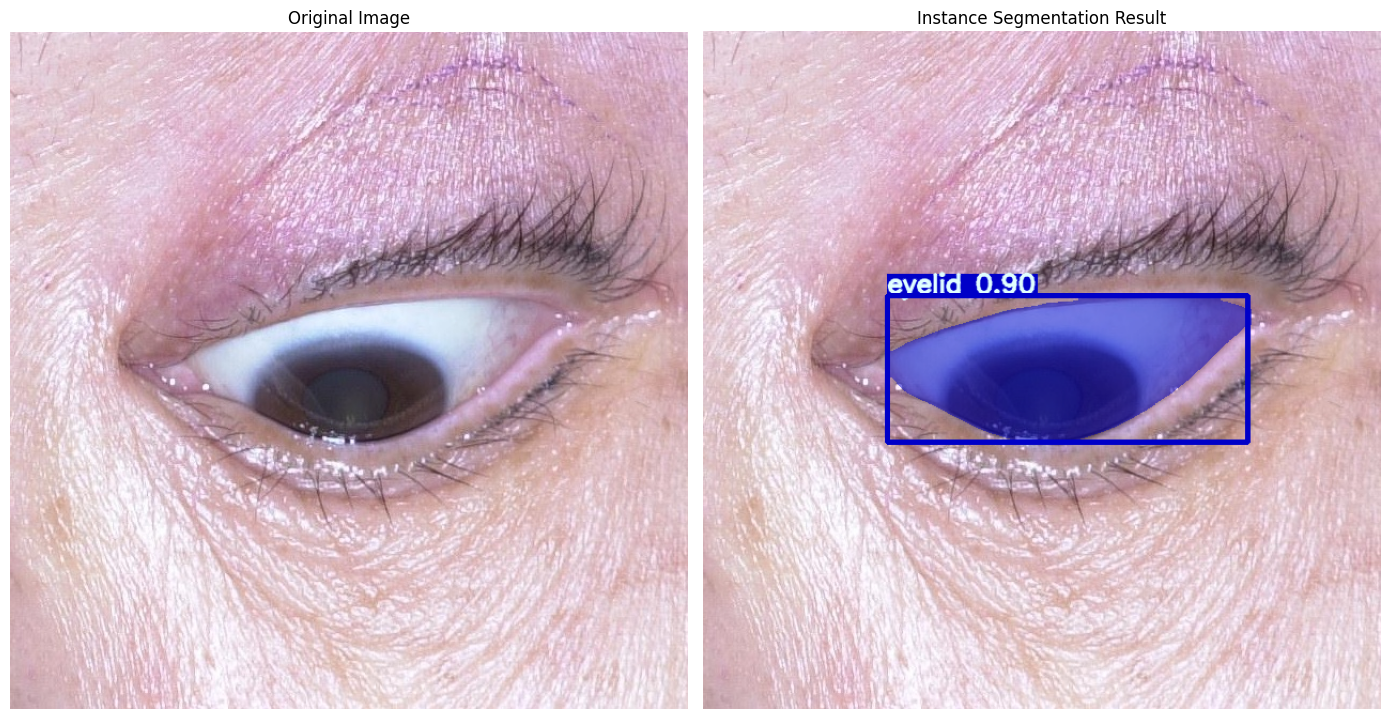

In [21]:
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = YOLO(r"C:\Users\CorneAI\YOLOv11_Mobius\models\best_eyelid_184epochs.pt")
# model = RTDETR(r"C:\Users\CorneAI\FacePhoto_instance\models\1-295_538epochs_rtdetr-l.pt")

# Color list (different colors for each class)
colors = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)]
linewidth = 3
fontScale = 0.8
fontFace = cv2.FONT_HERSHEY_SIMPLEX
thickness = 2

# Mask overlay function
def overlay(image, mask, color, alpha):
    """Overlay segmentation mask on the image"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Apply mask
    image_overlay = np.where(mask[:, :, None] == 1, colored_mask, image)
    
    # Apply transparency
    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    return image_combined

# Bounding box and label drawing function
def draw_label(box, img, color, label, line_thickness=3):
    """Draw bounding box and label on the image"""
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    # Draw label background
    text_size = cv2.getTextSize(
        label, fontFace, fontScale=fontScale, thickness=line_thickness
    )[0]
    cv2.rectangle(
        img, (x1, y1), (x1 + text_size[0], y1 - text_size[1] - 2), color, -1
    )  # fill
    
    # Draw label text
    cv2.putText(
        img,
        label,
        (x1, y1 - 3),
        fontFace,
        fontScale,
        [225, 255, 255],
        thickness=line_thickness,
        lineType=cv2.LINE_AA,
    )

    # Draw bounding box
    cv2.rectangle(
        img,
        (x1, y1),
        (x2, y2),
        color,
        linewidth,
    )

# Main processing function
def main():
    # Image path for inference
    image_path = r'C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_L.jpg'
    
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get image dimensions
    h, w, _ = image.shape
    
    # Run inference with the model
    results = model(image_path, conf=0.25, iou=0.45)
    result = results[0]
    
    # Create result image (copy of original)
    output_image = image_rgb.copy()
    
    # Process if masks are available
    if result.masks is not None:
        # Confidence scores list
        conf_list = result.boxes.conf.tolist()
        
        # Process each instance
        for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
            # Resize mask to match image dimensions
            mask = cv2.resize(mask, (w, h))
            
            # Get class ID
            class_id = int(box[5]) if box.shape[0] > 5 else 0
            
            # Select color (cycle through colors if class_id exceeds color list length)
            color_idx = class_id % len(colors)
            
            # Overlay mask with semi-transparency (alpha=0.5)
            output_image = overlay(output_image, mask, colors[color_idx], 0.5)
            
            # Bounding box information
            bbox = box[:4]
            
            # Get class name
            class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
            
            # Get confidence score
            score = box[4] if box.shape[0] > 4 else conf_list[i]
            
            # Create label text
            label_text = f"{class_name} {score:.2f}"
            
            # Draw bounding box and label
            draw_label(bbox, output_image, colors[color_idx], label_text, line_thickness=2)
            
            # Output in YOLO format
            x_center = (bbox[0] + bbox[2]) / (2 * w)
            y_center = (bbox[1] + bbox[3]) / (2 * h)
            width = (bbox[2] - bbox[0]) / w
            height = (bbox[3] - bbox[1]) / h
            print(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        # Display results
        plt.figure(figsize=(14, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(image_rgb)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title("Instance Segmentation Result")
        plt.imshow(output_image)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Save results (optional)
        # output_filename = "segmentation_result.jpg"
        # cv2.imwrite(output_filename, cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))
        # print(f"Saved: {output_filename}")
    else:
        print("No segmentation masks found.")
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

# Execute
if __name__ == "__main__":
    main()

# **複数画像**

階層構造
```
archive.zip/
   ├── data.yaml  # configuration file
   ├── train.txt  # list of train subset image paths
   │
   ├── images/
   │   ├── train/  # directory with images for train subset
   │   │    ├── image1.jpg
   │   │    ├── image2.jpg
   │   │    ├── image3.jpg
   │   │    └── ...
   ├── labels/
   │   ├── train/  # directory with annotations for train subset
   │   │    ├── image1.txt
   │   │    ├── image2.txt
   │   │    ├── image3.txt
   │   │    └── ...

```

***.txt (ラベル)
```
0 0.260745 0.535950 0.218015 0.030600......
```

daya.yaml
```
names:
  0: eyelid
path: .
train: train.txt
```

train.txt
```
data/images/train/***.jpg
data/images/train/***.jpg
...(pathの羅列。拡張子を合わせる)
```
※ラベルや画像と対応を合わせること



### Eyelid

In [ ]:
from ultralytics import YOLO
import numpy as np
import cv2
import os
import glob
import zipfile
import shutil
import random
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import time
from concurrent.futures import ThreadPoolExecutor

"""
YOLOセグメンテーションデータセット生成ツール（高速化版）

機能:
- YOLOモデル推論結果からセグメンテーションデータセット自動生成
- 検出輪郭を滑らかに処理し、均等に40点を配置
- YOLOフォーマットのラベル・データセット構造生成
- オプションで可視化結果も出力
- 並列処理による高速化（ファイルコピーと後処理のみ並列化）
"""

# Color list (different colors for each class)
colors = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)]

def distribute_points_evenly(polygon, num_points=100):
    """
    Redistribute points evenly along a polygon contour
    
    Args:
        polygon: Numpy array of polygon points with shape (n, 2)
        num_points: Number of points to generate along the contour
    
    Returns:
        New polygon with evenly distributed points as numpy array with shape (num_points, 2)
    """
    # Make sure we have a numpy array
    polygon = np.array(polygon).reshape(-1, 2)
    
    # If the polygon doesn't have enough points, return it as is
    if len(polygon) < 3:
        return polygon
    
    # Calculate total perimeter length
    perimeter = 0
    for i in range(len(polygon)):
        next_idx = (i + 1) % len(polygon)
        perimeter += np.linalg.norm(polygon[next_idx] - polygon[i])
    
    # If perimeter is too small, return original polygon
    if perimeter < 1:
        return polygon
    
    # Distance between each new point
    segment_length = perimeter / num_points
    
    # Create new array for evenly distributed points
    new_points = np.zeros((num_points, 2), dtype=np.int32)
    
    # Initialize variables
    current_point = polygon[0].copy()
    new_points[0] = current_point
    polygon_idx = 0
    remaining_segment_length = segment_length
    
    # Create evenly spaced points
    for i in range(1, num_points):
        # Continue adding points until we've placed all required points
        while True:
            # Get current and next point on original polygon
            current = polygon[polygon_idx]
            next_idx = (polygon_idx + 1) % len(polygon)
            next_point = polygon[next_idx]
            
            # Calculate vector and length to next point
            vector = next_point - current
            segment_distance = np.linalg.norm(vector)
            
            # If we can fit the next point within current segment
            if segment_distance >= remaining_segment_length:
                # Calculate position of new point
                direction = vector / segment_distance
                current_point = current + direction * remaining_segment_length
                new_points[i] = np.round(current_point).astype(np.int32)
                # Reset remaining length for next iteration
                remaining_segment_length = segment_length
                break
            else:
                # Move to next segment
                polygon_idx = (polygon_idx + 1) % len(polygon)
                remaining_segment_length -= segment_distance
    
    return new_points

def process_contours_with_direct_inference(mask_binary, num_contour_points=100, smooth_factor=0.0):
    """
    直接推論マスクから輪郭を抽出し、均等に点を配置する
    
    Args:
        mask_binary: バイナリマスク (np.uint8)
        num_contour_points: 輪郭に沿って生成する点の数
        smooth_factor: スムージング係数 (0.0でスムージングなし)
    
    Returns:
        均等に配置された点を持つ輪郭 (np.array)
    """
    # 輪郭を見つける
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if not contours:
        return None
    
    # 最大の輪郭を取得
    largest_contour = max(contours, key=cv2.contourArea)
    
    # [n, 2]形式に整形
    contour_points = largest_contour.reshape(-1, 2)
    
    # スムージングが必要な場合のみ適用
    if smooth_factor > 0 and len(contour_points) >= 4:
        try:
            # スムージング処理
            tck, u = splprep([contour_points[:, 0], contour_points[:, 1]], s=smooth_factor, per=True)
            u_new = np.linspace(0, 1, len(contour_points))
            smoothed_points = np.column_stack(splev(u_new, tck))
            contour_points = smoothed_points.astype(np.int32)
        except Exception as e:
            # スムージングが失敗した場合は元の点を使用
            print(f"スムージング処理中にエラーが発生しました: {e}")
    
    # 輪郭に沿って点を均等に分布
    evenly_distributed_points = distribute_points_evenly(contour_points, num_contour_points)
    
    return evenly_distributed_points

def overlay_mask(image, mask, color, alpha=0.5):
    """Overlay mask on image with transparency"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Apply mask
    mask_overlay = np.where(mask[:, :, None] == 1, colored_mask, image)
    
    # Apply transparency
    image_combined = cv2.addWeighted(image, 1 - alpha, mask_overlay, alpha, 0)
    return image_combined

def copy_image_parallel(src_path, dest_path):
    """画像をコピーする並列タスク"""
    shutil.copy2(src_path, dest_path)
    return dest_path

def create_yolo_segmentation_dataset(orig_image_dir, output_dir, model_path, yaml_content, num_images=None, random_selection=False, visualize_test=False, enable_smoothing=True, num_contour_points=100, max_points=None):
    """
    Create YOLO dataset structure for segmentation
    
    Args:
        orig_image_dir: Directory containing original images
        output_dir: Output directory for the dataset
        model_path: Path to the YOLO model
        yaml_content: Content for data.yaml file
        num_images: Number of images to process (None for all images)
        random_selection: Whether to randomly select images (if num_images is specified)
        visualize_test: Whether to visualize reconstructed masks (for test mode)
        enable_smoothing: Whether to apply smoothing to contours
        num_contour_points: Number of points to generate along each contour (equally distributed)
        max_points: Maximum number of points to keep per contour (None for no limit)
    """
    start_time = time.time()
    total_steps = 5 if visualize_test else 4
    
    # ステップ1: ディレクトリ作成
    print(f"Creating dataset: Step 1/{total_steps}")
    os.makedirs(os.path.join(output_dir, "labels", "Train"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images", "Train"), exist_ok=True)
    if visualize_test:
        os.makedirs(os.path.join(output_dir, "visualization"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "inference"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "labels"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "comparison"), exist_ok=True)
    
    # ステップ2: YAML作成
    print(f"Creating dataset: Step 2/{total_steps}")
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    
    # 画像ファイルを取得
    image_files = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\nFound {total_files} files")
    
    # 必要なら画像を選択
    if num_images is not None and num_images < total_files:
        if random_selection:
            image_files = random.sample(image_files, num_images)
            print(f"Randomly selected {num_images} images for processing")
        else:
            image_files = image_files[:num_images]
            print(f"Selected first {num_images} images for processing")
        total_files = len(image_files)
    
    # ステップ3: 推論とラベル生成
    print(f"Creating dataset: Step 3/{total_steps}")
    print("\nInference and label generation")
    
    # モデルの読み込み（環境情報表示を抑制）
    model = YOLO(model_path, verbose=False)
    
    # オリジナル画像をコピー（並列処理）
    with ThreadPoolExecutor(max_workers=min(os.cpu_count(), 16)) as executor:
        # 画像のコピーを並列で実行
        src_dest_pairs = []
        for image_path in image_files:
            basename = os.path.basename(image_path)
            dest_path = os.path.join(output_dir, "images", "Train", basename)
            src_dest_pairs.append((image_path, dest_path))
        
        # 並列でコピー実行
        executor.map(lambda p: copy_image_parallel(*p), src_dest_pairs)
    
    # 処理ファイル情報を記録
    processed_files = []
    train_txt_paths = []
    
    # 順番に処理（モデル推論は並列化しない）
    for i, image_path in enumerate(image_files):
        # ファイル名を取得
        basename = os.path.basename(image_path)
        name_without_ext = os.path.splitext(basename)[0]
        
        # コピー先のファイルパス
        dest_image_path = os.path.join(output_dir, "images", "Train", basename)
        
        # ラベルファイルパス
        label_path = os.path.join(output_dir, "labels", "Train", f"{name_without_ext}.txt")
        
        # 画像読み込み
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image {image_path}")
            continue
        
        h, w = img.shape[:2]
        
        # モデル推論 (verbose=Falseで情報表示を抑制)
        results = model(image_path, verbose=False)
        result = results[0]
        
        # テストモードでの可視化
        if visualize_test and hasattr(result, 'masks') and result.masks is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            inference_vis = img_rgb.copy()
            
            for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                class_id = int(box[5]) if box.shape[0] > 5 else 0
                color_idx = class_id % len(colors)
                color = colors[color_idx]
                
                resized_mask = cv2.resize(mask, (w, h))
                mask_binary = (resized_mask > 0.5).astype(np.uint8)
                
                inference_vis = overlay_mask(inference_vis, mask_binary, color)
                
                x1, y1, x2, y2 = map(int, box[:4])
                cv2.rectangle(inference_vis, (x1, y1), (x2, y2), color, 2)
                
                conf = float(box[4])
                class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
                label = f"{class_name} {conf:.2f}"
                cv2.putText(inference_vis, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
            cv2.imwrite(inference_vis_path, cv2.cvtColor(inference_vis, cv2.COLOR_RGB2BGR))
        
        # YOLOフォーマットでラベル作成
        with open(label_path, 'w', encoding='utf-8') as lf:
            if hasattr(result, 'masks') and result.masks is not None:
                for j, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                    class_id = int(box[5]) if box.shape[0] > 5 else 0
                    
                    mask = cv2.resize(mask, (w, h))
                    mask_binary = (mask > 0.5).astype(np.uint8)
                    
                    distributed_points = process_contours_with_direct_inference(
                        mask_binary, 
                        num_contour_points=num_contour_points,
                        smooth_factor=0.5 if enable_smoothing else 0.0
                    )
                    
                    if distributed_points is not None and len(distributed_points) > 0:
                        polygon_points = []
                        for point in distributed_points:
                            x_norm = point[0] / w
                            y_norm = point[1] / h
                            polygon_points.extend([x_norm, y_norm])
                        
                        line = f"{class_id} " + " ".join([f"{p:.6f}" for p in polygon_points])
                        lf.write(line + "\n")
        
        # YOLO形式でパスを保存
        yolo_path = f"data/images/Train/{basename}"
        train_txt_paths.append(yolo_path)
        
        # 処理情報を記録
        processed_files.append({
            'image_path': dest_image_path,
            'label_path': label_path,
            'basename': basename,
            'name_without_ext': name_without_ext
        })
        
        # 進捗表示
        if (i+1) % 20 == 0 or (i+1) == total_files:
            print(f"Processed {i+1}/{total_files} images")
    
    # Train.txtを作成
    with open(os.path.join(output_dir, "Train.txt"), 'w', encoding='utf-8') as f:
        for path in train_txt_paths:
            f.write(f"{path}\n")
    
    # ステップ4: 可視化（テストモードのみ）
    if visualize_test and processed_files:
        print(f"Creating dataset: Step 4/{total_steps}")
        print("\nVisualizing reconstructed masks from labels...")
        
        for i, file_info in enumerate(processed_files):
            # 画像とラベルのパス
            image_path = file_info['image_path']
            label_path = file_info['label_path']
            
            # 画像読み込み
            image = cv2.imread(image_path)
            if image is None:
                continue
                
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape
            
            # 結果画像
            label_mask_image = image_rgb.copy()
            
            # ラベル読み込み
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # 各ラベル処理
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:  # class_id + 2 points (4 coordinates) minimum
                    continue
                    
                class_id = int(parts[0])
                color_idx = class_id % len(colors)
                color = colors[color_idx]
                
                polygon_points = []
                for j in range(1, len(parts), 2):
                    if j+1 < len(parts):
                        x_norm = float(parts[j])
                        y_norm = float(parts[j+1])
                        x = int(x_norm * w)
                        y = int(y_norm * h)
                        polygon_points.append([x, y])
                
                polygon_points = np.array(polygon_points, dtype=np.int32)
                
                mask = np.zeros((h, w), dtype=np.uint8)
                cv2.fillPoly(mask, [polygon_points], 1)
                
                label_mask_image = overlay_mask(label_mask_image, mask, color)
                cv2.polylines(label_mask_image, [polygon_points], True, color, 2)
            
            # ラベルマスク可視化を保存
            name_without_ext = file_info['name_without_ext']
            label_vis_path = os.path.join(output_dir, "visualization", "labels", f"{name_without_ext}_label_mask.jpg")
            cv2.imwrite(label_vis_path, cv2.cvtColor(label_mask_image, cv2.COLOR_RGB2BGR))
            
            # 比較画像
            fig = plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(image_rgb)
            plt.axis('off')
            
            # 推論可視化
            inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
            if os.path.exists(inference_vis_path):
                inference_vis = cv2.imread(inference_vis_path)
                inference_vis_rgb = cv2.cvtColor(inference_vis, cv2.COLOR_BGR2RGB)
                
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask")
                plt.imshow(inference_vis_rgb)
                plt.axis('off')
            else:
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask (Not Available)")
                plt.imshow(np.zeros_like(image_rgb))
                plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Label-based Mask")
            plt.imshow(label_mask_image)
            plt.axis('off')
            
            plt.tight_layout()
            
            comparison_path = os.path.join(output_dir, "visualization", "comparison", f"{name_without_ext}_comparison.jpg")
            plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            # 進捗表示
            if (i+1) % 2 == 0 or (i+1) == len(processed_files):
                print(f"Visualized {i+1}/{len(processed_files)} images")
        
        print(f"\nVisualization results saved to: {os.path.join(output_dir, 'visualization')}")
    
    # ステップ5: ZIP圧縮
    print(f"Creating dataset: Step {total_steps}/{total_steps}")
    print("\nStarting ZIP compression...")
    archive_name = "archive_eyelid.zip"
    archive_path = os.path.join(os.path.dirname(output_dir), archive_name)
    
    # ZIPに追加するファイル数をカウント
    total_zip_files = 0
    for root, dirs, files in os.walk(output_dir):
        if "images" not in root.split(os.sep):  # imagesディレクトリ内のファイルをスキップ
            total_zip_files += len(files)
    
    # ZIP圧縮
    file_count = 0
    with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(output_dir):
            # imagesディレクトリとそのサブディレクトリをスキップ
            if "images" in root.split(os.sep):
                continue
            
            # その他のファイルをZIPに追加
            for file in files:
                file_path = os.path.join(root, file)
                rel_path = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, rel_path)
                file_count += 1
                
                # 進捗表示
                if file_count % 10 == 0 or file_count == total_zip_files:
                    print(f"ZIP compression: {file_count}/{total_zip_files} files")
    
    elapsed_time = time.time() - start_time
    print(f"\nProcessing complete in {elapsed_time:.1f} seconds")
    print(f"Compressed folder to {archive_path} (images folder excluded).")
    
    return archive_path

def generate_img_list(dataset_dir, extension='.jpg'):
    """
    既存のラベルファイルからTrain.txtを生成します（data.yamlは作成しません）
    
    Args:
        dataset_dir: YOLOデータセットのベースディレクトリ
        extension: 画像ファイルの拡張子（デフォルト: .jpg）
    """
    print("\n=== img_list.txt (Train.txt) の生成を開始します ===")
    
    # ラベルディレクトリのパスを設定
    label_dir = os.path.join(dataset_dir, "labels", "Train")
    
    # Train.txtのパスを設定
    img_list_path = os.path.join(dataset_dir, "Train.txt")
    
    # ラベルディレクトリからすべてのtxtファイルを取得
    txt_files = glob.glob(os.path.join(label_dir, "*.txt"))
    
    if not txt_files:
        print(f"警告: {label_dir} にラベルファイルが見つかりません")
        return False
    
    print(f"{len(txt_files)}個のラベルファイルを見つけました")
    
    # Train.txtを作成
    with open(img_list_path, 'w', encoding='utf-8') as f:
        for txt_file in txt_files:
            basename = os.path.splitext(os.path.basename(txt_file))[0]
            # YOLOの標準パス形式を使用
            f.write(f"data/images/Train/{basename}{extension}\n")
    
    print(f"Train.txtを作成しました: {img_list_path} ({len(txt_files)}件のエントリ)")
    return True

def main():
    # Paths from user
    orig_image_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
    model_path = r"C:\Users\CorneAI\YOLOv11_Mobius\models\best_eyelid_184epochs.pt"
    
    yaml_content = """
    Train: Train.txt
    names:
        0: Eyelid
    path: .
    """

    # Create full dataset with smoothed contours and 100 evenly distributed points
    full_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid"
    print("\n=== Creating Full Dataset with Smoothed Contours ===")
    create_yolo_segmentation_dataset(
        orig_image_dir=orig_image_dir,
        output_dir=full_output_dir,
        model_path=model_path,
        yaml_content=yaml_content,
        enable_smoothing=True,             # Enable smoothing for contours
        num_contour_points=100,            # Set exactly 100 points per contour
        max_points=None                    # Don't limit points further
    )
    
    # 既存のデータセットのためにimg_list.txtを生成（data.yamlは既に存在するのでスキップ）
    generate_img_list(full_output_dir)

    
    # # Create test dataset with 10 images and visualization
    # test_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\test_10_smooth_contours"
    # print("\n=== Creating 10-Image Test Dataset with Smoothed Contours and Visualization ===")
    # create_yolo_segmentation_dataset(
    #     orig_image_dir=orig_image_dir,
    #     output_dir=test_output_dir,
    #     model_path=model_path,
    #     yaml_content=yaml_content,
    #     num_images=10,
    #     random_selection=True,
    #     visualize_test=True,               # Enable visualization for test mode
    #     enable_smoothing=True,             # Enable smoothing for contours
    #     num_contour_points=40,            # Set exactly 40 points per contour
    #     max_points=None                    # Don't limit points further
    # )

    
    print("\n=== Processing Complete ===")

if __name__ == "__main__":
    main()


=== Creating 10-Image Test Dataset with Smoothed Contours and Visualization ===
Creating dataset: Step 1/5
Creating dataset: Step 2/5

Found 4467 files
Randomly selected 10 images for processing
Creating dataset: Step 3/5

Inference and label generation
Creating dataset: Step 4/5

Visualizing reconstructed masks from labels...
Visualized 2/10 images
Visualized 4/10 images
Visualized 6/10 images
Visualized 8/10 images
Visualized 10/10 images

Visualization results saved to: C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\test_10_smooth_contours\visualization
Creating dataset: Step 5/5

Starting ZIP compression...
ZIP compression: 10/41 files
ZIP compression: 20/41 files
ZIP compression: 30/41 files
ZIP compression: 40/41 files
ZIP compression: 41/41 files

Processing complete in 8.1 seconds
Compressed folder to C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\archive.zip (images folder excluded).

=== Processing Complete ===


In [13]:
from ultralytics import YOLO
import numpy as np
import cv2
import os
import glob
import zipfile
import shutil
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev


"""
YOLOセグメンテーションデータセット生成ツール

機能:
- YOLOモデル推論結果からセグメンテーションデータセット自動生成
- 検出輪郭を滑らかに処理し、均等に100点を配置
- YOLOフォーマットのラベル・データセット構造生成
- オプションで可視化結果も出力

使用方法:
1. モデルパスと画像ディレクトリを設定
2. 必要に応じてパラメータ調整（点数、スムージング強度）
3. create_yolo_segmentation_dataset関数を実行
"""



# Color list (different colors for each class)
colors = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)]

def distribute_points_evenly(polygon, num_points=100):
    """
    Redistribute points evenly along a polygon contour
    
    Args:
        polygon: Numpy array of polygon points with shape (n, 2)
        num_points: Number of points to generate along the contour
    
    Returns:
        New polygon with evenly distributed points as numpy array with shape (num_points, 2)
    """
    # Make sure we have a numpy array
    polygon = np.array(polygon).reshape(-1, 2)
    
    # If the polygon doesn't have enough points, return it as is
    if len(polygon) < 3:
        return polygon
    
    # Calculate total perimeter length
    perimeter = 0
    for i in range(len(polygon)):
        next_idx = (i + 1) % len(polygon)
        perimeter += np.linalg.norm(polygon[next_idx] - polygon[i])
    
    # If perimeter is too small, return original polygon
    if perimeter < 1:
        return polygon
    
    # Distance between each new point
    segment_length = perimeter / num_points
    
    # Create new array for evenly distributed points
    new_points = np.zeros((num_points, 2), dtype=np.int32)
    
    # Initialize variables
    current_point = polygon[0].copy()
    new_points[0] = current_point
    polygon_idx = 0
    remaining_segment_length = segment_length
    
    # Create evenly spaced points
    for i in range(1, num_points):
        # Continue adding points until we've placed all required points
        while True:
            # Get current and next point on original polygon
            current = polygon[polygon_idx]
            next_idx = (polygon_idx + 1) % len(polygon)
            next_point = polygon[next_idx]
            
            # Calculate vector and length to next point
            vector = next_point - current
            segment_distance = np.linalg.norm(vector)
            
            # If we can fit the next point within current segment
            if segment_distance >= remaining_segment_length:
                # Calculate position of new point
                direction = vector / segment_distance
                current_point = current + direction * remaining_segment_length
                new_points[i] = np.round(current_point).astype(np.int32)
                # Reset remaining length for next iteration
                remaining_segment_length = segment_length
                break
            else:
                # Move to next segment
                polygon_idx = (polygon_idx + 1) % len(polygon)
                remaining_segment_length -= segment_distance
    
    return new_points

def process_contours_with_direct_inference(mask_binary, num_contour_points=100, smooth_factor=0.0):
    """
    直接推論マスクから輪郭を抽出し、均等に点を配置する
    
    Args:
        mask_binary: バイナリマスク (np.uint8)
        num_contour_points: 輪郭に沿って生成する点の数
        smooth_factor: スムージング係数 (0.0でスムージングなし)
    
    Returns:
        均等に配置された点を持つ輪郭 (np.array)
    """
    # 輪郭を見つける
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if not contours:
        return None
    
    # 最大の輪郭を取得
    largest_contour = max(contours, key=cv2.contourArea)
    
    # [n, 2]形式に整形
    contour_points = largest_contour.reshape(-1, 2)
    
    # スムージングが必要な場合のみ適用
    if smooth_factor > 0 and len(contour_points) >= 4:
        try:
            # スムージング処理
            tck, u = splprep([contour_points[:, 0], contour_points[:, 1]], s=smooth_factor, per=True)
            u_new = np.linspace(0, 1, len(contour_points))
            smoothed_points = np.column_stack(splev(u_new, tck))
            contour_points = smoothed_points.astype(np.int32)
        except Exception as e:
            # スムージングが失敗した場合は元の点を使用
            print(f"スムージング処理中にエラーが発生しました: {e}")
    
    # 輪郭に沿って点を均等に分布
    evenly_distributed_points = distribute_points_evenly(contour_points, num_contour_points)
    
    return evenly_distributed_points

def overlay_mask(image, mask, color, alpha=0.5):
    """Overlay mask on image with transparency"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Apply mask
    mask_overlay = np.where(mask[:, :, None] == 1, colored_mask, image)
    
    # Apply transparency
    image_combined = cv2.addWeighted(image, 1 - alpha, mask_overlay, alpha, 0)
    return image_combined

def create_yolo_segmentation_dataset(orig_image_dir, output_dir, model_path, yaml_content, num_images=None, random_selection=False, visualize_test=False, enable_smoothing=True, num_contour_points=100, max_points=None):
    """
    Create YOLO dataset structure for segmentation
    
    Args:
        orig_image_dir: Directory containing original images
        output_dir: Output directory for the dataset
        model_path: Path to the YOLO model
        yaml_content: Content for data.yaml file
        num_images: Number of images to process (None for all images)
        random_selection: Whether to randomly select images (if num_images is specified)
        visualize_test: Whether to visualize reconstructed masks (for test mode)
        enable_smoothing: Whether to apply smoothing to contours
        num_contour_points: Number of points to generate along each contour (equally distributed)
        max_points: Maximum number of points to keep per contour (None for no limit)
    """
    # Setup progress bar
    progress = tqdm(
        total=5 if visualize_test else 4,  
        desc="Creating dataset",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )

    # Create necessary directories
    os.makedirs(os.path.join(output_dir, "labels", "Train"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images", "Train"), exist_ok=True)
    if visualize_test:
        os.makedirs(os.path.join(output_dir, "visualization"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "inference"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "labels"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "comparison"), exist_ok=True)
    progress.update(1)
    
    # Create data.yaml
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    progress.update(1)
    
    # Load model
    try:
        model = YOLO(model_path)
    except Exception as e:
        print(f"Failed to load model: {e}")
        return
    
    # Get list of image files
    image_files = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\nFound {total_files} files")
    
    # Select limited number of images if specified
    if num_images is not None and num_images < total_files:
        if random_selection:
            image_files = random.sample(image_files, num_images)
            print(f"Randomly selected {num_images} images for processing")
        else:
            image_files = image_files[:num_images]
            print(f"Selected first {num_images} images for processing")
        total_files = len(image_files)
    
    # Progress bar for inference and label generation
    inference_progress = tqdm(
        total=total_files,
        desc="Inference and label generation",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )
    
    # Create Train.txt and label files
    processed_files = []
    with open(os.path.join(output_dir, "Train.txt"), 'w', encoding='utf-8') as f:
        for image_path in image_files:
            # Keep original extension
            basename = os.path.basename(image_path)
            name_without_ext = os.path.splitext(basename)[0]
            
            # Copy original image to Train/images directory
            dest_image_path = os.path.join(output_dir, "images", "Train", basename)
            shutil.copy2(image_path, dest_image_path)
            
            # Run inference
            results = model(image_path, save=False)
            result = results[0]
            
            # Get image dimensions for normalization
            img = cv2.imread(image_path)
            h, w = img.shape[:2]
            
            # Label file path (under Train/ with .txt extension)
            label_path = os.path.join(output_dir, "labels", "Train", f"{name_without_ext}.txt")
            
            # Save direct inference visualization for test mode
            if visualize_test and hasattr(result, 'masks') and result.masks is not None:
                # Create a copy of the original image for visualization
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                inference_vis = img_rgb.copy()
                
                # Process each instance
                for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                    # Get class ID
                    class_id = int(box[5]) if box.shape[0] > 5 else 0
                    
                    # Select color
                    color_idx = class_id % len(colors)
                    color = colors[color_idx]
                    
                    # Resize mask to match image dimensions
                    resized_mask = cv2.resize(mask, (w, h))
                    
                    # Convert to binary mask
                    mask_binary = (resized_mask > 0.5).astype(np.uint8)
                    
                    # Overlay mask on image
                    inference_vis = overlay_mask(inference_vis, mask_binary, color)
                    
                    # Draw bounding box
                    x1, y1, x2, y2 = map(int, box[:4])
                    cv2.rectangle(inference_vis, (x1, y1), (x2, y2), color, 2)
                    
                    # Add label text
                    conf = float(box[4])
                    class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
                    label = f"{class_name} {conf:.2f}"
                    cv2.putText(inference_vis, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                
                # Save inference visualization
                inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
                cv2.imwrite(inference_vis_path, cv2.cvtColor(inference_vis, cv2.COLOR_RGB2BGR))
            
            # Write instance segmentation results to text file in YOLO format
            with open(label_path, 'w', encoding='utf-8') as lf:
                if hasattr(result, 'masks') and result.masks is not None:
                    # Process each instance
                    for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                        # Get class ID
                        class_id = int(box[5]) if box.shape[0] > 5 else 0
                        
                        # Resize mask to match image dimensions
                        mask = cv2.resize(mask, (w, h))
                        
                        # Convert to binary mask
                        mask_binary = (mask > 0.5).astype(np.uint8)
                        
                        # 直接推論マスクから輪郭を抽出し、均等に点を配置
                        distributed_points = process_contours_with_direct_inference(
                            mask_binary, 
                            num_contour_points=num_contour_points,
                            smooth_factor=0.5 if enable_smoothing else 0.0
                        )
                        
                        if distributed_points is not None and len(distributed_points) > 0:
                            # Convert contour points to YOLO format (normalized)
                            polygon_points = []
                            for point in distributed_points:
                                x_norm = point[0] / w
                                y_norm = point[1] / h
                                polygon_points.extend([x_norm, y_norm])
                            
                            # Format: class_id x1 y1 x2 y2 ... xn yn
                            line = f"{class_id} " + " ".join([f"{p:.6f}" for p in polygon_points])
                            lf.write(line + "\n")
                else:
                    # Create empty file if no masks found
                    pass
            
            # Write YOLO format path to Train.txt
            yolo_path = f"data/images/Train/{basename}"
            f.write(f"{yolo_path}\n")
            
            # Store processed file info for visualization
            processed_files.append({
                'image_path': dest_image_path,
                'label_path': label_path,
                'basename': basename,
                'name_without_ext': name_without_ext
            })
            
            inference_progress.update(1)
    
    inference_progress.close()
    progress.update(1)
    
    # Visualize reconstructed masks from labels (for test mode)
    if visualize_test and processed_files:
        print("\nVisualizing reconstructed masks from labels...")
        visualization_dir = os.path.join(output_dir, "visualization")
        
        visualization_progress = tqdm(
            total=len(processed_files),
            desc="Visualizing masks",
            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
        )
        
        for file_info in processed_files:
            # Read the image
            image_path = file_info['image_path']
            label_path = file_info['label_path']
            
            # Load the image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not read image {image_path}")
                visualization_progress.update(1)
                continue
                
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape
            
            # Create result images
            label_mask_image = image_rgb.copy()
            
            # Read label file
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Process each instance in the label file
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:  # Need at least class_id and 2 points (4 coordinates)
                    continue
                    
                # Get class ID
                class_id = int(parts[0])
                
                # Select color
                color_idx = class_id % len(colors)
                color = colors[color_idx]
                
                # Get polygon points (normalized coordinates)
                polygon_points = []
                for j in range(1, len(parts), 2):
                    if j+1 < len(parts):
                        x_norm = float(parts[j])
                        y_norm = float(parts[j+1])
                        # Convert normalized coordinates to pixel coordinates
                        x = int(x_norm * w)
                        y = int(y_norm * h)
                        polygon_points.append([x, y])
                
                # Convert to numpy array
                polygon_points = np.array(polygon_points, dtype=np.int32)
                
                # Create binary mask from original polygon
                mask = np.zeros((h, w), dtype=np.uint8)
                cv2.fillPoly(mask, [polygon_points], 1)
                
                # Overlay mask with semi-transparency
                label_mask_image = overlay_mask(label_mask_image, mask, color)
                
                # Draw polygon outline
                cv2.polylines(label_mask_image, [polygon_points], True, color, 2)
            
            # Save visualization results
            basename = file_info['basename']
            name_without_ext = file_info['name_without_ext']
            
            # Save label-based mask visualization
            label_vis_path = os.path.join(output_dir, "visualization", "labels", f"{name_without_ext}_label_mask.jpg")
            cv2.imwrite(label_vis_path, cv2.cvtColor(label_mask_image, cv2.COLOR_RGB2BGR))
            
            # Save comparison image (original, inference, label-based)
            fig = plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(image_rgb)
            plt.axis('off')
            
            # Read inference visualization if it exists
            inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
            if os.path.exists(inference_vis_path):
                inference_vis = cv2.imread(inference_vis_path)
                inference_vis_rgb = cv2.cvtColor(inference_vis, cv2.COLOR_BGR2RGB)
                
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask")
                plt.imshow(inference_vis_rgb)
                plt.axis('off')
            else:
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask (Not Available)")
                plt.imshow(np.zeros_like(image_rgb))
                plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Label-based Mask")
            plt.imshow(label_mask_image)
            plt.axis('off')
            
            plt.tight_layout()
            
            comparison_path = os.path.join(output_dir, "visualization", "comparison", f"{name_without_ext}_comparison.jpg")
            plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            visualization_progress.update(1)
        
        visualization_progress.close()
        print(f"\nVisualization results saved to: {visualization_dir}")
        
        progress.update(1)
    
    # ZIP compression
    print("\nStarting ZIP compression...")
    archive_name = "archive.zip"
    archive_path = os.path.join(os.path.dirname(output_dir), archive_name)
    
    # Calculate total files for progress bar (excluding images folder)
    total = 0
    for root, dirs, files in os.walk(output_dir):
        if "images" not in root.split(os.sep):  # Skip files in images directory
            total += len(files)
    
    with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        with tqdm(total=total, desc="ZIP compression", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
            # Walk through all directories and files
            for root, dirs, files in os.walk(output_dir):
                # Skip the images directory and its subdirectories
                if "images" in root.split(os.sep):
                    continue
                
                # Add all other files to the ZIP
                for file in files:
                    file_path = os.path.join(root, file)
                    # Calculate relative path for the zip file structure
                    rel_path = os.path.relpath(file_path, output_dir)
                    # Add file to zip
                    zipf.write(file_path, rel_path)
                    pbar.update(1)
    
    progress.update(1)
    progress.close()
    print(f"\nCompressed folder to {archive_path} (images folder excluded).")
    
    return archive_path

def generate_img_list(dataset_dir, extension='.jpg'):
    """
    既存のラベルファイルからTrain.txtを生成します（data.yamlは作成しません）
    
    Args:
        dataset_dir: YOLOデータセットのベースディレクトリ
        extension: 画像ファイルの拡張子（デフォルト: .jpg）
    """
    print("\n=== img_list.txt (Train.txt) の生成を開始します ===")
    
    # ラベルディレクトリのパスを設定
    label_dir = os.path.join(dataset_dir, "labels", "Train")
    
    # Train.txtのパスを設定
    img_list_path = os.path.join(dataset_dir, "Train.txt")
    
    # ラベルディレクトリからすべてのtxtファイルを取得
    txt_files = glob.glob(os.path.join(label_dir, "*.txt"))
    
    if not txt_files:
        print(f"警告: {label_dir} にラベルファイルが見つかりません")
        return False
    
    print(f"{len(txt_files)}個のラベルファイルを見つけました")
    
    # Train.txtを作成
    with open(img_list_path, 'w', encoding='utf-8') as f:
        for txt_file in txt_files:
            basename = os.path.splitext(os.path.basename(txt_file))[0]
            # YOLOの標準パス形式を使用
            f.write(f"data/images/Train/{basename}{extension}\n")
    
    print(f"Train.txtを作成しました: {img_list_path} ({len(txt_files)}件のエントリ)")
    return True

def main():
    # Paths from user
    orig_image_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
    model_path = r"C:\Users\CorneAI\YOLOv11_Mobius\models\best_eyelid_184epochs.pt"
    
    yaml_content = """
    Train: Train.txt
    names:
        0: Eyelid
    path: .
    """  

    # Create full dataset with smoothed contours and 100 evenly distributed points
    full_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid"
    print("\n=== Creating Full Dataset with Smoothed Contours ===")
    create_yolo_segmentation_dataset(
        orig_image_dir=orig_image_dir,
        output_dir=full_output_dir,
        model_path=model_path,
        yaml_content=yaml_content,
        enable_smoothing=True,             # Enable smoothing for contours
        num_contour_points=100,            # Set exactly 100 points per contour
        max_points=None                    # Don't limit points further
    )
    
    # Create test dataset with 10 images and visualization
    test_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\test_10_smooth_contours"
    print("\n=== Creating 10-Image Test Dataset with Smoothed Contours and Visualization ===")
    create_yolo_segmentation_dataset(
        orig_image_dir=orig_image_dir,
        output_dir=test_output_dir,
        model_path=model_path,
        yaml_content=yaml_content,
        num_images=10,
        random_selection=True,
        visualize_test=True,               # Enable visualization for test mode
        enable_smoothing=True,             # Enable smoothing for contours
        num_contour_points=40,            # Set exactly 100 points per contour
        max_points=None                    # Don't limit points further
    )
    
    # 既存のデータセットのためにimg_list.txtを生成（data.yamlは既に存在するのでスキップ）
    generate_img_list(full_output_dir)
    
    print("\n=== Processing Complete ===")

if __name__ == "__main__":
    main()


=== Creating 10-Image Test Dataset with Smoothed Contours and Visualization ===


Creating dataset:   0%|          | 0/5 [00:00<?]


Found 4467 files
Randomly selected 10 images for processing



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20110623-0-000000_ad7168592e454ca9c7d09123ba47e6bd3c0b3d6f5735310ef0be5eeaf1f16e7b_L.jpg: 640x640 2 eyelids, 83.0ms
Speed: 4.6ms preprocess, 83.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\77-20171220-83-093633_1f47eda2bc7fc356dd56b671ad95ac681e321f4d11152a609826b68d298a6fb7_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 5.3ms preprocess, 33.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\101-20190920-71-111529_9b879c73bb9e49c8e8a7ebd821a3265b21f557f05163c017a55086f75ce0adaa_R.jpg: 640x640 1 eyelid, 39.2ms
Speed: 0.0ms preprocess, 39.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060912-1-102300_20e9af717ceada86b3bdf1d389afd267d51376af697e797b1c24f7a210ad4f57_R.jpg: 640x640 3 eyelids, 33.2ms
Speed: 2.0ms preprocess, 33.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20170405-5-100239_526b70ccab7404c7a85285ec18f39ff9fc4597984c06b8005498efa7242d6c46_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.1ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_f0e831ac04356ef2b163f42dfbcf8e1efe9deed0bac67a1b2963c50aa90ac432_L.jpg: 640x640 1 eyelid, 34.2ms
Speed: 1.8ms preprocess, 34.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_aad77ff1d9e3857a248a9e77b19c567776cd17c1605eb41bde3391ff46733fbe_R.jpg: 640x640 1 eyelid, 50.6ms
Speed: 2.0ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\138-20130703-10-104204_26a58ee583d1972e1a87c0c8a10806f1c6efd14570d8748e8517cdd7748f03e1_R.jpg: 640x640 2 eyelids, 59.1ms
Speed: 0.0ms preprocess, 59.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152330_1ffbef62dd646a6ad7a861046ab879cfdfba40a74b34e08b96b232389e6d215d_R.jpg: 640x640 1 eyelid, 50.6ms
Speed: 3.0ms preprocess, 50.6ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20191120-7-111334_03d16fe24124a56fe30746233f9c2cc11a2904ac3ff6e630a18ef97653ebb24a_R.jpg: 640x640 1 eyelid, 55.0ms
Speed: 3.1ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Creating dataset:  60%|██████    | 3/5 [00:04<00:02]


Visualizing reconstructed masks from labels...


Creating dataset:  80%|████████  | 4/5 [00:07<00:01]


Visualization results saved to: C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\test_10_smooth_contours\visualization

Starting ZIP compression...


Creating dataset: 100%|██████████| 5/5 [00:07<00:00]


Compressed folder to C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\archive.zip (images folder excluded).


NameError: name 'full_output_dir' is not defined

In [ ]:
from ultralytics import YOLO
import numpy as np
import cv2
import os
import glob
import zipfile
import shutil
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev


"""
YOLOセグメンテーションデータセット生成ツール

機能:
- YOLOモデル推論結果からセグメンテーションデータセット自動生成
- 検出輪郭を滑らかに処理し、均等に100点を配置
- YOLOフォーマットのラベル・データセット構造生成
- オプションで可視化結果も出力

使用方法:
1. モデルパスと画像ディレクトリを設定
2. 必要に応じてパラメータ調整（点数、スムージング強度）
3. create_yolo_segmentation_dataset関数を実行
"""



# Color list (different colors for each class)
colors = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)]

def distribute_points_evenly(polygon, num_points=100):
    """
    Redistribute points evenly along a polygon contour
    
    Args:
        polygon: Numpy array of polygon points with shape (n, 2)
        num_points: Number of points to generate along the contour
    
    Returns:
        New polygon with evenly distributed points as numpy array with shape (num_points, 2)
    """
    # Make sure we have a numpy array
    polygon = np.array(polygon).reshape(-1, 2)
    
    # If the polygon doesn't have enough points, return it as is
    if len(polygon) < 3:
        return polygon
    
    # Calculate total perimeter length
    perimeter = 0
    for i in range(len(polygon)):
        next_idx = (i + 1) % len(polygon)
        perimeter += np.linalg.norm(polygon[next_idx] - polygon[i])
    
    # If perimeter is too small, return original polygon
    if perimeter < 1:
        return polygon
    
    # Distance between each new point
    segment_length = perimeter / num_points
    
    # Create new array for evenly distributed points
    new_points = np.zeros((num_points, 2), dtype=np.int32)
    
    # Initialize variables
    current_point = polygon[0].copy()
    new_points[0] = current_point
    polygon_idx = 0
    remaining_segment_length = segment_length
    
    # Create evenly spaced points
    for i in range(1, num_points):
        # Continue adding points until we've placed all required points
        while True:
            # Get current and next point on original polygon
            current = polygon[polygon_idx]
            next_idx = (polygon_idx + 1) % len(polygon)
            next_point = polygon[next_idx]
            
            # Calculate vector and length to next point
            vector = next_point - current
            segment_distance = np.linalg.norm(vector)
            
            # If we can fit the next point within current segment
            if segment_distance >= remaining_segment_length:
                # Calculate position of new point
                direction = vector / segment_distance
                current_point = current + direction * remaining_segment_length
                new_points[i] = np.round(current_point).astype(np.int32)
                # Reset remaining length for next iteration
                remaining_segment_length = segment_length
                break
            else:
                # Move to next segment
                polygon_idx = (polygon_idx + 1) % len(polygon)
                remaining_segment_length -= segment_distance
    
    return new_points

def smooth_polygon(polygon, smooth_factor=0.5, num_points=100):
    """
    Smooth a polygon using spline interpolation and distribute points evenly
    
    Args:
        polygon: Numpy array of polygon points with shape (n, 2)
        smooth_factor: Smoothing factor (0 to 1, higher means smoother)
        num_points: Number of points to generate for the smoothed polygon
    
    Returns:
        Smoothed polygon with evenly distributed points as numpy array
    """
    if len(polygon) < 4:
        # Not enough points to smooth, try to distribute evenly
        return distribute_points_evenly(polygon, num_points)
    
    # Close the polygon if it's not already closed
    if not np.array_equal(polygon[0], polygon[-1]):
        polygon = np.vstack([polygon, polygon[0]])
    
    # Fit spline to the polygon points
    try:
        # Check for duplicate points which can cause errors
        unique_points = np.unique(polygon, axis=0)
        if len(unique_points) < 4:
            # Not enough unique points to smooth, try to distribute evenly
            return distribute_points_evenly(polygon, num_points)
            
        # Check if points are collinear (all in a straight line)
        # This can be detected by checking the rank of the covariance matrix
        points_centered = unique_points - np.mean(unique_points, axis=0)
        cov = np.cov(points_centered.T)
        if np.linalg.matrix_rank(cov) < 2:
            # Points are collinear, try to distribute evenly
            return distribute_points_evenly(polygon, num_points)
        
        # Use periodic spline for closed curve
        tck, u = splprep([unique_points[:, 0], unique_points[:, 1]], s=smooth_factor, per=True)
        
        # Generate new points along the spline
        u_new = np.linspace(0, 1, num_points)
        smoothed_polygon = np.column_stack(splev(u_new, tck))
        
        # Ensure points are integers for drawing
        return smoothed_polygon.astype(np.int32)
    except Exception as e:
        # If smoothing fails, try to distribute evenly
        return distribute_points_evenly(polygon, num_points)

def overlay_mask(image, mask, color, alpha=0.5):
    """Overlay mask on image with transparency"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Apply mask
    mask_overlay = np.where(mask[:, :, None] == 1, colored_mask, image)
    
    # Apply transparency
    image_combined = cv2.addWeighted(image, 1 - alpha, mask_overlay, alpha, 0)
    return image_combined

def create_yolo_segmentation_dataset(orig_image_dir, output_dir, model_path, yaml_content, num_images=None, random_selection=False, visualize_test=False, enable_smoothing=True, num_contour_points=100, max_points=None):
    """
    Create YOLO dataset structure for segmentation
    
    Args:
        orig_image_dir: Directory containing original images
        output_dir: Output directory for the dataset
        model_path: Path to the YOLO model
        yaml_content: Content for data.yaml file
        num_images: Number of images to process (None for all images)
        random_selection: Whether to randomly select images (if num_images is specified)
        visualize_test: Whether to visualize reconstructed masks (for test mode)
        enable_smoothing: Whether to apply smoothing to contours
        num_contour_points: Number of points to generate along each contour (equally distributed)
        max_points: Maximum number of points to keep per contour (None for no limit)
    """
    # Setup progress bar
    progress = tqdm(
        total=5 if visualize_test else 4,  
        desc="Creating dataset",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )

    # Create necessary directories
    os.makedirs(os.path.join(output_dir, "labels", "Train"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images", "Train"), exist_ok=True)
    if visualize_test:
        os.makedirs(os.path.join(output_dir, "visualization"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "inference"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "labels"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "comparison"), exist_ok=True)
    progress.update(1)
    
    # Create data.yaml
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    progress.update(1)
    
    # Load model
    try:
        model = YOLO(model_path)
    except Exception as e:
        print(f"Failed to load model: {e}")
        return
    
    # Get list of image files
    image_files = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\nFound {total_files} files")
    
    # Select limited number of images if specified
    if num_images is not None and num_images < total_files:
        if random_selection:
            image_files = random.sample(image_files, num_images)
            print(f"Randomly selected {num_images} images for processing")
        else:
            image_files = image_files[:num_images]
            print(f"Selected first {num_images} images for processing")
        total_files = len(image_files)
    
    # Progress bar for inference and label generation
    inference_progress = tqdm(
        total=total_files,
        desc="Inference and label generation",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )
    
    # Create Train.txt and label files
    processed_files = []
    with open(os.path.join(output_dir, "Train.txt"), 'w', encoding='utf-8') as f:
        for image_path in image_files:
            # Keep original extension
            basename = os.path.basename(image_path)
            name_without_ext = os.path.splitext(basename)[0]
            
            # Copy original image to Train/images directory
            dest_image_path = os.path.join(output_dir, "images", "Train", basename)
            shutil.copy2(image_path, dest_image_path)
            
            # Run inference
            results = model(image_path, save=False)
            result = results[0]
            
            # Get image dimensions for normalization
            img = cv2.imread(image_path)
            h, w = img.shape[:2]
            
            # Label file path (under Train/ with .txt extension)
            label_path = os.path.join(output_dir, "labels", "Train", f"{name_without_ext}.txt")
            
            # Save direct inference visualization for test mode
            if visualize_test and hasattr(result, 'masks') and result.masks is not None:
                # Create a copy of the original image for visualization
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                inference_vis = img_rgb.copy()
                
                # Process each instance
                for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                    # Get class ID
                    class_id = int(box[5]) if box.shape[0] > 5 else 0
                    
                    # Select color
                    color_idx = class_id % len(colors)
                    color = colors[color_idx]
                    
                    # Resize mask to match image dimensions
                    resized_mask = cv2.resize(mask, (w, h))
                    
                    # Convert to binary mask
                    mask_binary = (resized_mask > 0.5).astype(np.uint8)
                    
                    # Overlay mask on image
                    inference_vis = overlay_mask(inference_vis, mask_binary, color)
                    
                    # Draw bounding box
                    x1, y1, x2, y2 = map(int, box[:4])
                    cv2.rectangle(inference_vis, (x1, y1), (x2, y2), color, 2)
                    
                    # Add label text
                    conf = float(box[4])
                    class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
                    label = f"{class_name} {conf:.2f}"
                    cv2.putText(inference_vis, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                
                # Save inference visualization
                inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
                cv2.imwrite(inference_vis_path, cv2.cvtColor(inference_vis, cv2.COLOR_RGB2BGR))
            
            # Write instance segmentation results to text file in YOLO format
            with open(label_path, 'w', encoding='utf-8') as lf:
                if hasattr(result, 'masks') and result.masks is not None:
                    # Process each instance
                    for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                        # Get class ID
                        class_id = int(box[5]) if box.shape[0] > 5 else 0
                        
                        # Resize mask to match image dimensions
                        mask = cv2.resize(mask, (w, h))
                        
                        # Convert to binary mask
                        mask_binary = (mask > 0.5).astype(np.uint8)
                        
                        # Find contours - use CHAIN_APPROX_NONE to get all points
                        contour_mode = cv2.RETR_EXTERNAL
                        contour_method = cv2.CHAIN_APPROX_NONE
                        
                        contours, _ = cv2.findContours(mask_binary, contour_mode, contour_method)
                        
                        if contours:
                            # Get the largest contour
                            largest_contour = max(contours, key=cv2.contourArea)
                            
                            # Apply smoothing and distribute points evenly if enabled
                            if enable_smoothing:
                                # Reshape contour to [n, 2] format
                                contour_points = largest_contour.reshape(-1, 2)
                                
                                # Apply smoothing and make 100 evenly distributed points
                                largest_contour = smooth_polygon(contour_points, smooth_factor=0.5, num_points=num_contour_points)
                                
                                # Reshape back to contour format for visualization
                                largest_contour = largest_contour.reshape(-1, 1, 2)
                            
                            # Limit number of points if specified (should not be needed with even distribution)
                            if max_points is not None and len(largest_contour) > max_points:
                                # Use Douglas-Peucker algorithm to reduce points while preserving shape
                                epsilon = 0.001 * cv2.arcLength(largest_contour, True)
                                largest_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
                            
                            # Convert contour points to YOLO format (normalized)
                            polygon_points = []
                            for point in largest_contour.reshape(-1, 2):
                                x_norm = point[0] / w
                                y_norm = point[1] / h
                                polygon_points.extend([x_norm, y_norm])
                            
                            # Format: class_id x1 y1 x2 y2 ... xn yn
                            line = f"{class_id} " + " ".join([f"{p:.6f}" for p in polygon_points])
                            lf.write(line + "\n")
                else:
                    # Create empty file if no masks found
                    pass
            
            # Write YOLO format path to Train.txt
            yolo_path = f"data/images/Train/{basename}"
            f.write(f"{yolo_path}\n")
            
            # Store processed file info for visualization
            processed_files.append({
                'image_path': dest_image_path,
                'label_path': label_path,
                'basename': basename,
                'name_without_ext': name_without_ext
            })
            
            inference_progress.update(1)
    
    inference_progress.close()
    progress.update(1)
    
    # Visualize reconstructed masks from labels (for test mode)
    if visualize_test and processed_files:
        print("\nVisualizing reconstructed masks from labels...")
        visualization_dir = os.path.join(output_dir, "visualization")
        
        visualization_progress = tqdm(
            total=len(processed_files),
            desc="Visualizing masks",
            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
        )
        
        for file_info in processed_files:
            # Read the image
            image_path = file_info['image_path']
            label_path = file_info['label_path']
            
            # Load the image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not read image {image_path}")
                visualization_progress.update(1)
                continue
                
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape
            
            # Create result images
            label_mask_image = image_rgb.copy()
            
            # Read label file
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Process each instance in the label file
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:  # Need at least class_id and 2 points (4 coordinates)
                    continue
                    
                # Get class ID
                class_id = int(parts[0])
                
                # Select color
                color_idx = class_id % len(colors)
                color = colors[color_idx]
                
                # Get polygon points (normalized coordinates)
                polygon_points = []
                for j in range(1, len(parts), 2):
                    if j+1 < len(parts):
                        x_norm = float(parts[j])
                        y_norm = float(parts[j+1])
                        # Convert normalized coordinates to pixel coordinates
                        x = int(x_norm * w)
                        y = int(y_norm * h)
                        polygon_points.append([x, y])
                
                # Convert to numpy array
                polygon_points = np.array(polygon_points, dtype=np.int32)
                
                # Create binary mask from original polygon
                mask = np.zeros((h, w), dtype=np.uint8)
                cv2.fillPoly(mask, [polygon_points], 1)
                
                # Overlay mask with semi-transparency
                label_mask_image = overlay_mask(label_mask_image, mask, color)
                
                # Draw polygon outline
                cv2.polylines(label_mask_image, [polygon_points], True, color, 2)
            
            # Save visualization results
            basename = file_info['basename']
            name_without_ext = file_info['name_without_ext']
            
            # Save label-based mask visualization
            label_vis_path = os.path.join(output_dir, "visualization", "labels", f"{name_without_ext}_label_mask.jpg")
            cv2.imwrite(label_vis_path, cv2.cvtColor(label_mask_image, cv2.COLOR_RGB2BGR))
            
            # Save comparison image (original, inference, label-based)
            fig = plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(image_rgb)
            plt.axis('off')
            
            # Read inference visualization if it exists
            inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
            if os.path.exists(inference_vis_path):
                inference_vis = cv2.imread(inference_vis_path)
                inference_vis_rgb = cv2.cvtColor(inference_vis, cv2.COLOR_BGR2RGB)
                
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask")
                plt.imshow(inference_vis_rgb)
                plt.axis('off')
            else:
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask (Not Available)")
                plt.imshow(np.zeros_like(image_rgb))
                plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Label-based Mask")
            plt.imshow(label_mask_image)
            plt.axis('off')
            
            plt.tight_layout()
            
            comparison_path = os.path.join(output_dir, "visualization", "comparison", f"{name_without_ext}_comparison.jpg")
            plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            visualization_progress.update(1)
        
        visualization_progress.close()
        print(f"\nVisualization results saved to: {visualization_dir}")
        
        progress.update(1)
    
    # ZIP compression
    print("\nStarting ZIP compression...")
    archive_name = "archive.zip"
    archive_path = os.path.join(os.path.dirname(output_dir), archive_name)
    
    # Calculate total files for progress bar (excluding images folder)
    total = 0
    for root, dirs, files in os.walk(output_dir):
        if "images" not in root.split(os.sep):  # Skip files in images directory
            total += len(files)
    
    with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        with tqdm(total=total, desc="ZIP compression", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
            # Walk through all directories and files
            for root, dirs, files in os.walk(output_dir):
                # Skip the images directory and its subdirectories
                if "images" in root.split(os.sep):
                    continue
                
                # Add all other files to the ZIP
                for file in files:
                    file_path = os.path.join(root, file)
                    # Calculate relative path for the zip file structure
                    rel_path = os.path.relpath(file_path, output_dir)
                    # Add file to zip
                    zipf.write(file_path, rel_path)
                    pbar.update(1)
    
    progress.update(1)
    progress.close()
    print(f"\nCompressed folder to {archive_path} (images folder excluded).")
    
    return archive_path

def generate_img_list(dataset_dir, extension='.jpg'):
    """
    既存のラベルファイルからTrain.txtを生成します（data.yamlは作成しません）
    
    Args:
        dataset_dir: YOLOデータセットのベースディレクトリ
        extension: 画像ファイルの拡張子（デフォルト: .jpg）
    """
    print("\n=== img_list.txt (Train.txt) の生成を開始します ===")
    
    # ラベルディレクトリのパスを設定
    label_dir = os.path.join(dataset_dir, "labels", "Train")
    
    # Train.txtのパスを設定
    img_list_path = os.path.join(dataset_dir, "Train.txt")
    
    # ラベルディレクトリからすべてのtxtファイルを取得
    txt_files = glob.glob(os.path.join(label_dir, "*.txt"))
    
    if not txt_files:
        print(f"警告: {label_dir} にラベルファイルが見つかりません")
        return False
    
    print(f"{len(txt_files)}個のラベルファイルを見つけました")
    
    # Train.txtを作成
    with open(img_list_path, 'w', encoding='utf-8') as f:
        for txt_file in txt_files:
            basename = os.path.splitext(os.path.basename(txt_file))[0]
            # YOLOの標準パス形式を使用
            f.write(f"data/images/Train/{basename}{extension}\n")
    
    print(f"Train.txtを作成しました: {img_list_path} ({len(txt_files)}件のエントリ)")
    return True

def main():
    # Paths from user
    orig_image_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
    model_path = r"C:\Users\CorneAI\YOLOv11_Mobius\models\best_eyelid_184epochs.pt"
    
    yaml_content = """
    Train: Train.txt
    names:
        0: Eyelid
    path: .
    """  

    # Create full dataset with smoothed contours and 100 evenly distributed points
    full_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid"
    print("\n=== Creating Full Dataset with Smoothed Contours ===")
    create_yolo_segmentation_dataset(
        orig_image_dir=orig_image_dir,
        output_dir=full_output_dir,
        model_path=model_path,
        yaml_content=yaml_content,
        enable_smoothing=True,             # Enable smoothing for contours
        num_contour_points=100,            # Set exactly 100 points per contour
        max_points=None                    # Don't limit points further
    )
    
    # Create test dataset with 10 images and visualization
    test_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\test_10_smooth_contours"
    print("\n=== Creating 10-Image Test Dataset with Smoothed Contours and Visualization ===")
    create_yolo_segmentation_dataset(
        orig_image_dir=orig_image_dir,
        output_dir=test_output_dir,
        model_path=model_path,
        yaml_content=yaml_content,
        num_images=10,
        random_selection=True,
        visualize_test=True,               # Enable visualization for test mode
        enable_smoothing=True,             # Enable smoothing for contours
        num_contour_points=100,            # Set exactly 100 points per contour
        max_points=None                    # Don't limit points further
    )
    
    # 既存のデータセットのためにimg_list.txtを生成（data.yamlは既に存在するのでスキップ）
    generate_img_list(full_output_dir)
    
    print("\n=== Processing Complete ===")
    print(f"Full dataset: {full_output_dir}")
    print(f"Test dataset: {test_output_dir}")

if __name__ == "__main__":
    main()


=== Creating 10-Image Test Dataset with Smoothed Contours and Visualization ===


Creating dataset:   0%|          | 0/5 [00:00<?]


Found 4467 files
Randomly selected 10 images for processing



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20200409-63-091700_9b7e69d886990cd2653ff23b5a85f9fc1ffa030593d67fe8f9391bee4932df2e_L.jpg: 640x640 1 eyelid, 118.9ms
Speed: 0.0ms preprocess, 118.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20190417-40-084910_15b25fe8a47fe15002e94c9de2d0ac9333f7579a943637d1475b798eda5d17ec_R.jpg: 640x640 (no detections), 29.0ms
Speed: 2.9ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_43e246802bfa1b83ad745984d37967aaf32a46821f81ae7cc5cf703af6cdb7d4_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 4.4ms preprocess, 28.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_79c5aa88f00186ee568c161f4782b2602edc63644f35eba9b6fa8c5bc79ff8fa_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.5ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_6334cd74f3c4f4cb1415d0a530ddfca6fd1476426d9db9ed4be85bb817094dc9_R.jpg: 640x640 3 eyelids, 28.2ms
Speed: 2.0ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-135145_1590096e4fff9e1003137d616f4b0a61498279f3b785dabfdafb5bcef720bada_L.jpg: 640x640 1 eyelid, 49.6ms
Speed: 0.0ms preprocess, 49.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160210-7-091051_29e927f5afc58ceea2f97f325bb03d260e25a4141df020cdb6265613dcafda50_R.jpg: 640x640 1 eyelid, 41.5ms
Speed: 2.0ms preprocess, 41.5ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\218-20180530-2-103253_595fb7e70530a3701855b3724092f070f5058c3b2a6d1da7f0fd5fd318c6260b_L.jpg: 640x640 1 eyelid, 45.7ms
Speed: 3.0ms preprocess, 45.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_4680ad4e0d97a3dc419ce8f570efd87637578692194dfa051ba90d46439aeb3f_R.jpg: 640x640 1 eyelid, 50.6ms
Speed: 3.0ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_27b54d359335236d721df76b908ad70bb2e2668ddc8a6ac6c81f901335db4668_R.jpg: 640x640 1 eyelid, 53.2ms
Speed: 2.4ms preprocess, 53.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Creating dataset:  60%|██████    | 3/5 [00:04<00:02]


Visualizing reconstructed masks from labels...


Creating dataset:  80%|████████  | 4/5 [00:07<00:01]


Visualization results saved to: C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\test_10_smooth_contours\visualization

Starting ZIP compression...


Creating dataset: 100%|██████████| 5/5 [00:07<00:00]


Compressed folder to C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\archive.zip (images folder excluded).


NameError: name 'full_output_dir' is not defined

In [77]:
from ultralytics import YOLO
import numpy as np
import cv2
import os
import glob
import zipfile
import shutil
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Color list (different colors for each class)
colors = [(0, 0, 200), (0, 200, 0), (200, 0, 0), (200, 200, 0), (0, 200, 200), (200, 0, 200)]

def smooth_polygon(polygon, smooth_factor=0.5, num_points=300):
    """
    Smooth a polygon using spline interpolation
    
    Args:
        polygon: Numpy array of polygon points with shape (n, 2)
        smooth_factor: Smoothing factor (0 to 1, higher means smoother)
        num_points: Number of points to generate for the smoothed polygon
    
    Returns:
        Smoothed polygon as numpy array with shape (num_points, 2)
    """
    if len(polygon) < 4:
        return polygon  # Not enough points to smooth
    
    # Close the polygon if it's not already closed
    if not np.array_equal(polygon[0], polygon[-1]):
        polygon = np.vstack([polygon, polygon[0]])
    
    # Fit spline to the polygon points
    try:
        # Check for duplicate points which can cause errors
        unique_points = np.unique(polygon, axis=0)
        if len(unique_points) < 4:
            return polygon  # Not enough unique points to smooth
            
        # Check if points are collinear (all in a straight line)
        # This can be detected by checking the rank of the covariance matrix
        points_centered = unique_points - np.mean(unique_points, axis=0)
        cov = np.cov(points_centered.T)
        if np.linalg.matrix_rank(cov) < 2:
            return polygon  # Points are collinear, can't fit a spline
        
        tck, u = splprep([unique_points[:, 0], unique_points[:, 1]], s=smooth_factor, per=True)
        # Generate new points along the spline
        u_new = np.linspace(0, 1, num_points)
        smoothed_polygon = np.column_stack(splev(u_new, tck))
        return smoothed_polygon.astype(np.int32)
    except Exception as e:
        # Instead of printing a warning, just return the original polygon
        return polygon

def overlay_mask(image, mask, color, alpha=0.5):
    """Overlay mask on image with transparency"""
    # Create colored mask with 3 channels
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Apply mask
    mask_overlay = np.where(mask[:, :, None] == 1, colored_mask, image)
    
    # Apply transparency
    image_combined = cv2.addWeighted(image, 1 - alpha, mask_overlay, alpha, 0)
    return image_combined

def create_yolo_segmentation_dataset(orig_image_dir, output_dir, model_path, yaml_content, num_images=None, random_selection=False, visualize_test=False, enable_smoothing=False, contour_approximation=False, max_points=None):
    """
    Create YOLO dataset structure for segmentation
    
    Args:
        orig_image_dir: Directory containing original images
        output_dir: Output directory for the dataset
        model_path: Path to the YOLO model
        yaml_content: Content for data.yaml file
        num_images: Number of images to process (None for all images)
        random_selection: Whether to randomly select images (if num_images is specified)
        visualize_test: Whether to visualize reconstructed masks (for test mode)
        enable_smoothing: Whether to apply smoothing to visualized masks
        contour_approximation: Whether to approximate contours (reduces points)
        max_points: Maximum number of points to keep per contour (None for no limit)
    """
    # Setup progress bar
    progress = tqdm(
        total=5 if visualize_test else 4,  
        desc="Creating dataset",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )

    # Create necessary directories
    os.makedirs(os.path.join(output_dir, "labels", "Train"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images", "Train"), exist_ok=True)
    if visualize_test:
        os.makedirs(os.path.join(output_dir, "visualization"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "inference"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "labels"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualization", "comparison"), exist_ok=True)
    progress.update(1)
    
    # Create data.yaml
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    progress.update(1)
    
    # Load model
    try:
        model = YOLO(model_path)
    except Exception as e:
        print(f"Failed to load model: {e}")
        return
    
    # Get list of image files
    image_files = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\nFound {total_files} files")
    
    # Select limited number of images if specified
    if num_images is not None and num_images < total_files:
        if random_selection:
            image_files = random.sample(image_files, num_images)
            print(f"Randomly selected {num_images} images for processing")
        else:
            image_files = image_files[:num_images]
            print(f"Selected first {num_images} images for processing")
        total_files = len(image_files)
    
    # Progress bar for inference and label generation
    inference_progress = tqdm(
        total=total_files,
        desc="Inference and label generation",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )
    
    # Create Train.txt and label files
    processed_files = []
    with open(os.path.join(output_dir, "Train.txt"), 'w', encoding='utf-8') as f:
        for image_path in image_files:
            # Keep original extension
            basename = os.path.basename(image_path)
            name_without_ext = os.path.splitext(basename)[0]
            
            # Copy original image to Train/images directory
            dest_image_path = os.path.join(output_dir, "images", "Train", basename)
            shutil.copy2(image_path, dest_image_path)
            
            # Run inference
            results = model(image_path, save=False)
            result = results[0]
            
            # Get image dimensions for normalization
            img = cv2.imread(image_path)
            h, w = img.shape[:2]
            
            # Label file path (under Train/ with .txt extension)
            label_path = os.path.join(output_dir, "labels", "Train", f"{name_without_ext}.txt")
            
            # Save direct inference visualization for test mode
            if visualize_test and hasattr(result, 'masks') and result.masks is not None:
                # Create a copy of the original image for visualization
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                inference_vis = img_rgb.copy()
                
                # Process each instance
                for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                    # Get class ID
                    class_id = int(box[5]) if box.shape[0] > 5 else 0
                    
                    # Select color
                    color_idx = class_id % len(colors)
                    color = colors[color_idx]
                    
                    # Resize mask to match image dimensions
                    resized_mask = cv2.resize(mask, (w, h))
                    
                    # Convert to binary mask
                    mask_binary = (resized_mask > 0.5).astype(np.uint8)
                    
                    # Overlay mask on image
                    inference_vis = overlay_mask(inference_vis, mask_binary, color)
                    
                    # Draw bounding box
                    x1, y1, x2, y2 = map(int, box[:4])
                    cv2.rectangle(inference_vis, (x1, y1), (x2, y2), color, 2)
                    
                    # Add label text
                    conf = float(box[4])
                    class_name = result.names[class_id] if class_id in result.names else f"Class {class_id}"
                    label = f"{class_name} {conf:.2f}"
                    cv2.putText(inference_vis, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                
                # Save inference visualization
                inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
                cv2.imwrite(inference_vis_path, cv2.cvtColor(inference_vis, cv2.COLOR_RGB2BGR))
            
            # Write instance segmentation results to text file in YOLO format
            with open(label_path, 'w', encoding='utf-8') as lf:
                if hasattr(result, 'masks') and result.masks is not None:
                    # Process each instance
                    for i, (mask, box) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.data.cpu().numpy())):
                        # Get class ID
                        class_id = int(box[5]) if box.shape[0] > 5 else 0
                        
                        # Resize mask to match image dimensions
                        mask = cv2.resize(mask, (w, h))
                        
                        # Convert to binary mask
                        mask_binary = (mask > 0.5).astype(np.uint8)
                        
                        # Find contours - use CHAIN_APPROX_NONE to get all points
                        contour_mode = cv2.RETR_EXTERNAL
                        if contour_approximation:
                            contour_method = cv2.CHAIN_APPROX_SIMPLE
                        else:
                            contour_method = cv2.CHAIN_APPROX_NONE
                        
                        contours, _ = cv2.findContours(mask_binary, contour_mode, contour_method)
                        
                        if contours:
                            # Get the largest contour
                            largest_contour = max(contours, key=cv2.contourArea)
                            
                            # Limit number of points if specified
                            if max_points is not None and len(largest_contour) > max_points:
                                # Use Douglas-Peucker algorithm to reduce points while preserving shape
                                epsilon = 0.001 * cv2.arcLength(largest_contour, True)
                                largest_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
                                
                                # If still too many points, subsample
                                if len(largest_contour) > max_points:
                                    indices = np.linspace(0, len(largest_contour) - 1, max_points, dtype=int)
                                    largest_contour = largest_contour[indices]
                            
                            # Convert contour points to YOLO format (normalized)
                            polygon_points = []
                            for point in largest_contour.reshape(-1, 2):
                                x_norm = point[0] / w
                                y_norm = point[1] / h
                                polygon_points.extend([x_norm, y_norm])
                            
                            # Format: class_id x1 y1 x2 y2 ... xn yn
                            line = f"{class_id} " + " ".join([f"{p:.6f}" for p in polygon_points])
                            lf.write(line + "\n")
                else:
                    # Create empty file if no masks found
                    pass
            
            # Write YOLO format path to Train.txt
            yolo_path = f"data/images/Train/{basename}"
            f.write(f"{yolo_path}\n")
            
            # Store processed file info for visualization
            processed_files.append({
                'image_path': dest_image_path,
                'label_path': label_path,
                'basename': basename,
                'name_without_ext': name_without_ext
            })
            
            inference_progress.update(1)
    
    inference_progress.close()
    progress.update(1)
    
    # Visualize reconstructed masks from labels (for test mode)
    if visualize_test and processed_files:
        print("\nVisualizing reconstructed masks from labels...")
        visualization_dir = os.path.join(output_dir, "visualization")
        
        visualization_progress = tqdm(
            total=len(processed_files),
            desc="Visualizing masks",
            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
        )
        
        for file_info in processed_files:
            # Read the image
            image_path = file_info['image_path']
            label_path = file_info['label_path']
            
            # Load the image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not read image {image_path}")
                visualization_progress.update(1)
                continue
                
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape
            
            # Create result images
            label_mask_image = image_rgb.copy()
            
            # Read label file
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Process each instance in the label file
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:  # Need at least class_id and 2 points (4 coordinates)
                    continue
                    
                # Get class ID
                class_id = int(parts[0])
                
                # Select color
                color_idx = class_id % len(colors)
                color = colors[color_idx]
                
                # Get polygon points (normalized coordinates)
                polygon_points = []
                for j in range(1, len(parts), 2):
                    if j+1 < len(parts):
                        x_norm = float(parts[j])
                        y_norm = float(parts[j+1])
                        # Convert normalized coordinates to pixel coordinates
                        x = int(x_norm * w)
                        y = int(y_norm * h)
                        polygon_points.append([x, y])
                
                # Convert to numpy array
                polygon_points = np.array(polygon_points, dtype=np.int32)
                
                # Create binary mask from original polygon
                mask = np.zeros((h, w), dtype=np.uint8)
                cv2.fillPoly(mask, [polygon_points], 1)
                
                # Overlay mask with semi-transparency
                label_mask_image = overlay_mask(label_mask_image, mask, color)
                
                # Draw polygon outline
                cv2.polylines(label_mask_image, [polygon_points], True, color, 2)
            
            # Save visualization results
            basename = file_info['basename']
            name_without_ext = file_info['name_without_ext']
            
            # Save label-based mask visualization
            label_vis_path = os.path.join(output_dir, "visualization", "labels", f"{name_without_ext}_label_mask.jpg")
            cv2.imwrite(label_vis_path, cv2.cvtColor(label_mask_image, cv2.COLOR_RGB2BGR))
            
            # Save comparison image (original, inference, label-based)
            fig = plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(image_rgb)
            plt.axis('off')
            
            # Read inference visualization if it exists
            inference_vis_path = os.path.join(output_dir, "visualization", "inference", f"{name_without_ext}_inference.jpg")
            if os.path.exists(inference_vis_path):
                inference_vis = cv2.imread(inference_vis_path)
                inference_vis_rgb = cv2.cvtColor(inference_vis, cv2.COLOR_BGR2RGB)
                
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask")
                plt.imshow(inference_vis_rgb)
                plt.axis('off')
            else:
                plt.subplot(1, 3, 2)
                plt.title("Direct Inference Mask (Not Available)")
                plt.imshow(np.zeros_like(image_rgb))
                plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Label-based Mask")
            plt.imshow(label_mask_image)
            plt.axis('off')
            
            plt.tight_layout()
            
            comparison_path = os.path.join(output_dir, "visualization", "comparison", f"{name_without_ext}_comparison.jpg")
            plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            visualization_progress.update(1)
        
        visualization_progress.close()
        print(f"\nVisualization results saved to: {visualization_dir}")
        
        progress.update(1)
    
    # ZIP compression
    print("\nStarting ZIP compression...")
    archive_name = "archive.zip"
    archive_path = os.path.join(os.path.dirname(output_dir), archive_name)
    
    # Calculate total files for progress bar (excluding images folder)
    total = 0
    for root, dirs, files in os.walk(output_dir):
        if "images" not in root.split(os.sep):  # Skip files in images directory
            total += len(files)
    
    with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        with tqdm(total=total, desc="ZIP compression", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
            # Walk through all directories and files
            for root, dirs, files in os.walk(output_dir):
                # Skip the images directory and its subdirectories
                if "images" in root.split(os.sep):
                    continue
                
                # Add all other files to the ZIP
                for file in files:
                    file_path = os.path.join(root, file)
                    # Calculate relative path for the zip file structure
                    rel_path = os.path.relpath(file_path, output_dir)
                    # Add file to zip
                    zipf.write(file_path, rel_path)
                    pbar.update(1)
    
    progress.update(1)
    progress.close()
    print(f"\nCompressed folder to {archive_path} (images folder excluded).")
    
    return archive_path

def generate_img_list(dataset_dir, extension='.jpg'):
    """
    既存のラベルファイルからTrain.txtを生成します（data.yamlは作成しません）
    
    Args:
        dataset_dir: YOLOデータセットのベースディレクトリ
        extension: 画像ファイルの拡張子（デフォルト: .jpg）
    """
    print("\n=== img_list.txt (Train.txt) の生成を開始します ===")
    
    # ラベルディレクトリのパスを設定
    label_dir = os.path.join(dataset_dir, "labels", "Train")
    
    # Train.txtのパスを設定
    img_list_path = os.path.join(dataset_dir, "Train.txt")
    
    # ラベルディレクトリからすべてのtxtファイルを取得
    txt_files = glob.glob(os.path.join(label_dir, "*.txt"))
    
    if not txt_files:
        print(f"警告: {label_dir} にラベルファイルが見つかりません")
        return False
    
    print(f"{len(txt_files)}個のラベルファイルを見つけました")
    
    # Train.txtを作成
    with open(img_list_path, 'w', encoding='utf-8') as f:
        for txt_file in txt_files:
            basename = os.path.splitext(os.path.basename(txt_file))[0]
            # YOLOの標準パス形式を使用
            f.write(f"data/images/Train/{basename}{extension}\n")
    
    print(f"Train.txtを作成しました: {img_list_path} ({len(txt_files)}件のエントリ)")
    return True

def main():
    # Paths from user
    orig_image_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images"
    model_path = r"C:\Users\CorneAI\YOLOv11_Mobius\models\best_eyelid_184epochs.pt"
    
    yaml_content = """
    Train: Train.txt
    names:
        0: Eyelid
    path: .
    """  

    # Create full dataset
    full_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid"
    print("\n=== Creating Full Dataset ===")
    create_yolo_segmentation_dataset(
        orig_image_dir=orig_image_dir,
        output_dir=full_output_dir,
        model_path=model_path,
        yaml_content=yaml_content,
        contour_approximation=False,  # Use all contour points for better accuracy
        max_points=None  # 最大の点数（無制限）はNone
    )
    
    # Create test dataset with 10 images and visualization
    # test_output_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\test_10_segmentation_dataset"
    # print("\n=== Creating 10-Image Test Dataset with Visualization ===")
    # create_yolo_segmentation_dataset(
    #     orig_image_dir=orig_image_dir,
    #     output_dir=test_output_dir,
    #     model_path=model_path,
    #     yaml_content=yaml_content,
    #     num_images=10,
    #     random_selection=True,
    #     visualize_test=True,  # Enable visualization for test mode
    #     enable_smoothing=False,  # Disable smoothing to avoid errors
    #     contour_approximation=False,  # Use all contour points for better accuracy
    #     max_points=None  # No limit on points per contour
    # )
    
    # 既存のデータセットのためにimg_list.txtを生成（data.yamlは既に存在するのでスキップ）
    generate_img_list(full_output_dir)
    
    print("\n=== Processing Complete ===")
    # print(f"Full dataset: {full_output_dir}")
    # print(f"Full dataset ZIP: {full_output_dir}.zip")
    # print(f"Test dataset: {test_output_dir}")
    # print(f"Test dataset ZIP: {test_output_dir}.zip")

if __name__ == "__main__":
    main()


=== Creating Full Dataset ===


Creating dataset:   0%|          | 0/4 [00:00<?]


Found 4467 files



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\1-20141126-38-091804_eb568e2ac952f8be45ec0ac9ae800120b7c988b60ac499ca87306986d218f554_L.jpg: 640x640 1 eyelid, 35.2ms
Speed: 2.0ms preprocess, 35.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\1-20141126-38-091804_eb568e2ac952f8be45ec0ac9ae800120b7c988b60ac499ca87306986d218f554_R.jpg: 640x640 1 eyelid, 33.7ms
Speed: 2.9ms preprocess, 33.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\1-20150121-38-142903_6e60b2355e174936406b708cf171e424300de779d4b8ae8e3aebb1a9de9905e6_L.jpg: 640x640 1 eyelid, 27.3ms
Speed: 3.2ms preprocess, 27.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\1-20150121-38-142903_6e60b2355e174936406b708cf171e424300de779d4b8ae8e3aebb1a9de9905e6_R.jpg: 640x640 1 eyelid, 33.7ms
Speed: 3.0ms preprocess, 33.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\1-20150121-38-142903_f27c8cf98eef934c557ffb70fed94b3fb9d400f29f472f2687b7fcec96e92c77_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 2.2ms preprocess, 28.2ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\1-20150121-38-142903_f27c8cf98eef934c557ffb70fed94b3fb9d400f29f472f2687b7fcec96e92c77_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.3ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\10-20170517-84-125849_4d2044d03d7d74093f5e898fa59d8bae18cc2ab4e3a5cd9f015a982ac798852d_L.jpg: 640x640 1 eyelid, 27.5ms
Speed: 3.0ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\10-20170517-84-125849_4d2044d03d7d74093f5e898fa59d8bae18cc2ab4e3a5cd9f015a982ac798852d_R.jpg: 640x640 (no detections), 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\10-20170713-85-111043_38524c9a7cde9ba7a82f2f18f3f30005f92b0b88946e86d0d5003bd20adea0ec_L.jpg: 640x640 1 eyelid, 42.3ms
Speed: 0.0ms preprocess, 42.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\10-20170713-85-111043_38524c9a7cde9ba7a82f2f18f3f30005f92b0b88946e86d0d5003bd20adea0ec_R.jpg: 640x640 1 eyelid, 21.5ms
Speed: 2.0ms preprocess, 21.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\10-20170817-85-103358_71bb768b3c26a5e1ccc462a5cc088f063879b38018c737e30ea9275fb3780f6f_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.9ms preprocess, 29.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\10-20170817-85-103358_71bb768b3c26a5e1ccc462a5cc088f063879b38018c737e30ea9275fb3780f6f_R.jpg: 640x640 1 eyelid, 41.3ms
Speed: 0.0ms preprocess, 41.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\10-20171109-85-110054_9576e4e2c7a6d22ecf0329988798daf8e9adfcd0fa38d82bdcd8cfc88db72700_L.jpg: 640x640 1 eyelid, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\10-20171109-85-110054_9576e4e2c7a6d22ecf0329988798daf8e9adfcd0fa38d82bdcd8cfc88db72700_R.jpg: 640x640 1 eyelid, 43.4ms
Speed: 0.0ms preprocess, 43.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_2b9190290584234a8b266c04a0722e0653ec102d45def5b12f591e3af0be6a8e_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.1ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_2b9190290584234a8b266c04a0722e0653ec102d45def5b12f591e3af0be6a8e_R.jpg: 640x640 1 eyelid, 34.7ms
Speed: 0.0ms preprocess, 34.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_4680ad4e0d97a3dc419ce8f570efd87637578692194dfa051ba90d46439aeb3f_L.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_4680ad4e0d97a3dc419ce8f570efd87637578692194dfa051ba90d46439aeb3f_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 6.0ms preprocess, 31.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_652ea156edf1d06289313827d501c45cae49d5860114faa3f0a6cc665902c2d8_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 0.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_652ea156edf1d06289313827d501c45cae49d5860114faa3f0a6cc665902c2d8_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 6.1ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_72b62627d4673a7c00884a40aab06eedb42295b95278b0f3a820513f7c761fa7_L.jpg: 640x640 1 eyelid, 37.1ms
Speed: 0.0ms preprocess, 37.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_72b62627d4673a7c00884a40aab06eedb42295b95278b0f3a820513f7c761fa7_R.jpg: 640x640 3 eyelids, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_9c2ec4bcbf42a928c5774ee682f085eef2dc4bdc4ba90294d8dece6e40609a03_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.0ms preprocess, 28.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_9c2ec4bcbf42a928c5774ee682f085eef2dc4bdc4ba90294d8dece6e40609a03_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 2.8ms preprocess, 28.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_a58823bddbd2c06efe6c5c0e84c9753c5dc4cfe1e932062c9b12bb6c39474e00_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 10.0ms preprocess, 31.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_a58823bddbd2c06efe6c5c0e84c9753c5dc4cfe1e932062c9b12bb6c39474e00_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 6.0ms preprocess, 30.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_aa482c4d7cd7bf77f558655d66083a8d7e56b7c74948626fa5ff4164583702a1_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_aa482c4d7cd7bf77f558655d66083a8d7e56b7c74948626fa5ff4164583702a1_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_b1becf0e5c9818fbc1740320491c79c7db62b2eccc74d8bda21920580d40ff66_L.jpg: 640x640 1 eyelid, 26.7ms
Speed: 8.1ms preprocess, 26.7ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_b1becf0e5c9818fbc1740320491c79c7db62b2eccc74d8bda21920580d40ff66_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_c2bcf572b1ad8543e9f9e42d7087c0ed45c8e8b6397d41a1f5f605f933347523_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 0.0ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\100-20100811-5-101531_c2bcf572b1ad8543e9f9e42d7087c0ed45c8e8b6397d41a1f5f605f933347523_R.jpg: 640x640 1 eyelid, 35.4ms
Speed: 0.0ms preprocess, 35.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\101-20190329-71-100405_68eca91accfb2a186743cc966e8da84595ec79e41c447698eb0b9148c106cc6c_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.4ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\101-20190329-71-100405_68eca91accfb2a186743cc966e8da84595ec79e41c447698eb0b9148c106cc6c_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.6ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\101-20190410-71-155339_06788fa157677e06cb13777f149ec6b28fc27021f2bbec7518a1f82b44b8de96_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\101-20190410-71-155339_06788fa157677e06cb13777f149ec6b28fc27021f2bbec7518a1f82b44b8de96_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\101-20190719-71-111607_8acb284d3aefe43cc1f5f35b8846be09d927063ea955166e4eff261c76d9a128_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 10.3ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\101-20190719-71-111607_8acb284d3aefe43cc1f5f35b8846be09d927063ea955166e4eff261c76d9a128_R.jpg: 640x640 1 eyelid, 25.2ms
Speed: 2.9ms preprocess, 25.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\101-20190920-71-111529_9b879c73bb9e49c8e8a7ebd821a3265b21f557f05163c017a55086f75ce0adaa_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\101-20190920-71-111529_9b879c73bb9e49c8e8a7ebd821a3265b21f557f05163c017a55086f75ce0adaa_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 1.3ms preprocess, 31.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_000783179f1b7ca5bca866d0304e3361324fb03e685b8dd0623321886d00fce2_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.3ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_000783179f1b7ca5bca866d0304e3361324fb03e685b8dd0623321886d00fce2_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 7.9ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_1050046af8a6c457d706bfef78f71bcd772ad493073f1ae6a11db9a2bef13960_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_1050046af8a6c457d706bfef78f71bcd772ad493073f1ae6a11db9a2bef13960_R.jpg: 640x640 1 eyelid, 36.5ms
Speed: 0.0ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_40ef5caf550c90c696c6522a99ce2ecb5862ac5afab433c4c5167e6030103808_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.0ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_40ef5caf550c90c696c6522a99ce2ecb5862ac5afab433c4c5167e6030103808_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.6ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_4db2ce29fe94498936fa42d5b07ff0791bbad24658a0f1bb19c687c7f33e408f_L.jpg: 640x640 1 eyelid, 23.4ms
Speed: 2.9ms preprocess, 23.4ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_4db2ce29fe94498936fa42d5b07ff0791bbad24658a0f1bb19c687c7f33e408f_R.jpg: 640x640 1 eyelid, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_85dbf3f26d6bbb691d31f90d5903063afde1de3684bb4ccc8056e9bcaea285ef_L.jpg: 640x640 2 eyelids, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_85dbf3f26d6bbb691d31f90d5903063afde1de3684bb4ccc8056e9bcaea285ef_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_8b3182c1ac63b58c6b7e658b0769ebca56e2088c115593d5aff6dfceee708134_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 4.0ms preprocess, 32.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_8b3182c1ac63b58c6b7e658b0769ebca56e2088c115593d5aff6dfceee708134_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 0.9ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_aa39a6108f50c3fd3208b537966e9c8926846bf11edf272e34b1dbd82cf299f6_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 6.2ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_aa39a6108f50c3fd3208b537966e9c8926846bf11edf272e34b1dbd82cf299f6_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_b941ed86dae3d095fe3b519eb59b33cc4641ab0e128b90d0d3f0d9a6d43b6636_L.jpg: 640x640 1 eyelid, 33.5ms
Speed: 0.0ms preprocess, 33.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_b941ed86dae3d095fe3b519eb59b33cc4641ab0e128b90d0d3f0d9a6d43b6636_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_ec145045a9985dc8e9b16c4decc2927e287435f7fde9e61db113d037032ad919_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 0.0ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\102-20000814-8-152923_ec145045a9985dc8e9b16c4decc2927e287435f7fde9e61db113d037032ad919_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 6.8ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_01af1cb20f6fd87043a8ec23587883dea0f4cebf40dcdb6a35a85f14e041365a_L.jpg: 640x640 1 eyelid, 24.4ms
Speed: 5.0ms preprocess, 24.4ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_01af1cb20f6fd87043a8ec23587883dea0f4cebf40dcdb6a35a85f14e041365a_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.1ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_1152849634053a167d047357a7bd7d7b4e1994ce04f7de77e42f0669a99d8dff_L.jpg: 640x640 1 eyelid, 24.1ms
Speed: 3.0ms preprocess, 24.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_1152849634053a167d047357a7bd7d7b4e1994ce04f7de77e42f0669a99d8dff_R.jpg: 640x640 1 eyelid, 36.7ms
Speed: 0.0ms preprocess, 36.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_2748119c0ce5fa5cd3b3a7f2e97ce3df2e2c598a3631ea2618c5ae34bd048b68_L.jpg: 640x640 1 eyelid, 26.4ms
Speed: 2.6ms preprocess, 26.4ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_2748119c0ce5fa5cd3b3a7f2e97ce3df2e2c598a3631ea2618c5ae34bd048b68_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.0ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_2eb62a7ade81ffbeb4aef01e5dcba00d202e1dc82bb96c4734e9777604bb06cd_L.jpg: 640x640 1 eyelid, 26.1ms
Speed: 5.4ms preprocess, 26.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_2eb62a7ade81ffbeb4aef01e5dcba00d202e1dc82bb96c4734e9777604bb06cd_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.2ms preprocess, 30.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_75c7a546395ac9f9c9f62d285cde783bd894a7834882ba3e10b50d6030f4c395_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 5.8ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_75c7a546395ac9f9c9f62d285cde783bd894a7834882ba3e10b50d6030f4c395_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_7cec7aa8db98e6eae6c71698fd1c8391b52ab39a0928b2bb249e42e60b1ecc34_L.jpg: 640x640 1 eyelid, 24.0ms
Speed: 3.5ms preprocess, 24.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_7cec7aa8db98e6eae6c71698fd1c8391b52ab39a0928b2bb249e42e60b1ecc34_R.jpg: 640x640 1 eyelid, 20.7ms
Speed: 3.5ms preprocess, 20.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_8ce8276fc971b851e1c4c6f9a0c6dc5d2442dcd2d54f4708b2676662aee257b7_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 0.0ms preprocess, 32.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_8ce8276fc971b851e1c4c6f9a0c6dc5d2442dcd2d54f4708b2676662aee257b7_R.jpg: 640x640 1 eyelid, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 10.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_99553a1b1e7650fbbc63486766baab2177897bb15884d8d39d9dd4177056c33d_L.jpg: 640x640 1 eyelid, 27.7ms
Speed: 8.4ms preprocess, 27.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_99553a1b1e7650fbbc63486766baab2177897bb15884d8d39d9dd4177056c33d_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 3.8ms preprocess, 27.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_f0fc5b5a43404686e194ff688f178baceeefeb1da15dc474ee1ab8aea341ebd1_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.1ms preprocess, 29.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20111214-69-000000_f0fc5b5a43404686e194ff688f178baceeefeb1da15dc474ee1ab8aea341ebd1_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 0.0ms preprocess, 33.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120201-69-093649_7c328c927d89707a413c133e6d7f944bb342e92547f8a9c232c953c7d47f8ae0_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.6ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120201-69-093649_7c328c927d89707a413c133e6d7f944bb342e92547f8a9c232c953c7d47f8ae0_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_035749f15ec07043e9e5a1ea7aee0cad9f9c66696acddaa15d16373f1d9e16f3_L.jpg: 640x640 1 eyelid, 24.1ms
Speed: 5.9ms preprocess, 24.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_035749f15ec07043e9e5a1ea7aee0cad9f9c66696acddaa15d16373f1d9e16f3_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.9ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_bbe922a6d092bb2163e89a99357708b5a0a48fa553efc0a20b2c2d2dbc40ef24_L.jpg: 640x640 2 eyelids, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_bbe922a6d092bb2163e89a99357708b5a0a48fa553efc0a20b2c2d2dbc40ef24_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.0ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_c85453c7a1040d3ae5d4ca2034e6a3cb04ca5976aeda7ac3308e8bfea8f349c7_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.2ms preprocess, 29.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_c85453c7a1040d3ae5d4ca2034e6a3cb04ca5976aeda7ac3308e8bfea8f349c7_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.3ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_cf1fb1f75c42bfa4ead9fe4eba1a339da09700ae675b60fe4a7844dbcc5afb12_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 3.0ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_cf1fb1f75c42bfa4ead9fe4eba1a339da09700ae675b60fe4a7844dbcc5afb12_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.7ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_ebb5d3e054d5714402e8e039a9144bf558c18b8e3c241ba5e64585de7d0938e7_L.jpg: 640x640 1 eyelid, 23.8ms
Speed: 9.8ms preprocess, 23.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\103-20120620-69-102836_ebb5d3e054d5714402e8e039a9144bf558c18b8e3c241ba5e64585de7d0938e7_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.1ms preprocess, 28.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\104-20150204-7-110252_2aa92fbb82a196c26f50035d34f8164957c04a14ee9a15cfa7bb05eb5add66fb_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\104-20150204-7-110252_2aa92fbb82a196c26f50035d34f8164957c04a14ee9a15cfa7bb05eb5add66fb_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\104-20150527-7-101913_2c3f01e4e889f6f1282e6c0cbd7ccfb37ee0ba43ee9e00e3bc234d8429e8f848_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\104-20150527-7-101913_2c3f01e4e889f6f1282e6c0cbd7ccfb37ee0ba43ee9e00e3bc234d8429e8f848_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 0.0ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\104-20150527-7-101913_92c378bfbca8614944a34bad3246a47fa1d62cf7cbeb0febb2a1fc18e9052f25_L.jpg: 640x640 1 eyelid, 26.5ms
Speed: 2.0ms preprocess, 26.5ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\104-20150527-7-101913_92c378bfbca8614944a34bad3246a47fa1d62cf7cbeb0febb2a1fc18e9052f25_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 0.0ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\104-20150527-7-101913_e89556e79d19453d76970daabcaf74236341587381ce39152df80a620ce5e8af_L.jpg: 640x640 1 eyelid, 28.1ms
Speed: 8.5ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\104-20150527-7-101913_e89556e79d19453d76970daabcaf74236341587381ce39152df80a620ce5e8af_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.1ms preprocess, 29.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\105-20110104-9-091153_2a2408a62a56bc3d6d2469e56794df21edaf06baca5c47669d3c722816a221e6_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.1ms preprocess, 28.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\105-20110104-9-091153_2a2408a62a56bc3d6d2469e56794df21edaf06baca5c47669d3c722816a221e6_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.5ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\105-20110104-9-091153_43807a7b15b55f8e4ed2e4d73807ad9f13e2752880528b106d205b7f5956cc49_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 0.8ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\105-20110104-9-091153_43807a7b15b55f8e4ed2e4d73807ad9f13e2752880528b106d205b7f5956cc49_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 0.0ms preprocess, 32.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\105-20110104-9-091153_b51dbfc2500e573a85bf00379ba719c83061fba452ff065288092ef491a26293_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\105-20110104-9-091153_b51dbfc2500e573a85bf00379ba719c83061fba452ff065288092ef491a26293_R.jpg: 640x640 1 eyelid, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\106-20170131-66-100615_0a2394a12d2ebeaf38751151ffea9f9e81bd64c7b15ddfcced5bef03f0ded8b5_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\106-20170131-66-100615_0a2394a12d2ebeaf38751151ffea9f9e81bd64c7b15ddfcced5bef03f0ded8b5_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 4.3ms preprocess, 30.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\106-20170131-66-100615_10bb4926f0fafb7d020186dccc7fcafb11e3d40972ef03631afbb8d02472a963_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\106-20170131-66-100615_10bb4926f0fafb7d020186dccc7fcafb11e3d40972ef03631afbb8d02472a963_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\106-20170131-66-100615_711c0c5538c45cc60bd0b07ee3b0ed877f63f7d5f7a7fa9033c20b719befc082_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.0ms preprocess, 30.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\106-20170131-66-100615_711c0c5538c45cc60bd0b07ee3b0ed877f63f7d5f7a7fa9033c20b719befc082_R.jpg: 640x640 1 eyelid, 40.0ms
Speed: 0.0ms preprocess, 40.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_27b1d0ec869ebf7169a022966bbe71da56907e85931ad8e9642b5a5dfd28c63d_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_27b1d0ec869ebf7169a022966bbe71da56907e85931ad8e9642b5a5dfd28c63d_R.jpg: 640x640 1 eyelid, 27.0ms
Speed: 3.2ms preprocess, 27.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_3cc2bc48d298e2d987eede945b37702c6a7f4fd2c69a64575e8db72f201f064b_L.jpg: 640x640 2 eyelids, 29.1ms
Speed: 3.1ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_3cc2bc48d298e2d987eede945b37702c6a7f4fd2c69a64575e8db72f201f064b_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_47d86095d679d31b04d082c5e41dfb7e6ffa0bd57a4386bb07fec437a663caf9_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.1ms preprocess, 31.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_47d86095d679d31b04d082c5e41dfb7e6ffa0bd57a4386bb07fec437a663caf9_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_5daaf3e52e7a6394159f802ae9ec5edd155514485b0fb5ea188feac4bd0fd6c8_L.jpg: 640x640 2 eyelids, 25.7ms
Speed: 3.3ms preprocess, 25.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_5daaf3e52e7a6394159f802ae9ec5edd155514485b0fb5ea188feac4bd0fd6c8_R.jpg: 640x640 2 eyelids, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_9f89ee0c9614dc8c272963f52b54068b7e564c3b587e7b655c6829a3603173bd_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.0ms preprocess, 31.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_9f89ee0c9614dc8c272963f52b54068b7e564c3b587e7b655c6829a3603173bd_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.4ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_bb61ab8d36dd07f3b68fa85bfe74c4b8cab890441723cad58b44b610dee0ce79_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_bb61ab8d36dd07f3b68fa85bfe74c4b8cab890441723cad58b44b610dee0ce79_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.2ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_de37c11d66a2712cde340013d908821621b2dc0fe8a8f5c07ec76fc4b5d76d4d_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_de37c11d66a2712cde340013d908821621b2dc0fe8a8f5c07ec76fc4b5d76d4d_R.jpg: 640x640 1 eyelid, 27.0ms
Speed: 2.5ms preprocess, 27.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_e252146bf8e8feb5ec70327ea21d8ae6490e614749c9e48ab397b505a73515d8_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_e252146bf8e8feb5ec70327ea21d8ae6490e614749c9e48ab397b505a73515d8_R.jpg: 640x640 1 eyelid, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_fec8b032aaf359bf6ec627489e365bc3bd6e44b83b9f9341dbe7d95f8bc5e8c6_L.jpg: 640x640 2 eyelids, 30.6ms
Speed: 2.5ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\107-20170301-50-092139_fec8b032aaf359bf6ec627489e365bc3bd6e44b83b9f9341dbe7d95f8bc5e8c6_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.0ms preprocess, 30.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\108-20190628-48-151717_4d8fa74916adc1455ebf9ce50aa0eed07f774f7364688cf1a5679a67291b05f7_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 5.9ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\108-20190628-48-151717_4d8fa74916adc1455ebf9ce50aa0eed07f774f7364688cf1a5679a67291b05f7_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\109-20130710-15-114348_fc5e321de606fe9bf11b039d26e77989e69ebba57cc4f7481a45394c6164d8d8_L.jpg: 640x640 1 eyelid, 34.4ms
Speed: 0.0ms preprocess, 34.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\109-20130710-15-114348_fc5e321de606fe9bf11b039d26e77989e69ebba57cc4f7481a45394c6164d8d8_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20110922-77-000000_174af0c5fea42f88460b3154c8323f46dab514bb03e5f6e3e3a3c678e923b8e6_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.5ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20110922-77-000000_174af0c5fea42f88460b3154c8323f46dab514bb03e5f6e3e3a3c678e923b8e6_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 3.0ms preprocess, 28.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20110922-77-000000_a0fd0284376745d07a167f4b4c01d18c67b24bac52efa115226a220063c46beb_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.0ms preprocess, 32.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20110922-77-000000_a0fd0284376745d07a167f4b4c01d18c67b24bac52efa115226a220063c46beb_R.jpg: 640x640 1 eyelid, 22.6ms
Speed: 2.9ms preprocess, 22.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20111005-77-000000_11d30332302a60df073d17d2ebc5d641ca9adf0bf35c4315a5fbf2045150e51e_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 7.8ms preprocess, 29.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20111005-77-000000_11d30332302a60df073d17d2ebc5d641ca9adf0bf35c4315a5fbf2045150e51e_R.jpg: 640x640 (no detections), 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20111014-77-000000_f6042c12bb9ded915e8addd79aee505a86efae2b76976f6fdbef4fe4b6c7d133_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 7.3ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20111014-77-000000_f6042c12bb9ded915e8addd79aee505a86efae2b76976f6fdbef4fe4b6c7d133_R.jpg: 640x640 (no detections), 28.4ms
Speed: 4.0ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20111021-77-000000_4f2529641615927f403c4f61c53d1e82a81b4c6e7ccae33f0b406826332e4096_L.jpg: 640x640 1 eyelid, 27.5ms
Speed: 2.9ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\11-20111021-77-000000_4f2529641615927f403c4f61c53d1e82a81b4c6e7ccae33f0b406826332e4096_R.jpg: 640x640 1 eyelid, 22.2ms
Speed: 3.0ms preprocess, 22.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\110-20141006-56-132112_a7d72b9d13735733414aa12f361caa80f792b2b14bd9a9de2ba31696d7b64108_L.jpg: 640x640 1 eyelid, 36.2ms
Speed: 0.0ms preprocess, 36.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\110-20141006-56-132112_a7d72b9d13735733414aa12f361caa80f792b2b14bd9a9de2ba31696d7b64108_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.2ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\110-20141110-56-093138_3d48d48f8ea36f809b6a84bb87857f0fb191c81dfb322ab53f05c10933d7a2ac_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\110-20141110-56-093138_3d48d48f8ea36f809b6a84bb87857f0fb191c81dfb322ab53f05c10933d7a2ac_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 4.0ms preprocess, 33.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\111-20180328-82-112514_6ebd72767d57338418eab08a23fff3b84311bd1392a06a9da018000dba8fe139_L.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.0ms preprocess, 27.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\111-20180328-82-112514_6ebd72767d57338418eab08a23fff3b84311bd1392a06a9da018000dba8fe139_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 10.3ms preprocess, 31.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\111-20180328-82-112514_dc0330e5635b03a6509535539840b0539373f46b3d3411a58faedce37985cae2_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\111-20180328-82-112514_dc0330e5635b03a6509535539840b0539373f46b3d3411a58faedce37985cae2_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\111-20180523-82-101420_24ef5487d02cc486ed061a109b666a19aff510701fee76c7091bb7f04d87dda4_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.2ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\111-20180523-82-101420_24ef5487d02cc486ed061a109b666a19aff510701fee76c7091bb7f04d87dda4_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.2ms preprocess, 31.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\111-20180725-82-101802_2cfd5d56fbf58ad60ee40a202c9d83422a327240630b21476855f74daa4646ac_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.2ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\111-20180725-82-101802_2cfd5d56fbf58ad60ee40a202c9d83422a327240630b21476855f74daa4646ac_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 7.9ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\112-20180221-30-103313_996fe68a26d37b56724d2ebafe10a56616dedb9efb86de3d527a1048e403b7e5_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 5.6ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\112-20180221-30-103313_996fe68a26d37b56724d2ebafe10a56616dedb9efb86de3d527a1048e403b7e5_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.9ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\112-20180221-30-103313_bb7f30cdc6693defd3ee0ab17b1a5484b1343d0137da72a3d36b3d5a83297c4c_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 2.0ms preprocess, 33.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\112-20180221-30-103313_bb7f30cdc6693defd3ee0ab17b1a5484b1343d0137da72a3d36b3d5a83297c4c_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 2.9ms preprocess, 28.6ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_084006c06eddfaf91ddd44551cd652dfed7ae1496c8515d94a9c7f8df74e12aa_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 3.0ms preprocess, 32.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_084006c06eddfaf91ddd44551cd652dfed7ae1496c8515d94a9c7f8df74e12aa_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.6ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_2d5783cf303a64198791e4a3d9c290ed761c5d15d9c3e24c2c5c84ec70173923_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 1.0ms preprocess, 30.8ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_2d5783cf303a64198791e4a3d9c290ed761c5d15d9c3e24c2c5c84ec70173923_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 5.1ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_5132c06f269d98b529bc221fec4f7b0fad4ac59b0ebc0888005747883f37ffad_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 4.0ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_5132c06f269d98b529bc221fec4f7b0fad4ac59b0ebc0888005747883f37ffad_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.9ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_55924a17e1a916340e74bb4d142606c4719d6c13511bc815e8fde4c9cbc48426_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 4.5ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_55924a17e1a916340e74bb4d142606c4719d6c13511bc815e8fde4c9cbc48426_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_b9801545d3b64abadc870aa12abb9d944a6043242145550d0839d49506f8101c_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.5ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_b9801545d3b64abadc870aa12abb9d944a6043242145550d0839d49506f8101c_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.6ms preprocess, 31.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_d9bc20123c8da65d5a8b239a01f0a966367449fcb52e9abbb1393d7b616d15ae_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 4.1ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_d9bc20123c8da65d5a8b239a01f0a966367449fcb52e9abbb1393d7b616d15ae_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_e10c20bcd7f9555a00d538605078fac1f2acd084161cc482b09bb6b4f2aebf7d_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.0ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_e10c20bcd7f9555a00d538605078fac1f2acd084161cc482b09bb6b4f2aebf7d_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.1ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_e916a8ad5b14790b084edf4ee821ba59fe49314f138f5c6bfcd0ef088adb692d_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.5ms preprocess, 30.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_e916a8ad5b14790b084edf4ee821ba59fe49314f138f5c6bfcd0ef088adb692d_R.jpg: 640x640 2 eyelids, 29.3ms
Speed: 3.2ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_fd686eddc114b38a5db05c9ff2c9f1c3970ff9cc3c22038dedba0182da66efa1_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\114-20121010-66-125252_fd686eddc114b38a5db05c9ff2c9f1c3970ff9cc3c22038dedba0182da66efa1_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 3.0ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\115-20030213-54-155844_8dc89a7f9e760ca4d392573862b9f380fae8b33498788ca0c8e1c8a1af8a5245_L.jpg: 640x640 2 eyelids, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\115-20030213-54-155844_8dc89a7f9e760ca4d392573862b9f380fae8b33498788ca0c8e1c8a1af8a5245_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.8ms preprocess, 30.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\116-20050629-4-155617_7a1b68c810e88555dcfc5d284cf34a4b774267e48a91ff818c9a9e6879075737_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.2ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\116-20050629-4-155617_7a1b68c810e88555dcfc5d284cf34a4b774267e48a91ff818c9a9e6879075737_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 2.2ms preprocess, 32.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\116-20050629-4-155617_83c90274dc8f111c335227cc491f96803d6bfa285308666a906573e7a93a077a_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.1ms preprocess, 31.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\116-20050629-4-155617_83c90274dc8f111c335227cc491f96803d6bfa285308666a906573e7a93a077a_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.8ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\116-20050629-4-155617_9673e3e682de4b5e4a6643d2974a1687ae7c2b9e68af50d8942a9ec62ca30909_L.jpg: 640x640 1 eyelid, 27.8ms
Speed: 3.0ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\116-20050629-4-155617_9673e3e682de4b5e4a6643d2974a1687ae7c2b9e68af50d8942a9ec62ca30909_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\117-20131009-5-153315_b3428606e96c43cceb87209d3d8095c3fb3e2262b17457c461785ed533f5986e_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 2.0ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\117-20131009-5-153315_b3428606e96c43cceb87209d3d8095c3fb3e2262b17457c461785ed533f5986e_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.4ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\118-20030107-13-082721_aa2b9f8fd390c9db84faa2bab957f862868c8155154596e667cc2f08eb39483d_L.jpg: 640x640 3 eyelids, 28.2ms
Speed: 1.0ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\118-20030107-13-082721_aa2b9f8fd390c9db84faa2bab957f862868c8155154596e667cc2f08eb39483d_R.jpg: 640x640 2 eyelids, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\119-20180719-19-092001_2d332443cea297970a52e055a3556cb95ab4531b5a5dfebd4b94f847f042c5f5_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.4ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\119-20180719-19-092001_2d332443cea297970a52e055a3556cb95ab4531b5a5dfebd4b94f847f042c5f5_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.9ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\119-20180726-19-163406_91853745871fb2d46ea1180e37fe993a083776c9cf966fdcee261951ca22d21c_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\119-20180726-19-163406_91853745871fb2d46ea1180e37fe993a083776c9cf966fdcee261951ca22d21c_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\119-20180829-19-090552_54f17a9e275533eeabf04e7ccbd2a22f2d48ebe87827d65086ff471c94cb88af_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\119-20180829-19-090552_54f17a9e275533eeabf04e7ccbd2a22f2d48ebe87827d65086ff471c94cb88af_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 4.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\12-20180830-0-100604_3bd32eb19d30634cceb74480f0eaecfbe58413bd2f7b5e10eb024c9ccf973ad1_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\12-20180830-0-100604_3bd32eb19d30634cceb74480f0eaecfbe58413bd2f7b5e10eb024c9ccf973ad1_R.jpg: 640x640 (no detections), 30.7ms
Speed: 3.1ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\120-20160316-12-120426_2a01ebe0af7431ac2e11c51ffec25a4f758cd678ffed267d7403d806c595667e_L.jpg: 640x640 1 eyelid, 35.6ms
Speed: 0.0ms preprocess, 35.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\120-20160316-12-120426_2a01ebe0af7431ac2e11c51ffec25a4f758cd678ffed267d7403d806c595667e_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.0ms preprocess, 28.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\120-20160706-12-092234_d911d16c6ecf70f1b74518cd4f5a434f74359a49cafc5d1ad582a9f5673f7ec1_L.jpg: 640x640 1 eyelid, 33.2ms
Speed: 0.0ms preprocess, 33.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\120-20160706-12-092234_d911d16c6ecf70f1b74518cd4f5a434f74359a49cafc5d1ad582a9f5673f7ec1_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\120-20170125-12-091329_5bd92170611809873010f323383d1d1123a8f1b171136d4b1e2fdd0475a9db66_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\120-20170125-12-091329_5bd92170611809873010f323383d1d1123a8f1b171136d4b1e2fdd0475a9db66_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\121-20130220-36-131934_3071b47a857a9a6409eab02812e788a5824ac7d72a96e0d5e8e46f5acc0d0eb9_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.1ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\121-20130220-36-131934_3071b47a857a9a6409eab02812e788a5824ac7d72a96e0d5e8e46f5acc0d0eb9_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.3ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_0e2c26d7188dbc7eeb58e87055928d11534de4c83ec2b32d96727e925cc244c3_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 2.5ms preprocess, 28.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_0e2c26d7188dbc7eeb58e87055928d11534de4c83ec2b32d96727e925cc244c3_R.jpg: 640x640 2 eyelids, 29.8ms
Speed: 2.5ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_3b61b9e93056f20edc8ef19359a60fcfcd82aa59d3abdef75db869eca8eddf75_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.1ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_3b61b9e93056f20edc8ef19359a60fcfcd82aa59d3abdef75db869eca8eddf75_R.jpg: 640x640 2 eyelids, 29.6ms
Speed: 2.4ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_4b1a170639ade4447e201f2f6427acb5d727803a7a0940d5fb8ed3a85ae577fb_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.5ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_4b1a170639ade4447e201f2f6427acb5d727803a7a0940d5fb8ed3a85ae577fb_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 0.0ms preprocess, 30.0ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_709772c420c2c3584368f4af5a00b91140ff4c66e5f71ec45ee2b20769103620_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.2ms preprocess, 30.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_709772c420c2c3584368f4af5a00b91140ff4c66e5f71ec45ee2b20769103620_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_ba40555101cf1e48a00d77067d133244631669ec53175c78df87b3be6c1ddebd_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.4ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_ba40555101cf1e48a00d77067d133244631669ec53175c78df87b3be6c1ddebd_R.jpg: 640x640 2 eyelids, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_e0b429056b8355cce91d8a1ef19786cb7ac9ebd5a851ba3ee70c56e1d0167dba_L.jpg: 640x640 1 eyelid, 33.1ms
Speed: 0.0ms preprocess, 33.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_e0b429056b8355cce91d8a1ef19786cb7ac9ebd5a851ba3ee70c56e1d0167dba_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.5ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_e37af77ab5b42afa939dd610565d7717c59d848afa7e4d4b5ee5799ef5fcb52f_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.2ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_e37af77ab5b42afa939dd610565d7717c59d848afa7e4d4b5ee5799ef5fcb52f_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.7ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_ecef2662767e58964eb540606d07ba3bc6ae536c73d2f0ed633217e2e728a5e4_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.5ms preprocess, 30.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_ecef2662767e58964eb540606d07ba3bc6ae536c73d2f0ed633217e2e728a5e4_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 6.1ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_f39de28a00921c82a804fe66ce61a73604421c7cf3b11f33cfcc78003e5cf261_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.4ms preprocess, 30.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_f39de28a00921c82a804fe66ce61a73604421c7cf3b11f33cfcc78003e5cf261_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 3.0ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_f4e5a239c52eee461bc3990a6d5449b16aafcdcee607e60444a08063e7868e01_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20060906-50-115908_f4e5a239c52eee461bc3990a6d5449b16aafcdcee607e60444a08063e7868e01_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20070123-50-125435_056d5a1f1545c9a91cfd871c215b46c4a424d4c7d04db04ca8897792b97c6928_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\122-20070123-50-125435_056d5a1f1545c9a91cfd871c215b46c4a424d4c7d04db04ca8897792b97c6928_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20190214-1-105236_27f60f571bc2d733e3a29024a11f5004b7b5f31501faed54ada0387878baf197_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.2ms preprocess, 29.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20190214-1-105236_27f60f571bc2d733e3a29024a11f5004b7b5f31501faed54ada0387878baf197_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.4ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20190214-1-105236_9b87cb02a532133ff04eeca032b85a572d239f9b57381b8a11070115a365910f_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.1ms preprocess, 30.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20190214-1-105236_9b87cb02a532133ff04eeca032b85a572d239f9b57381b8a11070115a365910f_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20190214-1-105441_b4a1e081b587f8d0c4168e76584e988944004cb867d580c52e3af908a886859c_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20190214-1-105441_b4a1e081b587f8d0c4168e76584e988944004cb867d580c52e3af908a886859c_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.1ms preprocess, 29.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20191018-1-152406_2bb95793a6908e57aaaaf49539409307197cbc89f3477362ac278e16d8bca4c7_L.jpg: 640x640 (no detections), 29.0ms
Speed: 5.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20191018-1-152406_2bb95793a6908e57aaaaf49539409307197cbc89f3477362ac278e16d8bca4c7_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20200701-2-105205_dec11aaf5433d9a2a5ff19ddf648d15a4b367e7ef23734ee183ffb936d01d800_L.jpg: 640x640 1 eyelid, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20200701-2-105205_dec11aaf5433d9a2a5ff19ddf648d15a4b367e7ef23734ee183ffb936d01d800_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.2ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20201209-2-104734_a57d6194a3e6392e499aba0b925a06419b9df1959480c0c56a0ca54fb6f937c5_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20201209-2-104734_a57d6194a3e6392e499aba0b925a06419b9df1959480c0c56a0ca54fb6f937c5_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20201209-2-104734_c2e069abe1a7bf8603374fd7461e474a8de8e192a046a1336e11af9dc9d06e88_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\123-20201209-2-104734_c2e069abe1a7bf8603374fd7461e474a8de8e192a046a1336e11af9dc9d06e88_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 7.9ms preprocess, 28.3ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\124-20120907-38-115341_4ea11a00aa7660db1d797610c17010b9c36c7457df6fed59a588425da4818d80_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.4ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\124-20120907-38-115341_4ea11a00aa7660db1d797610c17010b9c36c7457df6fed59a588425da4818d80_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\124-20120921-38-103708_f141a16ff361bf8825f67abc0b136a5f20467723508841c0e5a64fa190d99fac_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 5.7ms preprocess, 28.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\124-20120921-38-103708_f141a16ff361bf8825f67abc0b136a5f20467723508841c0e5a64fa190d99fac_R.jpg: 640x640 1 eyelid, 23.2ms
Speed: 3.5ms preprocess, 23.2ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\124-20121026-38-103607_f6f68f4664c24d2c912b3e46ca6e1adb8abb9a9bb6f0c8649a0007bd5468b4ef_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 2.4ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\124-20121026-38-103607_f6f68f4664c24d2c912b3e46ca6e1adb8abb9a9bb6f0c8649a0007bd5468b4ef_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.7ms preprocess, 28.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\124-20121214-38-103126_0612353ab337eb29e7cfa9c15711ae8ae57ed0c5ede5f9f28370d874148ce707_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 5.6ms preprocess, 28.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\124-20121214-38-103126_0612353ab337eb29e7cfa9c15711ae8ae57ed0c5ede5f9f28370d874148ce707_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.9ms preprocess, 27.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190612-5-120937_587a38aefd25fb262438f77dd29ebc48f2d0f491a8dd1af2cc14398bf6577b08_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 2.5ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190612-5-120937_587a38aefd25fb262438f77dd29ebc48f2d0f491a8dd1af2cc14398bf6577b08_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 4.3ms preprocess, 27.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190612-5-120937_a5f6d03626c92594e44cc2e5222c33bd453fe65f027fa796af6c378016d71d01_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190612-5-120937_a5f6d03626c92594e44cc2e5222c33bd453fe65f027fa796af6c378016d71d01_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.6ms preprocess, 30.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190710-5-151128_052d12d241630d53fb24248aaa6ea695fdf2148c876de64ee6dcfcbbd08bb1b2_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.6ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190710-5-151128_052d12d241630d53fb24248aaa6ea695fdf2148c876de64ee6dcfcbbd08bb1b2_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 3.1ms preprocess, 27.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190710-5-151128_32d7f3aa56c80609763a69c00db7b2cea5b0d07f05e376712ff83dcd9a6be532_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.5ms preprocess, 29.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190710-5-151128_32d7f3aa56c80609763a69c00db7b2cea5b0d07f05e376712ff83dcd9a6be532_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190919-5-132555_ef279581b1ec256ee28e4da1a337a6d0cd5e184ea87353061406b775e55f9d4f_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20190919-5-132555_ef279581b1ec256ee28e4da1a337a6d0cd5e184ea87353061406b775e55f9d4f_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20191017-5-134825_9e385bd06e276915ac35dccef18257f30ff595b8275536ea6cf3a88cff71d780_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20191017-5-134825_9e385bd06e276915ac35dccef18257f30ff595b8275536ea6cf3a88cff71d780_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.5ms preprocess, 30.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20200116-5-143059_77bbce7e8ad8c295015cbe6d4c51fa5b1a1a54a30161304a93bbca3023d6d13d_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20200116-5-143059_77bbce7e8ad8c295015cbe6d4c51fa5b1a1a54a30161304a93bbca3023d6d13d_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.2ms preprocess, 29.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20200514-6-143454_f9e14490f20a1f1968cf4a3f7f3389c6931305710459430b1489b3dcf4d9fead_L.jpg: 640x640 1 eyelid, 28.6ms
Speed: 3.4ms preprocess, 28.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\125-20200514-6-143454_f9e14490f20a1f1968cf4a3f7f3389c6931305710459430b1489b3dcf4d9fead_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\126-20171117-15-101715_6d73c9926bc787135a8055e775cea79ddbfa6c6e8acd27d93424c36660eb4949_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 6.7ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\126-20171117-15-101715_6d73c9926bc787135a8055e775cea79ddbfa6c6e8acd27d93424c36660eb4949_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.5ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\127-20190807-80-105923_e196f8df9099eabd58e3e83ddc7bd5df3d80190a67afbf8836448832d19135ed_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\127-20190807-80-105923_e196f8df9099eabd58e3e83ddc7bd5df3d80190a67afbf8836448832d19135ed_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\127-20190906-80-110010_deba5f31c016e57857d7486b6e5227f40c311c4fd576da23b82af1a757f08972_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 5.0ms preprocess, 31.7ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\127-20190906-80-110010_deba5f31c016e57857d7486b6e5227f40c311c4fd576da23b82af1a757f08972_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\127-20191101-80-122823_6a0e7715f0bb40535002169d43533ae29a6f00cb6c39bcb663334c9416d2594e_L.jpg: 640x640 (no detections), 29.3ms
Speed: 1.9ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\127-20191101-80-122823_6a0e7715f0bb40535002169d43533ae29a6f00cb6c39bcb663334c9416d2594e_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\127-20191101-80-122823_8334a79914334c802319bf9bd7e3b2d12f8c28ce7cd2803d3efcb82b9fd93e62_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\127-20191101-80-122823_8334a79914334c802319bf9bd7e3b2d12f8c28ce7cd2803d3efcb82b9fd93e62_R.jpg: 640x640 2 eyelids, 31.4ms
Speed: 1.8ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190320-46-085628_e0629ef253e01a40d7d24c7d9f3ae822d43b3d39394a3db860db68439c7d53e3_L.jpg: 640x640 1 eyelid, 26.8ms
Speed: 3.0ms preprocess, 26.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190320-46-085628_e0629ef253e01a40d7d24c7d9f3ae822d43b3d39394a3db860db68439c7d53e3_R.jpg: 640x640 1 eyelid, 25.7ms
Speed: 3.2ms preprocess, 25.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190508-47-133819_2102659bd94be29b7190ced1f7b8cc6b678ecf80f0f51f8228fe9b092eadd244_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190508-47-133819_6dcc8d236703327c2923cc5c5a7eec98a0ec0064ebb359c5cbbf4ca8487ea4d4_R.jpg: 640x640 1 eyelid, 24.3ms
Speed: 3.1ms preprocess, 24.3ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190508-47-133819_7561d012f5eea0d5e43757ab04593f21776e089bc34c2472c57b6d86d49a94d5_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 2.9ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190508-47-133819_7b323d988114faa8516d5c7791a81c63122826af8b96fe390d93191c40061141_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 8.1ms preprocess, 28.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190508-47-133819_7b323d988114faa8516d5c7791a81c63122826af8b96fe390d93191c40061141_R.jpg: 640x640 1 eyelid, 27.9ms
Speed: 3.7ms preprocess, 27.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190606-47-133723_00c681848fd8bda85211bf1d0bd15bc31d7e9d175a9b1442d84054f4c1148ace_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 7.9ms preprocess, 28.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190606-47-133723_00c681848fd8bda85211bf1d0bd15bc31d7e9d175a9b1442d84054f4c1148ace_R.jpg: 640x640 1 eyelid, 27.7ms
Speed: 3.5ms preprocess, 27.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190808-28-134853_55f96e27585c6542bd3e36cd3b695dec792f9a96e82d93f78a3755c216a83e65_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190808-28-134853_92f7a84c51ea42d9c7ced7df68976908254d1218251c122794d24cb924c4bc72_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.1ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20190808-28-134853_92f7a84c51ea42d9c7ced7df68976908254d1218251c122794d24cb924c4bc72_R.jpg: 640x640 1 eyelid, 26.3ms
Speed: 4.3ms preprocess, 26.3ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20191205-28-153947_36d318f5a2075645c6ea98f25eb47538904553b753a73b220e04473fff3ff0e7_L.jpg: 640x640 1 eyelid, 26.7ms
Speed: 3.0ms preprocess, 26.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20191205-28-153947_36d318f5a2075645c6ea98f25eb47538904553b753a73b220e04473fff3ff0e7_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.9ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\128-20191205-28-153947_d0d417309e432c10423ede5fdc665c0105df671d6862cca8e020e1d26762987b_R.jpg: 640x640 1 eyelid, 23.9ms
Speed: 6.2ms preprocess, 23.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20130731-70-124344_71e992e39b513f4e5db04741f01d37890cdfd1aead841976f72a5a62f9f1b130_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.0ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20130731-70-124344_71e992e39b513f4e5db04741f01d37890cdfd1aead841976f72a5a62f9f1b130_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.9ms preprocess, 31.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20140402-70-090737_14077a185317dfb86bf5156471271e9fad023614584aea89de7df136b8741088_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 4.5ms preprocess, 31.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20140402-70-090737_14077a185317dfb86bf5156471271e9fad023614584aea89de7df136b8741088_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.9ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20140402-70-090737_246b55033216273d1f5623d9799be7b2925fde8ca3e71bfe62a524b20a5f4929_L.jpg: 640x640 2 eyelids, 32.6ms
Speed: 4.3ms preprocess, 32.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20140402-70-090737_246b55033216273d1f5623d9799be7b2925fde8ca3e71bfe62a524b20a5f4929_R.jpg: 640x640 2 eyelids, 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20140402-70-090737_45e3233d71be64bfba92a3b9ad67d8c58f41fa0026e99e03f77adf998a52e091_L.jpg: 640x640 2 eyelids, 31.9ms
Speed: 3.0ms preprocess, 31.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20140402-70-090737_45e3233d71be64bfba92a3b9ad67d8c58f41fa0026e99e03f77adf998a52e091_R.jpg: 640x640 2 eyelids, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20140402-70-090737_7ea5b8d2fef38e3df8532e482c587ab4665464936365ea23d420149d5888d3f1_L.jpg: 640x640 2 eyelids, 32.4ms
Speed: 3.0ms preprocess, 32.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20140402-70-090737_7ea5b8d2fef38e3df8532e482c587ab4665464936365ea23d420149d5888d3f1_R.jpg: 640x640 2 eyelids, 31.8ms
Speed: 3.0ms preprocess, 31.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20160525-72-105700_cdc40222b7ca6c174eb00193bbdb2e18084aa8eea68dbb768ff083148415ebe5_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20160525-72-105700_cdc40222b7ca6c174eb00193bbdb2e18084aa8eea68dbb768ff083148415ebe5_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 3.0ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20160727-72-093155_c56eb6f06690e6e44bd1c1814750171c8cca6d84a5afe7c3c9d707e4956784a3_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20160727-72-093155_c56eb6f06690e6e44bd1c1814750171c8cca6d84a5afe7c3c9d707e4956784a3_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.1ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20161026-73-104430_ceff10a39ec56a506590585e0d57e3b7e56985c00b22159a5be39d1f75f6c28d_L.jpg: 640x640 1 eyelid, 34.8ms
Speed: 0.0ms preprocess, 34.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20161026-73-104430_ceff10a39ec56a506590585e0d57e3b7e56985c00b22159a5be39d1f75f6c28d_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20191002-76-162415_0e7a35e4020de97b1092c95bf12413f25b010fb87f0a70cac1617546e8493552_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20191002-76-162415_0e7a35e4020de97b1092c95bf12413f25b010fb87f0a70cac1617546e8493552_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 3.6ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20191002-76-162415_118f83a916863e06de64edfa918eb3bd397f5faa9422c981f9d21516ec99a5e1_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20191002-76-162415_118f83a916863e06de64edfa918eb3bd397f5faa9422c981f9d21516ec99a5e1_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 2.9ms preprocess, 28.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20191127-77-100448_f83ac06cabd0732a2962bba90ed9cc190f62343a902ae32f728fc79e4861ac82_L.jpg: 640x640 1 eyelid, 32.7ms
Speed: 2.0ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20191127-77-100448_f83ac06cabd0732a2962bba90ed9cc190f62343a902ae32f728fc79e4861ac82_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.7ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20200226-77-105634_296eecdb4fcca0a36ac842b7e20191987b28b6d77bae84cf9d49524c6a56d6d8_L.jpg: 640x640 1 eyelid, 32.7ms
Speed: 0.6ms preprocess, 32.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20200226-77-105634_296eecdb4fcca0a36ac842b7e20191987b28b6d77bae84cf9d49524c6a56d6d8_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.3ms preprocess, 31.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20200814-77-101412_8ce2761644bd83ffe73f071abe04c2c34482b1b01879662e679ada3bf787c88a_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20200814-77-101412_8ce2761644bd83ffe73f071abe04c2c34482b1b01879662e679ada3bf787c88a_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.7ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20200826-77-112248_23d9b7e50b0acced892200a7ae81070dfe9c93f15c8e53d2f6d8dffb0df9647b_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20200826-77-112248_23d9b7e50b0acced892200a7ae81070dfe9c93f15c8e53d2f6d8dffb0df9647b_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20210224-78-100557_e9e43b6150defa299e220cda9f5a3bab16ac3ff814d2da9d36434a9fee48686b_L.jpg: 640x640 1 eyelid, 26.1ms
Speed: 3.0ms preprocess, 26.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\129-20210224-78-100557_e9e43b6150defa299e220cda9f5a3bab16ac3ff814d2da9d36434a9fee48686b_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\13-20000808-54-193050_1f9e366dccedd166171d66652586544531658ea22fb22e87246be4768abf17d8_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\13-20000808-54-193050_1f9e366dccedd166171d66652586544531658ea22fb22e87246be4768abf17d8_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.6ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\13-20001212-54-130432_0f64d9120324aa1e50c3897c729e4b9d8afd6d5484b0b69f6563f7b7e933e5c4_L.jpg: 640x640 1 eyelid, 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\13-20001212-54-130432_0f64d9120324aa1e50c3897c729e4b9d8afd6d5484b0b69f6563f7b7e933e5c4_R.jpg: 640x640 1 eyelid, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\13-20020122-55-134734_4f57ff5941035e37a0d25912ae0263e77dabd09cfdf09470cb14f9ab4400b671_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\13-20020122-55-134734_4f57ff5941035e37a0d25912ae0263e77dabd09cfdf09470cb14f9ab4400b671_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.8ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\130-20180110-82-123431_d4e5d9ee3a540373cbfbbee82e3ec1a93332b61d20612de61de11f8a49206568_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\130-20180110-82-123431_d4e5d9ee3a540373cbfbbee82e3ec1a93332b61d20612de61de11f8a49206568_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\130-20180124-82-135631_ecbc639455075849bd39eb11f8478698c215d6775fff6803910f3fee266e2c71_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.8ms preprocess, 30.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\130-20180124-82-135631_ecbc639455075849bd39eb11f8478698c215d6775fff6803910f3fee266e2c71_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\130-20180221-82-103432_e87dd24877068928eb0e24b123152ddcc491317509e63d1d19ead0c4bf99240e_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 3.3ms preprocess, 28.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\130-20180221-82-103432_e87dd24877068928eb0e24b123152ddcc491317509e63d1d19ead0c4bf99240e_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\130-20180322-82-103015_193108dc476113acf1ebe93d5c8ade8618cef66231d7521d14e475555f833b1a_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.1ms preprocess, 30.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\130-20180322-82-103015_193108dc476113acf1ebe93d5c8ade8618cef66231d7521d14e475555f833b1a_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.3ms preprocess, 30.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_2b71e8ded9533a998717fb59022131c7a0d1cf20db0ca1431c97ac5b77aa502f_L.jpg: 640x640 2 eyelids, 31.2ms
Speed: 2.9ms preprocess, 31.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_2b71e8ded9533a998717fb59022131c7a0d1cf20db0ca1431c97ac5b77aa502f_R.jpg: 640x640 2 eyelids, 25.0ms
Speed: 3.0ms preprocess, 25.0ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_41a6824a7d6ebc779c341884fa7d1a609aa8948384206e8ecba4f749c50bd634_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.6ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_41a6824a7d6ebc779c341884fa7d1a609aa8948384206e8ecba4f749c50bd634_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_436745eb165fda0750ccdb3cb9ff527eba98c7438d92b59fed88c64973bfe6b7_L.jpg: 640x640 1 eyelid, 36.4ms
Speed: 0.0ms preprocess, 36.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_436745eb165fda0750ccdb3cb9ff527eba98c7438d92b59fed88c64973bfe6b7_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_5e027294cff71db34a1be22da2369299bbee7316404d7233cad4ac7bf728c02c_L.jpg: 640x640 2 eyelids, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_5e027294cff71db34a1be22da2369299bbee7316404d7233cad4ac7bf728c02c_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 4.1ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_610e2ba64326c74964bddbb7827e52341026881bcac49488d400dd2be4f99ff1_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_610e2ba64326c74964bddbb7827e52341026881bcac49488d400dd2be4f99ff1_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.0ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_7ced51531015dc481420d42e3c8f8bd91d57334d66b8878ef17adc1172a73914_L.jpg: 640x640 2 eyelids, 33.0ms
Speed: 0.0ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_7ced51531015dc481420d42e3c8f8bd91d57334d66b8878ef17adc1172a73914_R.jpg: 640x640 2 eyelids, 36.5ms
Speed: 3.1ms preprocess, 36.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_80f04f6a8c0b1e03114689921474e9cf7660fae0d290217d6de114893f1d1fd4_L.jpg: 640x640 2 eyelids, 31.0ms
Speed: 5.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_80f04f6a8c0b1e03114689921474e9cf7660fae0d290217d6de114893f1d1fd4_R.jpg: 640x640 2 eyelids, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_c04c9c3a78f7a85f6681c31647d8bb4d2ebedaec78f5eac02d3c21fd1d2d7cbe_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.1ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_c04c9c3a78f7a85f6681c31647d8bb4d2ebedaec78f5eac02d3c21fd1d2d7cbe_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_e86226e6733eb7c840bbe74ac26c6c4dc3c67d1245917fe53425921a29bc8c12_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.4ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\131-20170509-68-162938_e86226e6733eb7c840bbe74ac26c6c4dc3c67d1245917fe53425921a29bc8c12_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_09b910685b249e37e8448b5b7aa390dc900c38ba7676d99ab8ff4f5b45b19e2a_L.jpg: 640x640 2 eyelids, 30.7ms
Speed: 2.9ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_09b910685b249e37e8448b5b7aa390dc900c38ba7676d99ab8ff4f5b45b19e2a_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 5.7ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_41404566972721cdf98dcb96621516d64d504cdbe4183f8f24128d83b3ec7ec7_L.jpg: 640x640 2 eyelids, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_41404566972721cdf98dcb96621516d64d504cdbe4183f8f24128d83b3ec7ec7_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_45a76c6e312e7a9a12d5ba47bc697efc0fd7eb042ecb363e70bbd062cf9464b9_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_45a76c6e312e7a9a12d5ba47bc697efc0fd7eb042ecb363e70bbd062cf9464b9_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.5ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_4f58b770542d14432582f7403458d764363878ee588c8f5ca3f4246809c3b2ef_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 4.1ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_4f58b770542d14432582f7403458d764363878ee588c8f5ca3f4246809c3b2ef_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.6ms preprocess, 30.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_688a924b75519dab2baef2e475649f1301dc31e6ecb16ab34a6831ccf86e94ac_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 3.0ms preprocess, 28.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_688a924b75519dab2baef2e475649f1301dc31e6ecb16ab34a6831ccf86e94ac_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.1ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_a204e69fb56e829602291e30ab8bc5e8775c5480432c2ccc00168363ee95b2a8_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 3.1ms preprocess, 28.5ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_a204e69fb56e829602291e30ab8bc5e8775c5480432c2ccc00168363ee95b2a8_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_ab24590638d0f78ed497d46ea386bbc5e2fcf91c80af648e15c2ad7051e58038_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_ab24590638d0f78ed497d46ea386bbc5e2fcf91c80af648e15c2ad7051e58038_R.jpg: 640x640 (no detections), 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_c41aaed34cb2acfc1fa2ff15cc124a71836c8e04dea22b07d2b515a5ff5faa3b_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_c41aaed34cb2acfc1fa2ff15cc124a71836c8e04dea22b07d2b515a5ff5faa3b_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.2ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_e5f8be8616da08dc1033e617e4cd29d4b067ca4f12c6f56d14ebe9cda3438014_L.jpg: 640x640 (no detections), 29.1ms
Speed: 3.6ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_e5f8be8616da08dc1033e617e4cd29d4b067ca4f12c6f56d14ebe9cda3438014_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.5ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_e920f72c7d93fedb6924024cc6ca8005640e3c7fde4f9e572875312e3e81eab5_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 1.5ms preprocess, 31.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_e920f72c7d93fedb6924024cc6ca8005640e3c7fde4f9e572875312e3e81eab5_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 4.6ms preprocess, 28.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_f6d0663c94c3749cbed2c263e3d718991b8bbc9138fc5337b24d0f2619fdb34d_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 3.5ms preprocess, 28.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\132-20110907-49-000000_f6d0663c94c3749cbed2c263e3d718991b8bbc9138fc5337b24d0f2619fdb34d_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.8ms preprocess, 28.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20020410-2-160946_03385c088aa2bb2a81a92aef9f489b4825e09d753cd22d52acedec4152231457_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20020410-2-160946_03385c088aa2bb2a81a92aef9f489b4825e09d753cd22d52acedec4152231457_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 0.0ms preprocess, 33.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20020430-2-095246_e28012ca019ae2f720bb036c0e96afd47628476f9a03e0b7b105f20086147b74_L.jpg: 640x640 (no detections), 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20020430-2-095246_e28012ca019ae2f720bb036c0e96afd47628476f9a03e0b7b105f20086147b74_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20020611-2-113313_35915a1af0cc1fd1f690472f8709ea97d411fe86eb55e6d24fc8ade0dfbdc439_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 0.0ms preprocess, 32.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20020611-2-113313_35915a1af0cc1fd1f690472f8709ea97d411fe86eb55e6d24fc8ade0dfbdc439_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20021210-3-120859_05f0c3ba1b9c74e0790b69a37511b44d8a97ac45b254cfc21c82b91fdac5b106_L.jpg: 640x640 3 eyelids, 31.0ms
Speed: 2.2ms preprocess, 31.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20021210-3-120859_05f0c3ba1b9c74e0790b69a37511b44d8a97ac45b254cfc21c82b91fdac5b106_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.5ms preprocess, 29.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20040525-4-104303_eafe7d3743fb7261fc7a88f2971e8c74ee54b37280405eda7324790e86cba86b_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 5.8ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20040525-4-104303_eafe7d3743fb7261fc7a88f2971e8c74ee54b37280405eda7324790e86cba86b_R.jpg: 640x640 3 eyelids, 30.1ms
Speed: 2.2ms preprocess, 30.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20040525-4-104303_fdb1b5becd90194d97646ccba07f6f567e75f55082c51123f17405416d1cc05d_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\133-20040525-4-104303_fdb1b5becd90194d97646ccba07f6f567e75f55082c51123f17405416d1cc05d_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.2ms preprocess, 30.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\134-20140414-57-100546_29ad4a95e088837a3747cfd4fab46f46b680adb4caff0884644a42c223074352_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.5ms preprocess, 33.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\134-20140414-57-100546_29ad4a95e088837a3747cfd4fab46f46b680adb4caff0884644a42c223074352_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.9ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\135-20161116-6-111752_06ccceaa5027e031bca9da7959a2e9e5d9784a74050645e4ee2e857beada34d6_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.8ms preprocess, 30.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\135-20161116-6-111752_06ccceaa5027e031bca9da7959a2e9e5d9784a74050645e4ee2e857beada34d6_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.0ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\135-20161116-6-111752_6b4e3822a72f145043bd356518d1ca28fd5bf50d964003d12fe438db4a01cd69_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.1ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\135-20161116-6-111752_6b4e3822a72f145043bd356518d1ca28fd5bf50d964003d12fe438db4a01cd69_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\135-20170802-6-094251_8b5d78fd03abdeceec67622990cd73a16af3ded193670ce9f19c7c87d5252570_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\135-20170802-6-094251_8b5d78fd03abdeceec67622990cd73a16af3ded193670ce9f19c7c87d5252570_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.1ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\135-20171227-7-104026_e389c8b996a4a0e55e7676f03a1a6367b8da2c52ea95a8af16826354e7c94485_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\135-20171227-7-104026_e389c8b996a4a0e55e7676f03a1a6367b8da2c52ea95a8af16826354e7c94485_R.jpg: 640x640 1 eyelid, 35.1ms
Speed: 0.0ms preprocess, 35.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20110914-7-000000_2834683abfaa1b96c867dc840d4e3265dcd59988a166ba916c9f08a85ee25359_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 4.0ms preprocess, 32.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20110914-7-000000_2834683abfaa1b96c867dc840d4e3265dcd59988a166ba916c9f08a85ee25359_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.8ms preprocess, 29.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20110914-7-000000_836144cd97d853f5930bdeed630e6da2399b5cd651dfbefbe8ac63ae7b3cc8f0_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20110914-7-000000_836144cd97d853f5930bdeed630e6da2399b5cd651dfbefbe8ac63ae7b3cc8f0_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.2ms preprocess, 30.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20110914-7-000000_e47f696128c5d473a7c69ca3e059c20ffc3b40bcc7d0e29ee187ac97dc1569d8_L.jpg: 640x640 1 eyelid, 26.4ms
Speed: 3.0ms preprocess, 26.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20110914-7-000000_e47f696128c5d473a7c69ca3e059c20ffc3b40bcc7d0e29ee187ac97dc1569d8_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20120321-7-125854_9c3d5b7cbf2e51d76c656ccc60075c8f55327674836801796e730d3ca9169358_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.2ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20120321-7-125854_9c3d5b7cbf2e51d76c656ccc60075c8f55327674836801796e730d3ca9169358_R.jpg: 640x640 1 eyelid, 28.0ms
Speed: 3.4ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20120321-7-125854_c7eb6c7e61ee9a7471774f9471dcc99c51fa99237edea86959730e2f9939f259_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 3.2ms preprocess, 28.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20120321-7-125854_c7eb6c7e61ee9a7471774f9471dcc99c51fa99237edea86959730e2f9939f259_R.jpg: 640x640 1 eyelid, 27.8ms
Speed: 3.0ms preprocess, 27.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20120321-7-125854_f67fd5a495bb4dcab9f3b102f5651c6c4d0dec774906dbb9e81e11a79dee0136_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20120321-7-125854_f67fd5a495bb4dcab9f3b102f5651c6c4d0dec774906dbb9e81e11a79dee0136_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.6ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20120727-7-095119_c09d043b56ae458ac5ed3534ca4de472214bfdcc35636f57562e1fd7a87d7052_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20120727-7-095119_c09d043b56ae458ac5ed3534ca4de472214bfdcc35636f57562e1fd7a87d7052_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20121214-8-151609_1c9d11b68e5a3bd30a794409f2b06580a402bc4187fea7335a7630a5060eaa51_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20121214-8-151609_1c9d11b68e5a3bd30a794409f2b06580a402bc4187fea7335a7630a5060eaa51_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 5.5ms preprocess, 29.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20130913-8-152925_0b1862ede99d47e4e861c464ee555b5a37c8fb1176ebf129576e0392471eece8_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20130913-8-152925_0b1862ede99d47e4e861c464ee555b5a37c8fb1176ebf129576e0392471eece8_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20130913-8-152925_31a13241d2f848ed05f404839b265321a564d9b4351015e7ac705b3081a1fa7c_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.6ms preprocess, 30.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20130913-8-152925_31a13241d2f848ed05f404839b265321a564d9b4351015e7ac705b3081a1fa7c_R.jpg: 640x640 1 eyelid, 35.8ms
Speed: 0.0ms preprocess, 35.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20130913-8-152925_9a4f101943c30618dbcbb5ed8fd3604cf7b5efd60bf69df4dda5d8ae9e7689a0_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.4ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20130913-8-152925_9a4f101943c30618dbcbb5ed8fd3604cf7b5efd60bf69df4dda5d8ae9e7689a0_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140326-9-163714_6f5df3d7a011d718f10b1673a0fd902c839ad792425e11dcba5ce95d2fa9a905_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.9ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140326-9-163714_6f5df3d7a011d718f10b1673a0fd902c839ad792425e11dcba5ce95d2fa9a905_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.8ms preprocess, 31.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140326-9-163714_901568ba2d291c3f6cf97322390d9323c6bbe662ec9c63dab4def806da6f7084_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.3ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140326-9-163714_901568ba2d291c3f6cf97322390d9323c6bbe662ec9c63dab4def806da6f7084_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.7ms preprocess, 30.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140730-9-154037_b0b5f1e776f3038a2d8adf61bfd939499cff78267581dceec907c38d602ad5ae_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.8ms preprocess, 32.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140730-9-154037_b0b5f1e776f3038a2d8adf61bfd939499cff78267581dceec907c38d602ad5ae_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.7ms preprocess, 31.2ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140730-9-154037_b5732b506028fef61fd2f8d53094dbd5b58bef29f93bb9dd30b289c449a43c5c_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 6.5ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140730-9-154037_b5732b506028fef61fd2f8d53094dbd5b58bef29f93bb9dd30b289c449a43c5c_R.jpg: 640x640 1 eyelid, 34.8ms
Speed: 0.0ms preprocess, 34.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140910-9-145740_34278af147b8b7af0d029d7d34ac4df6207b5935480b679b3a99ba83af4e8084_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.1ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20140910-9-145740_34278af147b8b7af0d029d7d34ac4df6207b5935480b679b3a99ba83af4e8084_R.jpg: 640x640 1 eyelid, 35.2ms
Speed: 3.4ms preprocess, 35.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20141015-10-134512_d20e60fa71214f48391731d72b4a7ec5636a678c85a1ee4b03946dcef642817c_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.8ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20141015-10-134512_fd48df4c6fe88be07697428aa2e6cda0afc22dc3281f3f6b25a990720890f7e0_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 2.5ms preprocess, 32.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20141015-10-134512_fd48df4c6fe88be07697428aa2e6cda0afc22dc3281f3f6b25a990720890f7e0_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 3.0ms preprocess, 33.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20141224-10-151820_36aff525bc72fde478ea70b0d6aa964ce9e75baa66662f9e9ddfbe9f19c9f279_L.jpg: 640x640 2 eyelids, 31.7ms
Speed: 2.2ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20141224-10-151820_36aff525bc72fde478ea70b0d6aa964ce9e75baa66662f9e9ddfbe9f19c9f279_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20141224-10-151820_d3caa8c776e3f2b5dc74b55923ed7d455185711dde90a5a2a03f4c0b72932428_L.jpg: 640x640 1 eyelid, 33.0ms
Speed: 2.0ms preprocess, 33.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20141224-10-151820_d3caa8c776e3f2b5dc74b55923ed7d455185711dde90a5a2a03f4c0b72932428_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.0ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20150325-10-114349_a694a9d62c6b0c44e270a0fdb5d0884010ca529bf3d28198a906c03379c898a9_L.jpg: 640x640 1 eyelid, 35.3ms
Speed: 0.0ms preprocess, 35.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20150325-10-114349_a694a9d62c6b0c44e270a0fdb5d0884010ca529bf3d28198a906c03379c898a9_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20150325-10-114349_d185a05695711c7c810273d9d78027edd737609d1816762ba848e1f653f0f9f4_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.0ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20150325-10-114349_d185a05695711c7c810273d9d78027edd737609d1816762ba848e1f653f0f9f4_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 5.4ms preprocess, 31.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20150729-10-105414_bb9f862c64c69a07d3699e5aecbb53d7007ad040a782f4774ac6d5642b1b6ad0_L.jpg: 640x640 1 eyelid, 32.8ms
Speed: 3.0ms preprocess, 32.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20150729-10-105414_bb9f862c64c69a07d3699e5aecbb53d7007ad040a782f4774ac6d5642b1b6ad0_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 3.0ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20160414-11-133926_795a988830da2617617a743335aee56174d76e13cc01b1e3f2d3beaa1ea0fd0f_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 5.2ms preprocess, 32.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20160414-11-133926_795a988830da2617617a743335aee56174d76e13cc01b1e3f2d3beaa1ea0fd0f_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20160414-11-133926_9f181cea68eb520b0d5cbdcf8cbac8f57f1396966b22e59501bfcce59ab46142_L.jpg: 640x640 1 eyelid, 32.8ms
Speed: 2.1ms preprocess, 32.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20160414-11-133926_9f181cea68eb520b0d5cbdcf8cbac8f57f1396966b22e59501bfcce59ab46142_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.0ms preprocess, 32.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20160804-11-135813_2ad70c40878189df38b739d8b42ede3abde4d3c7cc551bd1a1d0d5735caae406_L.jpg: 640x640 1 eyelid, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20160804-11-135813_2ad70c40878189df38b739d8b42ede3abde4d3c7cc551bd1a1d0d5735caae406_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20160804-11-135813_30756b7aab215766d12e36c8cd2cc68ad02ecf240fbb0d01e39cace5502a8199_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.8ms preprocess, 30.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20160804-11-135813_30756b7aab215766d12e36c8cd2cc68ad02ecf240fbb0d01e39cace5502a8199_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.3ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20170420-12-155643_5ea448aecd36ccd36f87930634df85f6b77979f56863fe7c822c6c1ec59be131_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.1ms preprocess, 31.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20170420-12-155643_5ea448aecd36ccd36f87930634df85f6b77979f56863fe7c822c6c1ec59be131_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.7ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20170420-12-155643_f1f9fba5b88d5f7d1e2371af0db4b6874cebe22bbc5024bd04e11155d508d287_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 1.5ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20170420-12-155643_f415d49700bed236c429e0e797431b8b028b319acac36910f624f8491321eb42_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20170420-12-155643_f415d49700bed236c429e0e797431b8b028b319acac36910f624f8491321eb42_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20170914-13-090609_222a45db04ca30739f55f60e50bfea5f0ef7ad6cc80abab9c738a834fbfcda28_L.jpg: 640x640 2 eyelids, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20170914-13-090609_222a45db04ca30739f55f60e50bfea5f0ef7ad6cc80abab9c738a834fbfcda28_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20180919-14-112142_74ed623072ff25351ca2aefeeb4ace1c9b97b2aed3e3cd5772845e21e4b78547_L.jpg: 640x640 2 eyelids, 31.6ms
Speed: 2.4ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20180919-14-112142_74ed623072ff25351ca2aefeeb4ace1c9b97b2aed3e3cd5772845e21e4b78547_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 7.2ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20190821-15-090533_48507c79a5cb3e836c8b2eb61f92a56dcb5c385197863ad19f4a4b62d24f8e66_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 5.8ms preprocess, 29.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20190821-15-090533_48507c79a5cb3e836c8b2eb61f92a56dcb5c385197863ad19f4a4b62d24f8e66_R.jpg: 640x640 2 eyelids, 31.0ms
Speed: 2.5ms preprocess, 31.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20190821-15-090533_dd5d112b8f53b45b3964e0845947e3068010ba3dc5da2f94cce1e5f77aaaa4a4_L.jpg: 640x640 1 eyelid, 33.9ms
Speed: 3.0ms preprocess, 33.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20190821-15-090533_dd5d112b8f53b45b3964e0845947e3068010ba3dc5da2f94cce1e5f77aaaa4a4_R.jpg: 640x640 1 eyelid, 28.5ms
Speed: 2.6ms preprocess, 28.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20190821-15-090533_eb87ba7879a515cfbbdad4f271c278fcd5d92e6e66844dea047df16214221c7d_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 2.8ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20190821-15-090533_eb87ba7879a515cfbbdad4f271c278fcd5d92e6e66844dea047df16214221c7d_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20200729-15-093810_38fd801143bb37b4b793c52a29a2cf9fc0af1ebd2751a29f2c013c32ce733bed_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 6.6ms preprocess, 30.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20200729-15-093810_38fd801143bb37b4b793c52a29a2cf9fc0af1ebd2751a29f2c013c32ce733bed_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20200729-15-093810_55f9bc535073b6082ee61af489dd528f31dbd3a2c879c5b8c2ffdea5c3917c48_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.5ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20200729-15-093810_55f9bc535073b6082ee61af489dd528f31dbd3a2c879c5b8c2ffdea5c3917c48_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20200729-15-093810_d94c7fc899e808b96d58b51a97b393bcf7b3075daba1acfe02344d3dc75a681f_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.4ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\136-20200729-15-093810_d94c7fc899e808b96d58b51a97b393bcf7b3075daba1acfe02344d3dc75a681f_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_103d0c666b95a914f4dc9df43efd891f5b8721f72f26d9232b68fd2b9111c247_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_103d0c666b95a914f4dc9df43efd891f5b8721f72f26d9232b68fd2b9111c247_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_1706327f696b8906c9add5e381e01a0c4f944c81d7e40ff24edeca9346182309_L.jpg: 640x640 1 eyelid, 27.9ms
Speed: 2.9ms preprocess, 27.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_1706327f696b8906c9add5e381e01a0c4f944c81d7e40ff24edeca9346182309_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_28efa057e89652cc2486a62eecd9f79cd13d7224d4c23bd69670bba3a41cbde9_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_28efa057e89652cc2486a62eecd9f79cd13d7224d4c23bd69670bba3a41cbde9_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_592b5c46284d59b7099658798ffacf8fb81a7113974e057d19df108808e5c71b_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.2ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_592b5c46284d59b7099658798ffacf8fb81a7113974e057d19df108808e5c71b_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_60f677c3136b0037e5abd79a334e53fafb88f21bf61c27c2277bfcf1605f934b_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.4ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_60f677c3136b0037e5abd79a334e53fafb88f21bf61c27c2277bfcf1605f934b_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_a9c807e649061525bf3e121e58f7b22c347e894f0614d14a3be4e8469ee2d80e_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 5.9ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_a9c807e649061525bf3e121e58f7b22c347e894f0614d14a3be4e8469ee2d80e_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 2.5ms preprocess, 27.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_ed55ff395184c1d6d69f1e0c12687fda3bd92c689ac6d0b8f0f7ea77ff12c343_L.jpg: 640x640 1 eyelid, 25.2ms
Speed: 2.3ms preprocess, 25.2ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_ed55ff395184c1d6d69f1e0c12687fda3bd92c689ac6d0b8f0f7ea77ff12c343_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.4ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_f6835c9db72109fa288b9cb935bd0483bff6472fe8daea5f5682b065ca4bffd3_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 1.0ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_f6835c9db72109fa288b9cb935bd0483bff6472fe8daea5f5682b065ca4bffd3_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.7ms preprocess, 30.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_f76a0e3bcf15631e383488aba578d53a795aebbd1474e9c64b5f9706abe07e38_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110601-18-000000_f76a0e3bcf15631e383488aba578d53a795aebbd1474e9c64b5f9706abe07e38_R.jpg: 640x640 1 eyelid, 35.3ms
Speed: 0.0ms preprocess, 35.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110909-18-000000_04a09ff027019e55b45207cca599e040f66cab7bd3d02a38eb729c4bd17fc2ae_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110909-18-000000_04a09ff027019e55b45207cca599e040f66cab7bd3d02a38eb729c4bd17fc2ae_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.8ms preprocess, 30.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110909-18-000000_e1fb8bbf8223c4c4769ce16ff72328da5f3d21510bb00cf139dda3245b90d5ff_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20110909-18-000000_e1fb8bbf8223c4c4769ce16ff72328da5f3d21510bb00cf139dda3245b90d5ff_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.2ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20111005-18-000000_2580ceaad2a965b961198f95a8cea16d02179a1611d88a6fd022a6dff96c652c_L.jpg: 640x640 2 eyelids, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20111005-18-000000_2580ceaad2a965b961198f95a8cea16d02179a1611d88a6fd022a6dff96c652c_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 4.0ms preprocess, 28.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20111130-18-000000_6a4c4ebf42c30e5ab5649d62c211a6dfbdc78d850f8f5c5f04d3c05c5ea6c8e2_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 2.1ms preprocess, 28.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20111130-18-000000_6a4c4ebf42c30e5ab5649d62c211a6dfbdc78d850f8f5c5f04d3c05c5ea6c8e2_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 3.4ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20120321-18-101054_76b5711df42b1382a521d08360ec8a263c802902e8c11a030a47a1595f0f0ee5_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.3ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\137-20120321-18-101054_76b5711df42b1382a521d08360ec8a263c802902e8c11a030a47a1595f0f0ee5_R.jpg: 640x640 1 eyelid, 25.9ms
Speed: 3.0ms preprocess, 25.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\138-20130703-10-104204_26a58ee583d1972e1a87c0c8a10806f1c6efd14570d8748e8517cdd7748f03e1_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\138-20130703-10-104204_26a58ee583d1972e1a87c0c8a10806f1c6efd14570d8748e8517cdd7748f03e1_R.jpg: 640x640 2 eyelids, 29.6ms
Speed: 3.2ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\138-20131127-10-105040_202d77d515abc97e4de81afae1954924d7aa423099faa3c2c0d7838bac64a0f7_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.4ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\138-20131127-10-105040_202d77d515abc97e4de81afae1954924d7aa423099faa3c2c0d7838bac64a0f7_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.2ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\139-20101102-79-104507_bfddbdea8ad8f0c47db9d3431887be7f444a5f84dac04e97a65ffd12c1f51b73_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\139-20101102-79-104507_bfddbdea8ad8f0c47db9d3431887be7f444a5f84dac04e97a65ffd12c1f51b73_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.9ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\14-20190604-77-111937_9391b3f869f19372da08665560d681a75a00a0808d6dfa7231bd7038216a968a_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\14-20190604-77-111937_9391b3f869f19372da08665560d681a75a00a0808d6dfa7231bd7038216a968a_R.jpg: 640x640 1 eyelid, 26.5ms
Speed: 2.3ms preprocess, 26.5ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\14-20190613-77-151229_06cabbaf8542ce06f9ff051a4876424ee59010556d22ff251a66988ab08ac2e2_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.2ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\14-20190613-77-151229_06cabbaf8542ce06f9ff051a4876424ee59010556d22ff251a66988ab08ac2e2_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 6.2ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\14-20190613-77-151229_d212e16e23d9b4892b51272d659d75dd3b00f4da25246cc83626fb40b2322923_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 4.5ms preprocess, 31.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\14-20190717-77-122213_f96816f2f3cc55b4b3a14c718ba676cbbf8eed15458b309b9a54c959208d9a53_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.9ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\14-20190717-77-122213_f96816f2f3cc55b4b3a14c718ba676cbbf8eed15458b309b9a54c959208d9a53_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\14-20200311-78-141308_02703a9e893cfacdf5876c271d8d3a00b81f0fe5352f0e0768bcf9cdb1b3aa4b_L.jpg: 640x640 1 eyelid, 26.7ms
Speed: 2.0ms preprocess, 26.7ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\14-20200311-78-141308_02703a9e893cfacdf5876c271d8d3a00b81f0fe5352f0e0768bcf9cdb1b3aa4b_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.6ms preprocess, 31.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20190904-42-101348_47b55bc125521e89cd5b94c6a34c86423ca1a39af72aa6cc14c4331abd2caaae_L.jpg: 640x640 1 eyelid, 26.7ms
Speed: 3.5ms preprocess, 26.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20190904-42-101348_47b55bc125521e89cd5b94c6a34c86423ca1a39af72aa6cc14c4331abd2caaae_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.4ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20190904-42-101348_fa906dc7ddfd9ad783562784576d513c26123f09a80678cbd3aa2a54e939298c_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20190904-42-101348_fa906dc7ddfd9ad783562784576d513c26123f09a80678cbd3aa2a54e939298c_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 7.1ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_122ef3cfc3184e391f0fe262ac32d15e70294f985b9398e4293f2859db039e3d_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_122ef3cfc3184e391f0fe262ac32d15e70294f985b9398e4293f2859db039e3d_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_263c5bcda5889dc3fd891d263890543d79cb66ecc8971e6fb5314f83038ce6a0_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_263c5bcda5889dc3fd891d263890543d79cb66ecc8971e6fb5314f83038ce6a0_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_30399babdedc951ad3d361cb0806ba8017a6ebafe7abfedb4b1de5a6e84a1fe9_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_30399babdedc951ad3d361cb0806ba8017a6ebafe7abfedb4b1de5a6e84a1fe9_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.4ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_50e9d8cb55b2a3652fbf04a093376a8077aefe58c6acba9cb7db0b1f600b7b5b_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.6ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_50e9d8cb55b2a3652fbf04a093376a8077aefe58c6acba9cb7db0b1f600b7b5b_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.4ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_8817f95603ab79d380a979852683b4b8ea5d7a0bf05203e976952bb0f3992a9a_L.jpg: 640x640 1 eyelid, 28.6ms
Speed: 2.7ms preprocess, 28.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_8817f95603ab79d380a979852683b4b8ea5d7a0bf05203e976952bb0f3992a9a_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_c94a7b650c7046b5582771681a315f9aad7c72a24c85ac50f7837d25ceab8737_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_c94a7b650c7046b5582771681a315f9aad7c72a24c85ac50f7837d25ceab8737_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.7ms preprocess, 30.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_ca5f9581c959534f801238e6422f5c71224b446fecebd703df9dec4e8291b2a4_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_ca5f9581c959534f801238e6422f5c71224b446fecebd703df9dec4e8291b2a4_R.jpg: 640x640 1 eyelid, 27.9ms
Speed: 3.0ms preprocess, 27.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_d2c1d5d8a17c9b00788a336a17e041c2961e43e712300cc572c52bf875496836_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.7ms preprocess, 30.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_d2c1d5d8a17c9b00788a336a17e041c2961e43e712300cc572c52bf875496836_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.7ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_ef3a4bfb45bf872bf86f9d002b50596fd91236d7b2459699b9bc930fdb4ce4a8_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191004-42-103626_ef3a4bfb45bf872bf86f9d002b50596fd91236d7b2459699b9bc930fdb4ce4a8_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.1ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191101-42-134804_db2021f00e26f1d1cfd3222af8419556eaf65543a4210c67f26228bc69c71098_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.8ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20191101-42-134804_db2021f00e26f1d1cfd3222af8419556eaf65543a4210c67f26228bc69c71098_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20200207-42-130002_aa7599a7aa702f1700600ece95d43fb4f29ee947fd86d73e5ce0c9ea4e5ae5cd_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.2ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\140-20200207-42-130002_aa7599a7aa702f1700600ece95d43fb4f29ee947fd86d73e5ce0c9ea4e5ae5cd_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 4.4ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20101026-5-152603_44bc2cf15552b09b191fbacae26667a9d9ee03e712bffd66d9c33e0f0a3b8cbb_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20101026-5-152603_44bc2cf15552b09b191fbacae26667a9d9ee03e712bffd66d9c33e0f0a3b8cbb_R.jpg: 640x640 1 eyelid, 35.6ms
Speed: 0.0ms preprocess, 35.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20101026-5-152603_aa3ca98a0cda4747729e6ca56ad72f8948993176df6dd856a35371671bd83b48_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 4.0ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20101026-5-152603_aa3ca98a0cda4747729e6ca56ad72f8948993176df6dd856a35371671bd83b48_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20111026-6-000000_a039dcc0fab044223242094df2b9bf9fbcbe18775b338e71e71c116b74b3a358_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.0ms preprocess, 31.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20111026-6-000000_a039dcc0fab044223242094df2b9bf9fbcbe18775b338e71e71c116b74b3a358_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20111026-6-000000_b6ffcbceadf25291c4021425fb8b93e3744e8900f3c610c4d940fcb0aca47c46_L.jpg: 640x640 2 eyelids, 30.9ms
Speed: 2.9ms preprocess, 30.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20111026-6-000000_b6ffcbceadf25291c4021425fb8b93e3744e8900f3c610c4d940fcb0aca47c46_R.jpg: 640x640 3 eyelids, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20130424-7-134549_4b89e7725fc9fb97eb10dc25285009d5998c5b535218dbca4ee92c7cdd7f049b_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.0ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20130424-7-134549_4b89e7725fc9fb97eb10dc25285009d5998c5b535218dbca4ee92c7cdd7f049b_R.jpg: 640x640 1 eyelid, 27.1ms
Speed: 3.0ms preprocess, 27.1ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20140416-8-135326_0b9a8ed7e61f65ebe630318dd61e4e0d1b1f9e7323666d6f4622f416cf762c2e_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20140416-8-135326_0b9a8ed7e61f65ebe630318dd61e4e0d1b1f9e7323666d6f4622f416cf762c2e_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 6.1ms preprocess, 29.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20140416-8-135326_c7d82756d3c4ccbc1169821e8e52738d40f462ad798a203aa24f153bdab0c1f8_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.6ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20140416-8-135326_c7d82756d3c4ccbc1169821e8e52738d40f462ad798a203aa24f153bdab0c1f8_R.jpg: 640x640 1 eyelid, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20150401-9-165011_71e168c8b8460b2861c815dede9892a3947ee2f8bdfaaeeeb24f1debda4eda3d_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.4ms preprocess, 30.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20150401-9-165011_71e168c8b8460b2861c815dede9892a3947ee2f8bdfaaeeeb24f1debda4eda3d_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20150401-9-165011_9df05f1d0540bd451ed648231a816fc0a4e0e3e4d026c322dc3f4c907295a546_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.5ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20150401-9-165011_9df05f1d0540bd451ed648231a816fc0a4e0e3e4d026c322dc3f4c907295a546_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20160330-10-144558_2629f02a260a5c5a23d773b1ba6e0826944db949f2cdc784928a40a1f09a5798_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.5ms preprocess, 30.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20160330-10-144558_2629f02a260a5c5a23d773b1ba6e0826944db949f2cdc784928a40a1f09a5798_R.jpg: 640x640 1 eyelid, 25.4ms
Speed: 3.0ms preprocess, 25.4ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20160330-10-144558_7bfb31c9da3eef6e5abe6ede4dcfeeec80b9285cbc422780c7beab7678c9c98c_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20160330-10-144558_7bfb31c9da3eef6e5abe6ede4dcfeeec80b9285cbc422780c7beab7678c9c98c_R.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20180328-12-161343_7b4965c583bb188096b94f9dbdd2efec6303be703a6df033aa3bd26e7f100eee_L.jpg: 640x640 1 eyelid, 24.0ms
Speed: 0.6ms preprocess, 24.0ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20180328-12-161343_7b4965c583bb188096b94f9dbdd2efec6303be703a6df033aa3bd26e7f100eee_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20180328-12-161343_bf70a98155247e33083f2cc6c078829394354c200d81327201622c78bd6fc0bc_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20180328-12-161343_bf70a98155247e33083f2cc6c078829394354c200d81327201622c78bd6fc0bc_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 2.3ms preprocess, 28.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20190320-13-164129_4e18fbc4b9348f356503d455016877bc1918b559c281f1dca37df7028951b0ea_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 3.0ms preprocess, 28.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20190320-13-164129_4e18fbc4b9348f356503d455016877bc1918b559c281f1dca37df7028951b0ea_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.1ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20190320-13-164129_a8c8be41be7ccc37d13d1337e83411d8fc05c5de29738bb771067dff183d2bda_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20190320-13-164129_a8c8be41be7ccc37d13d1337e83411d8fc05c5de29738bb771067dff183d2bda_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 5.6ms preprocess, 30.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20200401-15-150610_7c7fc1d34dc8b420c7e2180d8cacf93fd28b4a7ce75ba4f9dbb87a6f1b1229f3_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20200401-15-150610_7c7fc1d34dc8b420c7e2180d8cacf93fd28b4a7ce75ba4f9dbb87a6f1b1229f3_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20200401-15-150610_d0fb0280e261c994a47feab0975494452d606f46b508a1235ee091176d9c046c_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\141-20200401-15-150610_d0fb0280e261c994a47feab0975494452d606f46b508a1235ee091176d9c046c_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\142-20130619-4-115920_a2da0f7889e9f0e6ed7720ecef9c57b7f9d8a414802bdbc1c13cdff0b90eb53a_L.jpg: 640x640 1 eyelid, 27.7ms
Speed: 4.0ms preprocess, 27.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\142-20130619-4-115920_a2da0f7889e9f0e6ed7720ecef9c57b7f9d8a414802bdbc1c13cdff0b90eb53a_R.jpg: 640x640 1 eyelid, 27.4ms
Speed: 2.9ms preprocess, 27.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\142-20130619-4-140521_96744ee9311536f2a5c83eb3707f8689daa8878bffa065623e319ce65d4b1538_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 4.0ms preprocess, 28.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\142-20130619-4-140521_96744ee9311536f2a5c83eb3707f8689daa8878bffa065623e319ce65d4b1538_R.jpg: 640x640 1 eyelid, 24.1ms
Speed: 4.9ms preprocess, 24.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20040831-2-121847_d0d6d0002d71bf2c256d1ec716365aaaf32f8b8f84cc692a7e098d86c31fcb97_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 0.0ms preprocess, 30.6ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20040831-2-121847_d0d6d0002d71bf2c256d1ec716365aaaf32f8b8f84cc692a7e098d86c31fcb97_R.jpg: 640x640 1 eyelid, 26.1ms
Speed: 3.0ms preprocess, 26.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20050301-2-083014_0111f267d7c46668fdff857806e0cc661ffd8d108da40e8a88ae0b6b3fb99386_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.0ms preprocess, 29.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20050301-2-083014_0111f267d7c46668fdff857806e0cc661ffd8d108da40e8a88ae0b6b3fb99386_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.3ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20050913-3-123028_47e95b8254c47db2ccab05c9a0234c52f5e985b982c8d624f676dd96820d4020_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20050913-3-123028_47e95b8254c47db2ccab05c9a0234c52f5e985b982c8d624f676dd96820d4020_R.jpg: 640x640 1 eyelid, 35.6ms
Speed: 0.0ms preprocess, 35.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20050913-3-123028_56e4a442ac7d017315b20753ee689162b00aebeb5a6b52066a9291d369c56591_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 0.0ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20050913-3-123028_56e4a442ac7d017315b20753ee689162b00aebeb5a6b52066a9291d369c56591_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20050913-3-123028_9221ebd2e65248f8a5a62b9aee7b9402ba6c20f3a2e83807d57b58036c00fb24_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\143-20050913-3-123028_9221ebd2e65248f8a5a62b9aee7b9402ba6c20f3a2e83807d57b58036c00fb24_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.6ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20010117-43-104101_a6ffff756cf6079f9f3ca5d3cb5e0da1e75a81c44b8465cc51009c047dbb1afb_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20010117-43-104101_a6ffff756cf6079f9f3ca5d3cb5e0da1e75a81c44b8465cc51009c047dbb1afb_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 0.0ms preprocess, 30.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20010221-43-094744_f93f81edbc907f28287185683cdb641bd6b1718b708a816cf3e6ad3fce09d2ed_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20010221-43-094744_f93f81edbc907f28287185683cdb641bd6b1718b708a816cf3e6ad3fce09d2ed_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 0.0ms preprocess, 30.2ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20010321-43-094813_932377c4f3433c619df010d6da3b24d77edfa1525cf80610a6ff862d307f119e_L.jpg: 640x640 1 eyelid, 26.8ms
Speed: 3.2ms preprocess, 26.8ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20010321-43-094813_932377c4f3433c619df010d6da3b24d77edfa1525cf80610a6ff862d307f119e_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.1ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20030326-45-094236_e40ff915238a0a5d456e7a6c95f2688add09475c7d7fc1a3c527f8b4f302d7c3_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20030326-45-094236_e40ff915238a0a5d456e7a6c95f2688add09475c7d7fc1a3c527f8b4f302d7c3_R.jpg: 640x640 1 eyelid, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20040901-46-095342_cb14bf5e033c9a3fd8c3de96a99ae3ede7ea5c0a043885557cce449a441fcb5a_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\144-20040901-46-095342_cb14bf5e033c9a3fd8c3de96a99ae3ede7ea5c0a043885557cce449a441fcb5a_R.jpg: 640x640 1 eyelid, 26.2ms
Speed: 2.9ms preprocess, 26.2ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010228-5-160651_014c7afac76dd3d97f8bad7c3a48b439c08805f18b8745bd06c6feb03ca8ca46_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010228-5-160651_014c7afac76dd3d97f8bad7c3a48b439c08805f18b8745bd06c6feb03ca8ca46_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010228-5-160651_3e42e75ca395a5a59cdb7649da6e371febb6ed6acd1ff8586bbcc1d7a35322f1_L.jpg: 640x640 (no detections), 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010228-5-160651_3e42e75ca395a5a59cdb7649da6e371febb6ed6acd1ff8586bbcc1d7a35322f1_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.0ms preprocess, 29.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010228-5-160651_6a781fea43bf42a25cc43396d2941b5d18e5466e32d638eaed4c4104f181a9f5_L.jpg: 640x640 (no detections), 33.2ms
Speed: 0.0ms preprocess, 33.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010228-5-160651_6a781fea43bf42a25cc43396d2941b5d18e5466e32d638eaed4c4104f181a9f5_R.jpg: 640x640 (no detections), 25.9ms
Speed: 4.0ms preprocess, 25.9ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_0879da2a32e252042038ad2c7928802d23e4ca04b08528fb13b5eef077b8a2a6_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.0ms preprocess, 29.9ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_0879da2a32e252042038ad2c7928802d23e4ca04b08528fb13b5eef077b8a2a6_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.4ms preprocess, 30.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_27730fc5c6841d92181da854714e7e9b858721d203218f1de3158f273677b168_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_27730fc5c6841d92181da854714e7e9b858721d203218f1de3158f273677b168_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.5ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_2df11aaf2d882cce228ba4bbac2d4d7fb2a1f5ecce296b9526978e5abf6aa70e_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_2df11aaf2d882cce228ba4bbac2d4d7fb2a1f5ecce296b9526978e5abf6aa70e_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_629a11c2f838cbe2b126c12bb0db4cefc6e4d868fb7dfa6be3e583d244390f66_L.jpg: 640x640 1 eyelid, 35.8ms
Speed: 0.0ms preprocess, 35.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_629a11c2f838cbe2b126c12bb0db4cefc6e4d868fb7dfa6be3e583d244390f66_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.3ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_94c651e5bbd885c1660ca9f7066e245ad67abb819890808a64c23ea8b28b3199_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.2ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010306-5-103527_94c651e5bbd885c1660ca9f7066e245ad67abb819890808a64c23ea8b28b3199_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 0.5ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_0d821f3f3246142ef5322c8ff674c8b473f8f8b559953a57e6d16447bb4047f3_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 1.0ms preprocess, 31.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_0d821f3f3246142ef5322c8ff674c8b473f8f8b559953a57e6d16447bb4047f3_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_3045de533723137d919a9bdad14288ff10a5516c10335c22d67bc36f4971be62_L.jpg: 640x640 (no detections), 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_3045de533723137d919a9bdad14288ff10a5516c10335c22d67bc36f4971be62_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_31cc5225b0eb420ba11ab512cf7ad8af8c8730f555e3ca6f22e206cdcc31eb46_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.0ms preprocess, 32.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_31cc5225b0eb420ba11ab512cf7ad8af8c8730f555e3ca6f22e206cdcc31eb46_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_3376d807ae1e8a38108d61ea0df36a9c851b726a016c26dd2d627d73edf451f4_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_3376d807ae1e8a38108d61ea0df36a9c851b726a016c26dd2d627d73edf451f4_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.3ms preprocess, 31.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_8282b0b80b15d4757d45c6b84b69d52d2e27397de4eedefc38e344fa4050067a_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_8282b0b80b15d4757d45c6b84b69d52d2e27397de4eedefc38e344fa4050067a_R.jpg: 640x640 1 eyelid, 36.4ms
Speed: 0.0ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_960a1d680d182ddc9482721ff126d923044e386141cb176025fcd07c120654c2_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.2ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_960a1d680d182ddc9482721ff126d923044e386141cb176025fcd07c120654c2_R.jpg: 640x640 1 eyelid, 25.1ms
Speed: 2.6ms preprocess, 25.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_96d0c1239295b3bd12a1c1d40e19cc4a1d920b07c6b32cf090e1530f2edb7080_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.0ms preprocess, 29.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_96d0c1239295b3bd12a1c1d40e19cc4a1d920b07c6b32cf090e1530f2edb7080_R.jpg: 640x640 1 eyelid, 27.8ms
Speed: 3.4ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_bcf3bebf889562e2b597b863733cdb5753054d70464864c9ab8a8e06df13ec7e_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.0ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_bcf3bebf889562e2b597b863733cdb5753054d70464864c9ab8a8e06df13ec7e_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_cf8ea123fe2a102f076018dcb3af16bb8efd4262224e3608e91b7b7a16bb25f9_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_cf8ea123fe2a102f076018dcb3af16bb8efd4262224e3608e91b7b7a16bb25f9_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.3ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_e498cfc66f0738c298dce4db93022654ed497c3574800ddbf7775a48570a940b_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 2.7ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_e498cfc66f0738c298dce4db93022654ed497c3574800ddbf7775a48570a940b_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.0ms preprocess, 30.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_ed0513671934d77807768435e3c659942538e0003c2c9cd3e84159a5f690a415_L.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20010410-5-134412_ed0513671934d77807768435e3c659942538e0003c2c9cd3e84159a5f690a415_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.7ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_0f4d03e0df6fdabc04d12161a484f02637d8885f7a7a036a745f708443c9cbae_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_0f4d03e0df6fdabc04d12161a484f02637d8885f7a7a036a745f708443c9cbae_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 0.0ms preprocess, 30.9ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_203e29b1e38f1da7686ca5f9ac6fd9fa31792f701049d3a988ed3ead49d65f7f_L.jpg: 640x640 2 eyelids, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_203e29b1e38f1da7686ca5f9ac6fd9fa31792f701049d3a988ed3ead49d65f7f_R.jpg: 640x640 2 eyelids, 31.5ms
Speed: 1.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_35254560197b72d6191a8ae1e4b181f59492bd0387edb872a02ff758fda2d2e6_L.jpg: 640x640 (no detections), 29.5ms
Speed: 2.3ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_35254560197b72d6191a8ae1e4b181f59492bd0387edb872a02ff758fda2d2e6_R.jpg: 640x640 2 eyelids, 33.7ms
Speed: 2.0ms preprocess, 33.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_4762a534605459f80e4d6ba1a2d1119d16f5707c643f4feb08ce52fe00df20bd_L.jpg: 640x640 2 eyelids, 31.9ms
Speed: 0.0ms preprocess, 31.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_4762a534605459f80e4d6ba1a2d1119d16f5707c643f4feb08ce52fe00df20bd_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_69562bcf2d833c6c5bff2b28559edfc3b5318cfe72c5bafcc9706a036a26841b_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.2ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_69562bcf2d833c6c5bff2b28559edfc3b5318cfe72c5bafcc9706a036a26841b_R.jpg: 640x640 1 eyelid, 34.1ms
Speed: 0.0ms preprocess, 34.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_70be7083484250a7d1549d15a51ec81f8e0307af37b87ab7fce4afc681a5455e_L.jpg: 640x640 4 eyelids, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_70be7083484250a7d1549d15a51ec81f8e0307af37b87ab7fce4afc681a5455e_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.1ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_81cc1fba2399db4f91315b93c3ff08660a57c2037361ce3b2965438eeba8852a_L.jpg: 640x640 1 eyelid, 35.3ms
Speed: 0.0ms preprocess, 35.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_81cc1fba2399db4f91315b93c3ff08660a57c2037361ce3b2965438eeba8852a_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_8e7e0e7644350c5c68d5d848898dbc6070ab66dc22876c3e27d0d4859294a908_L.jpg: 640x640 1 eyelid, 32.8ms
Speed: 0.7ms preprocess, 32.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_8e7e0e7644350c5c68d5d848898dbc6070ab66dc22876c3e27d0d4859294a908_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 7.2ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_a04ce36d27e438ab5e067df968faf8bf0b031a438dfa56a40996078ef9903abd_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_a04ce36d27e438ab5e067df968faf8bf0b031a438dfa56a40996078ef9903abd_R.jpg: 640x640 1 eyelid, 35.7ms
Speed: 0.0ms preprocess, 35.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_e250583e5770fde9b592be13a1c39ec13ea5957614f420148e7761bd065d6916_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_e250583e5770fde9b592be13a1c39ec13ea5957614f420148e7761bd065d6916_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 0.0ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_fdefb3867ae626c9712ba78fffa45f645163e7b2b935d949b2e5bbcb539c8011_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.2ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\145-20020716-7-101329_fdefb3867ae626c9712ba78fffa45f645163e7b2b935d949b2e5bbcb539c8011_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 1.7ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\146-20110825-90-000000_37e2d1c66ec949f3129f19882794e7f07ea98a30589b2c170150769ee17bfdae_L.jpg: 640x640 1 eyelid, 34.5ms
Speed: 0.0ms preprocess, 34.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\147-20090810-26-155653_69ab0d0b8010c0b8400e44dab0644abbefe13cae0dcd03fda13723a2e4ffebf1_L.jpg: 640x640 1 eyelid, 37.2ms
Speed: 0.0ms preprocess, 37.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\147-20090810-26-155653_69ab0d0b8010c0b8400e44dab0644abbefe13cae0dcd03fda13723a2e4ffebf1_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\147-20090810-26-155653_703ee010473bec7a5d49fc594927ad2359a13a9812f57b892c78b6fd815768ef_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\147-20090810-26-155653_703ee010473bec7a5d49fc594927ad2359a13a9812f57b892c78b6fd815768ef_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 5.1ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\147-20090810-26-155653_c71cce4284d46414aed8f76604273a20dd6ba418e4d8c6d7b068b7dd1ffbb09b_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\147-20090810-26-155653_c71cce4284d46414aed8f76604273a20dd6ba418e4d8c6d7b068b7dd1ffbb09b_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 6.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\147-20110316-26-174143_f94e415ad8b59754a8ae23192eb4de4ba22ebabb319561c9f952b176e073579e_L.jpg: 640x640 2 eyelids, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\147-20110316-26-174143_f94e415ad8b59754a8ae23192eb4de4ba22ebabb319561c9f952b176e073579e_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_27ab2c2cdee0828a7e45ab0360c62a233dfc7f7e09e77b4cf2b24f329b58ad6d_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 4.7ms preprocess, 30.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_27ab2c2cdee0828a7e45ab0360c62a233dfc7f7e09e77b4cf2b24f329b58ad6d_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.3ms preprocess, 30.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_3d109892c2c529d09db5c976b3a2ea45b6568b019bb416a616f559942d225bcf_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.3ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_3d109892c2c529d09db5c976b3a2ea45b6568b019bb416a616f559942d225bcf_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_4052f413482352b3fddea068d49fa6e2a94a73359ff2dc0f6beab60dcc611308_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 7.1ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_4052f413482352b3fddea068d49fa6e2a94a73359ff2dc0f6beab60dcc611308_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_6ef20deee4c10710a9104f5cc13eff8c1dfe5ac67cc0929e536ae9a17f4ef8d2_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 1.9ms preprocess, 30.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_6ef20deee4c10710a9104f5cc13eff8c1dfe5ac67cc0929e536ae9a17f4ef8d2_R.jpg: 640x640 1 eyelid, 35.5ms
Speed: 0.0ms preprocess, 35.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_b9eb545531b469f78abca7d35c482d3cb43dd3d9cf458e6d3a3a412569f59678_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 1.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_b9eb545531b469f78abca7d35c482d3cb43dd3d9cf458e6d3a3a412569f59678_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.1ms preprocess, 30.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_b9fe59028b73d593f7946e503844addc6f7df506546f9103afcf7b4eb8a449eb_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_b9fe59028b73d593f7946e503844addc6f7df506546f9103afcf7b4eb8a449eb_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 2.0ms preprocess, 28.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_bf361da6a7d5d5f41ffe4b068a3975813b26ff62027e551c0de8754bfba2948d_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_bf361da6a7d5d5f41ffe4b068a3975813b26ff62027e551c0de8754bfba2948d_R.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_cfd3f0ba38d6fd8d5d00c8c355dc4e8d107c5898faa1bf7d07016fe65f2f2fab_L.jpg: 640x640 1 eyelid, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_cfd3f0ba38d6fd8d5d00c8c355dc4e8d107c5898faa1bf7d07016fe65f2f2fab_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_e5cba6a1204cf56399ea1ccf4b9a5275107da376e54caa7be5d4726a72b936f7_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 7.2ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\148-20060117-62-141025_e5cba6a1204cf56399ea1ccf4b9a5275107da376e54caa7be5d4726a72b936f7_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_24da9f953c8a49ccb808a440c822feebd0e0c8ae17c8d18fc6bdeb2aa0809724_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_24da9f953c8a49ccb808a440c822feebd0e0c8ae17c8d18fc6bdeb2aa0809724_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_27d5bc4b375b33647d0d3f68ffd5919759afbd5a88078384c248cce863fb9871_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 4.0ms preprocess, 31.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_27d5bc4b375b33647d0d3f68ffd5919759afbd5a88078384c248cce863fb9871_R.jpg: 640x640 2 eyelids, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_2eb333a4c97e54d250c1fd4b22a6709232def23f1d63aaf658afffde32429c25_L.jpg: 640x640 (no detections), 31.2ms
Speed: 4.0ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_2eb333a4c97e54d250c1fd4b22a6709232def23f1d63aaf658afffde32429c25_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_2f38776ebd5b01e0a6d51002c4f6241594405d9b46780d4a70a0e61d2d848fdd_L.jpg: 640x640 1 eyelid, 27.3ms
Speed: 3.0ms preprocess, 27.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_2f38776ebd5b01e0a6d51002c4f6241594405d9b46780d4a70a0e61d2d848fdd_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.4ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_8685b4d53b5e43bdffcb186cd74fb34728763a2ee4ea7d879ca035ac4c168a2c_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_8685b4d53b5e43bdffcb186cd74fb34728763a2ee4ea7d879ca035ac4c168a2c_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.8ms preprocess, 29.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_8ded332922c24c1eaba3be9d225e880a1528b7783526d1d831757a17d777ad74_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 8.2ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_8ded332922c24c1eaba3be9d225e880a1528b7783526d1d831757a17d777ad74_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.2ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_a510326af4d180ebedd45a9def0a53e2075600892eb9d8d46e6911951c7b2f3b_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_a510326af4d180ebedd45a9def0a53e2075600892eb9d8d46e6911951c7b2f3b_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 0.0ms preprocess, 30.9ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_abeadabba8eae00636b921539f77ebd1f9d960775162095bf790b3ec7661ce8c_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.5ms preprocess, 30.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_abeadabba8eae00636b921539f77ebd1f9d960775162095bf790b3ec7661ce8c_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_bfc3011a5dbde44ee3da27be60ccd188a6bb9db989df18a8a2d4e48923891a1a_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.2ms preprocess, 30.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\149-20180815-70-111335_bfc3011a5dbde44ee3da27be60ccd188a6bb9db989df18a8a2d4e48923891a1a_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.4ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\15-20111102-63-000000_b3ff2289032d17ad25a65245c8bcb2cb3a65cc52128ae5681ecf513eadc0b83a_L.jpg: 640x640 2 eyelids, 24.7ms
Speed: 3.9ms preprocess, 24.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\15-20111102-63-000000_b3ff2289032d17ad25a65245c8bcb2cb3a65cc52128ae5681ecf513eadc0b83a_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.2ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\150-20090908-67-133303_34ce84311293a5a5f552bd187dda121b3061971c78cd1f7507616cb65c4ac104_L.jpg: 640x640 1 eyelid, 25.2ms
Speed: 2.7ms preprocess, 25.2ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\150-20090908-67-133303_34ce84311293a5a5f552bd187dda121b3061971c78cd1f7507616cb65c4ac104_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\150-20091020-67-135029_45419048efd155c641363753fd06862b00eaee9994f9fafda87d5677ba1a1da6_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.3ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\150-20091020-67-135029_45419048efd155c641363753fd06862b00eaee9994f9fafda87d5677ba1a1da6_R.jpg: 640x640 1 eyelid, 37.2ms
Speed: 0.0ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\150-20091201-67-143817_c50532719b3402103fa057ec1f92c0fb86a33b1774e71f98ebbab7d0f92675ca_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\150-20091201-67-143817_c50532719b3402103fa057ec1f92c0fb86a33b1774e71f98ebbab7d0f92675ca_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 7.5ms preprocess, 31.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\150-20091221-67-124423_dc7894e2784ece10b3b4b14f346b153fcb49eed35e2bfd7b3bd8fa37b5afd450_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\150-20091221-67-124423_dc7894e2784ece10b3b4b14f346b153fcb49eed35e2bfd7b3bd8fa37b5afd450_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20061128-5-154607_ba79e1e5558976693265d1eaa181235a2846422e4809973e46e38751cfc383cf_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 6.6ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20061128-5-154607_ba79e1e5558976693265d1eaa181235a2846422e4809973e46e38751cfc383cf_R.jpg: 640x640 1 eyelid, 27.1ms
Speed: 3.0ms preprocess, 27.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20061128-5-154607_d3c681307ad9ec9b7e2d2948d4bf13c78f09d458103b06e6f4a041145b401b46_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.7ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20061128-5-154607_d3c681307ad9ec9b7e2d2948d4bf13c78f09d458103b06e6f4a041145b401b46_R.jpg: 640x640 1 eyelid, 33.1ms
Speed: 0.0ms preprocess, 33.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20070320-5-104913_4a831ff1780d168dfd6401c7a4af9513be094ebd6dcb2ab970860cfe8eac07a8_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.6ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20070320-5-104913_4a831ff1780d168dfd6401c7a4af9513be094ebd6dcb2ab970860cfe8eac07a8_R.jpg: 640x640 1 eyelid, 24.2ms
Speed: 3.0ms preprocess, 24.2ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20070320-5-104913_717f27982d74340ff66cb20f1d2a766731b38e310ccbd1944957a5efb27bdcd8_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.1ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20070320-5-104913_717f27982d74340ff66cb20f1d2a766731b38e310ccbd1944957a5efb27bdcd8_R.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20090609-7-095803_62ecde8c06da38932d9091082330e52bfe1ce84f636ca2827f8704c5d641522d_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20090609-7-095803_62ecde8c06da38932d9091082330e52bfe1ce84f636ca2827f8704c5d641522d_R.jpg: 640x640 1 eyelid, 26.9ms
Speed: 2.0ms preprocess, 26.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20090609-7-095803_fec3bd21d55d1c564e2ac0f8bca9c79a6523bb5f782683fd835aec21b18b86db_L.jpg: 640x640 2 eyelids, 30.5ms
Speed: 2.5ms preprocess, 30.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20090609-7-095803_fec3bd21d55d1c564e2ac0f8bca9c79a6523bb5f782683fd835aec21b18b86db_R.jpg: 640x640 2 eyelids, 29.5ms
Speed: 3.4ms preprocess, 29.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20100615-8-092137_6b4e1a6530c4741485b2adf88889889a4cdbd5ce19e7af304f54e21802e1e1fe_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 7.9ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20100615-8-092137_6b4e1a6530c4741485b2adf88889889a4cdbd5ce19e7af304f54e21802e1e1fe_R.jpg: 640x640 2 eyelids, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20100615-8-092137_d1b4e62943144d7bf611ab0ba92ffb9e48b85b3ddcc94e7996f3efe3694d713f_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.0ms preprocess, 31.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20100615-8-092137_d1b4e62943144d7bf611ab0ba92ffb9e48b85b3ddcc94e7996f3efe3694d713f_R.jpg: 640x640 1 eyelid, 27.7ms
Speed: 2.0ms preprocess, 27.7ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20101214-9-101744_8d2238b6a0b646f5a84ac0f3bd022aa044c1ab331456a52313936d1bc9f6ba8d_L.jpg: 640x640 2 eyelids, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20101214-9-101744_8d2238b6a0b646f5a84ac0f3bd022aa044c1ab331456a52313936d1bc9f6ba8d_R.jpg: 640x640 2 eyelids, 28.2ms
Speed: 2.0ms preprocess, 28.2ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20101214-9-101744_af65cac51ac02c1433ca0c7f804fd4b271b42cb711360ec4692e136bea1d25a1_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20101214-9-101744_af65cac51ac02c1433ca0c7f804fd4b271b42cb711360ec4692e136bea1d25a1_R.jpg: 640x640 2 eyelids, 31.1ms
Speed: 0.0ms preprocess, 31.1ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20101214-9-101744_b6bd42d3fc94a43df720767f4c23ee60e8d1f64891781b6de7465b8003f1dfbe_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20101214-9-101744_b6bd42d3fc94a43df720767f4c23ee60e8d1f64891781b6de7465b8003f1dfbe_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 6.1ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20120104-10-104939_28d059fb684159bc88a531604de9b977eeaf34055079b60b349d9fa699e32a08_L.jpg: 640x640 2 eyelids, 32.3ms
Speed: 0.8ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20120104-10-104939_28d059fb684159bc88a531604de9b977eeaf34055079b60b349d9fa699e32a08_R.jpg: 640x640 2 eyelids, 30.4ms
Speed: 6.7ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20120104-10-104939_940acb9a6d016a8b7d1ca62568d55f16593f43bd66be29e6afff6f99714e3fb7_L.jpg: 640x640 3 eyelids, 31.3ms
Speed: 3.1ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20120104-10-104939_940acb9a6d016a8b7d1ca62568d55f16593f43bd66be29e6afff6f99714e3fb7_R.jpg: 640x640 2 eyelids, 27.0ms
Speed: 3.0ms preprocess, 27.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20120606-10-092303_e1768b864ee1905e0a38bc04282327a54e43fb0289b7d45bc928eaebe3f01d0b_L.jpg: 640x640 2 eyelids, 30.0ms
Speed: 3.3ms preprocess, 30.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20120606-10-092303_e1768b864ee1905e0a38bc04282327a54e43fb0289b7d45bc928eaebe3f01d0b_R.jpg: 640x640 2 eyelids, 30.5ms
Speed: 3.4ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20130828-11-092554_61cd2d534a2ccaa0b4ac561489b87dfffd502fdc912cb167def642d3bea26e90_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.0ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20130828-11-092554_61cd2d534a2ccaa0b4ac561489b87dfffd502fdc912cb167def642d3bea26e90_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 2.0ms preprocess, 27.3ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20140326-12-090558_d5bb7a3d001c3558e29cda1a00f2b43566a33be7dad94a6577f1b93f22729b07_L.jpg: 640x640 2 eyelids, 30.6ms
Speed: 6.5ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20140326-12-090558_d5bb7a3d001c3558e29cda1a00f2b43566a33be7dad94a6577f1b93f22729b07_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20170329-15-101636_4f8dc66d94096369e9d2175d01ac4ba80d4b6907d02f30bdaa30c137589ea8c9_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 0.0ms preprocess, 30.0ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20170329-15-101636_4f8dc66d94096369e9d2175d01ac4ba80d4b6907d02f30bdaa30c137589ea8c9_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_0171d2e7e6a56cf5d184fb7ccf3cd139edd026e89103df8b24673eaea09b1ea2_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.6ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_0171d2e7e6a56cf5d184fb7ccf3cd139edd026e89103df8b24673eaea09b1ea2_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_063f3c34901815537e096b040e26d99477bf35885800b609980df79c031c6348_L.jpg: 640x640 1 eyelid, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_063f3c34901815537e096b040e26d99477bf35885800b609980df79c031c6348_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.9ms preprocess, 29.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_6c355f8f5b3c156660574838a5ef1c6af97383c1cb1b6fb689e6ede90587cc10_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.2ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_6c355f8f5b3c156660574838a5ef1c6af97383c1cb1b6fb689e6ede90587cc10_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_8e64d80c154edd5da61ea613e421b7c5f00c8d10499394131f08ac963d6cde7a_L.jpg: 640x640 2 eyelids, 27.8ms
Speed: 3.4ms preprocess, 27.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_8e64d80c154edd5da61ea613e421b7c5f00c8d10499394131f08ac963d6cde7a_R.jpg: 640x640 2 eyelids, 28.2ms
Speed: 4.0ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_96e6c385140a0e3d8551031321800178fdba5ed923b19a2664de5c48cfab26d0_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 9.4ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_96e6c385140a0e3d8551031321800178fdba5ed923b19a2664de5c48cfab26d0_R.jpg: 640x640 1 eyelid, 28.2ms
Speed: 3.0ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_96f70fa6d51c616dec2485fdcac0e5322c35246681fe79992760e3d9afc908db_L.jpg: 640x640 2 eyelids, 29.7ms
Speed: 0.5ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_96f70fa6d51c616dec2485fdcac0e5322c35246681fe79992760e3d9afc908db_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_a18a4373419e98c1f81331a8c346888ca631c91ea10565d7dc823c021ac3dc06_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 5.4ms preprocess, 30.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_a18a4373419e98c1f81331a8c346888ca631c91ea10565d7dc823c021ac3dc06_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.0ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_ca36e60de3818e9b68e5d9cf29d8958fef194f27904b603a888818ad3d5b23e6_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 0.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_ca36e60de3818e9b68e5d9cf29d8958fef194f27904b603a888818ad3d5b23e6_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.0ms preprocess, 29.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_e3be3f3d8492b09963dd123e5a256519514b8fc6c0abc18f5ba9fe8eedf3e83f_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.8ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20180808-16-105646_e3be3f3d8492b09963dd123e5a256519514b8fc6c0abc18f5ba9fe8eedf3e83f_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.9ms preprocess, 29.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200603-19-090746_2e7f7b78fdf51bed0a0a2e81ba3d247b39f5f8388c2b696a220271a6a007a607_L.jpg: 640x640 1 eyelid, 26.7ms
Speed: 3.2ms preprocess, 26.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200603-19-090746_2e7f7b78fdf51bed0a0a2e81ba3d247b39f5f8388c2b696a220271a6a007a607_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200708-19-143017_221c9509b7384367c29ca45adef473f48e56321f60673a379dbf568ce553e2f4_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200708-19-143017_221c9509b7384367c29ca45adef473f48e56321f60673a379dbf568ce553e2f4_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200812-19-101736_11f59d9cc84d688cecba9e46f12645f230182064dc29dbe0dcfe8923bf80fcc8_L.jpg: 640x640 2 eyelids, 30.0ms
Speed: 3.7ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200812-19-101736_11f59d9cc84d688cecba9e46f12645f230182064dc29dbe0dcfe8923bf80fcc8_R.jpg: 640x640 2 eyelids, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200812-19-101736_1433064d1e28a33b324edbc03a17a4e053b53ff244c8c4e5fe06883f87ed5b2f_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 2.8ms preprocess, 28.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200812-19-101736_1433064d1e28a33b324edbc03a17a4e053b53ff244c8c4e5fe06883f87ed5b2f_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 6.8ms preprocess, 32.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200812-19-101736_3da00624852ff5f62d1ee59da8d2a94d87098a377a851e3716cbdbc422452f37_L.jpg: 640x640 2 eyelids, 30.1ms
Speed: 0.0ms preprocess, 30.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200812-19-101736_3da00624852ff5f62d1ee59da8d2a94d87098a377a851e3716cbdbc422452f37_R.jpg: 640x640 2 eyelids, 25.8ms
Speed: 3.0ms preprocess, 25.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200812-19-102129_0eefe626dffc00691e8e2e4af66bb43d37f6259beb20446037ee8951a349f816_L.jpg: 640x640 2 eyelids, 29.6ms
Speed: 2.7ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\151-20200812-19-102129_0eefe626dffc00691e8e2e4af66bb43d37f6259beb20446037ee8951a349f816_R.jpg: 640x640 2 eyelids, 30.5ms
Speed: 5.9ms preprocess, 30.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_6dca442948d13e69d1b4c3f3c1059443ffb98db1d7c0d1b83d7a12c4d763e31e_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_6dca442948d13e69d1b4c3f3c1059443ffb98db1d7c0d1b83d7a12c4d763e31e_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 1.1ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_80f48b99891dbf926fff40a5e04a10b07a7dd56df412bc82aee590f32c4630d2_L.jpg: 640x640 2 eyelids, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_80f48b99891dbf926fff40a5e04a10b07a7dd56df412bc82aee590f32c4630d2_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 5.6ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_96b22d8a7962cd033c83a20c7da1df13043b1450339681f60c78b1fe08482657_L.jpg: 640x640 2 eyelids, 29.5ms
Speed: 2.0ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_96b22d8a7962cd033c83a20c7da1df13043b1450339681f60c78b1fe08482657_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.1ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_a5e66cd2bb4574c0df5c24a05fb032e68f03bfc392188238521fb18fb8ef52d3_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 5.1ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_a5e66cd2bb4574c0df5c24a05fb032e68f03bfc392188238521fb18fb8ef52d3_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_ac63fbe6e34498ad9a3089a94f718cc10bdfe4310d8d1167ca863e892277f416_L.jpg: 640x640 2 eyelids, 35.9ms
Speed: 0.0ms preprocess, 35.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_ac63fbe6e34498ad9a3089a94f718cc10bdfe4310d8d1167ca863e892277f416_R.jpg: 640x640 1 eyelid, 35.2ms
Speed: 2.6ms preprocess, 35.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_f1739c3dfafab4411986db08d66ea3d2705dfa1a842852c9a70b27769d4dd3b9_L.jpg: 640x640 1 eyelid, 38.9ms
Speed: 0.6ms preprocess, 38.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20031222-7-153804_f1739c3dfafab4411986db08d66ea3d2705dfa1a842852c9a70b27769d4dd3b9_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 0.7ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_123f9643a8e759c0f617366fa240e3206ddf94a2cf475a4c1a4418add2cfbc4e_L.jpg: 640x640 3 eyelids, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_123f9643a8e759c0f617366fa240e3206ddf94a2cf475a4c1a4418add2cfbc4e_R.jpg: 640x640 1 eyelid, 25.8ms
Speed: 3.0ms preprocess, 25.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_272346f48f35e2ccb768f48133e69f5bbd52cd1484825b1173dbbe1eaa8ef59d_L.jpg: 640x640 1 eyelid, 33.9ms
Speed: 6.1ms preprocess, 33.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_272346f48f35e2ccb768f48133e69f5bbd52cd1484825b1173dbbe1eaa8ef59d_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.2ms preprocess, 30.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_3cb17b7a8642a7bbd326d87be8e4bca626bd38c6b8bb340fc139c7bc63fdca62_L.jpg: 640x640 1 eyelid, 27.7ms
Speed: 2.4ms preprocess, 27.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_3cb17b7a8642a7bbd326d87be8e4bca626bd38c6b8bb340fc139c7bc63fdca62_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 3.0ms preprocess, 31.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_4d4af0088e5a325e84f6917d89cbd2a505361c08bf5629519433292bf18a641c_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.3ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_4d4af0088e5a325e84f6917d89cbd2a505361c08bf5629519433292bf18a641c_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.8ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_6829349e03c8ea3d70d7605dd685629d27cb4c7bee6cb2825efb7fa299ef0a3e_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.2ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20040106-7-113415_6829349e03c8ea3d70d7605dd685629d27cb4c7bee6cb2825efb7fa299ef0a3e_R.jpg: 640x640 1 eyelid, 26.2ms
Speed: 2.0ms preprocess, 26.2ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_0ba3943f0afbd5053d2cd51ff77d3e62519df6f543cc6845a08ff796a3f87318_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_0ba3943f0afbd5053d2cd51ff77d3e62519df6f543cc6845a08ff796a3f87318_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_385d123ded72e85318b9e97ae395c18a23eed3a2e3dc038f0691e7e9286020c0_L.jpg: 640x640 1 eyelid, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_385d123ded72e85318b9e97ae395c18a23eed3a2e3dc038f0691e7e9286020c0_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.8ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_4786914f0c3789dd05076932f4a58c522bc3989787af99fd25a29ec1fe036d75_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 1.9ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_4786914f0c3789dd05076932f4a58c522bc3989787af99fd25a29ec1fe036d75_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_b0f46c753ea89207c6ce9d04688be50ac78611681ca5bc60863c21e71a042c0e_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_b0f46c753ea89207c6ce9d04688be50ac78611681ca5bc60863c21e71a042c0e_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 7.2ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_b3aefa6030231408ec9fc74d5d8fac7f7ec4b5b054a2b9d5c799136a0a58634c_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 0.0ms preprocess, 30.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\152-20080603-12-100221_b3aefa6030231408ec9fc74d5d8fac7f7ec4b5b054a2b9d5c799136a0a58634c_R.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20190703-40-104926_08b139ce54f4a3c9da8e309142dd5e21fc6215c9c1903a4e26a6502d20376151_L.jpg: 640x640 2 eyelids, 28.5ms
Speed: 4.0ms preprocess, 28.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20190703-40-104926_08b139ce54f4a3c9da8e309142dd5e21fc6215c9c1903a4e26a6502d20376151_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.1ms preprocess, 30.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20190918-41-091033_2608568e09ce59729a933eaab85b8058b57d9bf282ffc9e3a8a7e94b730a148b_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 0.6ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20190918-41-091033_2608568e09ce59729a933eaab85b8058b57d9bf282ffc9e3a8a7e94b730a148b_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.0ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20190918-41-091033_6432df8b6e803628987cb6e933e78292069f56017e27b1ed351e03b156a7455d_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.8ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20190918-41-091033_6432df8b6e803628987cb6e933e78292069f56017e27b1ed351e03b156a7455d_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20191018-41-135213_391715ded6c8bc7cc1a47040ec0c25afc5e67dcfd096fc8be5ad218115a31e3c_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20191018-41-135213_391715ded6c8bc7cc1a47040ec0c25afc5e67dcfd096fc8be5ad218115a31e3c_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 2.6ms preprocess, 30.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20191120-41-163027_4cde0ba94d5cbded9ab66822cab31f33159b8d32e852b919bb58f08543a91d00_L.jpg: 640x640 1 eyelid, 23.8ms
Speed: 6.9ms preprocess, 23.8ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20191120-41-163027_4cde0ba94d5cbded9ab66822cab31f33159b8d32e852b919bb58f08543a91d00_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20200117-41-120424_a0fd6eba6d5a3d8b42649e4ac0ddd7d9c05940abff8de1c09baabd59d83e466d_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.8ms preprocess, 29.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\153-20200117-41-120424_a0fd6eba6d5a3d8b42649e4ac0ddd7d9c05940abff8de1c09baabd59d83e466d_R.jpg: 640x640 1 eyelid, 26.3ms
Speed: 3.2ms preprocess, 26.3ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_29a963c323704c4e4cc5ab4255c941705b63aba2453c372f1d3ac019382b3f68_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.3ms preprocess, 29.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_29a963c323704c4e4cc5ab4255c941705b63aba2453c372f1d3ac019382b3f68_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 4.0ms preprocess, 28.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_43aabc30610f568069c22a5aba28e67fc288b7db42153b0ed1ab37b4273f5c7e_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.0ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_43aabc30610f568069c22a5aba28e67fc288b7db42153b0ed1ab37b4273f5c7e_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_5c01fbcf1d058ca5c91168d2b0e61e6d52c7faa3d6029b02160a7d5ceb65be58_L.jpg: 640x640 1 eyelid, 27.2ms
Speed: 3.1ms preprocess, 27.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_5c01fbcf1d058ca5c91168d2b0e61e6d52c7faa3d6029b02160a7d5ceb65be58_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.8ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_5db45514b5c52a80dbdf983b85f6181b115852347e2332141051760b6bc5c272_L.jpg: 640x640 2 eyelids, 29.9ms
Speed: 3.0ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_5db45514b5c52a80dbdf983b85f6181b115852347e2332141051760b6bc5c272_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 0.0ms preprocess, 30.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_dc7d55f7eec6946d6487aa1a396aa247368b21cd4bcf8989e5f58f048ded2a34_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_dc7d55f7eec6946d6487aa1a396aa247368b21cd4bcf8989e5f58f048ded2a34_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_e26e8c8bbfc3e039620c7e3cbc6ae757beccb1d9361767972a7a413f01e0392a_L.jpg: 640x640 1 eyelid, 27.4ms
Speed: 3.3ms preprocess, 27.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_e26e8c8bbfc3e039620c7e3cbc6ae757beccb1d9361767972a7a413f01e0392a_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_e59a02be5d56a188a227e9b9edc1a64a3ae3f8c38343aacb6ec224f39bf5026e_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.7ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_e59a02be5d56a188a227e9b9edc1a64a3ae3f8c38343aacb6ec224f39bf5026e_R.jpg: 640x640 1 eyelid, 34.8ms
Speed: 0.0ms preprocess, 34.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_efac211d9a934078032f1160bc3680037f1d708e60e2efd1bdee9e2edc058cb3_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_efac211d9a934078032f1160bc3680037f1d708e60e2efd1bdee9e2edc058cb3_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.5ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_f23c0dff44fab09607edcc7ebb5e1747b9c6ddeb3c8310e118c45d00de97bd1a_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.1ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\154-20190327-4-123232_f23c0dff44fab09607edcc7ebb5e1747b9c6ddeb3c8310e118c45d00de97bd1a_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.1ms preprocess, 29.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20160511-34-165237_5b11042816f4e846d7515a473ce1b155fe407d67fcae1f8fbb5e6ffd714a0470_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.8ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20160511-34-165237_5b11042816f4e846d7515a473ce1b155fe407d67fcae1f8fbb5e6ffd714a0470_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20180117-35-095439_5e60455187bc3b18ca5429ef0bc6481fdb9c66e6176cb9c9874a7bccefc39680_L.jpg: 640x640 1 eyelid, 24.1ms
Speed: 6.1ms preprocess, 24.1ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20180117-35-095439_5e60455187bc3b18ca5429ef0bc6481fdb9c66e6176cb9c9874a7bccefc39680_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20180530-36-094318_4e2140384a39b16eac0ca0597c4639625c05060aaba377d231b5fa200e3e0605_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 0.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20180530-36-094318_4e2140384a39b16eac0ca0597c4639625c05060aaba377d231b5fa200e3e0605_R.jpg: 640x640 2 eyelids, 30.5ms
Speed: 2.7ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20181128-36-095230_64f2c33cbac712c8bba78f22d6023130ddf777991f97429b2998b8bd5ce78aeb_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 6.5ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20181128-36-095230_64f2c33cbac712c8bba78f22d6023130ddf777991f97429b2998b8bd5ce78aeb_R.jpg: 640x640 1 eyelid, 27.0ms
Speed: 3.0ms preprocess, 27.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20190227-36-100237_66ad54a954c719ca234959b93621c10170358e320058d909f4659691a969cc5a_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.4ms preprocess, 29.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20190227-36-100237_66ad54a954c719ca234959b93621c10170358e320058d909f4659691a969cc5a_R.jpg: 640x640 1 eyelid, 26.8ms
Speed: 2.7ms preprocess, 26.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20190626-37-150903_136d23b44514c032fb8abadd539f12790da149976cc380633bf5e0ccd85896d7_L.jpg: 640x640 1 eyelid, 27.7ms
Speed: 5.6ms preprocess, 27.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20190626-37-150903_136d23b44514c032fb8abadd539f12790da149976cc380633bf5e0ccd85896d7_R.jpg: 640x640 1 eyelid, 24.6ms
Speed: 6.1ms preprocess, 24.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20191023-37-151321_61488dd736b8db7ca3ead15c15de13723d997b0167a9fcca09a73d830ef82166_L.jpg: 640x640 1 eyelid, 34.5ms
Speed: 0.0ms preprocess, 34.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20191023-37-151321_61488dd736b8db7ca3ead15c15de13723d997b0167a9fcca09a73d830ef82166_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20200219-38-155045_760a347c403428a71bcfde8a959aed2863cc1d63c920c09a82205216d4a33672_L.jpg: 640x640 1 eyelid, 34.1ms
Speed: 5.8ms preprocess, 34.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20200219-38-155045_760a347c403428a71bcfde8a959aed2863cc1d63c920c09a82205216d4a33672_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.3ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20200610-38-162209_22319e9bbe7e097aff6039b34b378fa7fa04de55462b15434e026024d8f1d9f3_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20200610-38-162209_22319e9bbe7e097aff6039b34b378fa7fa04de55462b15434e026024d8f1d9f3_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.7ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20200610-38-162209_ef583ecd5603ab327ea9618590ba27ff5f588bacdb5180c3971055e7fafc65cd_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.1ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20200610-38-162209_ef583ecd5603ab327ea9618590ba27ff5f588bacdb5180c3971055e7fafc65cd_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 6.2ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20201007-38-153918_9c0a881c2284adf221d661c9f2f3cdb2acb3c916d667b6d001ae1410e151c780_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20201007-38-153918_9c0a881c2284adf221d661c9f2f3cdb2acb3c916d667b6d001ae1410e151c780_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20210203-39-152225_8fffd0384293182811651940a515b4dc056a5b72a8d921ae0b093e97454cab21_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 5.6ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20210203-39-152225_8fffd0384293182811651940a515b4dc056a5b72a8d921ae0b093e97454cab21_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20210602-39-152745_35fee357bd2bde2f6f6a0858d50b2deedb807ac34d0b8faec5f34e2ac787b8a5_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\155-20210602-39-152745_35fee357bd2bde2f6f6a0858d50b2deedb807ac34d0b8faec5f34e2ac787b8a5_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_2d01241d420b0fdae3b24564617ea6ce8b160f1f5b1b0325455516899f4491ed_L.jpg: 640x640 1 eyelid, 24.3ms
Speed: 5.3ms preprocess, 24.3ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_2d01241d420b0fdae3b24564617ea6ce8b160f1f5b1b0325455516899f4491ed_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.5ms preprocess, 29.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_384d8f3dfd40c08a17b9e7ffc63d7d55065c8ba758aaa563aa7fdf05f2d585af_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 4.0ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_384d8f3dfd40c08a17b9e7ffc63d7d55065c8ba758aaa563aa7fdf05f2d585af_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 1.0ms preprocess, 31.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_603d816dc189db930c9365a85873cc88278be66b779cf6ff12d0464b40082b21_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_603d816dc189db930c9365a85873cc88278be66b779cf6ff12d0464b40082b21_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 0.9ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_7711684dcb10dede8a2b771e8fafa5c1b014f8340c1a0885171247c836e89a54_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.1ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_7711684dcb10dede8a2b771e8fafa5c1b014f8340c1a0885171247c836e89a54_R.jpg: 640x640 1 eyelid, 23.9ms
Speed: 2.3ms preprocess, 23.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_9b556e986651483cd853ce3c18692340160ef57b58349ef2ded2b845e1c5dac0_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_9b556e986651483cd853ce3c18692340160ef57b58349ef2ded2b845e1c5dac0_R.jpg: 640x640 1 eyelid, 25.4ms
Speed: 2.8ms preprocess, 25.4ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_d2e4a346648d5205ecce18219a79ab3061fef40744d5b6b004e4d7e8e06ffb37_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_d2e4a346648d5205ecce18219a79ab3061fef40744d5b6b004e4d7e8e06ffb37_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.6ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_ea9a187b2249e5c613ec69ea7502aa9e240e22b81e7c21ca2d791e6df948422a_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 2.2ms preprocess, 28.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_ea9a187b2249e5c613ec69ea7502aa9e240e22b81e7c21ca2d791e6df948422a_R.jpg: 640x640 (no detections), 30.6ms
Speed: 5.4ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_f5aa98df1c769df1bd8711ad9485a009d7e55f692d5796750a75dff5fb0a3bd7_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_f5aa98df1c769df1bd8711ad9485a009d7e55f692d5796750a75dff5fb0a3bd7_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 6.1ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_f8fefb4c53c1d7941c2ba9437e4d916cb42f8035ded7ec8fca98bdc40327e9a6_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20150901-37-104050_f8fefb4c53c1d7941c2ba9437e4d916cb42f8035ded7ec8fca98bdc40327e9a6_R.jpg: 640x640 2 eyelids, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_36dbc202efdbf81c9075332b67e9a7f5a6af175ca57ebdb336631c64e0e5618b_L.jpg: 640x640 1 eyelid, 27.1ms
Speed: 8.9ms preprocess, 27.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_36dbc202efdbf81c9075332b67e9a7f5a6af175ca57ebdb336631c64e0e5618b_R.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_4205cd5b6ddb20b08f02f65dde1c9a7f298cda04279219a625ca6e9e81e3094d_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_4205cd5b6ddb20b08f02f65dde1c9a7f298cda04279219a625ca6e9e81e3094d_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 3.8ms preprocess, 27.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_4a0525790aebbc4659b6b009f3c48ffa4cf2436873c93aec3c858155ab1fc8f1_L.jpg: 640x640 2 eyelids, 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_4a0525790aebbc4659b6b009f3c48ffa4cf2436873c93aec3c858155ab1fc8f1_R.jpg: 640x640 1 eyelid, 28.5ms
Speed: 8.3ms preprocess, 28.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_52e0afcf8d84f5155f2495cb2c2a2fe45951fade8de8081098c8a787a1747b0f_L.jpg: 640x640 1 eyelid, 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_52e0afcf8d84f5155f2495cb2c2a2fe45951fade8de8081098c8a787a1747b0f_R.jpg: 640x640 2 eyelids, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_7346b8176c4863ff3de6faf1a358d2d554e055837512a464424987652c7edbf1_L.jpg: 640x640 1 eyelid, 34.2ms
Speed: 0.0ms preprocess, 34.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_7346b8176c4863ff3de6faf1a358d2d554e055837512a464424987652c7edbf1_R.jpg: 640x640 2 eyelids, 29.3ms
Speed: 3.3ms preprocess, 29.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_8aa1bb9001fa117337447fbc55ba5f7600f290590087eee757e87eec40bcf96c_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.1ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_8aa1bb9001fa117337447fbc55ba5f7600f290590087eee757e87eec40bcf96c_R.jpg: 640x640 2 eyelids, 28.8ms
Speed: 7.0ms preprocess, 28.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_8db9ed837b574ec22545f1976ead4755bc8dce3ecfd692820dcd87071ed68192_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.0ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_8db9ed837b574ec22545f1976ead4755bc8dce3ecfd692820dcd87071ed68192_R.jpg: 640x640 2 eyelids, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_9246ac4d296f1ea766cbb5c9bf21df6702bb6286bf4c95d85149ae611ba9638b_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 2.2ms preprocess, 29.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_9246ac4d296f1ea766cbb5c9bf21df6702bb6286bf4c95d85149ae611ba9638b_R.jpg: 640x640 2 eyelids, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_b79900679bb501e9d0f2fc2b7274ab49efa665d4be2587a28bdc297aa36e352d_L.jpg: 640x640 2 eyelids, 28.5ms
Speed: 3.0ms preprocess, 28.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_b79900679bb501e9d0f2fc2b7274ab49efa665d4be2587a28bdc297aa36e352d_R.jpg: 640x640 1 eyelid, 28.0ms
Speed: 3.3ms preprocess, 28.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_d30e380e4e5d552a3d959bea4586fe5f59a87425c1bb87df6005e074fd133266_L.jpg: 640x640 2 eyelids, 28.5ms
Speed: 3.5ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20160518-37-144019_d30e380e4e5d552a3d959bea4586fe5f59a87425c1bb87df6005e074fd133266_R.jpg: 640x640 1 eyelid, 27.8ms
Speed: 3.3ms preprocess, 27.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20161116-38-085633_697384b69b1d2cae0b5fb1a01b09d3c200e6d352c455b7b53fa986e6f34b174b_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20161116-38-085633_697384b69b1d2cae0b5fb1a01b09d3c200e6d352c455b7b53fa986e6f34b174b_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 6.4ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20161116-38-085633_a5793373e4673c41e95605b95e595606830d129d3deba9947d13616763a523ff_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 1.6ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20161116-38-085633_a5793373e4673c41e95605b95e595606830d129d3deba9947d13616763a523ff_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20170419-38-090717_4b6021b31bc8ee6b108b2613e805af16ae239ee54feee604a5371f3522431f33_L.jpg: 640x640 (no detections), 29.9ms
Speed: 4.0ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20170419-38-090717_4b6021b31bc8ee6b108b2613e805af16ae239ee54feee604a5371f3522431f33_R.jpg: 640x640 (no detections), 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20170419-38-090717_b6e9490be00359a1b014114e82a2ed55d2951d95c14a871d607e47c8faa2d7dd_L.jpg: 640x640 (no detections), 30.8ms
Speed: 6.2ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20170419-38-090717_b6e9490be00359a1b014114e82a2ed55d2951d95c14a871d607e47c8faa2d7dd_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20171018-39-091432_5750c016be98a2566bc1272e4dac2c7e4ce3bd294fc3d0c3c213a806522fcb17_L.jpg: 640x640 (no detections), 30.4ms
Speed: 2.1ms preprocess, 30.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20171018-39-091432_5750c016be98a2566bc1272e4dac2c7e4ce3bd294fc3d0c3c213a806522fcb17_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.8ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20171018-39-091432_adc362ff6ea103dfb0901731a41517e7ead11007ea2f65d735e56e8f8be20039_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20171018-39-091432_adc362ff6ea103dfb0901731a41517e7ead11007ea2f65d735e56e8f8be20039_R.jpg: 640x640 1 eyelid, 40.7ms
Speed: 1.0ms preprocess, 40.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180418-39-090619_2f5d65f6cbf10f4de0ff3354613252f2b4f2f3d6e657ce84245a3428edcd14a8_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.7ms preprocess, 29.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180418-39-090619_2f5d65f6cbf10f4de0ff3354613252f2b4f2f3d6e657ce84245a3428edcd14a8_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180418-39-090619_9971a50356c23307ccd0326eab3b2421e90e44951fe0c61fd838450b6be2403b_L.jpg: 640x640 1 eyelid, 26.6ms
Speed: 2.8ms preprocess, 26.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180418-39-090619_9971a50356c23307ccd0326eab3b2421e90e44951fe0c61fd838450b6be2403b_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180711-39-111441_f0b84bad19601dbebe10e37ca5ea2baadd0bf51ad93a570c4f96b361a825ee5e_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180711-39-111441_f0b84bad19601dbebe10e37ca5ea2baadd0bf51ad93a570c4f96b361a825ee5e_R.jpg: 640x640 1 eyelid, 25.9ms
Speed: 3.7ms preprocess, 25.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180718-39-085344_37d672ac79dd8c5b63d10f549ce006065a7817ab5bdbb286d8920fc02a68dbba_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180718-39-085344_37d672ac79dd8c5b63d10f549ce006065a7817ab5bdbb286d8920fc02a68dbba_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.3ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180725-39-084346_c4bd2a35ebb153444c0ed5ecae14aa1149ab6afb908442df916825acd28ad337_L.jpg: 640x640 1 eyelid, 26.3ms
Speed: 4.0ms preprocess, 26.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20180725-39-084346_c4bd2a35ebb153444c0ed5ecae14aa1149ab6afb908442df916825acd28ad337_R.jpg: 640x640 1 eyelid, 24.8ms
Speed: 2.8ms preprocess, 24.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20181017-40-090649_d29dec0a39716b33e4a8afefc2945bf10216eb487f447834bf395b454d89adb0_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.2ms preprocess, 29.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20181017-40-090649_d29dec0a39716b33e4a8afefc2945bf10216eb487f447834bf395b454d89adb0_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 7.1ms preprocess, 29.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20190417-40-084910_15b25fe8a47fe15002e94c9de2d0ac9333f7579a943637d1475b798eda5d17ec_L.jpg: 640x640 (no detections), 29.1ms
Speed: 6.6ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20190417-40-084910_15b25fe8a47fe15002e94c9de2d0ac9333f7579a943637d1475b798eda5d17ec_R.jpg: 640x640 (no detections), 28.5ms
Speed: 3.0ms preprocess, 28.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20190417-40-084910_50e6fc2c42c9715b1a66a5836be2a71fe42965861bdde9df56a5f3a82c96ff59_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.6ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20190417-40-084910_50e6fc2c42c9715b1a66a5836be2a71fe42965861bdde9df56a5f3a82c96ff59_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 0.0ms preprocess, 32.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20191009-41-092345_00f1b1366605cd8f3381e98474cf8a79b2ee69444dfb4c577222408feafec954_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 2.4ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20191009-41-092345_00f1b1366605cd8f3381e98474cf8a79b2ee69444dfb4c577222408feafec954_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.1ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20201007-42-085318_1af32026023d964f8f9fe8f57de356c40e4ce8474fc184176ba1be80a242799b_L.jpg: 640x640 2 eyelids, 28.9ms
Speed: 4.4ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20201007-42-085318_1af32026023d964f8f9fe8f57de356c40e4ce8474fc184176ba1be80a242799b_R.jpg: 640x640 2 eyelids, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20210414-43-085435_92a79276d3c7d312c7e4857910ef60b81db2c729807d45017d4bf6f21cfb89b5_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\156-20210414-43-085435_92a79276d3c7d312c7e4857910ef60b81db2c729807d45017d4bf6f21cfb89b5_R.jpg: 640x640 1 eyelid, 24.3ms
Speed: 5.6ms preprocess, 24.3ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_0e7ca8bd544eca9077ee80eb50d1f5e432c44ff89505e3000f76a11ec25e49b8_L.jpg: 640x640 (no detections), 32.3ms
Speed: 6.6ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_0e7ca8bd544eca9077ee80eb50d1f5e432c44ff89505e3000f76a11ec25e49b8_R.jpg: 640x640 1 eyelid, 27.8ms
Speed: 2.0ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_1022b089ddc12e4ca1d77659ac513a0e9539b938c946e07076c6120f99dc1b1a_L.jpg: 640x640 1 eyelid, 26.8ms
Speed: 3.1ms preprocess, 26.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_1022b089ddc12e4ca1d77659ac513a0e9539b938c946e07076c6120f99dc1b1a_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 0.0ms preprocess, 32.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_34ceea87e6deab0878a4068e5244d4142c813ecacc9929dcf9b42633de953724_L.jpg: 640x640 2 eyelids, 30.1ms
Speed: 4.0ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_34ceea87e6deab0878a4068e5244d4142c813ecacc9929dcf9b42633de953724_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_6147a41c486e0050c667f32cb5ae3d662dd7924a8bf5ba28819e01165da609a8_L.jpg: 640x640 2 eyelids, 29.6ms
Speed: 3.7ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_6147a41c486e0050c667f32cb5ae3d662dd7924a8bf5ba28819e01165da609a8_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_9498ccd8002fd28377932430b890eb32b8ccba0f53eb6ab748628a26fe5a0252_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_9498ccd8002fd28377932430b890eb32b8ccba0f53eb6ab748628a26fe5a0252_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 1.4ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_caf72a2dcbfc14c947ebf7d64b97e0d4b0ae461dd9fb9523b9f548549b5732ff_L.jpg: 640x640 2 eyelids, 29.8ms
Speed: 6.6ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_caf72a2dcbfc14c947ebf7d64b97e0d4b0ae461dd9fb9523b9f548549b5732ff_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 0.0ms preprocess, 30.3ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_e82d5c009193feb4a3847a9bd41ee47b565654bb59fa9245784268e877b67657_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.5ms preprocess, 28.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_e82d5c009193feb4a3847a9bd41ee47b565654bb59fa9245784268e877b67657_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.8ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_ef9dac9929ab6b00d0957d385bb90eaf0c320480440c6ad37a28d9d7f1d8bbb4_L.jpg: 640x640 (no detections), 30.0ms
Speed: 4.0ms preprocess, 30.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_ef9dac9929ab6b00d0957d385bb90eaf0c320480440c6ad37a28d9d7f1d8bbb4_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_fbdb89b38ba849873f6e8c6723c7b675789a872699494e06c12f18e519d4453d_L.jpg: 640x640 2 eyelids, 28.2ms
Speed: 2.8ms preprocess, 28.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\157-20190215-82-161636_fbdb89b38ba849873f6e8c6723c7b675789a872699494e06c12f18e519d4453d_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 3.4ms preprocess, 28.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_2a111eddb23ccaaf6de82612c1dcf44079c70bdf0adf07c2f1f5feb92eb84f7b_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 7.7ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_2a111eddb23ccaaf6de82612c1dcf44079c70bdf0adf07c2f1f5feb92eb84f7b_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 0.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_34308d523860397621023f30a0957de2a010c8315fded77102f01ef9b4c96c87_L.jpg: 640x640 1 eyelid, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_34308d523860397621023f30a0957de2a010c8315fded77102f01ef9b4c96c87_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.7ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_442c6a297be1ae112ae0806895a15138c6296bf9442486d90ffb1537d2d241c8_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_442c6a297be1ae112ae0806895a15138c6296bf9442486d90ffb1537d2d241c8_R.jpg: 640x640 2 eyelids, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_4e74fff843ecee88b41cf716a50a8e0523722b9e304326a9111f334466d91e91_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 3.4ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_4e74fff843ecee88b41cf716a50a8e0523722b9e304326a9111f334466d91e91_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_865ac174211977480d1f6766d8220aff3237f33b7f12bba4fbaf827391112418_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_865ac174211977480d1f6766d8220aff3237f33b7f12bba4fbaf827391112418_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.1ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_9a4ea626694cf5155c5c886a14b1fb1f6961ed28625b49cec4a94b14688e843b_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_9a4ea626694cf5155c5c886a14b1fb1f6961ed28625b49cec4a94b14688e843b_R.jpg: 640x640 1 eyelid, 26.2ms
Speed: 2.4ms preprocess, 26.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_c3b94be50cc5084c28565ddd5b598ff27d550cbfcd6f40293414837abc0ab7c1_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.2ms preprocess, 30.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_c3b94be50cc5084c28565ddd5b598ff27d550cbfcd6f40293414837abc0ab7c1_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_f4ff0dcd8a82bbb4b0affd5871f84a9964e18b5ab9c8c5a99a1e6f1a66975a7c_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 1.8ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_f4ff0dcd8a82bbb4b0affd5871f84a9964e18b5ab9c8c5a99a1e6f1a66975a7c_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_f9f53124c34a5c05dcd3a2c5947aa068a3bf116b7298ec6f2978fcf3b6c72d7d_L.jpg: 640x640 1 eyelid, 35.8ms
Speed: 0.0ms preprocess, 35.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\158-20170208-62-102515_f9f53124c34a5c05dcd3a2c5947aa068a3bf116b7298ec6f2978fcf3b6c72d7d_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.4ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140219-69-103618_1e007553ba9fdb13b7beed81e6070097a5e390c9baf1264a3e505893f6a81431_L.jpg: 640x640 2 eyelids, 30.3ms
Speed: 2.8ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140219-69-103618_1e007553ba9fdb13b7beed81e6070097a5e390c9baf1264a3e505893f6a81431_R.jpg: 640x640 2 eyelids, 30.9ms
Speed: 2.6ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140219-69-103618_4e54fa5d0c5802c44b88c835b38e3ab0c8acdf37a22fa94dd00bc8d05a332632_L.jpg: 640x640 1 eyelid, 27.3ms
Speed: 2.0ms preprocess, 27.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140219-69-103618_4e54fa5d0c5802c44b88c835b38e3ab0c8acdf37a22fa94dd00bc8d05a332632_R.jpg: 640x640 1 eyelid, 25.4ms
Speed: 3.0ms preprocess, 25.4ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140312-69-144509_1aac8e5041d7e92c15f2ebae93b68424d601e8d2bf70de435431dec07268ff95_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.2ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140312-69-144509_1aac8e5041d7e92c15f2ebae93b68424d601e8d2bf70de435431dec07268ff95_R.jpg: 640x640 2 eyelids, 26.0ms
Speed: 3.0ms preprocess, 26.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140312-69-144509_d4aa277cea49ceb65acfcf351bf5fa60543a1ca9c33baa647bd13069ed98c4f3_L.jpg: 640x640 1 eyelid, 33.7ms
Speed: 0.0ms preprocess, 33.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140312-69-144509_d4aa277cea49ceb65acfcf351bf5fa60543a1ca9c33baa647bd13069ed98c4f3_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 4.5ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140422-69-104440_b2649acfefab3ffb637f6aaca5d74bd57d13efe510d6fcfbbd5a174324104afa_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140422-69-104440_b2649acfefab3ffb637f6aaca5d74bd57d13efe510d6fcfbbd5a174324104afa_R.jpg: 640x640 1 eyelid, 25.3ms
Speed: 2.8ms preprocess, 25.3ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140422-69-104440_bb37b4e343415671762e3b3f0f8ff89b070d6588cd9a7433e40a99748e117aff_L.jpg: 640x640 2 eyelids, 31.2ms
Speed: 4.1ms preprocess, 31.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140422-69-104440_bb37b4e343415671762e3b3f0f8ff89b070d6588cd9a7433e40a99748e117aff_R.jpg: 640x640 1 eyelid, 33.1ms
Speed: 4.1ms preprocess, 33.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140527-69-111236_424bcaabc97ddf900959e3edb4559aa2f1bfcb4c6c8b3101291abb46ae9a9c41_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 2.7ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140527-69-111236_424bcaabc97ddf900959e3edb4559aa2f1bfcb4c6c8b3101291abb46ae9a9c41_R.jpg: 640x640 2 eyelids, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140527-69-111236_5c4c7213b6a0ab2cf940eff6b64d5a40fe6dc16d1ea38951730d95d345229dc8_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140527-69-111236_5c4c7213b6a0ab2cf940eff6b64d5a40fe6dc16d1ea38951730d95d345229dc8_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 3.0ms preprocess, 31.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140826-69-122703_70e519cb137be75f8e88e9dfc396d632aa06ac695d9174c2371f94255b6ad0a7_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140826-69-122703_70e519cb137be75f8e88e9dfc396d632aa06ac695d9174c2371f94255b6ad0a7_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140826-69-122703_86590fa2bb4f7c388c5acef6cbb26965b9716376858a6d947449f6b1792177c8_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\159-20140826-69-122703_86590fa2bb4f7c388c5acef6cbb26965b9716376858a6d947449f6b1792177c8_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 0.0ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\16-20090318-83-141336_7438bc0eddb297ec9614e1bace802d4b0e57104f368e6bb31b3619c59cb8aeac_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\16-20090318-83-141336_7438bc0eddb297ec9614e1bace802d4b0e57104f368e6bb31b3619c59cb8aeac_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.5ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20150513-3-114258_c606786b058435cd6d77dbdb8e0ed293693d739d421fcde5126b0c5d28633f5e_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20150513-3-114258_c606786b058435cd6d77dbdb8e0ed293693d739d421fcde5126b0c5d28633f5e_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.1ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20150729-3-111133_a05626c45036d87068d287c626fd75d8597ed1f30944adcc3600a6e144717749_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.6ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20150729-3-111133_a05626c45036d87068d287c626fd75d8597ed1f30944adcc3600a6e144717749_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20150729-3-111133_fb627ae6fa6f7e295620dff98889192e0dc82967f43c460c6e60330a3742a326_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 7.9ms preprocess, 31.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20150729-3-111133_fb627ae6fa6f7e295620dff98889192e0dc82967f43c460c6e60330a3742a326_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-112519_35047c79168e184347d1b79e12dbc6fdeb5c68889559c2f71c8a1ce3e082ad4b_L.jpg: 640x640 1 eyelid, 35.5ms
Speed: 0.0ms preprocess, 35.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-112519_35047c79168e184347d1b79e12dbc6fdeb5c68889559c2f71c8a1ce3e082ad4b_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-112519_3ab35ca5a4f47fe49bb7ad4eac7aadef2952a3b64a3f8196083f98c3ba6a1434_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 2.5ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-112519_3ab35ca5a4f47fe49bb7ad4eac7aadef2952a3b64a3f8196083f98c3ba6a1434_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 1.7ms preprocess, 31.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-112519_3ce0554e3a445c00c1823e377e74f1dcc5836be86fcd2ac67fedf9af8841b925_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.3ms preprocess, 31.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-112519_3ce0554e3a445c00c1823e377e74f1dcc5836be86fcd2ac67fedf9af8841b925_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 0.8ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-112519_a9747e01ab2374146ce37869e03466255a8e19dd2b30429f7179a476754840f8_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.7ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-112519_a9747e01ab2374146ce37869e03466255a8e19dd2b30429f7179a476754840f8_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-133050_b499d8b8cb661a57e79794d960f1d3853ffaf45d6fbc5732a6ffa27c6c44108d_L.jpg: 640x640 1 eyelid, 35.5ms
Speed: 0.0ms preprocess, 35.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20160727-4-133050_b499d8b8cb661a57e79794d960f1d3853ffaf45d6fbc5732a6ffa27c6c44108d_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.4ms preprocess, 31.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170125-4-113338_06f267c40b1b3e3113807e26cc8c5ef8e30c795893e63258f0ac97b83176c5ad_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.5ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170125-4-113338_06f267c40b1b3e3113807e26cc8c5ef8e30c795893e63258f0ac97b83176c5ad_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 7.5ms preprocess, 31.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170125-4-113338_887cdc5902915a7dbb6ba9baa70a0b7856dba123afc4010d8b8ac03527328b9b_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170125-4-113338_887cdc5902915a7dbb6ba9baa70a0b7856dba123afc4010d8b8ac03527328b9b_R.jpg: 640x640 1 eyelid, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170215-4-120149_bbf335bc8ad9d7ab1e69f3dd460942860d260e42ca4dc201e6b1c4a781139111_L.jpg: 640x640 4 eyelids, 30.1ms
Speed: 3.3ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170215-4-120149_bbf335bc8ad9d7ab1e69f3dd460942860d260e42ca4dc201e6b1c4a781139111_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.9ms preprocess, 29.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170215-4-120149_e30a41e4841bf36e1722ae842efb8c02606e56ac56071d191f3eaaa729a02dc8_L.jpg: 640x640 1 eyelid, 24.9ms
Speed: 3.0ms preprocess, 24.9ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170215-4-120149_e30a41e4841bf36e1722ae842efb8c02606e56ac56071d191f3eaaa729a02dc8_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170329-4-124034_0387fd90585cf495eb6ab511ddcb4de17a24d69bffc88029b7048b3ec5fdc8a7_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 6.5ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170329-4-124034_0387fd90585cf495eb6ab511ddcb4de17a24d69bffc88029b7048b3ec5fdc8a7_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170329-4-124034_049a03a2d69ef72b123a1a95d1b6125fa3e03b7f47553fce0d53f7c628b00734_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170329-4-124034_049a03a2d69ef72b123a1a95d1b6125fa3e03b7f47553fce0d53f7c628b00734_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.4ms preprocess, 30.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170329-4-124034_072d7fdb745d49a229265d31f91961ad7ddc860bda7860dffaba998c8071f300_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170329-4-124034_072d7fdb745d49a229265d31f91961ad7ddc860bda7860dffaba998c8071f300_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.9ms preprocess, 28.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170426-4-121340_3ce5bff0edf866edaf275fccd025615983dc616130eadd6a03b3e4c552aaa176_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 1.0ms preprocess, 32.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170426-4-121340_3ce5bff0edf866edaf275fccd025615983dc616130eadd6a03b3e4c552aaa176_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 2.0ms preprocess, 27.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170426-4-121340_e13b51c59beefb950e489a2a47031a940cb4cd1a45bf1169098ff722457cd007_L.jpg: 640x640 1 eyelid, 34.4ms
Speed: 0.0ms preprocess, 34.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20170426-4-121340_e13b51c59beefb950e489a2a47031a940cb4cd1a45bf1169098ff722457cd007_R.jpg: 640x640 1 eyelid, 24.7ms
Speed: 2.6ms preprocess, 24.7ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20171129-5-112105_87969bac1cabbde4d676a621e31e4417a5334a55d95057bc5abb9c7d9a6097c3_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.7ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20171129-5-112105_87969bac1cabbde4d676a621e31e4417a5334a55d95057bc5abb9c7d9a6097c3_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.9ms preprocess, 29.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20171129-5-113725_99d6669be2db7246543dd6f15ee173eab72936e1fb74637ff7f69202941b8f76_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.9ms preprocess, 29.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20171129-5-113725_99d6669be2db7246543dd6f15ee173eab72936e1fb74637ff7f69202941b8f76_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 0.7ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20180509-5-104519_c845750bafc77bf0e41f0bd2e560d9be9628ac7a4a288b1b77ca1e72b8dbb20e_L.jpg: 640x640 6 eyelids, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20180509-5-104519_c845750bafc77bf0e41f0bd2e560d9be9628ac7a4a288b1b77ca1e72b8dbb20e_R.jpg: 640x640 1 eyelid, 28.5ms
Speed: 3.0ms preprocess, 28.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20180822-6-112215_0e2f00eb68a4c967819114776914ad934cb403249914a193726603b03ec991c9_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 2.0ms preprocess, 28.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20180822-6-112215_0e2f00eb68a4c967819114776914ad934cb403249914a193726603b03ec991c9_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.1ms preprocess, 31.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20190123-6-110121_4a84f91ecc44bd9245960594a4f1464a6d47012554f82ddc89cf1a53159b2431_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 1.9ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20190123-6-110121_4a84f91ecc44bd9245960594a4f1464a6d47012554f82ddc89cf1a53159b2431_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.1ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20190123-6-110121_676ebb685ba0ba1f7a1e445db4f4a545580cef0af43f8f289587862d3faa7606_L.jpg: 640x640 2 eyelids, 34.4ms
Speed: 0.0ms preprocess, 34.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20190123-6-110121_676ebb685ba0ba1f7a1e445db4f4a545580cef0af43f8f289587862d3faa7606_R.jpg: 640x640 2 eyelids, 29.7ms
Speed: 2.7ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20190731-7-104353_07000a95c5bc700d3f67245e8d53c0b310092765fc83036aef91190be5d96bd5_L.jpg: 640x640 2 eyelids, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20190731-7-104353_07000a95c5bc700d3f67245e8d53c0b310092765fc83036aef91190be5d96bd5_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 0.0ms preprocess, 31.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20190731-7-104353_e515994383f9d5d4175b6e2ada7812d4448ef1af259af97eb2aa5684b1aa66ca_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\160-20190731-7-104353_e515994383f9d5d4175b6e2ada7812d4448ef1af259af97eb2aa5684b1aa66ca_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\161-20171129-29-092731_9c6865fef58613c3c33100dfaf2b2e5592a6914b3a34c47a2ab8a3f2be456e66_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\161-20171129-29-092731_9c6865fef58613c3c33100dfaf2b2e5592a6914b3a34c47a2ab8a3f2be456e66_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.4ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\161-20180131-29-090433_03274e48ee231356729e6226e83da2dfb718d0580f80efc7344b78065e8dff1a_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.1ms preprocess, 31.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\161-20180131-29-090433_03274e48ee231356729e6226e83da2dfb718d0580f80efc7344b78065e8dff1a_R.jpg: 640x640 2 eyelids, 30.9ms
Speed: 0.0ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20140702-4-114304_444b0002a78313b7b47b9c1f33b000179634732e88fa315894044e519b30963e_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20140702-4-114304_444b0002a78313b7b47b9c1f33b000179634732e88fa315894044e519b30963e_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 1.9ms preprocess, 30.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20140702-4-114304_fc23e2f7e118a808b73e9cc4077da187c1b8326064e58ac922f0e4008580dfd1_L.jpg: 640x640 2 eyelids, 32.3ms
Speed: 1.9ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20140702-4-114304_fc23e2f7e118a808b73e9cc4077da187c1b8326064e58ac922f0e4008580dfd1_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20141210-4-100207_5d8639c7720d8fe8d2777c5ab4c0b59cec5a620773af409bcb7a9a0bfa1057a6_L.jpg: 640x640 1 eyelid, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20141210-4-100207_5d8639c7720d8fe8d2777c5ab4c0b59cec5a620773af409bcb7a9a0bfa1057a6_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.0ms preprocess, 31.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20141210-4-100207_7e271e9ecc6771261014fed6a505d6f573f95715623bf60c89f49c2ce519a903_L.jpg: 640x640 2 eyelids, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20141210-4-100207_7e271e9ecc6771261014fed6a505d6f573f95715623bf60c89f49c2ce519a903_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 6.5ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20141210-4-100207_c75efb193129d046671f2cb3f8db039b510dccb0a6dba67f49fda3c6d276ff7e_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.3ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20141210-4-100207_c75efb193129d046671f2cb3f8db039b510dccb0a6dba67f49fda3c6d276ff7e_R.jpg: 640x640 2 eyelids, 28.8ms
Speed: 2.3ms preprocess, 28.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20151028-5-095503_75ff33f467b0c79fa597dc35abd9ea3a324d1defeb5ffdbe620d0836e5e63c44_L.jpg: 640x640 1 eyelid, 28.1ms
Speed: 4.2ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20151028-5-095503_75ff33f467b0c79fa597dc35abd9ea3a324d1defeb5ffdbe620d0836e5e63c44_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 1.9ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20171213-7-113132_6ce54e3640506db18ac913a645cc5d33e2b45e82a4b4b3193136555ad0ac1e3a_L.jpg: 640x640 2 eyelids, 24.8ms
Speed: 4.0ms preprocess, 24.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20171213-7-113132_6ce54e3640506db18ac913a645cc5d33e2b45e82a4b4b3193136555ad0ac1e3a_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.3ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_106587537ba81b9a8d6bb53264a5dbb1cc8fb9c83fddc18997b2506b2e617557_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.3ms preprocess, 30.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_106587537ba81b9a8d6bb53264a5dbb1cc8fb9c83fddc18997b2506b2e617557_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_11bf06024f060f1b6f07e09af8b371f97c5b148a947c1146033a7e7a4c98aaa8_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.4ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_11bf06024f060f1b6f07e09af8b371f97c5b148a947c1146033a7e7a4c98aaa8_R.jpg: 640x640 1 eyelid, 28.2ms
Speed: 3.2ms preprocess, 28.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_1bdf8bc00391c399b499fd3ab368d0d494155c4c96ba2487a19a06ce026888ca_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_1bdf8bc00391c399b499fd3ab368d0d494155c4c96ba2487a19a06ce026888ca_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 0.0ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_1ee481c8c92e3263b871776245b714029161cc0952fa1576a13ff14bc6c55bc8_L.jpg: 640x640 2 eyelids, 33.5ms
Speed: 0.0ms preprocess, 33.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_1ee481c8c92e3263b871776245b714029161cc0952fa1576a13ff14bc6c55bc8_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_911a6e4058173ddd7e265d0bf1e66a305a5733b204be3d2aa81060f3947eda13_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_911a6e4058173ddd7e265d0bf1e66a305a5733b204be3d2aa81060f3947eda13_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_a2b5a93f819c7cc8a07adc03e4692c2c34ac6dda6dbb8a980d6f40e3c87a5ecd_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 2.1ms preprocess, 28.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_a2b5a93f819c7cc8a07adc03e4692c2c34ac6dda6dbb8a980d6f40e3c87a5ecd_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.6ms preprocess, 30.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_bee3695b4cb03dbec5672100ebd8edce54f1fe160d4663ef74acfba3c334dede_L.jpg: 640x640 1 eyelid, 26.8ms
Speed: 4.1ms preprocess, 26.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_bee3695b4cb03dbec5672100ebd8edce54f1fe160d4663ef74acfba3c334dede_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 0.0ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_d8cc3b127a9c6e199a756fef977b81386fe5765f17ad5abaaf190d6c09a05764_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_d8cc3b127a9c6e199a756fef977b81386fe5765f17ad5abaaf190d6c09a05764_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_de4f481b13301f612543fcb919fafbe4e68bf86c2856f033b960d030b084a03b_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 5.6ms preprocess, 30.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180314-7-155441_de4f481b13301f612543fcb919fafbe4e68bf86c2856f033b960d030b084a03b_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 1.9ms preprocess, 30.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_4432a1575a5b82f473b8424b393fac325176d454dc50cf5b664e255408460fcc_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_4432a1575a5b82f473b8424b393fac325176d454dc50cf5b664e255408460fcc_R.jpg: 640x640 1 eyelid, 25.2ms
Speed: 3.0ms preprocess, 25.2ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_78c4e79ce2f91b776c21055a076574a8713312ea4102c57723cec59c25af52f4_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.5ms preprocess, 29.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_78c4e79ce2f91b776c21055a076574a8713312ea4102c57723cec59c25af52f4_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.7ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_9627ca7bae7288f69a08e712c15ca2ecdbb2ca32a3e4f85ca116ae6a22746426_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_9627ca7bae7288f69a08e712c15ca2ecdbb2ca32a3e4f85ca116ae6a22746426_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 8.2ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_a350adee6a8b91bbc5ca2b14675a44b7bec5960a0826bca688e26dcff932a621_L.jpg: 640x640 (no detections), 30.3ms
Speed: 3.4ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_a350adee6a8b91bbc5ca2b14675a44b7bec5960a0826bca688e26dcff932a621_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_dc6786818bc1e2072c3fa5270868adca552958d9a2d2ab55884ce149800b2a4c_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20180808-8-105135_dc6786818bc1e2072c3fa5270868adca552958d9a2d2ab55884ce149800b2a4c_R.jpg: 640x640 2 eyelids, 35.5ms
Speed: 0.0ms preprocess, 35.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20201202-10-140715_a8bd40f2718fe36b6cb3aec85ebb2b36f7d69c261beaa3760920c624c1d23f14_L.jpg: 640x640 1 eyelid, 47.6ms
Speed: 1.8ms preprocess, 47.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\162-20201202-10-140715_a8bd40f2718fe36b6cb3aec85ebb2b36f7d69c261beaa3760920c624c1d23f14_R.jpg: 640x640 1 eyelid, 26.4ms
Speed: 4.0ms preprocess, 26.4ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\163-20151028-16-102229_1fd38fe9d1924a8175f1516a07f0794eb4d4dfc00ec04d009722e679ed1e2380_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\163-20151028-16-102229_1fd38fe9d1924a8175f1516a07f0794eb4d4dfc00ec04d009722e679ed1e2380_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\163-20151028-16-102229_cc88ff73692887cd6dee297876efc3b8f341c05f7617977d67755812d7d4d9b0_L.jpg: 640x640 1 eyelid, 33.1ms
Speed: 0.0ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\163-20151028-16-102229_cc88ff73692887cd6dee297876efc3b8f341c05f7617977d67755812d7d4d9b0_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.8ms preprocess, 28.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\163-20160113-16-115724_2b15bdd5a19e58f02518c837f2b641c2cecc5f6550a412428d47741739ab437e_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.2ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\163-20160113-16-115724_2b15bdd5a19e58f02518c837f2b641c2cecc5f6550a412428d47741739ab437e_R.jpg: 640x640 1 eyelid, 27.5ms
Speed: 3.2ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20080917-51-163332_957c106e40ef10d57f66531a54195c9ecfba83314924d5a26d665c579d8c75f0_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.0ms preprocess, 31.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20080917-51-163332_957c106e40ef10d57f66531a54195c9ecfba83314924d5a26d665c579d8c75f0_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.8ms preprocess, 30.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-093219_39759e099136db39b1775a115e79066065d7fe05eca716fb5e7a880745418438_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.8ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-093219_39759e099136db39b1775a115e79066065d7fe05eca716fb5e7a880745418438_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_12adce121b395589fce47200ee9fb3d4dab358612fee1175aa7e9fff40f31252_L.jpg: 640x640 1 eyelid, 34.5ms
Speed: 0.0ms preprocess, 34.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_12adce121b395589fce47200ee9fb3d4dab358612fee1175aa7e9fff40f31252_R.jpg: 640x640 1 eyelid, 26.1ms
Speed: 3.0ms preprocess, 26.1ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_2e30ad1109195dda6a26651b120530ec59d9e58a00a061e50a6f1bc44efd6f58_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_2e30ad1109195dda6a26651b120530ec59d9e58a00a061e50a6f1bc44efd6f58_R.jpg: 640x640 1 eyelid, 26.5ms
Speed: 2.0ms preprocess, 26.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_3d14a25272f6b8381ce0c2e11b0e85dce022c4105dfd45fda18a9df26f02201e_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_3d14a25272f6b8381ce0c2e11b0e85dce022c4105dfd45fda18a9df26f02201e_R.jpg: 640x640 1 eyelid, 27.2ms
Speed: 3.4ms preprocess, 27.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_43aa0148a753df839dd2d5b629eb10dc60bbdd6f120f5926ac4043939af171bf_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_43aa0148a753df839dd2d5b629eb10dc60bbdd6f120f5926ac4043939af171bf_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.1ms preprocess, 29.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_67be33f7e12b79e2351c03a51382eaa1e2218a9db0963b6dafb42d672ce34fa7_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.0ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_67be33f7e12b79e2351c03a51382eaa1e2218a9db0963b6dafb42d672ce34fa7_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.8ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_7bcf5394dfd4c936adbb3b1c348521a3c1261e1cf6f7cc364a225f6959a68d92_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_7bcf5394dfd4c936adbb3b1c348521a3c1261e1cf6f7cc364a225f6959a68d92_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_7fc668217f7dc64c00fb082decf50960209bcf8a919e288d9a1f85621438c2a9_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.7ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_7fc668217f7dc64c00fb082decf50960209bcf8a919e288d9a1f85621438c2a9_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_9de01f96862b7b4501d2e34c39997b9716de5b8eb9930ed9babefeb316dc4cce_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.8ms preprocess, 30.3ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_9de01f96862b7b4501d2e34c39997b9716de5b8eb9930ed9babefeb316dc4cce_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 11.2ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_aa4eba1619aa2de21981ea3b159dcb54da94ba8e71b45209191f71d977f141e9_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 6.6ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121517_aa4eba1619aa2de21981ea3b159dcb54da94ba8e71b45209191f71d977f141e9_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.1ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121527_9b875810f13275cf377286a907c89dadaeb136c98c65c1fd06759d4ee2f152c4_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.6ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20081209-51-121527_9b875810f13275cf377286a907c89dadaeb136c98c65c1fd06759d4ee2f152c4_R.jpg: 640x640 2 eyelids, 29.3ms
Speed: 2.9ms preprocess, 29.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_1f51b479404bd989f0f035699cc3ac421f73df267d8eb631d8c8523a248aa94b_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_1f51b479404bd989f0f035699cc3ac421f73df267d8eb631d8c8523a248aa94b_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 1.7ms preprocess, 30.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_303fa0bebde51c78113470d06957693aa66ac94ac5211b1c53c433bb0846aad6_L.jpg: 640x640 1 eyelid, 25.7ms
Speed: 2.4ms preprocess, 25.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_303fa0bebde51c78113470d06957693aa66ac94ac5211b1c53c433bb0846aad6_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_a7e877779724cec06fd33f391b2cd8c8a388ce56a000e06d4c37d87671b49fe7_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.2ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_a7e877779724cec06fd33f391b2cd8c8a388ce56a000e06d4c37d87671b49fe7_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.4ms preprocess, 29.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_d8d705bd618697ee5d8130ce2e6fdff0b95ad187a330d89b9efedc1e19000fee_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.2ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_d8d705bd618697ee5d8130ce2e6fdff0b95ad187a330d89b9efedc1e19000fee_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_f05cd0f46b0c797176d147afa473447d3faf91fe543be8c3964b369ffc30e026_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 6.6ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101107_f05cd0f46b0c797176d147afa473447d3faf91fe543be8c3964b369ffc30e026_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.1ms preprocess, 31.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101117_2230f9f4a1043cdc5ced48b4a9e45cb70220fcbd7ecc80ab66b1ebab3deb7114_L.jpg: 640x640 2 eyelids, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101117_2230f9f4a1043cdc5ced48b4a9e45cb70220fcbd7ecc80ab66b1ebab3deb7114_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101117_9ad2e8204de1c1b2d6a422ac6ff4f7491a2a9d4ebf44ca6f42e47288785e2b63_L.jpg: 640x640 1 eyelid, 26.1ms
Speed: 3.0ms preprocess, 26.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101117_9ad2e8204de1c1b2d6a422ac6ff4f7491a2a9d4ebf44ca6f42e47288785e2b63_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101117_ce783f7c8c415d2b4a26bd57353a65e2e4d0d0099c1dd02d21001dfb26ef34b4_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101117_ce783f7c8c415d2b4a26bd57353a65e2e4d0d0099c1dd02d21001dfb26ef34b4_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101117_d47049c5db69c640cbbc24548405382b1056cf529ee471e42eec98f4d200e0b8_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 0.0ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20090407-52-101117_d47049c5db69c640cbbc24548405382b1056cf529ee471e42eec98f4d200e0b8_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_06f059b810a62952f78b45934ca7c570ae0167133a2d2e2916deb9a0750b0361_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_06f059b810a62952f78b45934ca7c570ae0167133a2d2e2916deb9a0750b0361_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.6ms preprocess, 30.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_16768d36a0b165e7dff83155b8504c742fd1890c1db11a6b79037b2d7d9b63cb_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.2ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_16768d36a0b165e7dff83155b8504c742fd1890c1db11a6b79037b2d7d9b63cb_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.6ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_27f574c6b8becda151531bcf3b5560ff96f6db967906d4d608394ac7569e50ff_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 2.5ms preprocess, 32.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_27f574c6b8becda151531bcf3b5560ff96f6db967906d4d608394ac7569e50ff_R.jpg: 640x640 1 eyelid, 26.1ms
Speed: 4.0ms preprocess, 26.1ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_3c22828bef4a424064b88e556d3cd40cd412bde608427e7edb2d223408828a48_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 0.0ms preprocess, 32.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_3c22828bef4a424064b88e556d3cd40cd412bde608427e7edb2d223408828a48_R.jpg: 640x640 1 eyelid, 33.7ms
Speed: 0.0ms preprocess, 33.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_7172b924bb89882411066c0bf84c9f99ea0d6ac28d443d41494d23d5fc3b41de_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 6.9ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_7172b924bb89882411066c0bf84c9f99ea0d6ac28d443d41494d23d5fc3b41de_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_9d2894715046c82bcf27e0e1e5ac3015303f69ffcde665f71a2928de32cf7853_L.jpg: 640x640 1 eyelid, 27.4ms
Speed: 0.0ms preprocess, 27.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_9d2894715046c82bcf27e0e1e5ac3015303f69ffcde665f71a2928de32cf7853_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_a64ca88a730f8c2e4eecd48c43949402ee90a76af9c7f579f7bc4f54f5d54391_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_a64ca88a730f8c2e4eecd48c43949402ee90a76af9c7f579f7bc4f54f5d54391_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.4ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_efd3c8089e810cb72a4a7ad5ebb0d7cdf15468054c3706d8a713cf72e830d144_L.jpg: 640x640 2 eyelids, 27.7ms
Speed: 3.2ms preprocess, 27.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_efd3c8089e810cb72a4a7ad5ebb0d7cdf15468054c3706d8a713cf72e830d144_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.2ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_f62332444e2d39e3b8772dabe28724ac7845839019a772b7a96a2719e6a4854b_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 0.0ms preprocess, 32.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20100525-53-095535_f62332444e2d39e3b8772dabe28724ac7845839019a772b7a96a2719e6a4854b_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 0.0ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_06732d853b5ec4d42fc04f5ab02d2f22a3c0b4ce7be830773bff36f6c3d64e44_L.jpg: 640x640 1 eyelid, 28.6ms
Speed: 8.5ms preprocess, 28.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_06732d853b5ec4d42fc04f5ab02d2f22a3c0b4ce7be830773bff36f6c3d64e44_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_237d5de190d0d654d074bec1f95da5514f64691b28614774a69d9a23fd97fca2_L.jpg: 640x640 2 eyelids, 29.6ms
Speed: 4.0ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_237d5de190d0d654d074bec1f95da5514f64691b28614774a69d9a23fd97fca2_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_43e246802bfa1b83ad745984d37967aaf32a46821f81ae7cc5cf703af6cdb7d4_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.4ms preprocess, 29.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_43e246802bfa1b83ad745984d37967aaf32a46821f81ae7cc5cf703af6cdb7d4_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_5c9c16d857ac702d938af6e836651446601a631dd204bc25d94475af340ee9c7_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.3ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_5c9c16d857ac702d938af6e836651446601a631dd204bc25d94475af340ee9c7_R.jpg: 640x640 1 eyelid, 27.5ms
Speed: 3.2ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_5d3be067399e18e98eb4ca128157c27e8fb290722b940d32ff569a0364ff919e_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 4.0ms preprocess, 30.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_5d3be067399e18e98eb4ca128157c27e8fb290722b940d32ff569a0364ff919e_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 8.2ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_64c18a0caa002f71adce0eb6a63101caa485c03ddfeeeb72d2118562499a8904_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.1ms preprocess, 29.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_64c18a0caa002f71adce0eb6a63101caa485c03ddfeeeb72d2118562499a8904_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 5.7ms preprocess, 32.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_8f9e4a94791223c4a6af2ee5184b33278df22ff53b5730fcff8b4f97b638f819_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.2ms preprocess, 30.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_8f9e4a94791223c4a6af2ee5184b33278df22ff53b5730fcff8b4f97b638f819_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 5.8ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_a8707126928c93fa03039871e6099bdfce983d26e705d167150f6fbe619cfa84_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_a8707126928c93fa03039871e6099bdfce983d26e705d167150f6fbe619cfa84_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.2ms preprocess, 30.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_d501e0d555ecef1afa9ddfc26b8013bbc30c26476987374a999aacff28e7890d_L.jpg: 640x640 1 eyelid, 33.7ms
Speed: 0.0ms preprocess, 33.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20110608-54-000000_d501e0d555ecef1afa9ddfc26b8013bbc30c26476987374a999aacff28e7890d_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.6ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20111214-54-000000_b132ee1ddb0c4913d9f5d3937678257fb0c57af7c3f7ff7d939b056df6b0741e_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.2ms preprocess, 30.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20111214-54-000000_b132ee1ddb0c4913d9f5d3937678257fb0c57af7c3f7ff7d939b056df6b0741e_R.jpg: 640x640 1 eyelid, 28.0ms
Speed: 3.8ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20111214-54-000000_c02f1fe76f5e9cf6cb0773422aebe1ce410cc78b302fb1fd5462a11c87f5294f_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20111214-54-000000_c02f1fe76f5e9cf6cb0773422aebe1ce410cc78b302fb1fd5462a11c87f5294f_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_08ac6c8cec623643e324560fd0612336cac819077efca9bdfac2e68d68279e03_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.6ms preprocess, 29.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_08ac6c8cec623643e324560fd0612336cac819077efca9bdfac2e68d68279e03_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 0.0ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_2539edea76caf2c8a14786677415ffc4f5dacde3f0e8bd52b017d0e8e27b4548_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 3.0ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_2539edea76caf2c8a14786677415ffc4f5dacde3f0e8bd52b017d0e8e27b4548_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 0.0ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_63f5e557dc874193602d238b0933e59d2f745009c8df1dd8455604137fcde75e_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_63f5e557dc874193602d238b0933e59d2f745009c8df1dd8455604137fcde75e_R.jpg: 640x640 1 eyelid, 27.9ms
Speed: 4.1ms preprocess, 27.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_9120da5ff183cf8e3c9c801ad163f11806af291e96768ca61d7ae1ed6bf35244_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_9120da5ff183cf8e3c9c801ad163f11806af291e96768ca61d7ae1ed6bf35244_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.0ms preprocess, 32.2ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_91b875645a7eabc50d09e39ce5103a1f575e91e60c2216afefc0e230a6b207ab_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 2.9ms preprocess, 32.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_91b875645a7eabc50d09e39ce5103a1f575e91e60c2216afefc0e230a6b207ab_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_ad23ffcae55b906547a9da4c73831bdcbcdc99c261b5154053a5aaed10b7fb87_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.5ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_ad23ffcae55b906547a9da4c73831bdcbcdc99c261b5154053a5aaed10b7fb87_R.jpg: 640x640 1 eyelid, 25.5ms
Speed: 2.5ms preprocess, 25.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_b4a990895e2a8f508edd8f20d47c814f7661248d7ff3b3f4aad7ff41d98ea829_L.jpg: 640x640 1 eyelid, 25.8ms
Speed: 7.6ms preprocess, 25.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_b4a990895e2a8f508edd8f20d47c814f7661248d7ff3b3f4aad7ff41d98ea829_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.3ms preprocess, 29.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_c8919647f5c29d24f7ad7f5c6592e8d1f600408444e4a59b7edc2a16b09b5dfe_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_c8919647f5c29d24f7ad7f5c6592e8d1f600408444e4a59b7edc2a16b09b5dfe_R.jpg: 640x640 2 eyelids, 30.6ms
Speed: 5.6ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_f9911e039109f2e72fefad496238d1ccbd5e7a750e305eb2d4c4b204e7209967_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\164-20130529-56-095440_f9911e039109f2e72fefad496238d1ccbd5e7a750e305eb2d4c4b204e7209967_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.6ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20120810-68-095352_5c56eb151fb240ac6ce8f129ca3bc5e4eabc2aa27178cdff4fdee918d1b495f1_L.jpg: 640x640 1 eyelid, 24.6ms
Speed: 6.0ms preprocess, 24.6ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20120810-68-095352_5c56eb151fb240ac6ce8f129ca3bc5e4eabc2aa27178cdff4fdee918d1b495f1_R.jpg: 640x640 (no detections), 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20120810-68-095352_af92fd6dc0b29ab801a52dcc07e295b98a7e02303a66301e94e26204f93c1869_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 0.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20120810-68-095352_af92fd6dc0b29ab801a52dcc07e295b98a7e02303a66301e94e26204f93c1869_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20120810-68-095352_ce1fc604c6582071554b2cbb5161abd5b8cc9a4b0440ca3bf3d1b96e2fc83fbe_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20120810-68-095352_ce1fc604c6582071554b2cbb5161abd5b8cc9a4b0440ca3bf3d1b96e2fc83fbe_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20121102-68-103822_79d906dbebb5fd6aa6265ad154be441b8dc4ee36e4e953172d9e0163d53a6bbd_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 4.0ms preprocess, 31.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20121102-68-103822_79d906dbebb5fd6aa6265ad154be441b8dc4ee36e4e953172d9e0163d53a6bbd_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20121102-68-103822_ec0f0dbc0d91bc0b9b2ba05143832eb787799264ce3cb241da2e5aef3543439e_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.2ms preprocess, 29.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20121102-68-103822_ec0f0dbc0d91bc0b9b2ba05143832eb787799264ce3cb241da2e5aef3543439e_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 6.9ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_0daeb57dcf8c92dc89adeeeedf3b08389f718ce0d380753791ea0d71a2a7f4d4_L.jpg: 640x640 2 eyelids, 30.3ms
Speed: 6.2ms preprocess, 30.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_0daeb57dcf8c92dc89adeeeedf3b08389f718ce0d380753791ea0d71a2a7f4d4_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_34e2798160431d0c30414ea950bed6d94ad5c0e216ea4eec05ad195104d0ab45_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 1.0ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_34e2798160431d0c30414ea950bed6d94ad5c0e216ea4eec05ad195104d0ab45_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.2ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_5b8860067732602bce9e25b1587c67958b03c6032ea6eda85d0ebeee61953702_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_5b8860067732602bce9e25b1587c67958b03c6032ea6eda85d0ebeee61953702_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.2ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_7bfe1600d64d8a49ca42e32099458d7706d818446217d9c4a2af9e8a5be10e73_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_7bfe1600d64d8a49ca42e32099458d7706d818446217d9c4a2af9e8a5be10e73_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.4ms preprocess, 30.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_7d45529cd38713ef4b73308336f7eb3d24b8cdb6069d5de308a466bb859f6671_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.2ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_7d45529cd38713ef4b73308336f7eb3d24b8cdb6069d5de308a466bb859f6671_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.1ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_a3c8e4b4b90dd5ccfa122622a3f614cac8e79da90e6cff0726394d18648a309e_L.jpg: 640x640 4 eyelids, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_a3c8e4b4b90dd5ccfa122622a3f614cac8e79da90e6cff0726394d18648a309e_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_db0a68537a1da173941548890db33c1b8863702a2d5eebce0d49f7812cd57544_L.jpg: 640x640 3 eyelids, 31.4ms
Speed: 1.6ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_db0a68537a1da173941548890db33c1b8863702a2d5eebce0d49f7812cd57544_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_e8168f472eff9c3c6a04d0a1386ecef1123291f148b13ec7ababd01934cfcf0a_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_e8168f472eff9c3c6a04d0a1386ecef1123291f148b13ec7ababd01934cfcf0a_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_efc28057d702ea93f4637b4d28b99f6ea20ef6bf8b27c62904ca754aa13e9e7d_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_efc28057d702ea93f4637b4d28b99f6ea20ef6bf8b27c62904ca754aa13e9e7d_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_f8452fbb1ca658f7f3a475499a4507b88dd261c8531e842ec7b181cff5589a7f_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20170605-72-143316_f8452fbb1ca658f7f3a475499a4507b88dd261c8531e842ec7b181cff5589a7f_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20171213-73-115046_8efe7976611319bf321432d17db6882fcf3993b9fb2fc0cf3d164dd20acaa8a4_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 6.1ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20171213-73-115046_8efe7976611319bf321432d17db6882fcf3993b9fb2fc0cf3d164dd20acaa8a4_R.jpg: 640x640 (no detections), 41.6ms
Speed: 3.0ms preprocess, 41.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20171213-73-115046_ac0bc1dc018eab35a1fe1710de9799041392d964df40ff214eeda355802fa1aa_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 4.0ms preprocess, 31.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20171213-73-115046_ac0bc1dc018eab35a1fe1710de9799041392d964df40ff214eeda355802fa1aa_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.9ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20180214-73-093451_0f6dd54b72f838f4e6af4ab8389c12a1c441f68cdb2986a8deb2adaed104bc2c_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.0ms preprocess, 29.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20180214-73-093451_0f6dd54b72f838f4e6af4ab8389c12a1c441f68cdb2986a8deb2adaed104bc2c_R.jpg: 640x640 (no detections), 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20180214-73-093451_7a9715cf142056ec20c9fdc6cb6fa15b5c8c1055720bec352dce515d0e3938cf_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.1ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20180214-73-093451_7a9715cf142056ec20c9fdc6cb6fa15b5c8c1055720bec352dce515d0e3938cf_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.5ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20180516-73-093952_04cf81b3657b66c42f7294e34a8f47bbb218c514d7d4e9a5f63a82f070aed496_L.jpg: 640x640 1 eyelid, 24.9ms
Speed: 3.3ms preprocess, 24.9ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20180516-73-093952_04cf81b3657b66c42f7294e34a8f47bbb218c514d7d4e9a5f63a82f070aed496_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 6.4ms preprocess, 29.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20180516-73-093952_6700568cd618cab835d91304f9ea133b6d715dc86798983c03fa5fae04b0af10_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 4.9ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\165-20180516-73-093952_6700568cd618cab835d91304f9ea133b6d715dc86798983c03fa5fae04b0af10_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.0ms preprocess, 30.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091110-3-103957_599733896e2cc60d136b14b032019ec255cc05eb846877a6b482132eeec84a0f_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.2ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091110-3-103957_599733896e2cc60d136b14b032019ec255cc05eb846877a6b482132eeec84a0f_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091110-3-103957_bf9c2b81739309448925d453615a519fafbe3fd33d63ee080f52ded8a8ea3820_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091110-3-103957_bf9c2b81739309448925d453615a519fafbe3fd33d63ee080f52ded8a8ea3820_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 5.5ms preprocess, 33.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_016e82a9c0f38eb45aaed585dd37868c054a5ea2ad77bc8aabf12cace7f241fb_L.jpg: 640x640 (no detections), 30.5ms
Speed: 2.2ms preprocess, 30.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_016e82a9c0f38eb45aaed585dd37868c054a5ea2ad77bc8aabf12cace7f241fb_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.9ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_0d03f895253a722542f03a6d650f0a7883a602efa9dc411a0274080619b24edd_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_0d03f895253a722542f03a6d650f0a7883a602efa9dc411a0274080619b24edd_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 5.6ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_c36c4dc93ce264976ff8ec4fa701b5b875a15677d3ca26c17842b780479b3415_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.1ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_c36c4dc93ce264976ff8ec4fa701b5b875a15677d3ca26c17842b780479b3415_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_c86fbd6d8cfc613e2d2e8df521f256af7543e091fe58779d156eecd02da3e80d_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.2ms preprocess, 31.2ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_c86fbd6d8cfc613e2d2e8df521f256af7543e091fe58779d156eecd02da3e80d_R.jpg: 640x640 1 eyelid, 34.7ms
Speed: 4.0ms preprocess, 34.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_dcb334c122ceaf9ebbbb6feba9d6fe420a9e4bee28387a2150f5af1c13d260ed_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_dcb334c122ceaf9ebbbb6feba9d6fe420a9e4bee28387a2150f5af1c13d260ed_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 2.2ms preprocess, 32.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_f3542e67944abd40cb6c3393434ad53d0902ccf811e419f9d43d23c59f41fac6_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.9ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20091222-3-143454_f3542e67944abd40cb6c3393434ad53d0902ccf811e419f9d43d23c59f41fac6_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20100223-4-113311_c4ce0806f91a3f7c4978eb46b8d41d30f68c5eb9436589189397a066839300d8_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 5.8ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20100223-4-113311_c4ce0806f91a3f7c4978eb46b8d41d30f68c5eb9436589189397a066839300d8_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 1.9ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20100223-4-113311_dda7722aac77fe40dc852c9f46ce8393b674adf3253f16dd7bb50aef8a327149_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.7ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20100223-4-113311_dda7722aac77fe40dc852c9f46ce8393b674adf3253f16dd7bb50aef8a327149_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20101117-4-103836_bb80fdd44a6a97044482742bc57311b20f8d75398bc5e237648ce422024d7fb0_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.7ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20101117-4-103836_bb80fdd44a6a97044482742bc57311b20f8d75398bc5e237648ce422024d7fb0_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20110316-5-100420_58b574fbeaff40bbbac49cc224ad1d86285dc20d287f6065eb6bf6e85c4edd03_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 1.8ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20110316-5-100420_58b574fbeaff40bbbac49cc224ad1d86285dc20d287f6065eb6bf6e85c4edd03_R.jpg: 640x640 1 eyelid, 35.2ms
Speed: 0.0ms preprocess, 35.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20110316-5-100420_e8b3a93e78af1d304ba0701a29b55a2e62fa469909b57f8fe419299e0eac77e5_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20110316-5-100420_e8b3a93e78af1d304ba0701a29b55a2e62fa469909b57f8fe419299e0eac77e5_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 0.0ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20110713-5-000000_6a80954a81ff46877f33bcee1a10006f2573fc5bf42504a8cd43a73838ea9761_L.jpg: 640x640 1 eyelid, 27.5ms
Speed: 3.0ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20110713-5-000000_6a80954a81ff46877f33bcee1a10006f2573fc5bf42504a8cd43a73838ea9761_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.0ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20111109-5-000000_66dc71f58bca3e326377f87a3b50b7bff171cf9626a46328c854dacabc44d617_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 0.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20111109-5-000000_66dc71f58bca3e326377f87a3b50b7bff171cf9626a46328c854dacabc44d617_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.8ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20111109-5-000000_72de82dbb74d3671907ce1847c3784884ae8816f3eab09e26e71789d5f5b513f_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20111109-5-000000_72de82dbb74d3671907ce1847c3784884ae8816f3eab09e26e71789d5f5b513f_R.jpg: 640x640 1 eyelid, 27.8ms
Speed: 2.5ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20120307-6-142658_86d738a8d3cda57c38485a038c935c8dd16b244655f2b40e06f375b7a441d988_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.0ms preprocess, 29.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20120307-6-142658_86d738a8d3cda57c38485a038c935c8dd16b244655f2b40e06f375b7a441d988_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 0.0ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20120307-6-142658_8b790613579e45ba211b4b45a0646c21e84e08903f5875533980a4b1ac9e8f8b_L.jpg: 640x640 1 eyelid, 27.7ms
Speed: 4.5ms preprocess, 27.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20120307-6-142658_8b790613579e45ba211b4b45a0646c21e84e08903f5875533980a4b1ac9e8f8b_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.0ms preprocess, 28.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20120307-6-142658_af585873942c62af5f6433cac3e9c9b8e050bb93492210cffc6bfbf8fb2f3a14_L.jpg: 640x640 2 eyelids, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20120307-6-142658_af585873942c62af5f6433cac3e9c9b8e050bb93492210cffc6bfbf8fb2f3a14_R.jpg: 640x640 2 eyelids, 29.1ms
Speed: 2.9ms preprocess, 29.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20140910-8-101644_632bae9825a4d42d1ad783e74101e307efb80d9550dcb515ce2c59a37bfe4877_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 1.1ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20140910-8-101644_632bae9825a4d42d1ad783e74101e307efb80d9550dcb515ce2c59a37bfe4877_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.1ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20141210-8-113223_710ce6615b517a64e07b8e6bc8ca561b8d79a29cb13a1acd9f15e2fbd869f059_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 1.6ms preprocess, 32.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20141210-8-113223_710ce6615b517a64e07b8e6bc8ca561b8d79a29cb13a1acd9f15e2fbd869f059_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.3ms preprocess, 30.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20141210-8-113223_9e593a2083aad49638eaf12d15282579c78af337c4a137315afe8f8cad9b2613_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.4ms preprocess, 29.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\166-20141210-8-113223_9e593a2083aad49638eaf12d15282579c78af337c4a137315afe8f8cad9b2613_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.0ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\167-20190403-64-113404_9b21f2d7b044da78345b9ffdca271fd00ea4e2bc81b3c18887df83cf3dc1c990_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 0.0ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\167-20190403-64-113404_9b21f2d7b044da78345b9ffdca271fd00ea4e2bc81b3c18887df83cf3dc1c990_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.9ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\168-20130417-60-105636_03368c777dcfe3a495dd499c16fb5d4675f5cb7f5896a7fc262331f9c1f0c4d0_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 0.0ms preprocess, 32.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\168-20130417-60-105636_03368c777dcfe3a495dd499c16fb5d4675f5cb7f5896a7fc262331f9c1f0c4d0_R.jpg: 640x640 1 eyelid, 26.5ms
Speed: 3.0ms preprocess, 26.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\168-20130417-60-105636_3236f2782804aa1e618c916029ff57d9e690ad881488c3728555be31853593d7_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 7.4ms preprocess, 28.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\168-20130417-60-105636_3236f2782804aa1e618c916029ff57d9e690ad881488c3728555be31853593d7_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 0.6ms preprocess, 31.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\168-20130626-60-095616_77e6ce5e92c550ff52fa9f5965f3774202d73d0c2e7ebbcb4e7ee0f65eec4bce_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 7.6ms preprocess, 28.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\168-20130626-60-095616_77e6ce5e92c550ff52fa9f5965f3774202d73d0c2e7ebbcb4e7ee0f65eec4bce_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 2.8ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\169-20170531-3-111134_aa2bf5489bbe221a5c5ef090a027c19b8e8b23d0d9e34d909310ae43b9d15d58_L.jpg: 640x640 2 eyelids, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\169-20170531-3-111134_aa2bf5489bbe221a5c5ef090a027c19b8e8b23d0d9e34d909310ae43b9d15d58_R.jpg: 640x640 1 eyelid, 26.6ms
Speed: 10.6ms preprocess, 26.6ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\17-20190417-45-113409_37f3912791397c96c0eb88f7cfa241815817e397bcb00359ec0e559a69444d4e_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.1ms preprocess, 30.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\17-20190417-45-113409_37f3912791397c96c0eb88f7cfa241815817e397bcb00359ec0e559a69444d4e_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.1ms preprocess, 29.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\170-20150204-66-130105_132e5558f751550dae7e1acf7effd5320c1d85791cf8e0f28ccdffad49ec26d4_L.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.7ms preprocess, 27.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\170-20150204-66-130105_132e5558f751550dae7e1acf7effd5320c1d85791cf8e0f28ccdffad49ec26d4_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 2.9ms preprocess, 28.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\171-20090615-68-154435_1ab9e2566ae64afeb7338a200959f0ac45d59fcc92f780024a577a16ce0a0290_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 3.2ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\171-20090615-68-154435_1ab9e2566ae64afeb7338a200959f0ac45d59fcc92f780024a577a16ce0a0290_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\171-20090622-68-154011_704d9d77123d6ccae6fb43aa1d745c6dfdf76d207d7b4459a11be4b7ccc05e80_L.jpg: 640x640 1 eyelid, 26.4ms
Speed: 2.9ms preprocess, 26.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\171-20090622-68-154011_704d9d77123d6ccae6fb43aa1d745c6dfdf76d207d7b4459a11be4b7ccc05e80_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\171-20090810-68-165022_471d585541aacf22d1156726faf4aa0745f757a0370974075af38c5d6f4f4902_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.6ms preprocess, 29.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\171-20090810-68-165022_471d585541aacf22d1156726faf4aa0745f757a0370974075af38c5d6f4f4902_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\171-20090907-68-162009_f44ee9a1986df56a241dfe65febadcd5a0ddca5dff92c4ead3933b3e465fa37b_L.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\171-20090907-68-162009_f44ee9a1986df56a241dfe65febadcd5a0ddca5dff92c4ead3933b3e465fa37b_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 1.9ms preprocess, 28.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\172-20190313-30-104254_0f1d045e83ad35be613d597a891d0a413174f67e6ff118bb3836ca040cac9b21_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 4.0ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\172-20190313-30-104254_10a7e70f8c8ecea22dbd45ed0026ca64291ecad725e4c10e0bb7dac6216085e2_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.5ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\172-20190313-30-104254_10a7e70f8c8ecea22dbd45ed0026ca64291ecad725e4c10e0bb7dac6216085e2_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\173-20180314-5-110513_21e57e4476fc2e31a0b5af286369d784dbf3f4657cda57da13ab2db423d4a7bb_L.jpg: 640x640 3 eyelids, 31.2ms
Speed: 3.1ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\173-20180314-5-110513_21e57e4476fc2e31a0b5af286369d784dbf3f4657cda57da13ab2db423d4a7bb_R.jpg: 640x640 3 eyelids, 30.2ms
Speed: 4.3ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\173-20180314-5-110513_d675f1f21e13e50731f7fa874e76941f678fd5677f975d7ade026d5d75ba54f3_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\173-20180314-5-110513_d675f1f21e13e50731f7fa874e76941f678fd5677f975d7ade026d5d75ba54f3_R.jpg: 640x640 1 eyelid, 35.7ms
Speed: 6.7ms preprocess, 35.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_23f7e9775788cf247d8904aa6ccfbb005e28a36dccbdefdb1b9cfd9f2b72a8ea_L.jpg: 640x640 1 eyelid, 33.6ms
Speed: 4.0ms preprocess, 33.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_23f7e9775788cf247d8904aa6ccfbb005e28a36dccbdefdb1b9cfd9f2b72a8ea_R.jpg: 640x640 2 eyelids, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_2d3856cdf8fa4d9beeb4a3ddfbf7816cabd44f59e6b1e051db11a4dd0284df70_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.6ms preprocess, 30.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_2d3856cdf8fa4d9beeb4a3ddfbf7816cabd44f59e6b1e051db11a4dd0284df70_R.jpg: 640x640 2 eyelids, 29.2ms
Speed: 7.9ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_380497d3df59c02400ad3f3afcfc774dec78a8c8bcc2d2685ae4d4421aee99ab_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_380497d3df59c02400ad3f3afcfc774dec78a8c8bcc2d2685ae4d4421aee99ab_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 3.8ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_50b65139149c7aa449c6c77103cfd1290a333f6b1943ce54e8bcabdd2755e4c3_L.jpg: 640x640 1 eyelid, 24.9ms
Speed: 3.0ms preprocess, 24.9ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_50b65139149c7aa449c6c77103cfd1290a333f6b1943ce54e8bcabdd2755e4c3_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.8ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_7ce927d8b847e73f7b240a85672f9370d3b9eb77fed72e5879426513846e75f7_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.6ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_7ce927d8b847e73f7b240a85672f9370d3b9eb77fed72e5879426513846e75f7_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 1.9ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_865074e5a8072c52fa6331d18de272b26aba99d289075375af177be45e05d010_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 1.0ms preprocess, 33.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_865074e5a8072c52fa6331d18de272b26aba99d289075375af177be45e05d010_R.jpg: 640x640 2 eyelids, 30.1ms
Speed: 2.9ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_8f8131e72af7b9ca029970b1979e2130bfc5ccea3bb56a7859ee2740f3597786_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 6.1ms preprocess, 32.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_8f8131e72af7b9ca029970b1979e2130bfc5ccea3bb56a7859ee2740f3597786_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.8ms preprocess, 31.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_aeb731ee155c117f57e815f1998193cf0b50c2c1715fda6f560d85590f864474_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.5ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_aeb731ee155c117f57e815f1998193cf0b50c2c1715fda6f560d85590f864474_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 4.2ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_d54e56794567bba19b06962fc8388a45918a0ad1e7c745d9d64008206733a412_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 2.9ms preprocess, 33.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20111214-78-000000_d54e56794567bba19b06962fc8388a45918a0ad1e7c745d9d64008206733a412_R.jpg: 640x640 1 eyelid, 36.8ms
Speed: 1.4ms preprocess, 36.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20120222-78-085531_bbe470da114071c54fbcfb6c7b4085a746453d264aeba7df66b638e4a0d98a15_L.jpg: 640x640 1 eyelid, 37.1ms
Speed: 0.7ms preprocess, 37.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\174-20120222-78-085531_bbe470da114071c54fbcfb6c7b4085a746453d264aeba7df66b638e4a0d98a15_R.jpg: 640x640 1 eyelid, 34.3ms
Speed: 5.0ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120706-9-113659_e2035ba2b9d7984ec767ee46ef6f0d4db3f5a2f0d2d884da0a5ff1d98538d25d_L.jpg: 640x640 1 eyelid, 34.3ms
Speed: 3.2ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120706-9-113659_e2035ba2b9d7984ec767ee46ef6f0d4db3f5a2f0d2d884da0a5ff1d98538d25d_R.jpg: 640x640 1 eyelid, 34.1ms
Speed: 8.3ms preprocess, 34.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120824-9-132014_1f8e6c65b3cd04e598b9c370b0af4b3c0c1c624eaf6a73f8b01a79310a41f4af_L.jpg: 640x640 2 eyelids, 39.5ms
Speed: 0.0ms preprocess, 39.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120824-9-132014_1f8e6c65b3cd04e598b9c370b0af4b3c0c1c624eaf6a73f8b01a79310a41f4af_R.jpg: 640x640 1 eyelid, 34.6ms
Speed: 2.8ms preprocess, 34.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120824-9-132014_705b5967c816cb8606e79bdad0069468ae7408fd98763518d2b6857be0780f19_L.jpg: 640x640 1 eyelid, 34.0ms
Speed: 3.7ms preprocess, 34.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120824-9-132014_705b5967c816cb8606e79bdad0069468ae7408fd98763518d2b6857be0780f19_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120824-9-132014_9e89ad932c7c8c1adda00b6d65605884a117884fc940dbacf05c04d3be905f82_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120824-9-132014_9e89ad932c7c8c1adda00b6d65605884a117884fc940dbacf05c04d3be905f82_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 6.1ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120824-9-132014_cd0b61e6a55d1bc67df0ec91098a5a5f54bf09678e81b4e6add1a7b37e875f8c_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.9ms preprocess, 30.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20120824-9-132014_cd0b61e6a55d1bc67df0ec91098a5a5f54bf09678e81b4e6add1a7b37e875f8c_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.5ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20121221-9-131244_01cec4e8eb06613f2bd01665597aee785fa3072557721fb1c1ff0e530327fb8c_L.jpg: 640x640 1 eyelid, 34.7ms
Speed: 0.0ms preprocess, 34.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20121221-9-131244_01cec4e8eb06613f2bd01665597aee785fa3072557721fb1c1ff0e530327fb8c_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 1.6ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20121221-9-131244_e46dbb31ee019b9b4287c1f27a994ba7c90f096aa7dc0c8fe533da3c6dfdff84_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20121221-9-131244_e46dbb31ee019b9b4287c1f27a994ba7c90f096aa7dc0c8fe533da3c6dfdff84_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.1ms preprocess, 30.3ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20130726-10-132405_08be5767bbadda66ae22bcef5e5c82932d977e003f89acbc4f3b0b3ee932e4a6_L.jpg: 640x640 2 eyelids, 30.4ms
Speed: 5.4ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20130726-10-132405_08be5767bbadda66ae22bcef5e5c82932d977e003f89acbc4f3b0b3ee932e4a6_R.jpg: 640x640 2 eyelids, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20130726-10-132405_71bbb1d05c97f3123c7bbd3884bd906d3aa05a4e0db815ca373818b836d86b23_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.8ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20130726-10-132405_71bbb1d05c97f3123c7bbd3884bd906d3aa05a4e0db815ca373818b836d86b23_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20131225-10-093521_f60993009ccade127cebd00f9db1ea53b4a5e723fdef53086bf295bdb8e91ee8_L.jpg: 640x640 2 eyelids, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20131225-10-093521_f60993009ccade127cebd00f9db1ea53b4a5e723fdef53086bf295bdb8e91ee8_R.jpg: 640x640 2 eyelids, 36.4ms
Speed: 0.0ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20131225-10-093711_27a193af882952545addfc7e32dc4bf93aba6d626faea96ceb8337f5d0a61afa_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20131225-10-093711_27a193af882952545addfc7e32dc4bf93aba6d626faea96ceb8337f5d0a61afa_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20131225-10-093711_3123ae622dfdf869dcc3ba490b16cd9c85a993750833b3b46b3ee9445db197a3_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.0ms preprocess, 31.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20131225-10-093711_3123ae622dfdf869dcc3ba490b16cd9c85a993750833b3b46b3ee9445db197a3_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 0.0ms preprocess, 31.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20131225-10-093711_b69fbd48c79c49b4d486ae41b0f320d08b5d563dd46d81de87b2085b88ec6499_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20131225-10-093711_b69fbd48c79c49b4d486ae41b0f320d08b5d563dd46d81de87b2085b88ec6499_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20140910-11-112639_8f681d671796669936dc3c232dde49707059f2e6112d6222eb130e76597958c9_L.jpg: 640x640 2 eyelids, 26.7ms
Speed: 2.0ms preprocess, 26.7ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20140910-11-112639_8f681d671796669936dc3c232dde49707059f2e6112d6222eb130e76597958c9_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20140910-11-112639_ac66204400e15ccd36af5539551e65ab0e13ebb01d54a5e2bbe410aa8fb2d66c_L.jpg: 640x640 3 eyelids, 34.1ms
Speed: 0.0ms preprocess, 34.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20140910-11-112639_ac66204400e15ccd36af5539551e65ab0e13ebb01d54a5e2bbe410aa8fb2d66c_R.jpg: 640x640 2 eyelids, 33.5ms
Speed: 0.0ms preprocess, 33.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20150826-12-092648_687aa8a81364e14913eea6ee272261b782471cf847ba7717dfc86ec50655fba0_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20150826-12-092648_687aa8a81364e14913eea6ee272261b782471cf847ba7717dfc86ec50655fba0_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 0.0ms preprocess, 30.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20160817-13-091755_14d2f6eab6ca5fd35f5617e5c9e38bf8f16c8e6b47a4da9020b0b2d7f5da6f97_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20160817-13-091755_14d2f6eab6ca5fd35f5617e5c9e38bf8f16c8e6b47a4da9020b0b2d7f5da6f97_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 4.0ms preprocess, 27.6ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20170830-14-093623_8854ef83f9374a39ff16f7b1bf68e0a14b501c2595a87367600ddd271720066f_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.1ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20170830-14-093623_8854ef83f9374a39ff16f7b1bf68e0a14b501c2595a87367600ddd271720066f_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20180829-15-090406_69bf2dc39e11658654f25c80abf2bf106c2942df6576c5a1eb4b4f73f03a4d9d_L.jpg: 640x640 1 eyelid, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\175-20180829-15-090406_69bf2dc39e11658654f25c80abf2bf106c2942df6576c5a1eb4b4f73f03a4d9d_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 8.4ms preprocess, 32.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\176-20101020-73-112950_0409f1cd0ebbda6b30aeb550c2bf273d4bffd660637d561437f5e464489bd028_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\176-20101020-73-112950_0409f1cd0ebbda6b30aeb550c2bf273d4bffd660637d561437f5e464489bd028_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\176-20101020-73-112950_9d306d54c693df5d86429a044d69f4323baefad3bc4b8028263f6cd89a9f34e4_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 6.1ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\176-20101020-73-112950_9d306d54c693df5d86429a044d69f4323baefad3bc4b8028263f6cd89a9f34e4_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.0ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\178-20121011-37-113617_ce6c3052ecb55ca2d7ddeb710377cd26623dcc6cf527c76a83929ef7d1726c23_L.jpg: 640x640 1 eyelid, 34.1ms
Speed: 0.0ms preprocess, 34.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\178-20121011-37-113617_ce6c3052ecb55ca2d7ddeb710377cd26623dcc6cf527c76a83929ef7d1726c23_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.8ms preprocess, 29.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\178-20130718-37-085835_ea2bdab864f8249340e8c1794775cc74adaaa9586d73d62d50ce4f6c1b11e054_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\178-20130718-37-085835_ea2bdab864f8249340e8c1794775cc74adaaa9586d73d62d50ce4f6c1b11e054_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_c190eedb00d73622e6cf08483f760062f5d6d4409b4360e637b589a2b3462667_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_c190eedb00d73622e6cf08483f760062f5d6d4409b4360e637b589a2b3462667_R.jpg: 640x640 1 eyelid, 26.3ms
Speed: 3.0ms preprocess, 26.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_e872548dfb6bc6543eca67509ae95cb8461c89a5f5cc78650fab33d6baf6f12a_L.jpg: 640x640 1 eyelid, 35.3ms
Speed: 0.0ms preprocess, 35.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_e872548dfb6bc6543eca67509ae95cb8461c89a5f5cc78650fab33d6baf6f12a_R.jpg: 640x640 1 eyelid, 24.3ms
Speed: 2.8ms preprocess, 24.3ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_f27bbd1db98dfd1fb004ffdd2b73b126b8b25259d872d7c0704e2c2f487e491d_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_f27bbd1db98dfd1fb004ffdd2b73b126b8b25259d872d7c0704e2c2f487e491d_R.jpg: 640x640 1 eyelid, 27.8ms
Speed: 2.1ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_f2b9d99714e00c23b2af37f35f496bf9908a9bb109776c95666906c2dd734256_L.jpg: 640x640 1 eyelid, 35.3ms
Speed: 0.0ms preprocess, 35.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_f2b9d99714e00c23b2af37f35f496bf9908a9bb109776c95666906c2dd734256_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.7ms preprocess, 30.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_f6451b61529fe7b9857dd9c62edc607ce645693b9a13999f4894eba33b32f93b_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.0ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_f6451b61529fe7b9857dd9c62edc607ce645693b9a13999f4894eba33b32f93b_R.jpg: 640x640 1 eyelid, 26.6ms
Speed: 3.1ms preprocess, 26.6ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_f70f7fba1621e860aaf5412c85f0e3c2a91539a2ec10e279a0236d64ce0a4086_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 6.0ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_f70f7fba1621e860aaf5412c85f0e3c2a91539a2ec10e279a0236d64ce0a4086_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 9.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_fadbf04f00ccb155b72c977baedcf0f2577a4eca03764eba1a9f1e4b87dd65f1_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.4ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154514_fadbf04f00ccb155b72c977baedcf0f2577a4eca03764eba1a9f1e4b87dd65f1_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154524_8030767c1efece22c91c8ad01c61991aeab144deb4ed14bcf387a21ceea0b06e_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 6.0ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154524_8030767c1efece22c91c8ad01c61991aeab144deb4ed14bcf387a21ceea0b06e_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154524_a507c85461e91eed934f1cb5b61dc0f0f864c461c935e1cc3f84b3d2ca78f9f0_L.jpg: 640x640 1 eyelid, 35.8ms
Speed: 0.0ms preprocess, 35.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20080618-46-154524_a507c85461e91eed934f1cb5b61dc0f0f864c461c935e1cc3f84b3d2ca78f9f0_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.3ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20081028-46-092746_2151d0a0f2243e0722fd5664a5bb80a2ca54aa2d3ce470666be5acb1fcce8869_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.5ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\179-20081028-46-092746_2151d0a0f2243e0722fd5664a5bb80a2ca54aa2d3ce470666be5acb1fcce8869_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 2.8ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170412-2-115048_00110e21d6d75ef30a38d773d599eeed91eeb92ff5841871f7864a28a9699048_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 7.6ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170412-2-115048_00110e21d6d75ef30a38d773d599eeed91eeb92ff5841871f7864a28a9699048_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170419-2-101736_f3ab2ba8615937c732f7e67ebef77756ec02407f90f806e9371da4f1fe72f650_L.jpg: 640x640 2 eyelids, 30.4ms
Speed: 2.7ms preprocess, 30.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170419-2-101736_f3ab2ba8615937c732f7e67ebef77756ec02407f90f806e9371da4f1fe72f650_R.jpg: 640x640 1 eyelid, 35.3ms
Speed: 4.0ms preprocess, 35.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170531-2-125607_1fe1c366646264f97fb9f6c3fde9b9928c54c757f130a7daa42faf563d251303_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.5ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170531-2-125607_1fe1c366646264f97fb9f6c3fde9b9928c54c757f130a7daa42faf563d251303_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 2.0ms preprocess, 33.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170726-2-121027_90a060011ea58a0efdbfe83ac6b59289f337367a767f01857bd5045aa8d9e531_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 1.7ms preprocess, 28.4ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170726-2-121027_90a060011ea58a0efdbfe83ac6b59289f337367a767f01857bd5045aa8d9e531_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 4.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170726-2-121027_b847e916aec919cf7f747a3b4f5dbd0da8c91d16448359f189f901f8b5093131_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 3.8ms preprocess, 28.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170726-2-121027_b847e916aec919cf7f747a3b4f5dbd0da8c91d16448359f189f901f8b5093131_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.9ms preprocess, 30.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170927-2-113732_4aed71eedc75dd57f2fdf29358f5304f557d6d2cfb1a575c27cc3700d6eecaf9_L.jpg: 640x640 2 eyelids, 29.5ms
Speed: 2.0ms preprocess, 29.5ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20170927-2-113732_4aed71eedc75dd57f2fdf29358f5304f557d6d2cfb1a575c27cc3700d6eecaf9_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 8.0ms preprocess, 28.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20180425-3-110745_e8623f966b2f324ce78a79eda7e50ea330ceb519bcd7e01711714fad8b3faefc_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20180425-3-110745_e8623f966b2f324ce78a79eda7e50ea330ceb519bcd7e01711714fad8b3faefc_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20180912-3-113141_aa3f13c70024949690a5b08b339e9fad0f914550ed12a6aa9e0075af61d59e8f_L.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20180912-3-113141_aa3f13c70024949690a5b08b339e9fad0f914550ed12a6aa9e0075af61d59e8f_R.jpg: 640x640 2 eyelids, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20180912-3-113141_dc9a92b08f0dc051db36c5c4c4a9f72f5da4815381df2da8539492285b1f9c0d_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.8ms preprocess, 31.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20180912-3-113141_dc9a92b08f0dc051db36c5c4c4a9f72f5da4815381df2da8539492285b1f9c0d_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.2ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20190220-3-121156_eb09b3eb1986070647c2001e606f54b060f297f8812875b2bdcd478b1f44045a_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20190220-3-121156_eb09b3eb1986070647c2001e606f54b060f297f8812875b2bdcd478b1f44045a_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.1ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20190220-3-121156_ff33b5ec6b2d49a6dccd4ff0b79f95e29434ecf566c152ff47296727a89c43c8_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.4ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20190220-3-121156_ff33b5ec6b2d49a6dccd4ff0b79f95e29434ecf566c152ff47296727a89c43c8_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.0ms preprocess, 29.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20190619-4-121444_0cf5898a3eb6e7e04186f2ab6f970070bb79fb5d3bcdc7b8264f0c7e51730f00_L.jpg: 640x640 2 eyelids, 28.1ms
Speed: 2.0ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20190619-4-121444_0cf5898a3eb6e7e04186f2ab6f970070bb79fb5d3bcdc7b8264f0c7e51730f00_R.jpg: 640x640 1 eyelid, 23.2ms
Speed: 3.4ms preprocess, 23.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20190619-4-121444_b6b93fba587fe9f102546e564c343be160b49539c5a4f43b97167e091a7ee2f8_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20190619-4-121444_b6b93fba587fe9f102546e564c343be160b49539c5a4f43b97167e091a7ee2f8_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 0.0ms preprocess, 29.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_4b4cb30748f3f8ebd04e6c683283e7e18ce3ca85d1ae50431928b7590654f21a_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.2ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_4b4cb30748f3f8ebd04e6c683283e7e18ce3ca85d1ae50431928b7590654f21a_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 0.9ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_4fbc02af820f5bc821a54eda030f3d9de71f9c436364edb3ccf527cc87b95f8e_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_4fbc02af820f5bc821a54eda030f3d9de71f9c436364edb3ccf527cc87b95f8e_R.jpg: 640x640 1 eyelid, 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_b81c10ff2cdd3b28c06dca45e3d9133f4427cf4656e84633a6416514dc0a63f1_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_b81c10ff2cdd3b28c06dca45e3d9133f4427cf4656e84633a6416514dc0a63f1_R.jpg: 640x640 1 eyelid, 35.3ms
Speed: 4.2ms preprocess, 35.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_d98ef57529bf2c229366908856d1da87437e6c77dbccf5b91f5e0cda22f9be30_L.jpg: 640x640 1 eyelid, 34.2ms
Speed: 0.0ms preprocess, 34.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_d98ef57529bf2c229366908856d1da87437e6c77dbccf5b91f5e0cda22f9be30_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_ecd9a099b380dac90e9469c3e75c9d428a6ebbbadac05fa73f93739d93d49a42_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 5.0ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_ecd9a099b380dac90e9469c3e75c9d428a6ebbbadac05fa73f93739d93d49a42_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_f886808cdece57255a070559fc580ae9c4311ad7033ae6ee245ebd18944e103d_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 0.0ms preprocess, 31.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191002-4-145919_f886808cdece57255a070559fc580ae9c4311ad7033ae6ee245ebd18944e103d_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 1.0ms preprocess, 33.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191128-5-130215_cbb83178ab3f20125502651004a06fbbd9262c84a43079b53f3c82ba1b455b13_L.jpg: 640x640 2 eyelids, 31.1ms
Speed: 4.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20191128-5-130215_cbb83178ab3f20125502651004a06fbbd9262c84a43079b53f3c82ba1b455b13_R.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20200722-5-125346_2bfa1e073c7769349614fa6e326ca4622312f0834ded7deb3c79dfba07068a58_L.jpg: 640x640 1 eyelid, 28.1ms
Speed: 2.3ms preprocess, 28.1ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20200722-5-125346_2bfa1e073c7769349614fa6e326ca4622312f0834ded7deb3c79dfba07068a58_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 1.0ms preprocess, 32.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20201021-6-122626_531282827030991ac6e3b81d828b9487c042a3dbc1a90bb293c282e2658dd02a_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.9ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20201021-6-122626_531282827030991ac6e3b81d828b9487c042a3dbc1a90bb293c282e2658dd02a_R.jpg: 640x640 1 eyelid, 24.9ms
Speed: 6.2ms preprocess, 24.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20210127-6-122444_18292ea005509680e9d7203b93ab73d7f6e0ede8f8649b968513831c783a8a09_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\18-20210127-6-122444_18292ea005509680e9d7203b93ab73d7f6e0ede8f8649b968513831c783a8a09_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.7ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\180-20140624-22-115736_70b1accab1d06271b8345e032b629c3320c7475a7328554ab4c966f9a8c251a4_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\180-20140624-22-115736_70b1accab1d06271b8345e032b629c3320c7475a7328554ab4c966f9a8c251a4_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 5.5ms preprocess, 31.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\180-20140708-22-154222_e2ca902fbf69d24a5896cc0d03c37bf097d5bff5ca87e805e4d1a066ef9d8232_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.1ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\180-20140708-22-154222_e2ca902fbf69d24a5896cc0d03c37bf097d5bff5ca87e805e4d1a066ef9d8232_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 3.0ms preprocess, 31.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\180-20140722-22-151824_8c1cc2c8e12888a7079b99c60298c415e3c899faf8549dd68aa9173f9f7f1ba0_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.8ms preprocess, 30.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\180-20140722-22-151824_8c1cc2c8e12888a7079b99c60298c415e3c899faf8549dd68aa9173f9f7f1ba0_R.jpg: 640x640 1 eyelid, 28.2ms
Speed: 8.3ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\180-20140826-22-103257_c49cfe69be2555f86afe2dd11c635620a454c5d1a63d714aafc0067a9068fffe_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.0ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\180-20140826-22-103257_c49cfe69be2555f86afe2dd11c635620a454c5d1a63d714aafc0067a9068fffe_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 6.1ms preprocess, 31.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_00dc6a34f70bb8b5e45fcbe986296fe5df1c96d335009ca6a245743b7922c96a_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_00dc6a34f70bb8b5e45fcbe986296fe5df1c96d335009ca6a245743b7922c96a_R.jpg: 640x640 1 eyelid, 26.2ms
Speed: 3.0ms preprocess, 26.2ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_179fa12a13bc43d6b0a2fbf9ab4695961bb8ce6915d056ac0e20de24d7af8146_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.4ms preprocess, 30.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_179fa12a13bc43d6b0a2fbf9ab4695961bb8ce6915d056ac0e20de24d7af8146_R.jpg: 640x640 1 eyelid, 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_1a8f042ae232b00a5e3f599868485f4ba319e716107e6cae83e0c55491c230ac_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 2.4ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_1a8f042ae232b00a5e3f599868485f4ba319e716107e6cae83e0c55491c230ac_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_428231cfffb356f6044e0e38e6714d81686d9368b3d9719e481d4eca360a18ab_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.7ms preprocess, 29.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_428231cfffb356f6044e0e38e6714d81686d9368b3d9719e481d4eca360a18ab_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_4f4f1fee899d84c7b3e3adaab805db58c723b20a0303b58b4cdb28426233e698_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.7ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_4f4f1fee899d84c7b3e3adaab805db58c723b20a0303b58b4cdb28426233e698_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.7ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_83e9179c088445436941cd302c8b87b14c6976bfb2c07ec66b0824dda2888fd6_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.2ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_83e9179c088445436941cd302c8b87b14c6976bfb2c07ec66b0824dda2888fd6_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 5.8ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_d2d04e719201ada3754594bdcc8ea64b8aa184397c925c7721206d3bdcf79845_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_d2d04e719201ada3754594bdcc8ea64b8aa184397c925c7721206d3bdcf79845_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 0.0ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_edb409add206d01c5241c3bbb53cf513d448076c4b53d82bd9ec17798d972026_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 7.4ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112757_edb409add206d01c5241c3bbb53cf513d448076c4b53d82bd9ec17798d972026_R.jpg: 640x640 1 eyelid, 26.1ms
Speed: 3.0ms preprocess, 26.1ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112806_cdcb089c9ed8e5cb110504ddb9d631b312409aab3983bd72babea76dfa5cf527_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.2ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\181-20090324-7-112806_cdcb089c9ed8e5cb110504ddb9d631b312409aab3983bd72babea76dfa5cf527_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.4ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_120a74272b005e3e6a0e76bd1f400eda394731b9cc439ddf295860f7cf24bded_L.jpg: 640x640 1 eyelid, 33.0ms
Speed: 0.0ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_120a74272b005e3e6a0e76bd1f400eda394731b9cc439ddf295860f7cf24bded_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.1ms preprocess, 31.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_76b77b612fd9a2b5941c3bc956ecb8f7b70ca0d7a7b8911b12a0d87b4334acb5_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.3ms preprocess, 31.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_76b77b612fd9a2b5941c3bc956ecb8f7b70ca0d7a7b8911b12a0d87b4334acb5_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_79376c466ad252f6ed8500b4032d45520c4936cf4c44d7b44673b659e173c330_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 6.3ms preprocess, 30.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_79376c466ad252f6ed8500b4032d45520c4936cf4c44d7b44673b659e173c330_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.3ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_8dfe4d191ad79ae820d873aac9b291a7369f1797d4f2e065a40e37163e124779_L.jpg: 640x640 1 eyelid, 36.2ms
Speed: 0.0ms preprocess, 36.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_8dfe4d191ad79ae820d873aac9b291a7369f1797d4f2e065a40e37163e124779_R.jpg: 640x640 2 eyelids, 31.4ms
Speed: 2.8ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_9eb48668812bd7931be2b22ca045e16d3f15abf63879c2db4778f6cc9bc6d58a_L.jpg: 640x640 1 eyelid, 39.9ms
Speed: 2.0ms preprocess, 39.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_9eb48668812bd7931be2b22ca045e16d3f15abf63879c2db4778f6cc9bc6d58a_R.jpg: 640x640 1 eyelid, 36.3ms
Speed: 5.8ms preprocess, 36.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_a611dac325a447858b084635e730b93242f9e8f63e28408699db5ee6072c8eb2_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 4.0ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_a611dac325a447858b084635e730b93242f9e8f63e28408699db5ee6072c8eb2_R.jpg: 640x640 1 eyelid, 34.1ms
Speed: 0.0ms preprocess, 34.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_b1815b0155fc68280dfb0b6e0977db77ec8eef1cbc72c88749b66d3608870f2a_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_b1815b0155fc68280dfb0b6e0977db77ec8eef1cbc72c88749b66d3608870f2a_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 1.7ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_c4e5ff405a76ea33f04df84ea8a7a8a497ce1dc26be0f2e65255622640bb1761_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.6ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_c4e5ff405a76ea33f04df84ea8a7a8a497ce1dc26be0f2e65255622640bb1761_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 0.6ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_df698e1e007ce43a5e9a558ac9de71f9e2626b11f118605bbd9c46c347176862_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.2ms preprocess, 30.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\182-20000705-5-154442_df698e1e007ce43a5e9a558ac9de71f9e2626b11f118605bbd9c46c347176862_R.jpg: 640x640 2 eyelids, 30.4ms
Speed: 2.6ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\183-20170517-10-104805_4fbc5c063e5eacb14b68bbe859294a8d32a28e9664b154b4e6ddcacecb844b0f_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.0ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\183-20170517-10-104805_4fbc5c063e5eacb14b68bbe859294a8d32a28e9664b154b4e6ddcacecb844b0f_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 5.8ms preprocess, 30.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\183-20170517-10-104805_ca8d47c2ede0509643db111ff7d960d2d28203f5ef2ffe0d6ad7ff01912d4dfa_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\183-20170517-10-104805_ca8d47c2ede0509643db111ff7d960d2d28203f5ef2ffe0d6ad7ff01912d4dfa_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 2.7ms preprocess, 28.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\184-20081201-68-110225_365f94a7f240bc1abfc6c7cb653fb55de597ab4f4e83db03fb14a15039b6c872_L.jpg: 640x640 1 eyelid, 35.3ms
Speed: 3.3ms preprocess, 35.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\184-20081201-68-110225_365f94a7f240bc1abfc6c7cb653fb55de597ab4f4e83db03fb14a15039b6c872_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.3ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\184-20081201-68-110225_60504323f2c8561cf5f35756a74548a93909832aed8f804a9e83b171d6ba4f69_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\184-20081208-68-090750_dfe1edbd4715095be78bbda8921791622bede254a31b9797b726273276fd1b42_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 0.0ms preprocess, 30.2ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\184-20081208-68-090750_dfe1edbd4715095be78bbda8921791622bede254a31b9797b726273276fd1b42_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\184-20081208-68-090750_f9cd80c1f404f85831e2116d6222875ec62aafbfb746782b0d5c0a8dcd9847e9_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 5.4ms preprocess, 30.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\185-20080312-73-131629_21332524d3fb8b65a823a3bccd001f710c70d5510efb50ac0dd93435b5271490_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.0ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\185-20080312-73-131629_21332524d3fb8b65a823a3bccd001f710c70d5510efb50ac0dd93435b5271490_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 0.3ms preprocess, 32.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20110105-14-113238_65c509bf195bf0c04e443bdc53ea2e73c1cc27791099c4fd7830238fc21e7faa_L.jpg: 640x640 2 eyelids, 36.2ms
Speed: 10.6ms preprocess, 36.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20110105-14-113238_65c509bf195bf0c04e443bdc53ea2e73c1cc27791099c4fd7830238fc21e7faa_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20120105-14-103442_7436771dc58660487d5e4a3099e2796c07b4ad2903ddb4ea7d40e5ecd44e54d1_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.6ms preprocess, 31.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20120105-14-103442_7436771dc58660487d5e4a3099e2796c07b4ad2903ddb4ea7d40e5ecd44e54d1_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 4.3ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20120806-15-155900_1621bf179fb7269b2f11791d8feeb8ee1b7e97ba2b19765dd1b7a2ed37a2fa73_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.5ms preprocess, 29.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20120806-15-155900_1621bf179fb7269b2f11791d8feeb8ee1b7e97ba2b19765dd1b7a2ed37a2fa73_R.jpg: 640x640 1 eyelid, 25.2ms
Speed: 3.0ms preprocess, 25.2ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20120806-15-155900_99fa0429099a029b367cde9b0fbfd045563c96b1b7ccc52be25fc8a06062f1e4_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20120806-15-155900_99fa0429099a029b367cde9b0fbfd045563c96b1b7ccc52be25fc8a06062f1e4_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 2.6ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20120829-15-123650_54fba590b45d9dd02d842568843bb1c14a4269c5e3289e9b99dc5449def85935_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20120829-15-123650_54fba590b45d9dd02d842568843bb1c14a4269c5e3289e9b99dc5449def85935_R.jpg: 640x640 1 eyelid, 27.1ms
Speed: 4.7ms preprocess, 27.1ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20131023-16-173009_43753c323cf3e80581c5dde2dbe9ba4c0e6a0a70db2c7cc534b41d855e5435fb_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20131023-16-173009_43753c323cf3e80581c5dde2dbe9ba4c0e6a0a70db2c7cc534b41d855e5435fb_R.jpg: 640x640 1 eyelid, 27.5ms
Speed: 2.0ms preprocess, 27.5ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20131023-16-173009_81859b06df334ad4e7adbc6d545c7c6b8df1684a078d1a5f37ff232404b8a48f_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 4.4ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\186-20131023-16-173009_81859b06df334ad4e7adbc6d545c7c6b8df1684a078d1a5f37ff232404b8a48f_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.4ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152320_37c1af17f9a1e90de60cfc209cdfea7e9aad826b1693325503e9dbc5287ee06b_L.jpg: 640x640 1 eyelid, 22.3ms
Speed: 3.0ms preprocess, 22.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152320_37c1af17f9a1e90de60cfc209cdfea7e9aad826b1693325503e9dbc5287ee06b_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 3.1ms preprocess, 27.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152320_cb5e05f399327507d647c592c221161cee86e6091e4562c7f03e5794786ef797_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 1.9ms preprocess, 32.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152320_cb5e05f399327507d647c592c221161cee86e6091e4562c7f03e5794786ef797_R.jpg: 640x640 1 eyelid, 27.8ms
Speed: 9.2ms preprocess, 27.8ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152320_e017f239015ab97e6613c23c353da37ca8dcafb7fdfec33bc8fcd010f44dc015_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152320_e017f239015ab97e6613c23c353da37ca8dcafb7fdfec33bc8fcd010f44dc015_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 0.0ms preprocess, 30.2ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152330_1ffbef62dd646a6ad7a861046ab879cfdfba40a74b34e08b96b232389e6d215d_L.jpg: 640x640 1 eyelid, 24.2ms
Speed: 10.1ms preprocess, 24.2ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152330_1ffbef62dd646a6ad7a861046ab879cfdfba40a74b34e08b96b232389e6d215d_R.jpg: 640x640 1 eyelid, 36.3ms
Speed: 0.0ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152330_7cc67ed5fae79a15a3f7c5d1723994ed2fe7632f9cde337a70231cd34d9df3fa_L.jpg: 640x640 1 eyelid, 23.2ms
Speed: 3.6ms preprocess, 23.2ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20070813-7-152330_7cc67ed5fae79a15a3f7c5d1723994ed2fe7632f9cde337a70231cd34d9df3fa_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20080715-7-150452_5d3ef1556ada80a8fde55e0b6d1f5810d2bb5c10b228e464390e7c43e60c4577_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 6.1ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20080715-7-150452_5d3ef1556ada80a8fde55e0b6d1f5810d2bb5c10b228e464390e7c43e60c4577_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.2ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20080715-7-150452_da3f6b720e19ce45c3b6fb508576191ee07442abe897a92efcf45a9400bd5393_L.jpg: 640x640 1 eyelid, 34.4ms
Speed: 0.0ms preprocess, 34.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20080715-7-150452_da3f6b720e19ce45c3b6fb508576191ee07442abe897a92efcf45a9400bd5393_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.0ms preprocess, 32.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20090324-7-134502_02a1092f4209f30097b0bd2a4ae0f6e3ad0f9858dc82422ab422a993bc5cfaf8_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.8ms preprocess, 31.5ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20090324-7-134502_02a1092f4209f30097b0bd2a4ae0f6e3ad0f9858dc82422ab422a993bc5cfaf8_R.jpg: 640x640 1 eyelid, 41.1ms
Speed: 6.2ms preprocess, 41.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20100406-7-134511_16847d5cb3555cd5b9e67028747df033af39ad944ffa7c4e35ea53bf6d515f1d_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.1ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20100406-7-134511_16847d5cb3555cd5b9e67028747df033af39ad944ffa7c4e35ea53bf6d515f1d_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.4ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20100831-7-125040_6b735ab5f3692bfb4ac9b78f39ce44fc87ab9d53c6892d421d92e0fa096b3a74_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20100831-7-125040_6b735ab5f3692bfb4ac9b78f39ce44fc87ab9d53c6892d421d92e0fa096b3a74_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.5ms preprocess, 31.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20100831-7-125040_80ceddd31af9af069e253647abaa1962bf0c38ec81f46fe22bf9fb48d8976968_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 4.1ms preprocess, 29.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20100831-7-125040_80ceddd31af9af069e253647abaa1962bf0c38ec81f46fe22bf9fb48d8976968_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.6ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20141105-11-114957_3a801ac291c1a86d865d9d1fbdfceee1e01157c9e042c03c1eefb2b2fd3d9308_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.2ms preprocess, 29.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20141105-11-114957_3a801ac291c1a86d865d9d1fbdfceee1e01157c9e042c03c1eefb2b2fd3d9308_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 8.4ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20141105-11-114957_505893a2d91192297b29511eeb194304adf8ec9446c299324c278954104bdd55_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\187-20141105-11-114957_505893a2d91192297b29511eeb194304adf8ec9446c299324c278954104bdd55_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\188-20190328-34-115140_0ad490bb7f5f269040620c775e6f7ab0eecbfaa5da312f450cdd88dc85aaca77_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\188-20190328-34-115140_0ad490bb7f5f269040620c775e6f7ab0eecbfaa5da312f450cdd88dc85aaca77_R.jpg: 640x640 1 eyelid, 24.9ms
Speed: 4.0ms preprocess, 24.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\189-20160413-72-133303_69ca8f6c925bc4a5d51669b4b75dff2a03631d66544f5da1d11ecc51456ba3b3_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.0ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\189-20160413-72-133303_69ca8f6c925bc4a5d51669b4b75dff2a03631d66544f5da1d11ecc51456ba3b3_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.4ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20171106-61-102336_379158288487bfb42d4bb6399e2313ba80a4f867c326f5a43ed7d5db36efe332_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.8ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20171106-61-102336_379158288487bfb42d4bb6399e2313ba80a4f867c326f5a43ed7d5db36efe332_R.jpg: 640x640 1 eyelid, 24.3ms
Speed: 2.5ms preprocess, 24.3ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20171109-61-115012_aa7118bf24073560cfd09660ada8ab16e5833963a6d438f6c74357385cebac18_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.0ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20171109-61-115012_aa7118bf24073560cfd09660ada8ab16e5833963a6d438f6c74357385cebac18_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 5.0ms preprocess, 28.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20171122-61-140411_428be5ac08c1c86ec8ba78ce5f0f9191f9141efee634abedf28384cf9439cf72_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 0.0ms preprocess, 31.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20171122-61-140411_428be5ac08c1c86ec8ba78ce5f0f9191f9141efee634abedf28384cf9439cf72_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.5ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20171220-61-113433_4c6f0ce72ae734eb3ddf35805a614ad0ef3a44eb4e8ebf11ebb6c612e12877d5_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20171220-61-113433_4c6f0ce72ae734eb3ddf35805a614ad0ef3a44eb4e8ebf11ebb6c612e12877d5_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 4.9ms preprocess, 30.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180124-61-114231_45f6d38e03d30d7504c50012fa4a6cd2368cfa199c7ad56c114654abd8667982_L.jpg: 640x640 1 eyelid, 26.0ms
Speed: 3.6ms preprocess, 26.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180124-61-114231_45f6d38e03d30d7504c50012fa4a6cd2368cfa199c7ad56c114654abd8667982_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.6ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180314-61-112331_4414917707c198116ffd2feb294b46a15304a6e3147d98e5d5c1c7717a18665d_L.jpg: 640x640 1 eyelid, 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180314-61-112331_4414917707c198116ffd2feb294b46a15304a6e3147d98e5d5c1c7717a18665d_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.7ms preprocess, 30.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180530-61-124836_2616ae38125844679eb988ad8d32f41e76b51c1d972c6ce954c0a85df2bf3b04_L.jpg: 640x640 1 eyelid, 45.7ms
Speed: 3.7ms preprocess, 45.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180530-61-124836_2616ae38125844679eb988ad8d32f41e76b51c1d972c6ce954c0a85df2bf3b04_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.1ms preprocess, 31.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180718-61-142635_319f610c98aa487307fa973476612920c0b3fd02a8bca3533974588fd95eb911_L.jpg: 640x640 1 eyelid, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180718-61-142635_319f610c98aa487307fa973476612920c0b3fd02a8bca3533974588fd95eb911_R.jpg: 640x640 1 eyelid, 27.9ms
Speed: 3.5ms preprocess, 27.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180829-61-140546_57fd11a9cff3f5e407529403554ca21b66558b33fd29ffeb9eae6775eb5a3beb_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 0.0ms preprocess, 30.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20180829-61-140546_57fd11a9cff3f5e407529403554ca21b66558b33fd29ffeb9eae6775eb5a3beb_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20181031-61-111838_932ce4e3c912aa7650f96bfcc693343e8cab5965c4871f6d669cb4bb352ab155_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20181031-61-111838_932ce4e3c912aa7650f96bfcc693343e8cab5965c4871f6d669cb4bb352ab155_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20190130-62-100811_5daf53e6664e3e4b91034e882c34342382421a7c0e400448d8b3dbc621591c16_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 5.5ms preprocess, 30.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20190130-62-100811_5daf53e6664e3e4b91034e882c34342382421a7c0e400448d8b3dbc621591c16_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20190424-62-102547_5ec6b61028168b693db72d169e20a112036ad613933460be5073030d5ebc05b9_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.1ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\19-20190424-62-102547_5ec6b61028168b693db72d169e20a112036ad613933460be5073030d5ebc05b9_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.1ms preprocess, 29.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_0dec8ddcdc5cc8af7d663c4da6d41e59a2c7546ca83e5b94d6745225499b0230_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 6.8ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_0dec8ddcdc5cc8af7d663c4da6d41e59a2c7546ca83e5b94d6745225499b0230_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.2ms preprocess, 29.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_1ff7bce1abb92c616ca64abd5dc4b71b2947c57d5bfc34788666e0b641198d5b_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.6ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_1ff7bce1abb92c616ca64abd5dc4b71b2947c57d5bfc34788666e0b641198d5b_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 1.0ms preprocess, 29.7ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_4777b83a77b5df0f89181109acf7239f34e0f1d19e46bc47a44d51fc006ecc45_L.jpg: 640x640 1 eyelid, 38.2ms
Speed: 2.0ms preprocess, 38.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_4777b83a77b5df0f89181109acf7239f34e0f1d19e46bc47a44d51fc006ecc45_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_c37904dd422eba6ecf589fe5a6779f9381a77b4ede217ecf372f3eadfb42d392_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.1ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_c37904dd422eba6ecf589fe5a6779f9381a77b4ede217ecf372f3eadfb42d392_R.jpg: 640x640 1 eyelid, 24.9ms
Speed: 3.8ms preprocess, 24.9ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_f6c709a72470aee630348531b01d2723186028e968749d79c48a51362b329d75_L.jpg: 640x640 1 eyelid, 26.2ms
Speed: 3.0ms preprocess, 26.2ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\190-20160914-75-120510_f6c709a72470aee630348531b01d2723186028e968749d79c48a51362b329d75_R.jpg: 640x640 1 eyelid, 26.2ms
Speed: 4.2ms preprocess, 26.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\191-20190508-49-101458_2620b0cc19b74191440193c5a71128f7db9f2cc6d7d53888d67374e9182a6ac2_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 5.5ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\191-20190508-49-101458_2620b0cc19b74191440193c5a71128f7db9f2cc6d7d53888d67374e9182a6ac2_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.7ms preprocess, 30.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\192-20130717-78-125756_fbde447cfb9d6b432285a485a1e86b71144f0e858d3239dec5a11db5e5c4cf67_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 6.0ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\192-20130717-78-125756_fbde447cfb9d6b432285a485a1e86b71144f0e858d3239dec5a11db5e5c4cf67_R.jpg: 640x640 1 eyelid, 34.0ms
Speed: 3.0ms preprocess, 34.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\192-20130906-78-092326_e85695592cd7f97aabab6ebaca9e023835654ac46a18900d6e25a342f83aff84_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.8ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\192-20130906-78-092326_e85695592cd7f97aabab6ebaca9e023835654ac46a18900d6e25a342f83aff84_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.5ms preprocess, 29.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\192-20131009-78-085804_26bd0d9f15278aa15d09795b508f86a21c354c76a3e68fc79e025fbfe6613be6_L.jpg: 640x640 1 eyelid, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\192-20131009-78-085804_26bd0d9f15278aa15d09795b508f86a21c354c76a3e68fc79e025fbfe6613be6_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.2ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20160616-49-115348_e6a51e91d9365d15e95d8903b33436b1a4c2ae7db7e47351feab393df1d05544_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 0.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20160616-49-115348_e6a51e91d9365d15e95d8903b33436b1a4c2ae7db7e47351feab393df1d05544_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20160707-49-102842_0f2c594a92745cd01665295d62d129079da820958db70a91c71b2183466208bb_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 7.1ms preprocess, 31.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20160707-49-102842_0f2c594a92745cd01665295d62d129079da820958db70a91c71b2183466208bb_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.8ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20160721-49-114228_8d9362b79ee745bb52452bfa435384f16ec366e6f336459d6c402f21c6584944_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 6.7ms preprocess, 31.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20160721-49-114228_8d9362b79ee745bb52452bfa435384f16ec366e6f336459d6c402f21c6584944_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.9ms preprocess, 29.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20161020-49-114342_f32a3eb29201e67530e9b7ee1d056308e6182ff946d33bffdd055bade699cf56_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20161020-49-114342_f32a3eb29201e67530e9b7ee1d056308e6182ff946d33bffdd055bade699cf56_R.jpg: 640x640 1 eyelid, 24.6ms
Speed: 2.0ms preprocess, 24.6ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20161215-49-141104_9c182c8bf651ed7c08c140138b1b62f29d81ffcfbba8b98eb158080017b961b0_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20161215-49-141104_9c182c8bf651ed7c08c140138b1b62f29d81ffcfbba8b98eb158080017b961b0_R.jpg: 640x640 1 eyelid, 24.5ms
Speed: 2.8ms preprocess, 24.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20170119-49-143420_7644d6fc0519311a92c08ce6492b1a8c3d1bf1f6ea1d2106b2f09b2e7b1e0fa7_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.2ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20170119-49-143420_7644d6fc0519311a92c08ce6492b1a8c3d1bf1f6ea1d2106b2f09b2e7b1e0fa7_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 1.9ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20170216-49-145152_471c22303e37ae3de97e24019ceac75116e44e68e1fd1ba85a7c0cee490b59f8_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20170216-49-145152_471c22303e37ae3de97e24019ceac75116e44e68e1fd1ba85a7c0cee490b59f8_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 4.7ms preprocess, 31.3ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20170420-49-144527_c021be380afc93a44495c822cfbd3ebb0dba59ad88a261901fae45d7499e8459_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.5ms preprocess, 30.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20170420-49-144527_c021be380afc93a44495c822cfbd3ebb0dba59ad88a261901fae45d7499e8459_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.7ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20171019-50-142734_d5775b68f0f24c1a03dfa52324e8302c1f29ef8d5f08cec1194109772d85c327_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 0.0ms preprocess, 31.1ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\193-20171019-50-142734_d5775b68f0f24c1a03dfa52324e8302c1f29ef8d5f08cec1194109772d85c327_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20130703-64-130706_c686cf55d3d893e3b5455203bffdb1d1d519e928cea2f8e7f4b0aefb6fbce4fb_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.9ms preprocess, 30.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20130703-64-130706_c686cf55d3d893e3b5455203bffdb1d1d519e928cea2f8e7f4b0aefb6fbce4fb_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.9ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20130703-64-130706_e920671e776b4b5a10cea27e87f9b3507254c021320030813f035cb7fabfea90_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.0ms preprocess, 32.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20130703-64-130706_e920671e776b4b5a10cea27e87f9b3507254c021320030813f035cb7fabfea90_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20130807-64-113317_550eacc7dbccda71ecb4617c4154cdfc2fc95badb036a4a8c58c861813039772_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 6.2ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20130807-64-113317_550eacc7dbccda71ecb4617c4154cdfc2fc95badb036a4a8c58c861813039772_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.9ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20131002-64-113853_9e6850f37f6983868936e719d5e7c8289b3b8c8f496a17af51d69370a59e21c8_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 1.9ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20131002-64-113853_9e6850f37f6983868936e719d5e7c8289b3b8c8f496a17af51d69370a59e21c8_R.jpg: 640x640 1 eyelid, 27.1ms
Speed: 2.0ms preprocess, 27.1ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20131127-64-114658_f7537848317019c3ef941af28e1b7130cec5898db19e9d67bdb6b06c3cec5ac9_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20131127-64-114658_f7537848317019c3ef941af28e1b7130cec5898db19e9d67bdb6b06c3cec5ac9_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20140205-64-120928_f11a150acc5e020dc39097196ccc8c3b6e220ed00fb368ce6a77feaf17e6d514_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20140205-64-120928_f11a150acc5e020dc39097196ccc8c3b6e220ed00fb368ce6a77feaf17e6d514_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 1.4ms preprocess, 30.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20140514-64-115553_d5b153cd05177e8901b5e15e987cf6c0ef05aacd6fa5dd2e42fabb136012c657_L.jpg: 640x640 1 eyelid, 25.6ms
Speed: 3.6ms preprocess, 25.6ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20140514-64-115553_d5b153cd05177e8901b5e15e987cf6c0ef05aacd6fa5dd2e42fabb136012c657_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 6.1ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20140813-65-113715_3f3e198deba66de2c7de1c564c085cbd8e3b5a83d616418d8ac711607c5d8a5a_L.jpg: 640x640 1 eyelid, 27.7ms
Speed: 2.1ms preprocess, 27.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20140813-65-113715_3f3e198deba66de2c7de1c564c085cbd8e3b5a83d616418d8ac711607c5d8a5a_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.9ms preprocess, 29.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20160817-67-112707_8cdac5ef86eac00cdbbda0b265a66019bbf323cb43fe400757847b1e16ae3579_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.9ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20160817-67-112707_8cdac5ef86eac00cdbbda0b265a66019bbf323cb43fe400757847b1e16ae3579_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 2.0ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20161116-67-123559_772f94c036176127d6c4c43e5d8c7c99b6f7cc93b2c9d6372f712abcbb20a6e6_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.4ms preprocess, 32.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20161116-67-123559_772f94c036176127d6c4c43e5d8c7c99b6f7cc93b2c9d6372f712abcbb20a6e6_R.jpg: 640x640 1 eyelid, 33.6ms
Speed: 0.0ms preprocess, 33.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20170614-67-144457_28c7dba350f67f4f56270969a354fd14782e0302f49454681d8510650dd2c915_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 4.0ms preprocess, 30.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20170614-67-144457_28c7dba350f67f4f56270969a354fd14782e0302f49454681d8510650dd2c915_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.6ms preprocess, 28.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20171213-68-125652_6d230ee60029f0049fb78ef8d2aa54333d9a70806c608a4ec355994cdf67388f_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20171213-68-125652_6d230ee60029f0049fb78ef8d2aa54333d9a70806c608a4ec355994cdf67388f_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 2.3ms preprocess, 28.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20180627-68-125046_4556a6d1a9d837c548bb70dfa3781506b1e79320b043a08b7ec59a7f03016df7_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 7.1ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\194-20180627-68-125046_4556a6d1a9d837c548bb70dfa3781506b1e79320b043a08b7ec59a7f03016df7_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_06dff22f987a5fffa7f8cab789e45c894724fa870ed2a46fa3a52cba596c3157_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 4.1ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_06dff22f987a5fffa7f8cab789e45c894724fa870ed2a46fa3a52cba596c3157_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.9ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_1888f83a6f32b9e4a3ead83d4807388a5d0be2cbac66b50627b9f1172a051e66_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 0.0ms preprocess, 31.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_1888f83a6f32b9e4a3ead83d4807388a5d0be2cbac66b50627b9f1172a051e66_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.3ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_6e4423414cac0abd52b4794d45f5a61b0a69917b2fbbdce369a1862015c9878d_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.7ms preprocess, 29.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_6e4423414cac0abd52b4794d45f5a61b0a69917b2fbbdce369a1862015c9878d_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 3.5ms preprocess, 27.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_6f2e21b7c0a41f9e516484b2cc0144420d6489f033f388dbea115e1778bb5a1c_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_6f2e21b7c0a41f9e516484b2cc0144420d6489f033f388dbea115e1778bb5a1c_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 6.5ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_81cb6324fa81d1fcd349fb8f40aa076539791b72991d72364bc2b30770f19fc6_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.4ms preprocess, 31.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_81cb6324fa81d1fcd349fb8f40aa076539791b72991d72364bc2b30770f19fc6_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.3ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_88ace5a015d44b46ecf6e94e800d58aee914f9f78a2ed5cf675e9cfffecff567_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 7.1ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_88ace5a015d44b46ecf6e94e800d58aee914f9f78a2ed5cf675e9cfffecff567_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_b8c618b849796b611c0e43b7592e9a49851791ad31bd73ff35c347f9d3a90b2c_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.6ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_b8c618b849796b611c0e43b7592e9a49851791ad31bd73ff35c347f9d3a90b2c_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.6ms preprocess, 30.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_c938e9cf14a898b9424467754cceade1eb1c5c6094c4bfb6a76cf4aafcf26359_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_c938e9cf14a898b9424467754cceade1eb1c5c6094c4bfb6a76cf4aafcf26359_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 0.0ms preprocess, 30.7ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_e22938ae11d62e5c32293f87a0596822f348b85ed50768f998234d4c47331e4e_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.1ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120227-37-102627_e22938ae11d62e5c32293f87a0596822f348b85ed50768f998234d4c47331e4e_R.jpg: 640x640 1 eyelid, 25.5ms
Speed: 3.0ms preprocess, 25.5ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_01ebdfb3344ecbb525efd5fdfea0e7a0e6134225a57c9090b7c3e53a9159ee46_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_01ebdfb3344ecbb525efd5fdfea0e7a0e6134225a57c9090b7c3e53a9159ee46_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.1ms preprocess, 30.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_176c18334213016298dee06e523d6771d37504de1e757263e37a3bb8c0a9ec7c_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 0.0ms preprocess, 29.5ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_176c18334213016298dee06e523d6771d37504de1e757263e37a3bb8c0a9ec7c_R.jpg: 640x640 1 eyelid, 27.7ms
Speed: 8.5ms preprocess, 27.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_2b09203c2e9668e6caee58a0a94a89c0a0ce5f2e0db0c0cd5bac64237a823339_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_2b09203c2e9668e6caee58a0a94a89c0a0ce5f2e0db0c0cd5bac64237a823339_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_4ceac89c544c028fe65d2298e6f404400a5bf98f61076461b78a077b113bcc5d_L.jpg: 640x640 1 eyelid, 33.5ms
Speed: 4.0ms preprocess, 33.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_4ceac89c544c028fe65d2298e6f404400a5bf98f61076461b78a077b113bcc5d_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_55e8f13ddc23a5b24c73302adb024b82e32c78476d8d1841f11ec4a19bdab191_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_55e8f13ddc23a5b24c73302adb024b82e32c78476d8d1841f11ec4a19bdab191_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 5.5ms preprocess, 30.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_57c198186c1cfc31214d064f5c8133ab18770e043a7bff0ec95254fd82d9c53e_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.6ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_57c198186c1cfc31214d064f5c8133ab18770e043a7bff0ec95254fd82d9c53e_R.jpg: 640x640 1 eyelid, 36.3ms
Speed: 0.0ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_6eee9a0fe950962ddcbcf15072f2ea268b7582b66690f1baa448439bd2cfbef6_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 4.0ms preprocess, 32.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_6eee9a0fe950962ddcbcf15072f2ea268b7582b66690f1baa448439bd2cfbef6_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.1ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_86226cc34de87ae3f95bdd78caa5cba382e947c120b3b74bad1d6d5ab6f9b859_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 5.8ms preprocess, 30.5ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_86226cc34de87ae3f95bdd78caa5cba382e947c120b3b74bad1d6d5ab6f9b859_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.3ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_bc1aaa87fbeb2c7a62d9a8cff78ba2fd15d780daa0a4af0ba722920909f62e3e_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 4.2ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-095940_bc1aaa87fbeb2c7a62d9a8cff78ba2fd15d780daa0a4af0ba722920909f62e3e_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 7.2ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-100829_6310ee143a83d8a5473bf370a150a1cacaf26314be4d4f6d2e217b115ebf1bac_L.jpg: 640x640 1 eyelid, 34.5ms
Speed: 3.0ms preprocess, 34.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120404-37-100829_6310ee143a83d8a5473bf370a150a1cacaf26314be4d4f6d2e217b115ebf1bac_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.8ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120502-37-143559_5b872a9143302e709724ded650bb1989f400bf048163c74e09593327bbace976_L.jpg: 640x640 1 eyelid, 27.2ms
Speed: 3.1ms preprocess, 27.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120502-37-143559_5b872a9143302e709724ded650bb1989f400bf048163c74e09593327bbace976_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 6.1ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120502-37-143559_673611486a4f0f6fd5da0731890e7173d4155d58fd8d18669ef5e927430a6360_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.9ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120502-37-143559_673611486a4f0f6fd5da0731890e7173d4155d58fd8d18669ef5e927430a6360_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.1ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120502-37-143559_b31be0ce5b755a92faf66796200e839b1f169dfe4143c2466a51eeb354b40942_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.8ms preprocess, 30.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120502-37-143559_b31be0ce5b755a92faf66796200e839b1f169dfe4143c2466a51eeb354b40942_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120530-37-120447_fbb779626ed050fede53d1d79e45a7484c753944a4e07a2e9b045b5fdd914034_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 0.9ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120530-37-120447_fbb779626ed050fede53d1d79e45a7484c753944a4e07a2e9b045b5fdd914034_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.4ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120627-37-105245_d6399ac7ca14fe9ea80c170f4de8f6e8ff9427d24e93486fdc08cc2dbd73dc9c_L.jpg: 640x640 1 eyelid, 27.8ms
Speed: 3.0ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120627-37-105245_d6399ac7ca14fe9ea80c170f4de8f6e8ff9427d24e93486fdc08cc2dbd73dc9c_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.4ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120926-37-104959_e397d2885105bd617b1cbee7c78d63240b5751d56baddc0ffa900c55aca29908_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.3ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20120926-37-104959_e397d2885105bd617b1cbee7c78d63240b5751d56baddc0ffa900c55aca29908_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 0.7ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130130-37-102959_4521383a11273a27a5f185801e7240397999d7dcdb644b8dcc2919b092a45e35_L.jpg: 640x640 2 eyelids, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130130-37-102959_4521383a11273a27a5f185801e7240397999d7dcdb644b8dcc2919b092a45e35_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 6.1ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_0ef2d77b228531bc2ddf1fa6abc3cf2f0c47fa4e793418cd1e7d2507ab41ef3c_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_0ef2d77b228531bc2ddf1fa6abc3cf2f0c47fa4e793418cd1e7d2507ab41ef3c_R.jpg: 640x640 1 eyelid, 21.9ms
Speed: 2.3ms preprocess, 21.9ms inference, 10.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_5cc820c875e5d95d23e41d905d4e6e93b5b5d04537eea3efe3ebc56b174f473e_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_5cc820c875e5d95d23e41d905d4e6e93b5b5d04537eea3efe3ebc56b174f473e_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 6.5ms preprocess, 29.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_8bad4692e7836564886ad75bdf20fdd6cf37fa4466d9ac54227861444ee69988_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.3ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_8bad4692e7836564886ad75bdf20fdd6cf37fa4466d9ac54227861444ee69988_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.6ms preprocess, 29.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_8da39604df790e500f4a46d7813cf809667b6488a76063f09bf81bf95f26cff4_L.jpg: 640x640 2 eyelids, 31.6ms
Speed: 3.4ms preprocess, 31.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_8da39604df790e500f4a46d7813cf809667b6488a76063f09bf81bf95f26cff4_R.jpg: 640x640 1 eyelid, 26.7ms
Speed: 4.3ms preprocess, 26.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_9fc6d85781dbeebfd42e5294af3f52f7f76f95cfcc4ec0d78a204fae5751a504_L.jpg: 640x640 1 eyelid, 33.9ms
Speed: 6.5ms preprocess, 33.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_9fc6d85781dbeebfd42e5294af3f52f7f76f95cfcc4ec0d78a204fae5751a504_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 4.3ms preprocess, 29.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_b9cd50d426931b526e7255f9668ef8bf7c741b3ceb40b30c54f3df783fe133f5_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.9ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_b9cd50d426931b526e7255f9668ef8bf7c741b3ceb40b30c54f3df783fe133f5_R.jpg: 640x640 1 eyelid, 57.4ms
Speed: 6.1ms preprocess, 57.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_c0635c96bfe40001e879d29122e83dd238a014df083d20598c144838c6baef06_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_c0635c96bfe40001e879d29122e83dd238a014df083d20598c144838c6baef06_R.jpg: 640x640 1 eyelid, 26.4ms
Speed: 4.2ms preprocess, 26.4ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_d34a0963195439ae1e54cfc54a1a49e9326578c0b44557955c25db65843a4a1c_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.0ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_d34a0963195439ae1e54cfc54a1a49e9326578c0b44557955c25db65843a4a1c_R.jpg: 640x640 2 eyelids, 28.0ms
Speed: 3.2ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_fd938e67b62e1ca41ecefe63a53973e389526c88b387b78ff49c6e3130afc359_L.jpg: 640x640 1 eyelid, 27.9ms
Speed: 3.0ms preprocess, 27.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\195-20130918-38-122843_fd938e67b62e1ca41ecefe63a53973e389526c88b387b78ff49c6e3130afc359_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 5.7ms preprocess, 30.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150513-29-111341_67c90abf7530a9a80106f0e70fd00713d9beb81dd25f7d79c7bedf3b55fb3ae3_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.8ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150513-29-111341_67c90abf7530a9a80106f0e70fd00713d9beb81dd25f7d79c7bedf3b55fb3ae3_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 2.0ms preprocess, 28.1ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150513-29-111341_d21ef4804ab2e0e3a80e7f48afb75e9c9ca522f01580333988dd51d5377f3ff0_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150513-29-111341_d21ef4804ab2e0e3a80e7f48afb75e9c9ca522f01580333988dd51d5377f3ff0_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150513-29-111531_3b6e68cc9a4a197a429d729b15abc9bbae76b74ca04099d99ef7d9adc2c7742b_L.jpg: 640x640 1 eyelid, 27.1ms
Speed: 4.1ms preprocess, 27.1ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150513-29-111531_3b6e68cc9a4a197a429d729b15abc9bbae76b74ca04099d99ef7d9adc2c7742b_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150708-29-132851_0653660de81ff61aad9c71e464f2d0bd8700c830624285a0dbf58540ecd0f06c_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150708-29-132851_0653660de81ff61aad9c71e464f2d0bd8700c830624285a0dbf58540ecd0f06c_R.jpg: 640x640 1 eyelid, 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150805-29-133303_2be13ef9e80c572badfd57daf26a9492baa89c1bd3d881b9fbe549af5e0c1627_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.6ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20150805-29-133303_2be13ef9e80c572badfd57daf26a9492baa89c1bd3d881b9fbe549af5e0c1627_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20151104-29-133727_af01125faeec18041ede3904281fa62c2372b0653792fcb9c3853fb8ff228522_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20151104-29-133727_af01125faeec18041ede3904281fa62c2372b0653792fcb9c3853fb8ff228522_R.jpg: 640x640 1 eyelid, 34.4ms
Speed: 0.0ms preprocess, 34.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20160427-29-094057_994234dfa8f06c1ebb7f6c92d53de4feb4255cda241d7d88ac229fac60304c52_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.7ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20160427-29-094057_994234dfa8f06c1ebb7f6c92d53de4feb4255cda241d7d88ac229fac60304c52_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.8ms preprocess, 28.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20161026-30-094536_3a1c484ee0c492c10107e3cf218edf12b2bcf6fe5c15a372231588fffaf86fa4_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.3ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20161026-30-094536_3a1c484ee0c492c10107e3cf218edf12b2bcf6fe5c15a372231588fffaf86fa4_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.3ms preprocess, 29.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20161026-30-094536_b31839791dd7d7cf299a3a443ad68da44bad2be8778c7480cbcf5fbddd8f973e_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.2ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\196-20161026-30-094536_b31839791dd7d7cf299a3a443ad68da44bad2be8778c7480cbcf5fbddd8f973e_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\197-20131016-0-091124_70f18df06cdffa76b3b6aec5d807388baa6ab00d5cb10a74ba253e382c6f3783_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 4.4ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\197-20131016-0-091124_70f18df06cdffa76b3b6aec5d807388baa6ab00d5cb10a74ba253e382c6f3783_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 7.3ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_0b9d9c2f226ab7c7657ce4b359911015f61091d5f9e72507172d30eb91e1b709_L.jpg: 640x640 3 eyelids, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_0b9d9c2f226ab7c7657ce4b359911015f61091d5f9e72507172d30eb91e1b709_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 2.3ms preprocess, 32.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_3e9395f143769fe2c84fcf69f7cb610540b1e7ca2bd42ec3b287099debe3d2a4_L.jpg: 640x640 3 eyelids, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_3e9395f143769fe2c84fcf69f7cb610540b1e7ca2bd42ec3b287099debe3d2a4_R.jpg: 640x640 1 eyelid, 32.9ms
Speed: 2.0ms preprocess, 32.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_47e5251fcbccd63410e284a5106476dfa639004ae5469c6d9dd5ec6f8fc08547_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_47e5251fcbccd63410e284a5106476dfa639004ae5469c6d9dd5ec6f8fc08547_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_4bcf7a5003648fee4a3850b5f702a156e9ebd944612fa3a0c52d6645621f53ca_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_4bcf7a5003648fee4a3850b5f702a156e9ebd944612fa3a0c52d6645621f53ca_R.jpg: 640x640 1 eyelid, 25.9ms
Speed: 2.0ms preprocess, 25.9ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_a034c2770486b16abce0a01c5c55abb91c6df33ded8d178d25b825dec119c5fc_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.3ms preprocess, 30.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_a034c2770486b16abce0a01c5c55abb91c6df33ded8d178d25b825dec119c5fc_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_bd918266066d64a0b63578091a086c47edc9642e7fd317e9523706c8c61f5060_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.3ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_bd918266066d64a0b63578091a086c47edc9642e7fd317e9523706c8c61f5060_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_cf84fc08965f9d2a9c0973bd9fe5cd3f722e36aeccb943579a5d3548afe23d62_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 3.4ms preprocess, 32.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_cf84fc08965f9d2a9c0973bd9fe5cd3f722e36aeccb943579a5d3548afe23d62_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.2ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_dd99b4b10503897bc5c7546985b6915b2be7885a4d3495d271fa31a0759498ff_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.3ms preprocess, 30.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_dd99b4b10503897bc5c7546985b6915b2be7885a4d3495d271fa31a0759498ff_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 3.1ms preprocess, 28.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_e559658049c691d902e11e344cd54ee707d238caefa6da9087f107c845f9fe66_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.0ms preprocess, 29.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\198-20100820-43-125052_e559658049c691d902e11e344cd54ee707d238caefa6da9087f107c845f9fe66_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.2ms preprocess, 31.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\199-20080917-59-173559_82da9644d56808a294621eb197ae63334d63f30b5c9b720c3e71bfc5076345eb_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 5.0ms preprocess, 29.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\199-20080917-59-173559_e16f9b0d089f8af0a2ccef403b280fe817100dcb6d452e9d506e00c37215c74e_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.2ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\199-20080917-59-173559_e16f9b0d089f8af0a2ccef403b280fe817100dcb6d452e9d506e00c37215c74e_R.jpg: 640x640 1 eyelid, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\199-20080922-59-174621_ae428b54437c3754249980deb36765786868e7008d6174add02433821e7c4fcc_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\199-20080922-59-174621_ae428b54437c3754249980deb36765786868e7008d6174add02433821e7c4fcc_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 2.0ms preprocess, 27.6ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\199-20080922-59-174621_c5f9dc6fff02724392df53f45f13dc05edc19b6b6e35fec0044310175a20e6f7_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_0054e71e657dba4faa2a288a528605c65e05d2a094442aaa7887761321b07fe0_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 1.3ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_0054e71e657dba4faa2a288a528605c65e05d2a094442aaa7887761321b07fe0_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_35d029be5c8e22bfc887f05cde2c5d79469a3d0681b69ac6e021a8e7b5b94f38_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.2ms preprocess, 32.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_35d029be5c8e22bfc887f05cde2c5d79469a3d0681b69ac6e021a8e7b5b94f38_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.2ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_3aa9e9b18a4d499388e2348362beb7b1676e93cbe55e431378c0ebfe068af9b7_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.0ms preprocess, 31.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_3aa9e9b18a4d499388e2348362beb7b1676e93cbe55e431378c0ebfe068af9b7_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 5.6ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.0ms preprocess, 32.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.8ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_9b710676647e3c009371ea114cc4a146ccb4f70cba2dddf5f10ba3c0699a0b3d_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.6ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_9b710676647e3c009371ea114cc4a146ccb4f70cba2dddf5f10ba3c0699a0b3d_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 0.8ms preprocess, 31.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_b3f757731f4a03c89b62a1a645adc51e3301b4d07067692269f5a0f5727561ea_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_b3f757731f4a03c89b62a1a645adc51e3301b4d07067692269f5a0f5727561ea_R.jpg: 640x640 1 eyelid, 26.7ms
Speed: 1.6ms preprocess, 26.7ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_c39241fbb1d6d5cb0734a5cf355de7f25ac20f7c52ed5aa9ef2258d64536fe16_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_c39241fbb1d6d5cb0734a5cf355de7f25ac20f7c52ed5aa9ef2258d64536fe16_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_e1eccc161919aba77c2011209e677552a9599d5e99b1b080850cf59d66b9854f_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 8.1ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_e1eccc161919aba77c2011209e677552a9599d5e99b1b080850cf59d66b9854f_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_f9221914dd842696e4198ee4afeb3052049dd9ccdea7b8d057e72a55503a0183_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\2-20010410-53-161556_f9221914dd842696e4198ee4afeb3052049dd9ccdea7b8d057e72a55503a0183_R.jpg: 640x640 1 eyelid, 35.2ms
Speed: 0.0ms preprocess, 35.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_0ae31becfc4008f567178fa553945fd6d02008629010db48931281156e2e9b54_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 1.4ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_0ae31becfc4008f567178fa553945fd6d02008629010db48931281156e2e9b54_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.3ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_2dfe2e9a6f34128cb953088628af4cd7ecb863c4665bf72e8c856b7d26834a90_L.jpg: 640x640 2 eyelids, 33.2ms
Speed: 2.6ms preprocess, 33.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_2dfe2e9a6f34128cb953088628af4cd7ecb863c4665bf72e8c856b7d26834a90_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 3.0ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_446688a1b5df3490a5a44ed1af85face7f28dd89d26f203f9e65af1010015978_L.jpg: 640x640 1 eyelid, 33.0ms
Speed: 3.2ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_446688a1b5df3490a5a44ed1af85face7f28dd89d26f203f9e65af1010015978_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.1ms preprocess, 30.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_593821078d40ecb66d2de3bc14b98db531ad7922444178e7a08d7f1a98c5b482_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 4.0ms preprocess, 32.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_593821078d40ecb66d2de3bc14b98db531ad7922444178e7a08d7f1a98c5b482_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.7ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_711bcf73c2910e052930493c8401e73fc26a1457ff3549c8d1fe9318e34fb6cf_L.jpg: 640x640 1 eyelid, 34.4ms
Speed: 2.8ms preprocess, 34.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_711bcf73c2910e052930493c8401e73fc26a1457ff3549c8d1fe9318e34fb6cf_R.jpg: 640x640 2 eyelids, 32.5ms
Speed: 4.0ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_79e060b749a7251a7bd372412b082c43618b732f3697193a440c888cea197236_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.8ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_79e060b749a7251a7bd372412b082c43618b732f3697193a440c888cea197236_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.7ms preprocess, 28.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_8c69fe97368cd2e403c4f17f042c212709d82ea47e395470fec0f18abe74849a_L.jpg: 640x640 1 eyelid, 34.7ms
Speed: 0.8ms preprocess, 34.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_8c69fe97368cd2e403c4f17f042c212709d82ea47e395470fec0f18abe74849a_R.jpg: 640x640 1 eyelid, 32.6ms
Speed: 4.0ms preprocess, 32.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_a2783b9da69604d75c8893957a4ea41e26c34004872780f4d2873d318b552e1e_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.8ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_a2783b9da69604d75c8893957a4ea41e26c34004872780f4d2873d318b552e1e_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 3.1ms preprocess, 33.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_b47fb18c98a3324d5067088a847699bc525f23bab08f4232b33c1f6561f9f41b_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 4.2ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_b47fb18c98a3324d5067088a847699bc525f23bab08f4232b33c1f6561f9f41b_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.7ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_eb88fbba6a6b7bf193bfddbfa632db9e837638089bd96ccd0cb875f8ed3cc9c3_L.jpg: 640x640 2 eyelids, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_eb88fbba6a6b7bf193bfddbfa632db9e837638089bd96ccd0cb875f8ed3cc9c3_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_eff3b6a45f673f8fcef9ab7cea14ba6a3bfcce0cbc17ddfcf2f709d644ca35df_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 6.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\20-20130130-63-124406_eff3b6a45f673f8fcef9ab7cea14ba6a3bfcce0cbc17ddfcf2f709d644ca35df_R.jpg: 640x640 2 eyelids, 31.8ms
Speed: 4.0ms preprocess, 31.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\200-20130703-29-110409_1fc53d5de8093589d3d0fb11b7357808c65b20e45233307c4c402ed69a8ea1e8_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 6.0ms preprocess, 32.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\200-20130703-29-110409_1fc53d5de8093589d3d0fb11b7357808c65b20e45233307c4c402ed69a8ea1e8_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_024df9c564e854ac63c356338fae68d7e8ebd20fafde2856d07f854576d25bec_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_024df9c564e854ac63c356338fae68d7e8ebd20fafde2856d07f854576d25bec_R.jpg: 640x640 1 eyelid, 26.8ms
Speed: 3.0ms preprocess, 26.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_11ecdb1214665a16b19b0289b20c71d2c5a5a325f974312963bd044ddd10932f_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.8ms preprocess, 30.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_11ecdb1214665a16b19b0289b20c71d2c5a5a325f974312963bd044ddd10932f_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 7.8ms preprocess, 30.3ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_50a5a27bf14844c0973f0c274e935b2766ef37d438492d264e490a1e2dcaf11b_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 3.0ms preprocess, 31.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_50a5a27bf14844c0973f0c274e935b2766ef37d438492d264e490a1e2dcaf11b_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.1ms preprocess, 31.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_5775015e20cdb44f407ce9d908414403051f7b938d0f5ad519811a243418f9df_L.jpg: 640x640 2 eyelids, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_5775015e20cdb44f407ce9d908414403051f7b938d0f5ad519811a243418f9df_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_7a191e64370164f70f9a201e7392ea3630707c93f7cbc5b724279b7f1811136b_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.0ms preprocess, 32.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_7a191e64370164f70f9a201e7392ea3630707c93f7cbc5b724279b7f1811136b_R.jpg: 640x640 1 eyelid, 32.6ms
Speed: 5.5ms preprocess, 32.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_9f5db5050c8e588fd55bb35d4b116533f3c157f6eeb9369a51e3b004ffc96f00_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.2ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_9f5db5050c8e588fd55bb35d4b116533f3c157f6eeb9369a51e3b004ffc96f00_R.jpg: 640x640 1 eyelid, 33.5ms
Speed: 6.7ms preprocess, 33.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_aad77ff1d9e3857a248a9e77b19c567776cd17c1605eb41bde3391ff46733fbe_L.jpg: 640x640 1 eyelid, 33.0ms
Speed: 2.4ms preprocess, 33.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_aad77ff1d9e3857a248a9e77b19c567776cd17c1605eb41bde3391ff46733fbe_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.4ms preprocess, 32.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_ae7df7fa888a812f77940366dc0ee3ca7960eedd8e09f05e7e7db1a1a8edbf87_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.5ms preprocess, 31.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_ae7df7fa888a812f77940366dc0ee3ca7960eedd8e09f05e7e7db1a1a8edbf87_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_afcc6f5ceeb58e835c5c8b0eaad7e2dc831d84416bdb548db95b9df00761b4c6_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 2.0ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20071225-9-123502_afcc6f5ceeb58e835c5c8b0eaad7e2dc831d84416bdb548db95b9df00761b4c6_R.jpg: 640x640 1 eyelid, 27.5ms
Speed: 3.3ms preprocess, 27.5ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20080129-9-113451_cd22e2f6687375e46aaa926d7c2df4ec20e829d4728ba0bbbb81b62e28e3145c_L.jpg: 640x640 1 eyelid, 33.7ms
Speed: 2.0ms preprocess, 33.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\201-20080129-9-113451_cd22e2f6687375e46aaa926d7c2df4ec20e829d4728ba0bbbb81b62e28e3145c_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 3.0ms preprocess, 28.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\202-20110908-67-000000_3474eb6af187c2eb6e67a075c6ca7d8582e3053d9aadd0bcffa191d07cd14e8e_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\202-20110908-67-000000_3474eb6af187c2eb6e67a075c6ca7d8582e3053d9aadd0bcffa191d07cd14e8e_R.jpg: 640x640 1 eyelid, 33.1ms
Speed: 3.4ms preprocess, 33.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\202-20110916-67-000000_607d107cfc96d9137aa5fdf3960a8046d746e90323bf22c97d24b73ca24e76d6_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.2ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\202-20110916-67-000000_607d107cfc96d9137aa5fdf3960a8046d746e90323bf22c97d24b73ca24e76d6_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.7ms preprocess, 31.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\203-20181114-1-104445_3ac43ba46182948796e96015d2ba3afb3a5651b05a6ab7d571079ebcd4ad370b_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.9ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\203-20181114-1-104445_3ac43ba46182948796e96015d2ba3afb3a5651b05a6ab7d571079ebcd4ad370b_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120823-59-095005_bb9680608ade3628a781b349770762db12e3d707e110fb640e4d4e9b182e8f5e_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.8ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120823-59-095005_bb9680608ade3628a781b349770762db12e3d707e110fb640e4d4e9b182e8f5e_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 4.3ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_1445850d9e02c3c7c3578477d71043e854e041c9f676b1ee94c45ac934d3d23c_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.1ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_1445850d9e02c3c7c3578477d71043e854e041c9f676b1ee94c45ac934d3d23c_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 4.1ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_1ede8a659af9b5c4cbf930f0ac282d86f088781ed471d444fe8e995c7a71d721_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_1ede8a659af9b5c4cbf930f0ac282d86f088781ed471d444fe8e995c7a71d721_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.7ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_429511617d3fbe993694a39a01d0e090fbb22290467d4d2e2389076111a9b478_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_429511617d3fbe993694a39a01d0e090fbb22290467d4d2e2389076111a9b478_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.9ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_5110b4f5b339b0463da88b97be1cc28aae981c4d2ae17007035899d1fc9fac4a_L.jpg: 640x640 1 eyelid, 32.8ms
Speed: 3.0ms preprocess, 32.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_5110b4f5b339b0463da88b97be1cc28aae981c4d2ae17007035899d1fc9fac4a_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 6.3ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_5417d937e94e2aa1c252d9a4f9fe38604d6551499f3ea0e60aaddb80cb001082_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.0ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_5417d937e94e2aa1c252d9a4f9fe38604d6551499f3ea0e60aaddb80cb001082_R.jpg: 640x640 1 eyelid, 37.3ms
Speed: 0.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_556a54779616eae2bd980c59cde8c3c3fdcdd5ce25b9ae6b7652d77ee00bfe64_L.jpg: 640x640 1 eyelid, 37.6ms
Speed: 0.0ms preprocess, 37.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_556a54779616eae2bd980c59cde8c3c3fdcdd5ce25b9ae6b7652d77ee00bfe64_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 2.7ms preprocess, 33.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_7436be9ffad3f6a18d9da24376a47fd0755336c42b0ac3f88cab90be9d568e6b_L.jpg: 640x640 1 eyelid, 33.0ms
Speed: 3.0ms preprocess, 33.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_7436be9ffad3f6a18d9da24376a47fd0755336c42b0ac3f88cab90be9d568e6b_R.jpg: 640x640 2 eyelids, 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_9467370d31b329335821e21ae141bf56ab560f0744c3ab18a593b5767906dc12_L.jpg: 640x640 1 eyelid, 37.6ms
Speed: 0.0ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_9467370d31b329335821e21ae141bf56ab560f0744c3ab18a593b5767906dc12_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 3.4ms preprocess, 31.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_b2faa4af78651e56eede786e0565a7f105a7e8406c42997cf5d3c45cbe6f5773_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 3.4ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_b2faa4af78651e56eede786e0565a7f105a7e8406c42997cf5d3c45cbe6f5773_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 1.0ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_e1ed45c495418b43857bac1bf6d3c731676534823cdd31ecc22aa18932c59669_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 2.6ms preprocess, 28.3ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20120920-59-151652_e1ed45c495418b43857bac1bf6d3c731676534823cdd31ecc22aa18932c59669_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20121018-59-113652_ad00884a9ea863eb2ad97b1c81ba5fb7e17956f23e46d761c4e990c731258dae_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 5.2ms preprocess, 30.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\204-20121018-59-113652_ad00884a9ea863eb2ad97b1c81ba5fb7e17956f23e46d761c4e990c731258dae_R.jpg: 640x640 1 eyelid, 36.6ms
Speed: 2.6ms preprocess, 36.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\205-20130717-0-102938_98fc798e352707c2183d114c754ebb9001ccd45d06057484b41d1839fd99ad77_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 5.2ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\205-20130717-0-102938_98fc798e352707c2183d114c754ebb9001ccd45d06057484b41d1839fd99ad77_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.5ms preprocess, 29.7ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170222-41-104248_6a8bf220ed15b183685305d20bdb79f4a12a8516daaf9210df3e784052ae56f6_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 5.6ms preprocess, 30.2ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170222-41-104248_6a8bf220ed15b183685305d20bdb79f4a12a8516daaf9210df3e784052ae56f6_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.4ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170222-41-104248_f5eeeff6e0503e1a62962242c1cb202b2fbb5d007d6169ec205fe17e5a1430f6_L.jpg: 640x640 1 eyelid, 36.2ms
Speed: 0.0ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170222-41-104248_f5eeeff6e0503e1a62962242c1cb202b2fbb5d007d6169ec205fe17e5a1430f6_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-110317_05f18822d85e77bc85a2a97a97fd3d2d711b62db3c09665de13579512c7765de_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.2ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-110317_05f18822d85e77bc85a2a97a97fd3d2d711b62db3c09665de13579512c7765de_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.7ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-110317_082eb4a3e1e81bdf4b5c2b28d583b9d78d4af6c27b8008d1cfc65e08f1e8d658_L.jpg: 640x640 1 eyelid, 27.4ms
Speed: 2.0ms preprocess, 27.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-110317_082eb4a3e1e81bdf4b5c2b28d583b9d78d4af6c27b8008d1cfc65e08f1e8d658_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 1.9ms preprocess, 33.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-110317_6ce4f9c66f653c75725493c81613d0792221048dec1282ce4ffd526194b74595_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-110317_6ce4f9c66f653c75725493c81613d0792221048dec1282ce4ffd526194b74595_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 7.7ms preprocess, 32.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-141035_b6b81256f005dca6949a34f725cbe39ad5465671f32533962e200ab02e2b595e_L.jpg: 640x640 1 eyelid, 33.6ms
Speed: 2.2ms preprocess, 33.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-141035_b6b81256f005dca6949a34f725cbe39ad5465671f32533962e200ab02e2b595e_R.jpg: 640x640 1 eyelid, 36.3ms
Speed: 0.0ms preprocess, 36.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-141035_c18ab23f5650ebb577754a93a46f5a14867b2622d22dca3d851a40ced8d064e8_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.2ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170308-41-141035_c18ab23f5650ebb577754a93a46f5a14867b2622d22dca3d851a40ced8d064e8_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.0ms preprocess, 31.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170719-41-131937_186fece0b4bf9c8d951cc7876b38998d46f5b80e3ee5d27601579efc845028e3_L.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\206-20170719-41-131937_186fece0b4bf9c8d951cc7876b38998d46f5b80e3ee5d27601579efc845028e3_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.0ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\207-20120726-71-113947_63d7786bf09e9fd187213afd8f4a9bf4f6d2c34debc63f34a787364d056d76c1_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.1ms preprocess, 29.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\207-20120726-71-113947_63d7786bf09e9fd187213afd8f4a9bf4f6d2c34debc63f34a787364d056d76c1_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 4.0ms preprocess, 29.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\207-20121122-71-114614_124b58d81e3e3affd461e53ddc3d2dce08e62b1b374d6f56d5f4996186e0d159_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.1ms preprocess, 30.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\207-20121122-71-114614_124b58d81e3e3affd461e53ddc3d2dce08e62b1b374d6f56d5f4996186e0d159_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 3.0ms preprocess, 31.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-110017_46b2222712656e5917d5a8398b1566498344648a8a9cd939e34730506aa2d177_L.jpg: 640x640 1 eyelid, 35.4ms
Speed: 4.0ms preprocess, 35.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-110017_46b2222712656e5917d5a8398b1566498344648a8a9cd939e34730506aa2d177_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 5.7ms preprocess, 30.5ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-110017_49f1b92ac1f275f96287a2f1064a813aa7823e7e4f3a2c1cdef6697e30ba82e2_L.jpg: 640x640 1 eyelid, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-110017_49f1b92ac1f275f96287a2f1064a813aa7823e7e4f3a2c1cdef6697e30ba82e2_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.8ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-110017_5b15e4fee069de9ae8ef831012d9d38d10beb7b2305e4fae34fb7e3e9f33c0a2_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.7ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-110017_5b15e4fee069de9ae8ef831012d9d38d10beb7b2305e4fae34fb7e3e9f33c0a2_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_2a28f835ba096a7cdab954b9c2911ad4a457c3689005d971692304d86687d241_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_2a28f835ba096a7cdab954b9c2911ad4a457c3689005d971692304d86687d241_R.jpg: 640x640 2 eyelids, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_6ba19f9ecb4788f8994f97b116304d7cb286ae7702fa74a5277009e92b48821b_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_6ba19f9ecb4788f8994f97b116304d7cb286ae7702fa74a5277009e92b48821b_R.jpg: 640x640 3 eyelids, 31.7ms
Speed: 3.0ms preprocess, 31.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_766637013b819c52f519491b971ef1db67e7e139aec23540ddad7333ba2f9930_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_766637013b819c52f519491b971ef1db67e7e139aec23540ddad7333ba2f9930_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_88aacbd638c82ae84b3324a89ecf9f68dc2a255dead5cc16384324c299858ae3_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_88aacbd638c82ae84b3324a89ecf9f68dc2a255dead5cc16384324c299858ae3_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.1ms preprocess, 31.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_c15ff66468a71becff74f0a812297e26ac4c26468bc097dfd3ee8b5282f5ae1f_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_c15ff66468a71becff74f0a812297e26ac4c26468bc097dfd3ee8b5282f5ae1f_R.jpg: 640x640 2 eyelids, 35.3ms
Speed: 0.0ms preprocess, 35.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_d0f1a14c6883d8ac2106959d10da31c83c374b6722aefeb152783331b1eba211_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_d0f1a14c6883d8ac2106959d10da31c83c374b6722aefeb152783331b1eba211_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 1.6ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_e5eff653afe42c531d11a26ba17533cf95c6212c4feaa7e7bb0816deb0e478c2_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.7ms preprocess, 31.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_e5eff653afe42c531d11a26ba17533cf95c6212c4feaa7e7bb0816deb0e478c2_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 1.5ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_ec0b571343a4943fb5ab7eb05153591b6dffa2d1e82ffe3c2935bf946a3f0043_L.jpg: 640x640 1 eyelid, 32.8ms
Speed: 2.5ms preprocess, 32.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_ec0b571343a4943fb5ab7eb05153591b6dffa2d1e82ffe3c2935bf946a3f0043_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_fa4302b9409ab6b2d07bfb2040b4e4c597d9ad0317c40d90c3689fd98a359bfc_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 1.7ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170628-76-121535_fa4302b9409ab6b2d07bfb2040b4e4c597d9ad0317c40d90c3689fd98a359bfc_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 1.8ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_014c345ec75e08fd5e3af8041a745338ebe9d53e06523f33948c9eb1ff7e0e92_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.1ms preprocess, 31.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_014c345ec75e08fd5e3af8041a745338ebe9d53e06523f33948c9eb1ff7e0e92_R.jpg: 640x640 1 eyelid, 37.3ms
Speed: 0.0ms preprocess, 37.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_04e2d7afefa163ecc6aaf5b69286fcc461a9e80ef611c43abe9be547b4643937_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.6ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_04e2d7afefa163ecc6aaf5b69286fcc461a9e80ef611c43abe9be547b4643937_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_05f1a832521617358c4304dee5bf0d4a31616ed87cb22e00bb5963542f595246_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 6.8ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_05f1a832521617358c4304dee5bf0d4a31616ed87cb22e00bb5963542f595246_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.1ms preprocess, 30.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_1e59db913b23521d22ce7cfe52fd963bddb4730cca9f4ffacdb73bf1a41fd5c2_L.jpg: 640x640 1 eyelid, 26.1ms
Speed: 3.0ms preprocess, 26.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_1e59db913b23521d22ce7cfe52fd963bddb4730cca9f4ffacdb73bf1a41fd5c2_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.1ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_2b11502e29472312e45862853b35ff1070196353921d1ac433ed9e163bc8691d_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_2b11502e29472312e45862853b35ff1070196353921d1ac433ed9e163bc8691d_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 4.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_3eb5d82e7293bcab7f73c5be986e30620ee8ec79d459ec61f5e06fab14533ff7_L.jpg: 640x640 1 eyelid, 47.8ms
Speed: 2.3ms preprocess, 47.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_3eb5d82e7293bcab7f73c5be986e30620ee8ec79d459ec61f5e06fab14533ff7_R.jpg: 640x640 1 eyelid, 33.1ms
Speed: 5.3ms preprocess, 33.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_5c8e3b695f7184965b8d580c0452588beddbf080d6d80c08ab3ed3e3e087e1ea_L.jpg: 640x640 2 eyelids, 31.1ms
Speed: 3.4ms preprocess, 31.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_5c8e3b695f7184965b8d580c0452588beddbf080d6d80c08ab3ed3e3e087e1ea_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_74b098cf225e39691f32614ebeb18d62656852105bf0260b26fe4c436bf8ecb7_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.8ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_74b098cf225e39691f32614ebeb18d62656852105bf0260b26fe4c436bf8ecb7_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_9804be9571f80504de5ae6e4a98a268885921a07fb1124682801fcdf4c066aae_L.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.2ms preprocess, 27.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_9804be9571f80504de5ae6e4a98a268885921a07fb1124682801fcdf4c066aae_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_d5de0e290f5b8f7ae0f92b51463bda63c8ec1aa3fbfeaa78216f5e4a42664495_L.jpg: 640x640 1 eyelid, 26.2ms
Speed: 2.4ms preprocess, 26.2ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_d5de0e290f5b8f7ae0f92b51463bda63c8ec1aa3fbfeaa78216f5e4a42664495_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_e2b89c52bcfdca5daeec6065504dad0947d18c1038d03ddb71d43991af115368_L.jpg: 640x640 1 eyelid, 32.7ms
Speed: 3.0ms preprocess, 32.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_e2b89c52bcfdca5daeec6065504dad0947d18c1038d03ddb71d43991af115368_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_e6aadf83f9986309209ce0a1d2119d71b7d944724719d881120980549299e566_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.3ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_e6aadf83f9986309209ce0a1d2119d71b7d944724719d881120980549299e566_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_f7cded9a806459f235e706aca11ccc00cf0e386281562f632c974cfde3fa3178_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.9ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170809-76-161454_f7cded9a806459f235e706aca11ccc00cf0e386281562f632c974cfde3fa3178_R.jpg: 640x640 1 eyelid, 26.6ms
Speed: 3.7ms preprocess, 26.6ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170831-76-133629_be516d5fcb1676f57e27dd34dcf69b59d1f631df0e99fb2b4523a89e6f920c10_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170831-76-133629_be516d5fcb1676f57e27dd34dcf69b59d1f631df0e99fb2b4523a89e6f920c10_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 4.1ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170831-76-133629_d3be1e0385d8df30cfda70348a9a6d3847692c3521886ef92fa0f7f0b63fb360_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170831-76-133629_d3be1e0385d8df30cfda70348a9a6d3847692c3521886ef92fa0f7f0b63fb360_R.jpg: 640x640 1 eyelid, 25.8ms
Speed: 2.0ms preprocess, 25.8ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170928-76-134136_c7d87cf7d78f2ea088e5af1373cf637713971856c4711d08e93029dad7c86017_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20170928-76-134136_c7d87cf7d78f2ea088e5af1373cf637713971856c4711d08e93029dad7c86017_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 0.0ms preprocess, 29.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-135145_1590096e4fff9e1003137d616f4b0a61498279f3b785dabfdafb5bcef720bada_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-135145_1590096e4fff9e1003137d616f4b0a61498279f3b785dabfdafb5bcef720bada_R.jpg: 640x640 4 eyelids, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-135145_467c8188feade8ad0d5e77a620b4c31f53fc26595bb8c21a044dec33bf0e55dc_L.jpg: 640x640 1 eyelid, 27.5ms
Speed: 3.2ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-135145_467c8188feade8ad0d5e77a620b4c31f53fc26595bb8c21a044dec33bf0e55dc_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-135751_80a7fe3db5a4a8f112acc0a0a2007d4827ae7c17ce486199a05a8ecdab0b03e7_L.jpg: 640x640 2 eyelids, 30.7ms
Speed: 7.8ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-135751_80a7fe3db5a4a8f112acc0a0a2007d4827ae7c17ce486199a05a8ecdab0b03e7_R.jpg: 640x640 1 eyelid, 34.4ms
Speed: 0.0ms preprocess, 34.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-140322_ddeb8e0ba152289e85ba4c5df3b579fa9c4f33e19ab036def2d225d757f8ba89_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.5ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-140322_ddeb8e0ba152289e85ba4c5df3b579fa9c4f33e19ab036def2d225d757f8ba89_R.jpg: 640x640 2 eyelids, 29.0ms
Speed: 3.4ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-140322_f9f9498fd2a1246968bbc319f7accdc8b6917b4dff5b17ddae06a96dda58a761_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171018-76-140322_f9f9498fd2a1246968bbc319f7accdc8b6917b4dff5b17ddae06a96dda58a761_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171129-76-155251_9535ebb92f2043991656a8f3d89a9d49a65d1ac074d25687c56a056078d6e83a_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 6.4ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171129-76-155251_9535ebb92f2043991656a8f3d89a9d49a65d1ac074d25687c56a056078d6e83a_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.1ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_008c389e801e5defb5694f06567c2311095da59549db28eee108317d02ee5a41_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.1ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_008c389e801e5defb5694f06567c2311095da59549db28eee108317d02ee5a41_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_0eb9512cf2af8702d9244f1701e89f1e13538ab3d06dfd0cb21a6d5716547743_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_0eb9512cf2af8702d9244f1701e89f1e13538ab3d06dfd0cb21a6d5716547743_R.jpg: 640x640 2 eyelids, 28.8ms
Speed: 3.0ms preprocess, 28.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_647dd67d1f7d270b80b7c5f6f9e70e5cf0c581cb676ef615751370b16af5d5f4_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_647dd67d1f7d270b80b7c5f6f9e70e5cf0c581cb676ef615751370b16af5d5f4_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 6.8ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_94fb25b64cf346e434a9de720ce529a2a34441295be2f4c0395c3fd4e0544bec_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.7ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_94fb25b64cf346e434a9de720ce529a2a34441295be2f4c0395c3fd4e0544bec_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.5ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_ae47f698f9e9255031397216da99da85567c62e03ec722697a24864adcdca7e5_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.2ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_ae47f698f9e9255031397216da99da85567c62e03ec722697a24864adcdca7e5_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 5.8ms preprocess, 28.8ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_b3136f21adb2b3100d6b482e32df67f4a2c926a0670f0eee654dcf5c63239f2b_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_b3136f21adb2b3100d6b482e32df67f4a2c926a0670f0eee654dcf5c63239f2b_R.jpg: 640x640 1 eyelid, 27.0ms
Speed: 3.2ms preprocess, 27.0ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_c2a3d3c65ee5709af5794ef67bf7e9de87cdcf127828f75966232578046a75e2_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.1ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_c2a3d3c65ee5709af5794ef67bf7e9de87cdcf127828f75966232578046a75e2_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 6.3ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_c440a7326af0d9b2d3c9aa170e7684aabc28891a92df0d4bf8ee0c807480460b_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_c440a7326af0d9b2d3c9aa170e7684aabc28891a92df0d4bf8ee0c807480460b_R.jpg: 640x640 2 eyelids, 30.7ms
Speed: 7.6ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_daf8c856aab84098ac89925f1fd2a94f7a3379eef8e7797fcd2d1eb7b9949e6d_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.7ms preprocess, 29.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-144716_daf8c856aab84098ac89925f1fd2a94f7a3379eef8e7797fcd2d1eb7b9949e6d_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 6.0ms preprocess, 33.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-150345_1cb2fe3dfa9dcc77e559f7db4e042fa0803a1ba6d47a9a9075ef3e9f663b06a6_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20171221-76-150345_1cb2fe3dfa9dcc77e559f7db4e042fa0803a1ba6d47a9a9075ef3e9f663b06a6_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.7ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180222-76-135523_96329248c51b18267f010b7acc6494b53bd95f150ab5ead013c5dbfebfd7c715_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.7ms preprocess, 30.6ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180222-76-135523_96329248c51b18267f010b7acc6494b53bd95f150ab5ead013c5dbfebfd7c715_R.jpg: 640x640 2 eyelids, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180222-76-135523_d63f22ada48f6af594f26e5eef5d5739ef747681c5ab477e50291b1f2fdc5e44_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.8ms preprocess, 31.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180222-76-135523_d63f22ada48f6af594f26e5eef5d5739ef747681c5ab477e50291b1f2fdc5e44_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180322-76-115453_db293e1ed974a4e3424d27e0812f4031a8b1444afde0cebbc0d4a70619f8fdf5_L.jpg: 640x640 2 eyelids, 27.3ms
Speed: 3.2ms preprocess, 27.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180322-76-115453_db293e1ed974a4e3424d27e0812f4031a8b1444afde0cebbc0d4a70619f8fdf5_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 4.4ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180510-76-105914_b1eb5f07996e825df653c99413c08f1daa6409cd1766746c3b94e8c992e6b56a_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.9ms preprocess, 29.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180510-76-105914_b1eb5f07996e825df653c99413c08f1daa6409cd1766746c3b94e8c992e6b56a_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 0.7ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180823-77-105619_2c58cf58e0e5e05a39e752d0b887f5d0f0a853db497e5911130c26fd8e2fc06f_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 7.6ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180823-77-105619_2c58cf58e0e5e05a39e752d0b887f5d0f0a853db497e5911130c26fd8e2fc06f_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.2ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180823-77-105619_3bb55a936a62fbb388420006abfff8c45ab8f068fb47adf5df51655444d90867_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 6.4ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20180823-77-105619_3bb55a936a62fbb388420006abfff8c45ab8f068fb47adf5df51655444d90867_R.jpg: 640x640 2 eyelids, 28.3ms
Speed: 1.5ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20190110-77-115506_db2eb066cdaee43bf93de25e9f07ccf54be62d9690992e94ca508dc95a34e10d_L.jpg: 640x640 2 eyelids, 30.8ms
Speed: 0.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\208-20190110-77-115506_db2eb066cdaee43bf93de25e9f07ccf54be62d9690992e94ca508dc95a34e10d_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 6.2ms preprocess, 29.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_0b48e1ad4eb95d92f906dbe10bd368237d22e7c8690419142f85fa3340bfe9a8_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_0b48e1ad4eb95d92f906dbe10bd368237d22e7c8690419142f85fa3340bfe9a8_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.5ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_4467b14a4b32da2ad5d5b91d5b40ea8e47e4a5a4bebd515555958ef9d8a16f0d_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.8ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_4467b14a4b32da2ad5d5b91d5b40ea8e47e4a5a4bebd515555958ef9d8a16f0d_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 4.0ms preprocess, 27.3ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_48fa4a09dd8c812af61501d6918037f136057cd946f777fb1f95be2e4ded51b8_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 1.3ms preprocess, 31.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_48fa4a09dd8c812af61501d6918037f136057cd946f777fb1f95be2e4ded51b8_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_568bced5b8a94b71f9e34b7c30ded2ecf7ef7558ee3c94e88bb417da4605ec05_L.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.7ms preprocess, 33.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_568bced5b8a94b71f9e34b7c30ded2ecf7ef7558ee3c94e88bb417da4605ec05_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_5e666bb29641e6a542be74a94df8ffcb2846f7a83250d4c4bcb363110b321685_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 6.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_5e666bb29641e6a542be74a94df8ffcb2846f7a83250d4c4bcb363110b321685_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_7d797fba43de2ae321f990a7dbc572217a3d64780a6f4b64f256e692bc673106_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_7d797fba43de2ae321f990a7dbc572217a3d64780a6f4b64f256e692bc673106_R.jpg: 640x640 1 eyelid, 26.4ms
Speed: 3.0ms preprocess, 26.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_8f89feea483d8d7d850d028fd6736cd498a0536f942ddb03362ff3af2756c276_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.9ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_8f89feea483d8d7d850d028fd6736cd498a0536f942ddb03362ff3af2756c276_R.jpg: 640x640 1 eyelid, 25.5ms
Speed: 2.9ms preprocess, 25.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_b5f66bc7a70638af867d3eb76fbb7a36c824e7b3dd56725cb77d8dc7061cd22a_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_b5f66bc7a70638af867d3eb76fbb7a36c824e7b3dd56725cb77d8dc7061cd22a_R.jpg: 640x640 1 eyelid, 24.9ms
Speed: 3.9ms preprocess, 24.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_d7ea4f644a41b486c17976926344a267148410099fa4de35e0c4936b9ffef46f_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.1ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\209-20160622-25-100444_d7ea4f644a41b486c17976926344a267148410099fa4de35e0c4936b9ffef46f_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150114-2-140858_629c348759d22edf0622c522506e3dbbc58ffba23ed0b0e58bf65adbe2910277_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 2.0ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150114-2-140858_629c348759d22edf0622c522506e3dbbc58ffba23ed0b0e58bf65adbe2910277_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 6.6ms preprocess, 29.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150114-2-140858_864571bd682f4394e3bbd101d9113de776fd21d560415c5f8376f9809309adf4_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150114-2-140858_864571bd682f4394e3bbd101d9113de776fd21d560415c5f8376f9809309adf4_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 0.8ms preprocess, 30.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150114-2-140858_cacf5d0885839ca92c662b3174089efa91968581a5cda54b032ce0418ac10368_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150114-2-140858_cacf5d0885839ca92c662b3174089efa91968581a5cda54b032ce0418ac10368_R.jpg: 640x640 1 eyelid, 33.6ms
Speed: 0.0ms preprocess, 33.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150422-2-170255_15fe06829d536a3eeb07ba7fc579bd0a544833a3bf8e262d149a1a2fbc36022b_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.5ms preprocess, 32.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150422-2-170255_15fe06829d536a3eeb07ba7fc579bd0a544833a3bf8e262d149a1a2fbc36022b_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.9ms preprocess, 29.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150422-2-170255_7b60b019d70b2c74252dbd132f4952bd647dd3183255fe4902dbaa549546826d_L.jpg: 640x640 2 eyelids, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20150422-2-170255_7b60b019d70b2c74252dbd132f4952bd647dd3183255fe4902dbaa549546826d_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 3.0ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20151014-2-132704_22c42a1afa9b6b366f17506d5eae2266ad66406f183594d0d6825ce602c7031b_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20151014-2-132704_22c42a1afa9b6b366f17506d5eae2266ad66406f183594d0d6825ce602c7031b_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 8.2ms preprocess, 28.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20151014-2-132704_99e33009c47bc230ab92e76a5d7cc1a79ed6de79d690772e6e0180a0573ce625_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20151014-2-132704_99e33009c47bc230ab92e76a5d7cc1a79ed6de79d690772e6e0180a0573ce625_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20151014-2-132704_a9811b4b9ff9ba3429b0de16c30f191b64677b5c77c828f610c02f73e8fe7cf7_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.1ms preprocess, 32.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20151014-2-132704_a9811b4b9ff9ba3429b0de16c30f191b64677b5c77c828f610c02f73e8fe7cf7_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 4.2ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20160420-2-121829_571990962c6a234142d7332870026d45168c0610d5618b8c1942a26822ce62e3_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.1ms preprocess, 30.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20160420-2-121829_571990962c6a234142d7332870026d45168c0610d5618b8c1942a26822ce62e3_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 2.6ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20160420-2-121829_7afbc29106231845c827c4178b9d598fa8711afced9e1dda06e5a107d4382134_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.0ms preprocess, 31.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20160420-2-121829_7afbc29106231845c827c4178b9d598fa8711afced9e1dda06e5a107d4382134_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.5ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20161019-2-092508_2c6da18774b15affe34c9d3c555c698beee5db77c2df81812b06979eb4f6849c_L.jpg: 640x640 2 eyelids, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20161019-2-092508_2c6da18774b15affe34c9d3c555c698beee5db77c2df81812b06979eb4f6849c_R.jpg: 640x640 1 eyelid, 27.2ms
Speed: 3.0ms preprocess, 27.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20161019-2-092508_ddc442d4729156cd16eeb5dd6646b5eafd035ab2ae2f88311bd227fb020f5804_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 4.3ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20161019-2-092508_ddc442d4729156cd16eeb5dd6646b5eafd035ab2ae2f88311bd227fb020f5804_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 1.8ms preprocess, 30.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20170426-2-154611_2f764bcda70cf82c5c16d8a061bea9008b44b2a84a1793064a3f4ab9efa91c9c_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20170426-2-154611_2f764bcda70cf82c5c16d8a061bea9008b44b2a84a1793064a3f4ab9efa91c9c_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20170426-2-154611_5e46f3b2cd91f589160677c1b9d6b17fae715e0cdefc08c3a186429e70f19ff9_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20170426-2-154611_5e46f3b2cd91f589160677c1b9d6b17fae715e0cdefc08c3a186429e70f19ff9_R.jpg: 640x640 2 eyelids, 29.3ms
Speed: 3.6ms preprocess, 29.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20170426-2-154611_d0b97d052b7fda295d900f3ecc8af8cfe6dd7dc36da5fe0c4b44dbb1ccea09d8_L.jpg: 640x640 2 eyelids, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20170426-2-154611_d0b97d052b7fda295d900f3ecc8af8cfe6dd7dc36da5fe0c4b44dbb1ccea09d8_R.jpg: 640x640 2 eyelids, 39.2ms
Speed: 4.0ms preprocess, 39.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20171025-3-141211_0c039d6d722d78143365709baaf31b3f627951d3965659c87b5e795ff6118eb7_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 6.7ms preprocess, 29.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20171025-3-141211_0c039d6d722d78143365709baaf31b3f627951d3965659c87b5e795ff6118eb7_R.jpg: 640x640 2 eyelids, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20171025-3-141211_408ee01245c3c6abc779fc2b63eff23435200ca2ffcbe26c8c984fbbff51fa15_L.jpg: 640x640 1 eyelid, 26.9ms
Speed: 2.0ms preprocess, 26.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20171025-3-141211_408ee01245c3c6abc779fc2b63eff23435200ca2ffcbe26c8c984fbbff51fa15_R.jpg: 640x640 1 eyelid, 24.7ms
Speed: 2.9ms preprocess, 24.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20180523-3-140638_ad84ad38a3d6d4605cca67ce8a62050efc7e10c0424be843ea01482fa74f6dc5_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.5ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20180523-3-140638_ad84ad38a3d6d4605cca67ce8a62050efc7e10c0424be843ea01482fa74f6dc5_R.jpg: 640x640 4 eyelids, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20180523-3-141056_b4ca4916e0f5ee9ea6e1aa83ea2b2bef23f288f5cf0bdb42b50d5237d8f05969_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.4ms preprocess, 29.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20180523-3-141056_b4ca4916e0f5ee9ea6e1aa83ea2b2bef23f288f5cf0bdb42b50d5237d8f05969_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20181010-3-103808_0157937026d726a8661cb85b1bbc355487b90e44d399fceeaa925c86d334ea8f_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.5ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20181010-3-103808_0157937026d726a8661cb85b1bbc355487b90e44d399fceeaa925c86d334ea8f_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.6ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20181010-3-103808_1aaee2458abda2903a6a9338e7763d961a6edec0c782f3e8881a0fa378f08a9f_L.jpg: 640x640 3 eyelids, 30.1ms
Speed: 3.2ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20181010-3-103808_1aaee2458abda2903a6a9338e7763d961a6edec0c782f3e8881a0fa378f08a9f_R.jpg: 640x640 3 eyelids, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20181010-3-103808_1db8fcd92749af29f4ffacb1268128a5afb40f1953b28e7fb455269d47b39af4_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.0ms preprocess, 28.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20181010-3-103808_1db8fcd92749af29f4ffacb1268128a5afb40f1953b28e7fb455269d47b39af4_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 5.7ms preprocess, 31.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190124-4-102835_af1036668ec34eeaca51a616dafa767b517d1f877a6ecf6c3c0f9033ef94a4cf_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 5.7ms preprocess, 30.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190124-4-102835_af1036668ec34eeaca51a616dafa767b517d1f877a6ecf6c3c0f9033ef94a4cf_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.4ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190124-4-102835_f1f1980be3db2afcd5a5e7fb822da5895a5789913491187b38c0fc682f6aef18_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.9ms preprocess, 29.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190124-4-102835_f1f1980be3db2afcd5a5e7fb822da5895a5789913491187b38c0fc682f6aef18_R.jpg: 640x640 2 eyelids, 29.7ms
Speed: 3.6ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190516-4-102544_b966e8a66e584f7b4c85712f84e35f1b3826a7a758772f0259b9b47b5e14433e_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190516-4-102544_b966e8a66e584f7b4c85712f84e35f1b3826a7a758772f0259b9b47b5e14433e_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 1.3ms preprocess, 30.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190919-5-094915_19fbe01d7646b757e64aa3d91c7b752525cd604676c030180201b5830bb55e2e_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190919-5-094915_19fbe01d7646b757e64aa3d91c7b752525cd604676c030180201b5830bb55e2e_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.6ms preprocess, 31.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190919-5-094915_e65d7868aa4c44a19eb48e8a26a51a551a888f599d66ec5cccafd3f4aeeaef8b_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 5.5ms preprocess, 30.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20190919-5-094915_e65d7868aa4c44a19eb48e8a26a51a551a888f599d66ec5cccafd3f4aeeaef8b_R.jpg: 640x640 2 eyelids, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20200213-5-152415_025bf62f0e376ba6b2d17be509a0bc252b38ebf383916798a04d2385bf022226_L.jpg: 640x640 3 eyelids, 29.7ms
Speed: 0.0ms preprocess, 29.7ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20200213-5-152415_025bf62f0e376ba6b2d17be509a0bc252b38ebf383916798a04d2385bf022226_R.jpg: 640x640 2 eyelids, 31.5ms
Speed: 5.4ms preprocess, 31.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20200213-5-152415_9f2dd08dd87f138853db358d60bfb2ef42cb3b0a10970a96bbaf2b102c4972b4_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.6ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20200213-5-152415_9f2dd08dd87f138853db358d60bfb2ef42cb3b0a10970a96bbaf2b102c4972b4_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.9ms preprocess, 32.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20200213-5-152415_bb024d194f9602febfd9d4f8e69fbd49b674c96c861239ac116fd71412f63ef4_L.jpg: 640x640 2 eyelids, 31.5ms
Speed: 4.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20200213-5-152415_bb024d194f9602febfd9d4f8e69fbd49b674c96c861239ac116fd71412f63ef4_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.8ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20201007-6-152700_58ca0159520d634eaf94e6538102393a241e6744dcfe73103368099dcee51aec_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20201007-6-152700_58ca0159520d634eaf94e6538102393a241e6744dcfe73103368099dcee51aec_R.jpg: 640x640 3 eyelids, 32.2ms
Speed: 0.0ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20201007-6-152700_778f1754fcffd3f37ede4321244ad919b84619139821ced052a8ef0a448c7f12_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20201007-6-152700_778f1754fcffd3f37ede4321244ad919b84619139821ced052a8ef0a448c7f12_R.jpg: 640x640 1 eyelid, 42.2ms
Speed: 5.5ms preprocess, 42.2ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20201007-6-152700_7dcee2ef7545776d61b4cb6291945cf6f0e7999d913fe74bbcb4f9726fc026c9_L.jpg: 640x640 1 eyelid, 26.9ms
Speed: 3.3ms preprocess, 26.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20201007-6-152700_7dcee2ef7545776d61b4cb6291945cf6f0e7999d913fe74bbcb4f9726fc026c9_R.jpg: 640x640 1 eyelid, 27.5ms
Speed: 3.0ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20201007-6-152700_88e00cc3a748eeb6b2242b1a5bdfa8392a5b8b9bfee3d6a28c185744620ecda3_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 6.9ms preprocess, 31.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20201007-6-152700_88e00cc3a748eeb6b2242b1a5bdfa8392a5b8b9bfee3d6a28c185744620ecda3_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20210203-6-153625_418fbe6a8c4cad8717bec2bd70b7d37818215972d04474a1d49bd42024da35ec_L.jpg: 640x640 1 eyelid, 34.1ms
Speed: 0.0ms preprocess, 34.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20210203-6-153625_418fbe6a8c4cad8717bec2bd70b7d37818215972d04474a1d49bd42024da35ec_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20210203-6-153625_4aa3a313b6f5a4d26b7ccf293b1b66c3bbbb7f147d944f850f17f0011f8d4c5f_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.5ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20210203-6-153625_4aa3a313b6f5a4d26b7ccf293b1b66c3bbbb7f147d944f850f17f0011f8d4c5f_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.7ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20210203-6-153625_884b32662b427a2056a7bc0ccdc2db15a870c91c1153acf5f4010c8094426c79_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.8ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\21-20210203-6-153625_884b32662b427a2056a7bc0ccdc2db15a870c91c1153acf5f4010c8094426c79_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\210-20130612-75-125110_9e39fd7a2ba5875049ddd668b14eaf11f388edc174496f3810962e36591b9116_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 3.9ms preprocess, 28.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\210-20130612-75-125110_9e39fd7a2ba5875049ddd668b14eaf11f388edc174496f3810962e36591b9116_R.jpg: 640x640 1 eyelid, 24.8ms
Speed: 3.0ms preprocess, 24.8ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\211-20170220-33-125321_3fe7c48d9355efa29505d8f9ea788955c49df268240e921255cd4c9de8574ff1_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.9ms preprocess, 29.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\211-20170220-33-125321_3fe7c48d9355efa29505d8f9ea788955c49df268240e921255cd4c9de8574ff1_R.jpg: 640x640 1 eyelid, 35.3ms
Speed: 5.3ms preprocess, 35.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\212-20170301-82-110358_3c5ea838abac9353417d40d30b6eef5bff483bfc3ceee326f07a3be6042f059b_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 4.0ms preprocess, 30.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\212-20170301-82-110358_3c5ea838abac9353417d40d30b6eef5bff483bfc3ceee326f07a3be6042f059b_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 8.3ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\212-20170301-82-110358_44c507c3d5e75be338bafe28cb157ab7fc14bfa230332ce0e0cd2b44bac0e907_L.jpg: 640x640 (no detections), 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\212-20170301-82-110358_44c507c3d5e75be338bafe28cb157ab7fc14bfa230332ce0e0cd2b44bac0e907_R.jpg: 640x640 (no detections), 30.4ms
Speed: 5.6ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\212-20170301-82-110358_d8a5776a367ecd156848d2f74f54ef5eead471b8d1a68e22569cf2b3f02c97bc_L.jpg: 640x640 (no detections), 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\212-20170301-82-110358_d8a5776a367ecd156848d2f74f54ef5eead471b8d1a68e22569cf2b3f02c97bc_R.jpg: 640x640 (no detections), 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20180926-6-110535_e4cc657ae77b4c8a1d380185614d99e5213918e21023f751e42873809e7ba4c3_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20180926-6-110535_e4cc657ae77b4c8a1d380185614d99e5213918e21023f751e42873809e7ba4c3_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20180926-6-110535_eb3cf134a04281fd749c2d6b3bbc69e3fddd75981b67904192c648a47d3c9e74_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.8ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20180926-6-110535_eb3cf134a04281fd749c2d6b3bbc69e3fddd75981b67904192c648a47d3c9e74_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.5ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20190918-7-104931_7a7d19918ab16765ccbc6d497c0b1d55d4681c7a78fe731c69a171268842cafe_L.jpg: 640x640 1 eyelid, 34.1ms
Speed: 0.0ms preprocess, 34.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20190918-7-104931_7a7d19918ab16765ccbc6d497c0b1d55d4681c7a78fe731c69a171268842cafe_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 7.6ms preprocess, 31.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20190918-7-104931_9cf441b20356b92ccb3aaf7f0abceb70548a2b9a6b114da7b2e38b23afa904dc_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20190918-7-104931_9cf441b20356b92ccb3aaf7f0abceb70548a2b9a6b114da7b2e38b23afa904dc_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20191120-7-111334_03d16fe24124a56fe30746233f9c2cc11a2904ac3ff6e630a18ef97653ebb24a_L.jpg: 640x640 2 eyelids, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20191120-7-111334_03d16fe24124a56fe30746233f9c2cc11a2904ac3ff6e630a18ef97653ebb24a_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20200401-8-102021_3d5d949ef2db2c3dc9f152f1bd2ef68cbf55db2fe0b3b448736c384bfcffd75e_L.jpg: 640x640 1 eyelid, 33.1ms
Speed: 6.0ms preprocess, 33.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\213-20200401-8-102021_3d5d949ef2db2c3dc9f152f1bd2ef68cbf55db2fe0b3b448736c384bfcffd75e_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.1ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\214-20040518-72-121349_33c1bade863e137047b6b10ca873592bb28f93b88d23512e6fec004c8b12892b_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\214-20040518-72-121349_33c1bade863e137047b6b10ca873592bb28f93b88d23512e6fec004c8b12892b_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 6.6ms preprocess, 30.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\214-20040518-72-121349_5e0726a9783f8aad5053902cf423d4a6ca0aebbda07159a1f9643ed405cb7b5b_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 5.5ms preprocess, 29.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\214-20040518-72-121349_5e0726a9783f8aad5053902cf423d4a6ca0aebbda07159a1f9643ed405cb7b5b_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_5e9f616278fe0724540158461dd8cd050e9bbce89c974094eeef39310cd047be_L.jpg: 640x640 2 eyelids, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_5e9f616278fe0724540158461dd8cd050e9bbce89c974094eeef39310cd047be_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.8ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_619e1827c97d677c4783c2aa39e61831a7270385e4f1254a29b92ee8ccde2225_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.5ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_619e1827c97d677c4783c2aa39e61831a7270385e4f1254a29b92ee8ccde2225_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_64b5a9653aecef5f5d80bf7ad222a99b1526c851faff93f7a275ed018f5c49e9_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 7.0ms preprocess, 29.5ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_64b5a9653aecef5f5d80bf7ad222a99b1526c851faff93f7a275ed018f5c49e9_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_74a68ac04e008b0e90f5a9718ce8e3d1466211400c3d3e85ddb84d8220911ed6_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_74a68ac04e008b0e90f5a9718ce8e3d1466211400c3d3e85ddb84d8220911ed6_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.1ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_8f7752e1cd5c00ce5757eadcfd834d8f19823db15f27959490824ba567d620d4_L.jpg: 640x640 1 eyelid, 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_8f7752e1cd5c00ce5757eadcfd834d8f19823db15f27959490824ba567d620d4_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_994e514e2e6b1ce668b2c5aae8ec3aef4c8fd6c9b1d759e95224d61ae406bb39_L.jpg: 640x640 2 eyelids, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_994e514e2e6b1ce668b2c5aae8ec3aef4c8fd6c9b1d759e95224d61ae406bb39_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.8ms preprocess, 29.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_cfcaba0bf8972023571532cacf187cd505c9a4136ee8753ca5108e97f78a47f6_L.jpg: 640x640 1 eyelid, 27.8ms
Speed: 4.2ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_cfcaba0bf8972023571532cacf187cd505c9a4136ee8753ca5108e97f78a47f6_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.5ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_d0c8dd6ef01be9e39c1d36011364774341d0c1f8dc862c8193a13639fa7ee582_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_d0c8dd6ef01be9e39c1d36011364774341d0c1f8dc862c8193a13639fa7ee582_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.1ms preprocess, 30.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_fbaf8470287bd9952c34a3299cdb657b37bb99454eba47aaaf63987250be654d_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 6.6ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\215-20150625-24-103625_fbaf8470287bd9952c34a3299cdb657b37bb99454eba47aaaf63987250be654d_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 6.2ms preprocess, 31.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\216-20141126-65-114715_634d3e651f2b04712cd2a79eb2ccf6c5c1f705a872783268cb05cf36db4d17a2_L.jpg: 640x640 1 eyelid, 37.1ms
Speed: 6.1ms preprocess, 37.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\216-20141126-65-114715_634d3e651f2b04712cd2a79eb2ccf6c5c1f705a872783268cb05cf36db4d17a2_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.7ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\216-20150107-65-122856_50cf3941b81c3b8ef7136d54ab5f9c9dee18869b1775926f9680721ceec13810_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.1ms preprocess, 28.8ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\216-20150107-65-122856_50cf3941b81c3b8ef7136d54ab5f9c9dee18869b1775926f9680721ceec13810_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\216-20150408-65-115424_6ad67ffece46b6ce5b6c3cc29236a5eb511a8e101da648770cf062db55198f2d_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\216-20150408-65-115424_6ad67ffece46b6ce5b6c3cc29236a5eb511a8e101da648770cf062db55198f2d_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\216-20151014-65-103733_98395421749461f6542d806c15bbff2f25cef2d6313585b17b624bdd6aa013f5_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 4.2ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\216-20151014-65-103733_98395421749461f6542d806c15bbff2f25cef2d6313585b17b624bdd6aa013f5_R.jpg: 640x640 1 eyelid, 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170608-45-112632_acd78e722463775c708b2e567095b38e2a19c3444adf2b89aa76cabd956c9373_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.2ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170608-45-112632_acd78e722463775c708b2e567095b38e2a19c3444adf2b89aa76cabd956c9373_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.0ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170608-45-121324_f31ebd7b71eef86d102de0b2a74a39d66db3abdbf7978ebf4089b64ca7820e7e_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 6.9ms preprocess, 30.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170608-45-121324_f31ebd7b71eef86d102de0b2a74a39d66db3abdbf7978ebf4089b64ca7820e7e_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.0ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_079525f7dd821f99bdf52ea6275ec017474e3f9e9c0036adc8f722fbbe72ff1c_L.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.0ms preprocess, 27.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_079525f7dd821f99bdf52ea6275ec017474e3f9e9c0036adc8f722fbbe72ff1c_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_0e5f59ca59e5a34933b1aa382d21265d8f86c263ca7c9656d6e5e88812b8b2ab_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 7.8ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_0e5f59ca59e5a34933b1aa382d21265d8f86c263ca7c9656d6e5e88812b8b2ab_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_1123bfd2f6150e843ee33cdf55e0dc580a72943dc4dde3a1da2c3cae929d7533_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_1123bfd2f6150e843ee33cdf55e0dc580a72943dc4dde3a1da2c3cae929d7533_R.jpg: 640x640 1 eyelid, 27.7ms
Speed: 3.0ms preprocess, 27.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_170e778e57167c31d258043cba07a40e0d5af1ae5fbf0ed33d75b82f2a9d8cae_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_170e778e57167c31d258043cba07a40e0d5af1ae5fbf0ed33d75b82f2a9d8cae_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_17a7bc760e4365fbd412db8aa85626eeb2bbb83807e27f0f40e76f800753841b_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_17a7bc760e4365fbd412db8aa85626eeb2bbb83807e27f0f40e76f800753841b_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.0ms preprocess, 29.6ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_58b02b5fd464d829e86cdee56f508051c380a465c610801d62e7781ab252001e_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 6.0ms preprocess, 29.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_58b02b5fd464d829e86cdee56f508051c380a465c610801d62e7781ab252001e_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 2.4ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_782df4c9b72fa6ea939a0330873f49e321676ce1811e356745536f35e1efb5d4_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.8ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_782df4c9b72fa6ea939a0330873f49e321676ce1811e356745536f35e1efb5d4_R.jpg: 640x640 2 eyelids, 30.8ms
Speed: 2.6ms preprocess, 30.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_7f9f75c2f26e7a7258c80237b21170c330a5ca0b8d7c9bce3566d2b6f77e57bb_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 2.1ms preprocess, 28.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_7f9f75c2f26e7a7258c80237b21170c330a5ca0b8d7c9bce3566d2b6f77e57bb_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.1ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_84c54bceaa3f93320adc21e893209199139b5492e87873f34b4b671f9f2a90f4_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.7ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170712-45-164528_84c54bceaa3f93320adc21e893209199139b5492e87873f34b4b671f9f2a90f4_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170803-45-133910_22a0f4e1ad192c0c2fd6388e93e710c6257d7f1e6aa068f05149ea0ed0bb5518_L.jpg: 640x640 1 eyelid, 25.0ms
Speed: 3.0ms preprocess, 25.0ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170803-45-133910_22a0f4e1ad192c0c2fd6388e93e710c6257d7f1e6aa068f05149ea0ed0bb5518_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170907-45-134448_c0aea732e2c5d327830dd3418ad0bbb04f3b37fe529f3bcdd361eeed0a4eebf9_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.4ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20170907-45-134448_c0aea732e2c5d327830dd3418ad0bbb04f3b37fe529f3bcdd361eeed0a4eebf9_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.4ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20180104-45-144635_c71655c9de88bc366a9271c638db4de1f5d1762b42bf6b2db623ec6bd678aea0_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\217-20180104-45-144635_c71655c9de88bc366a9271c638db4de1f5d1762b42bf6b2db623ec6bd678aea0_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\218-20180530-2-103253_595fb7e70530a3701855b3724092f070f5058c3b2a6d1da7f0fd5fd318c6260b_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.2ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\218-20180530-2-103253_595fb7e70530a3701855b3724092f070f5058c3b2a6d1da7f0fd5fd318c6260b_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 4.0ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\218-20180530-2-103253_dd7010b896022c16ede0d996d5a1b63e4c10f49a22a3bc39fd4e6e1a0e44524d_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 6.7ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\218-20180530-2-103253_dd7010b896022c16ede0d996d5a1b63e4c10f49a22a3bc39fd4e6e1a0e44524d_R.jpg: 640x640 1 eyelid, 35.5ms
Speed: 0.0ms preprocess, 35.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\218-20180926-2-105447_0e06461edcd25832bb7f169f034f3e06241398f4bb5c049db7372b8665b749b3_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.0ms preprocess, 32.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\218-20180926-2-105447_0e06461edcd25832bb7f169f034f3e06241398f4bb5c049db7372b8665b749b3_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\218-20180926-2-105447_213cf9b2e8afb7477bef4b3ba274d53f338a5a41caa043562ee5d098c442e730_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 2.1ms preprocess, 28.2ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\218-20180926-2-105447_213cf9b2e8afb7477bef4b3ba274d53f338a5a41caa043562ee5d098c442e730_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20130801-19-104717_a41d03d3a9f1225ab0b2698f357e0eb13ad82b9394c717b4f48a19786b1cea9a_L.jpg: 640x640 1 eyelid, 35.8ms
Speed: 0.0ms preprocess, 35.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20130801-19-104717_a41d03d3a9f1225ab0b2698f357e0eb13ad82b9394c717b4f48a19786b1cea9a_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_4d06c1b09def89afc043e6286b522bfa6d14881bfaeacf16202a67995f63d829_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 3.0ms preprocess, 31.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_4d06c1b09def89afc043e6286b522bfa6d14881bfaeacf16202a67995f63d829_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_719becdd8e524a70882e2bdddc6f55a3d3240e3aec5141b8bb0ce848a31b53ad_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 4.0ms preprocess, 30.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_719becdd8e524a70882e2bdddc6f55a3d3240e3aec5141b8bb0ce848a31b53ad_R.jpg: 640x640 1 eyelid, 35.6ms
Speed: 4.1ms preprocess, 35.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_b276508ffe58d67f512a9bd1f2ee9da3b8dedc6b66b714b74856005b25b0f4ee_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 2.1ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_b276508ffe58d67f512a9bd1f2ee9da3b8dedc6b66b714b74856005b25b0f4ee_R.jpg: 640x640 1 eyelid, 27.9ms
Speed: 4.0ms preprocess, 27.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_ca959e78e052025bc3d557166dd19deebbf9943164bae7528bf27dad2274aae4_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 1.5ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_ca959e78e052025bc3d557166dd19deebbf9943164bae7528bf27dad2274aae4_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.7ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_cfcff1aad77480a433860dc44ed9d7ae77bbee626c5e788ecc465efc54b732d2_L.jpg: 640x640 1 eyelid, 24.3ms
Speed: 6.2ms preprocess, 24.3ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_cfcff1aad77480a433860dc44ed9d7ae77bbee626c5e788ecc465efc54b732d2_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_e29766be0c0046616bfe5115279e505c09bbc4f48a45e0620ed6526b1081fe51_L.jpg: 640x640 1 eyelid, 25.5ms
Speed: 4.0ms preprocess, 25.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_e29766be0c0046616bfe5115279e505c09bbc4f48a45e0620ed6526b1081fe51_R.jpg: 640x640 1 eyelid, 28.2ms
Speed: 3.3ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_e9e7ad5b28947c000ae5b9aaa6948c720679e0adb92f49677dad842e1164e6c8_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_e9e7ad5b28947c000ae5b9aaa6948c720679e0adb92f49677dad842e1164e6c8_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.6ms preprocess, 30.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_ea9d8df046a17000964e1c4b0387ae7a7e5b8733944cbf359412b23088a54b39_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_ea9d8df046a17000964e1c4b0387ae7a7e5b8733944cbf359412b23088a54b39_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_ec060c4c1aa9433cf05fcd45a49c6045af4dcf919fa5a205cb3abeceb9b99f0e_L.jpg: 640x640 1 eyelid, 28.0ms
Speed: 6.4ms preprocess, 28.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_ec060c4c1aa9433cf05fcd45a49c6045af4dcf919fa5a205cb3abeceb9b99f0e_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.5ms preprocess, 29.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_fdfdf54d18de90b338ac52e4c9af3641c2209404fe6b820f10d7803b75b4644f_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 7.8ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\219-20140730-20-124040_fdfdf54d18de90b338ac52e4c9af3641c2209404fe6b820f10d7803b75b4644f_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.3ms preprocess, 27.6ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20161130-2-143721_322f51a23b32baf04ee1ad913194de4e59d9ce1cfd4e4d4b91425d6e0f5f5695_L.jpg: 640x640 1 eyelid, 25.7ms
Speed: 2.0ms preprocess, 25.7ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20161130-2-143721_322f51a23b32baf04ee1ad913194de4e59d9ce1cfd4e4d4b91425d6e0f5f5695_R.jpg: 640x640 1 eyelid, 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20171220-3-110126_3253b9cdee04c61fd0aebef04ecbba84a85b7aa1ab843b7c09808031f2704396_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.7ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20171220-3-110126_3253b9cdee04c61fd0aebef04ecbba84a85b7aa1ab843b7c09808031f2704396_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.3ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20171220-3-110126_5eea58cc0ed87951913c42c570dbaf1865eb6b335ab0189a2c28c70debfee1e3_L.jpg: 640x640 1 eyelid, 27.0ms
Speed: 2.0ms preprocess, 27.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20171220-3-110126_5eea58cc0ed87951913c42c570dbaf1865eb6b335ab0189a2c28c70debfee1e3_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 0.0ms preprocess, 33.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180425-3-112635_a9c4295927b1456493de66d8b122bd3cbfdf525acda4839e5b2a25e8f5032a07_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180425-3-112635_a9c4295927b1456493de66d8b122bd3cbfdf525acda4839e5b2a25e8f5032a07_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180425-3-112635_b906a2cd090e97080d45de0195b8b90f9e6a5da046d1aff96c2b2e2e8fc0f424_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 5.0ms preprocess, 29.3ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180425-3-112635_b906a2cd090e97080d45de0195b8b90f9e6a5da046d1aff96c2b2e2e8fc0f424_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.8ms preprocess, 29.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180829-3-110232_3bd1eb26a65acf69df7e0733741a5d0558e4ed3e21671386c1a012de76eaf945_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.0ms preprocess, 28.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180829-3-110232_3bd1eb26a65acf69df7e0733741a5d0558e4ed3e21671386c1a012de76eaf945_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.7ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180829-3-110232_4517a49ddbf94d92b534717a0032d72f50e4e17cd488453cd9d9a94ee1b4a9d8_L.jpg: 640x640 1 eyelid, 27.0ms
Speed: 3.3ms preprocess, 27.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180829-3-110232_4517a49ddbf94d92b534717a0032d72f50e4e17cd488453cd9d9a94ee1b4a9d8_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180829-3-110232_8bedb69c8774dbd7ee7e634fcef3c16f60894024fe81c38b4b41e148746f2acc_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 3.9ms preprocess, 28.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180829-3-110232_8bedb69c8774dbd7ee7e634fcef3c16f60894024fe81c38b4b41e148746f2acc_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180829-3-110232_91b854fd2bf77c1e69a199ffc74545c9c11cb1b712ed9c9c54f6d00237f8e465_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180829-3-110232_91b854fd2bf77c1e69a199ffc74545c9c11cb1b712ed9c9c54f6d00237f8e465_R.jpg: 640x640 2 eyelids, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180927-3-145548_7baf31daaa8ff0b0ab56f7e1fdac5e9209e74ccc50de481c74846831f95545a1_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 0.0ms preprocess, 30.5ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20180927-3-145548_7baf31daaa8ff0b0ab56f7e1fdac5e9209e74ccc50de481c74846831f95545a1_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20190124-4-144130_fb0d0ebd88ef4db3b68dbdaa5fe3d0e401e74ba8228fe04a57b582d674a979d0_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.7ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20190124-4-144130_fb0d0ebd88ef4db3b68dbdaa5fe3d0e401e74ba8228fe04a57b582d674a979d0_R.jpg: 640x640 2 eyelids, 30.8ms
Speed: 1.9ms preprocess, 30.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20190704-4-142818_7ff01bb536dc468d70f312332fb99ac9033210ff88e685145ac641190fde63d2_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.1ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20190704-4-142818_7ff01bb536dc468d70f312332fb99ac9033210ff88e685145ac641190fde63d2_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 4.7ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20200709-5-143532_06cc16bcfa18d8fe11942897639fc610b80fe31e4be7ab9ff027ce77fdde7557_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20200709-5-143532_06cc16bcfa18d8fe11942897639fc610b80fe31e4be7ab9ff027ce77fdde7557_R.jpg: 640x640 1 eyelid, 25.5ms
Speed: 3.0ms preprocess, 25.5ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20200709-5-143532_1785cb16ba1e1a356cc2f55885b803c65b12b1cdbafb120f70b25028e6eb1568_L.jpg: 640x640 1 eyelid, 27.7ms
Speed: 3.2ms preprocess, 27.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20200709-5-143532_1785cb16ba1e1a356cc2f55885b803c65b12b1cdbafb120f70b25028e6eb1568_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20200709-5-143532_e51b2779ed74d648045c43ae2287f8922d1c28f25ec488e7d8975f506a3f87c7_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20200709-5-143532_e51b2779ed74d648045c43ae2287f8922d1c28f25ec488e7d8975f506a3f87c7_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20210121-6-145007_4f9002e8ed4e3d2bd792877d9d5f6309b7b4772dd9059defa94e96b8c2ffa378_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 5.2ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20210121-6-145007_4f9002e8ed4e3d2bd792877d9d5f6309b7b4772dd9059defa94e96b8c2ffa378_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20210121-6-145007_f3498804a80c8519c386db4d98dd34d937dd573f07445ef2193561c104b990e2_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\22-20210121-6-145007_f3498804a80c8519c386db4d98dd34d937dd573f07445ef2193561c104b990e2_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 4.1ms preprocess, 31.1ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\220-20041214-1-085110_6c408bac9932e3e0e10253e45595ab72eeacaa3ac6607fa59f68a2b59c51cdaf_L.jpg: 640x640 1 eyelid, 24.7ms
Speed: 4.0ms preprocess, 24.7ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\220-20041214-1-085110_6c408bac9932e3e0e10253e45595ab72eeacaa3ac6607fa59f68a2b59c51cdaf_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20170329-59-150239_8f4d077f378d56926758c14f5b0963ba392117d6e08af779e81272790ad13849_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 6.1ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20170329-59-150239_8f4d077f378d56926758c14f5b0963ba392117d6e08af779e81272790ad13849_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.0ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20170426-59-150948_891c7f06da170f573580b5d1261f7b7e203f7a43c15eebbdb9624f26c667d6c1_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20170426-59-150948_891c7f06da170f573580b5d1261f7b7e203f7a43c15eebbdb9624f26c667d6c1_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 4.9ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20190612-62-115930_e3b9979defca07a3c1a371c188b284711663893f850924d585fc729e0a3b045a_L.jpg: 640x640 3 eyelids, 33.1ms
Speed: 0.0ms preprocess, 33.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20190612-62-115930_e3b9979defca07a3c1a371c188b284711663893f850924d585fc729e0a3b045a_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20191003-62-090704_940ed636281764d93ba6ac9a92ec7db024b5173c991ba9e1e495d1d0d002246d_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 0.4ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20191003-62-090704_940ed636281764d93ba6ac9a92ec7db024b5173c991ba9e1e495d1d0d002246d_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20191031-62-092331_a6e5ef6b00b8a1aff689752b4a5bd917b38e87e3e01a42f070cc4733a66c6a0b_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20191031-62-092331_a6e5ef6b00b8a1aff689752b4a5bd917b38e87e3e01a42f070cc4733a66c6a0b_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.1ms preprocess, 28.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20191204-62-105858_8f882394863d96081f041503b660f9e17f5116765227a2da0dd07fa906fd3600_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 8.2ms preprocess, 28.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20191204-62-105858_8f882394863d96081f041503b660f9e17f5116765227a2da0dd07fa906fd3600_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20200109-62-093330_a5a865c2c88b1847b197a156105f8058d509e3b321342415899d450dec1a9978_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.8ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20200109-62-093330_a5a865c2c88b1847b197a156105f8058d509e3b321342415899d450dec1a9978_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.2ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20200409-63-091700_9b7e69d886990cd2653ff23b5a85f9fc1ffa030593d67fe8f9391bee4932df2e_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 5.7ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20200409-63-091700_9b7e69d886990cd2653ff23b5a85f9fc1ffa030593d67fe8f9391bee4932df2e_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20200702-63-095122_3863b3c1744fed5181787db87fb7d217f2ed57d4165c0676f59c329de374e8d6_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 7.3ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\221-20200702-63-095122_3863b3c1744fed5181787db87fb7d217f2ed57d4165c0676f59c329de374e8d6_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110119-41-110842_0fa02e0f2f06567f1ca5e702031bcf433c8d5733b31bc2eabc3d01a36f1ffa6c_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110119-41-110842_0fa02e0f2f06567f1ca5e702031bcf433c8d5733b31bc2eabc3d01a36f1ffa6c_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.1ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110119-41-110842_738cf9a84f1920e9a1dd81f55b810bc44b53bbd23295fbe6833f4a3e7ea82652_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110119-41-110842_738cf9a84f1920e9a1dd81f55b810bc44b53bbd23295fbe6833f4a3e7ea82652_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110119-41-110842_a7329c6470649198ba1b69110ac62ef4c7864bae32cf893dce5d3c84d08ded4d_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110119-41-110842_a7329c6470649198ba1b69110ac62ef4c7864bae32cf893dce5d3c84d08ded4d_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 6.5ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110223-41-163551_71fe1f5a5dd6de0c48665ebdf5461eb6bee5f3c380ae782599a63b2060a01bbe_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.6ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110223-41-163551_71fe1f5a5dd6de0c48665ebdf5461eb6bee5f3c380ae782599a63b2060a01bbe_R.jpg: 640x640 1 eyelid, 28.2ms
Speed: 2.0ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110223-41-163551_83414923df7b0ac5e5d469ac4057ae89ee537f93925155ad2dc4e82a01d46816_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 5.8ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110223-41-163551_83414923df7b0ac5e5d469ac4057ae89ee537f93925155ad2dc4e82a01d46816_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110223-41-163551_9fab3ba60a17b3b19edc0b74a88494b30af499fa379fffa29374bc77f9f6e0fe_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\222-20110223-41-163551_9fab3ba60a17b3b19edc0b74a88494b30af499fa379fffa29374bc77f9f6e0fe_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.2ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_37df22ca854191e2b52cfcdfcf1bc12d99395b8f993be3425ba9537a1f82f2b5_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_37df22ca854191e2b52cfcdfcf1bc12d99395b8f993be3425ba9537a1f82f2b5_R.jpg: 640x640 1 eyelid, 26.5ms
Speed: 3.0ms preprocess, 26.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_5fdc63a18d8e20c4fb57e1c6919e4d4a46e57800701aff2875c4c0a4f8a01bfb_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.2ms preprocess, 28.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_5fdc63a18d8e20c4fb57e1c6919e4d4a46e57800701aff2875c4c0a4f8a01bfb_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 5.1ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_6806f06bedb6b2d2a3de332caed0ca441efef5c323a5ded69184d507c8798c75_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 8.1ms preprocess, 29.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_6806f06bedb6b2d2a3de332caed0ca441efef5c323a5ded69184d507c8798c75_R.jpg: 640x640 (no detections), 20.5ms
Speed: 3.0ms preprocess, 20.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_6d7c60e44b34493a02c3a6247632b891d28756a411d25d91a2621563621144f7_L.jpg: 640x640 1 eyelid, 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_6d7c60e44b34493a02c3a6247632b891d28756a411d25d91a2621563621144f7_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_6df1fdd7af44bbbdf7c351aca1c7cd44454206a7a198a0e90233761ae9472691_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.1ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_6df1fdd7af44bbbdf7c351aca1c7cd44454206a7a198a0e90233761ae9472691_R.jpg: 640x640 1 eyelid, 24.3ms
Speed: 3.7ms preprocess, 24.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_8bc1ce1e201451ab3429ea3336ebac01d52fec72803c3167af13b9ab7a134f9c_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.8ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_8bc1ce1e201451ab3429ea3336ebac01d52fec72803c3167af13b9ab7a134f9c_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 0.0ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_8d3ae3c5110cf554262c039ee9f5494c34d08b232f1931873edbd7ebabef32c9_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.2ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_8d3ae3c5110cf554262c039ee9f5494c34d08b232f1931873edbd7ebabef32c9_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 6.8ms preprocess, 29.3ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_b8c2927415059a8297d68377a7a8707b70de9f712816651b0ae3899cc272b642_L.jpg: 640x640 1 eyelid, 37.6ms
Speed: 3.9ms preprocess, 37.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_b8c2927415059a8297d68377a7a8707b70de9f712816651b0ae3899cc272b642_R.jpg: 640x640 1 eyelid, 24.7ms
Speed: 3.9ms preprocess, 24.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_c9cc94c258f7a483e6a437dcf6b2b50a5ee79195a9dd9c5857a31dbbe42acce3_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 4.0ms preprocess, 31.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_c9cc94c258f7a483e6a437dcf6b2b50a5ee79195a9dd9c5857a31dbbe42acce3_R.jpg: 640x640 1 eyelid, 25.0ms
Speed: 3.5ms preprocess, 25.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_e4f0920daa6630340a6c061e154779ac50dd8fc140d01614772833548dc6c6a5_L.jpg: 640x640 1 eyelid, 28.1ms
Speed: 7.8ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\223-20120118-26-131851_e4f0920daa6630340a6c061e154779ac50dd8fc140d01614772833548dc6c6a5_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.3ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\224-20131023-0-104232_810d60c94c435d196a9e734468ff4de329a4b7b85512521cbb3729f58e249c3a_L.jpg: 640x640 2 eyelids, 28.3ms
Speed: 2.9ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\224-20131023-0-104232_810d60c94c435d196a9e734468ff4de329a4b7b85512521cbb3729f58e249c3a_R.jpg: 640x640 1 eyelid, 28.2ms
Speed: 3.0ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\224-20131023-0-104232_f5a2b8bf9a9d192b56d7b4275d224f920b7602f73af3254ec43f2a2ba9fd156c_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\224-20131023-0-104232_f5a2b8bf9a9d192b56d7b4275d224f920b7602f73af3254ec43f2a2ba9fd156c_R.jpg: 640x640 1 eyelid, 25.9ms
Speed: 3.0ms preprocess, 25.9ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20130829-12-114307_0ac7f2ba4cdc9b8ede55b668dfd8bf496f47dbb27c8f0c5ffc2bd2946c3062c8_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.9ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20130829-12-114307_0ac7f2ba4cdc9b8ede55b668dfd8bf496f47dbb27c8f0c5ffc2bd2946c3062c8_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 2.0ms preprocess, 32.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20130829-12-114307_a1706cbf00b9343703a1eb6832ab5f0264310b31384992ae22649af2fa9913b6_L.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20130829-12-114307_a1706cbf00b9343703a1eb6832ab5f0264310b31384992ae22649af2fa9913b6_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.5ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_1bc82a5ccaf1ae9bce3fe69b78555272b931b9d4526588451c7a396e891cac21_L.jpg: 640x640 2 eyelids, 29.7ms
Speed: 6.9ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_1bc82a5ccaf1ae9bce3fe69b78555272b931b9d4526588451c7a396e891cac21_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.2ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_2a231d3bc3e06ba59ba394eb626bf112ec870f8f1de7e2a1ff883e325153d802_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_2a231d3bc3e06ba59ba394eb626bf112ec870f8f1de7e2a1ff883e325153d802_R.jpg: 640x640 1 eyelid, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_377586522c7e4edfb887a3541e6c1653dbd09200a00ff519c91c67ab73385083_L.jpg: 640x640 (no detections), 31.8ms
Speed: 2.4ms preprocess, 31.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_377586522c7e4edfb887a3541e6c1653dbd09200a00ff519c91c67ab73385083_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 2.5ms preprocess, 28.3ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_6334cd74f3c4f4cb1415d0a530ddfca6fd1476426d9db9ed4be85bb817094dc9_L.jpg: 640x640 2 eyelids, 32.3ms
Speed: 2.0ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_6334cd74f3c4f4cb1415d0a530ddfca6fd1476426d9db9ed4be85bb817094dc9_R.jpg: 640x640 3 eyelids, 31.6ms
Speed: 3.1ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_a57eaff6b4192ea69bd7fa7558eecc92f5511d098e2230c9d9eb3f7ad6e31842_L.jpg: 640x640 (no detections), 31.7ms
Speed: 2.0ms preprocess, 31.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_a57eaff6b4192ea69bd7fa7558eecc92f5511d098e2230c9d9eb3f7ad6e31842_R.jpg: 640x640 1 eyelid, 32.9ms
Speed: 6.0ms preprocess, 32.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_b72cafa3a3b0de76a3bdab70089f4eafd7f31da8a818e67cbc04186769e432ed_L.jpg: 640x640 (no detections), 33.5ms
Speed: 3.4ms preprocess, 33.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-153648_b72cafa3a3b0de76a3bdab70089f4eafd7f31da8a818e67cbc04186769e432ed_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-155201_9e75f2a8ddb200aad767c9ffc27fbe30084067afe42ddf1714b9400e8ff22e14_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 10.0ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-155201_9e75f2a8ddb200aad767c9ffc27fbe30084067afe42ddf1714b9400e8ff22e14_R.jpg: 640x640 (no detections), 31.3ms
Speed: 5.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-155201_b60ebcf2ebd5b506ae66962e2d42e1e1bb2e4ce5ee9f6798fde2b5123c9e37cb_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20131217-12-155201_b60ebcf2ebd5b506ae66962e2d42e1e1bb2e4ce5ee9f6798fde2b5123c9e37cb_R.jpg: 640x640 1 eyelid, 51.2ms
Speed: 0.8ms preprocess, 51.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-104601_87a8f757491316053ff7a4e338dbc149f79682a92266098bee6028b2683ae46d_L.jpg: 640x640 1 eyelid, 37.2ms
Speed: 6.4ms preprocess, 37.2ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-104601_87a8f757491316053ff7a4e338dbc149f79682a92266098bee6028b2683ae46d_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-104601_e9973a1c008ad0052d9842d17cf50b3b03f921872df4c09840b0fc7db71ce386_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.5ms preprocess, 33.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-104601_e9973a1c008ad0052d9842d17cf50b3b03f921872df4c09840b0fc7db71ce386_R.jpg: 640x640 2 eyelids, 29.3ms
Speed: 4.2ms preprocess, 29.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-105136_3383d66eb04bb60660953a90616314aad5a904ab1f8a632b8fe9ff0a4ed38606_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-105136_3383d66eb04bb60660953a90616314aad5a904ab1f8a632b8fe9ff0a4ed38606_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.7ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-110752_7615279eb739c39f056a9a1621304e5350c436f00096d7abb3d3b293bfc01014_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-110752_7615279eb739c39f056a9a1621304e5350c436f00096d7abb3d3b293bfc01014_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-110905_41f8fb48b15415fcb26a8d722a2e968d677853feb14d7c664bb18d4a41eefe33_L.jpg: 640x640 (no detections), 29.5ms
Speed: 2.0ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-110905_41f8fb48b15415fcb26a8d722a2e968d677853feb14d7c664bb18d4a41eefe33_R.jpg: 640x640 (no detections), 31.5ms
Speed: 3.5ms preprocess, 31.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-110905_42fcb0b120f9926a0b13084ef157c469f62291d39a1f4a95e8285f4998ef7c33_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.0ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140108-12-110905_42fcb0b120f9926a0b13084ef157c469f62291d39a1f4a95e8285f4998ef7c33_R.jpg: 640x640 (no detections), 33.8ms
Speed: 0.7ms preprocess, 33.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140326-12-101142_d639f66097c7f8663d9db45f46ec4ff6c3e6685b910b3632340c1359bb1d94c5_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 4.1ms preprocess, 32.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140326-12-101142_d639f66097c7f8663d9db45f46ec4ff6c3e6685b910b3632340c1359bb1d94c5_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.2ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140326-12-101142_ebc2d82e88ad9cb997e71153a1947ea5a7564a83dd7bf037a56443161f815ab5_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 4.9ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140326-12-101142_ebc2d82e88ad9cb997e71153a1947ea5a7564a83dd7bf037a56443161f815ab5_R.jpg: 640x640 1 eyelid, 26.4ms
Speed: 3.1ms preprocess, 26.4ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140326-12-101216_285c71ca852e2a1d26cb671a71acd545d770f171a7ee53c9f3dc1d62cb0fad75_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\225-20140326-12-101216_285c71ca852e2a1d26cb671a71acd545d770f171a7ee53c9f3dc1d62cb0fad75_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.2ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\226-20010321-6-172906_ad4c81a4375ae0d792acecb98a102e2804f85b9a81afd2a1c3a74a797cf3d96e_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\226-20010321-6-172906_ea0273b9e2940661dda820d06bd130bcd7892970d723ab8897b91640f2b2bb3b_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\226-20010321-6-172906_ea0273b9e2940661dda820d06bd130bcd7892970d723ab8897b91640f2b2bb3b_R.jpg: 640x640 1 eyelid, 26.8ms
Speed: 2.0ms preprocess, 26.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\227-20170621-72-103349_15d1b38784f628d101f21e087d9c50b790515c316ffe1b99ce4ca6292bd8131a_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\227-20170621-72-103349_15d1b38784f628d101f21e087d9c50b790515c316ffe1b99ce4ca6292bd8131a_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\227-20170621-72-103349_433c67b812658c933dfbe7f5d87058776a6470a2c6d8442c925c26a92d7307a8_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 0.0ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\227-20170621-72-103349_433c67b812658c933dfbe7f5d87058776a6470a2c6d8442c925c26a92d7307a8_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.9ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\227-20170621-72-103349_4a7225cd6a145dca7241aa2e79e6b70cdcf1539aca266e98dead662c5941c551_L.jpg: 640x640 2 eyelids, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\227-20170621-72-103349_4a7225cd6a145dca7241aa2e79e6b70cdcf1539aca266e98dead662c5941c551_R.jpg: 640x640 2 eyelids, 32.7ms
Speed: 4.0ms preprocess, 32.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170421-7-123708_0391e70e60bd03be0671796ae6de36e74a03467b9078d20585c0221c1080e948_L.jpg: 640x640 1 eyelid, 33.6ms
Speed: 1.3ms preprocess, 33.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170421-7-123708_0391e70e60bd03be0671796ae6de36e74a03467b9078d20585c0221c1080e948_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.9ms preprocess, 29.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170421-7-123708_3f3c0acc4ac407c88d4d01f95895d61743689ade81935e3527360c8701e98cf0_L.jpg: 640x640 (no detections), 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170421-7-123708_3f3c0acc4ac407c88d4d01f95895d61743689ade81935e3527360c8701e98cf0_R.jpg: 640x640 (no detections), 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170508-7-100104_9d1b94c44c06fed7b4a46f4ef279dc8364bd181e82be415e96a6a94580ca0cee_L.jpg: 640x640 1 eyelid, 36.3ms
Speed: 0.0ms preprocess, 36.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170508-7-100104_9d1b94c44c06fed7b4a46f4ef279dc8364bd181e82be415e96a6a94580ca0cee_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170602-7-095204_934622afa0b15aa1d7894c625b14f0a7d6ff9b1b3d2de70986dedf580e8e4fa9_L.jpg: 640x640 1 eyelid, 33.7ms
Speed: 0.0ms preprocess, 33.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170602-7-095204_934622afa0b15aa1d7894c625b14f0a7d6ff9b1b3d2de70986dedf580e8e4fa9_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170602-7-095204_efc462ae62532b852ce2d92b2f601abea8b1ee4cb619c2a64744cbe409d74090_L.jpg: 640x640 1 eyelid, 26.5ms
Speed: 2.0ms preprocess, 26.5ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170602-7-095204_efc462ae62532b852ce2d92b2f601abea8b1ee4cb619c2a64744cbe409d74090_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.2ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170602-7-095755_57928685922f406f2d26a1cd92ba8144dcdbad5ebe025c630635429b8b6990da_L.jpg: 640x640 (no detections), 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\228-20170602-7-095755_57928685922f406f2d26a1cd92ba8144dcdbad5ebe025c630635429b8b6990da_R.jpg: 640x640 (no detections), 30.3ms
Speed: 6.2ms preprocess, 30.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\229-20151224-56-132622_6ec095ddee4dc7ca199f16cabd5345d7ff1f6fc90d3c9f456aba01e5b4275189_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.1ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\229-20151224-56-132622_6ec095ddee4dc7ca199f16cabd5345d7ff1f6fc90d3c9f456aba01e5b4275189_R.jpg: 640x640 2 eyelids, 29.8ms
Speed: 2.9ms preprocess, 29.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\229-20190410-59-141656_c11ad79d2a1696279f2680d779b89a4919d1cc9d1cd9f8d784c5bae0939de543_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 4.0ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\229-20190410-59-141656_c11ad79d2a1696279f2680d779b89a4919d1cc9d1cd9f8d784c5bae0939de543_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.4ms preprocess, 29.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\229-20190821-59-141851_8ebb3eaf19cfb619b1c01e95c9af49f9b81b2dfc6c461d0e78317109bc056cc4_L.jpg: 640x640 (no detections), 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\229-20190821-59-141851_8ebb3eaf19cfb619b1c01e95c9af49f9b81b2dfc6c461d0e78317109bc056cc4_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.2ms preprocess, 29.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\229-20190821-59-141851_dad27a3f5a9e3fa3fff6dc872825f1336ec583ee6addc1b84117c8eb4324ea82_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.4ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\229-20190821-59-141851_dad27a3f5a9e3fa3fff6dc872825f1336ec583ee6addc1b84117c8eb4324ea82_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 5.2ms preprocess, 28.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\23-20021112-72-145634_40803eeef94e7da27c9aed5da32697ff09721c952ead1fcd77ae28b768c63326_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 0.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\23-20021112-72-145634_40803eeef94e7da27c9aed5da32697ff09721c952ead1fcd77ae28b768c63326_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\230-20031209-29-121349_7abbd9650de82c0c08e58fb903a0de9d95981deea7fdd99f051a529d9b47de14_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 6.6ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\230-20031209-29-121349_7abbd9650de82c0c08e58fb903a0de9d95981deea7fdd99f051a529d9b47de14_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_23e2122071642c706581f31ca80ac7606c63efb1531b6121a3e69b8be5b22a41_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.3ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_23e2122071642c706581f31ca80ac7606c63efb1531b6121a3e69b8be5b22a41_R.jpg: 640x640 2 eyelids, 29.6ms
Speed: 3.4ms preprocess, 29.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_4fdff2a5731ba6eafe1f1902925b2c0db078f1c0af6863150c4bddcd7ec810c0_L.jpg: 640x640 1 eyelid, 24.9ms
Speed: 1.7ms preprocess, 24.9ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_4fdff2a5731ba6eafe1f1902925b2c0db078f1c0af6863150c4bddcd7ec810c0_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_54df93c3282f0c4750be19a50b7bf69641ac3c9d0916d50869b2e7d27e734b0e_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_54df93c3282f0c4750be19a50b7bf69641ac3c9d0916d50869b2e7d27e734b0e_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_5e15b0f376d469cb8b43d845ab631adfb7e454dfad50c468cb30d7eca3777a64_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 6.3ms preprocess, 29.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_5e15b0f376d469cb8b43d845ab631adfb7e454dfad50c468cb30d7eca3777a64_R.jpg: 640x640 1 eyelid, 34.8ms
Speed: 3.0ms preprocess, 34.8ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_77e8ca7a2265d46d3e9e86f54c31f44d79e4617e77b3c61f9eaaa81a7726cd88_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.7ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_77e8ca7a2265d46d3e9e86f54c31f44d79e4617e77b3c61f9eaaa81a7726cd88_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_87d6a44ebca62b7811463d82c4a2308a378a714e279336b1955605e79186f9b6_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_87d6a44ebca62b7811463d82c4a2308a378a714e279336b1955605e79186f9b6_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_8b5cfff2803f00e852856a1d8b718b9b6ced8f3e2d6cd1ef2670f1beab752fa2_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.1ms preprocess, 31.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_8b5cfff2803f00e852856a1d8b718b9b6ced8f3e2d6cd1ef2670f1beab752fa2_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.1ms preprocess, 31.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_b1362a3d78e6f9f7d2cc94f47b0b5b24f9c45c86e26fd03e23a8420d225cebb5_L.jpg: 640x640 1 eyelid, 26.9ms
Speed: 3.0ms preprocess, 26.9ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_b1362a3d78e6f9f7d2cc94f47b0b5b24f9c45c86e26fd03e23a8420d225cebb5_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_c9d3bb5e25b32ca30499301444cfe92898baf6135434a3a7a49088dd807e77c5_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.2ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\231-20160311-44-120742_c9d3bb5e25b32ca30499301444cfe92898baf6135434a3a7a49088dd807e77c5_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 4.0ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\232-20020205-53-140304_6712e09da699fd1e095e90a2301a7b56dce7a348e229ba5e8e5b8bf1144aabcf_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 4.5ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\232-20020205-53-140304_6712e09da699fd1e095e90a2301a7b56dce7a348e229ba5e8e5b8bf1144aabcf_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.2ms preprocess, 31.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\232-20020319-53-145054_090c29659073615a534aa1e73be5ae8d819470bb3ed20f8163e7488639b9ebe2_L.jpg: 640x640 2 eyelids, 25.2ms
Speed: 3.9ms preprocess, 25.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\232-20020319-53-145054_090c29659073615a534aa1e73be5ae8d819470bb3ed20f8163e7488639b9ebe2_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 4.2ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\232-20021210-53-135329_dca211d21bba08628ccb2b121c0f5b1a74b8b2daf15b7e26909fa354119f6d64_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 2.8ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\232-20021210-53-135329_dca211d21bba08628ccb2b121c0f5b1a74b8b2daf15b7e26909fa354119f6d64_R.jpg: 640x640 2 eyelids, 31.4ms
Speed: 3.1ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\233-20190419-78-092955_13309dde2ebb03c1fce76df9f20c20d583bc3449c9817311491714dffde900e0_L.jpg: 640x640 2 eyelids, 28.2ms
Speed: 3.1ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\233-20190419-78-092955_13309dde2ebb03c1fce76df9f20c20d583bc3449c9817311491714dffde900e0_R.jpg: 640x640 (no detections), 30.1ms
Speed: 5.8ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_41764d36f6e6ebfea18468c25a698ec7efa486db4d2d7e99cec615275869ba16_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_41764d36f6e6ebfea18468c25a698ec7efa486db4d2d7e99cec615275869ba16_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.1ms preprocess, 29.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_52a9be04d3ec4d5f64b99f70416c72951bcbc74fd1537ae27808c1d87147b316_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.1ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_52a9be04d3ec4d5f64b99f70416c72951bcbc74fd1537ae27808c1d87147b316_R.jpg: 640x640 1 eyelid, 41.3ms
Speed: 4.9ms preprocess, 41.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_626c1ac88c44df86eaf714e06d8712cd5d5223b25e15b967e56086d4c2b38625_L.jpg: 640x640 1 eyelid, 35.1ms
Speed: 0.0ms preprocess, 35.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_626c1ac88c44df86eaf714e06d8712cd5d5223b25e15b967e56086d4c2b38625_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_688931d9424d9b53e3feef870b942aaad866f723058cba9881b90dca24151783_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 0.0ms preprocess, 32.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_688931d9424d9b53e3feef870b942aaad866f723058cba9881b90dca24151783_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.1ms preprocess, 28.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_87324a447776ac818e482f1066aa757d77ef62b0ef3f556b8720577311f33144_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 7.2ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_87324a447776ac818e482f1066aa757d77ef62b0ef3f556b8720577311f33144_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 4.0ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_9e523d6f727c61fff4b52bd8a8c2dfbc2c8344586bf69f0de87137988bf4d674_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 4.1ms preprocess, 29.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_9e523d6f727c61fff4b52bd8a8c2dfbc2c8344586bf69f0de87137988bf4d674_R.jpg: 640x640 1 eyelid, 24.6ms
Speed: 2.9ms preprocess, 24.6ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_a6640c0e14097c1f56402e04707dbdcd5f5feef1c2d367fc9dae0bca04d2f17b_L.jpg: 640x640 1 eyelid, 33.5ms
Speed: 0.0ms preprocess, 33.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_a6640c0e14097c1f56402e04707dbdcd5f5feef1c2d367fc9dae0bca04d2f17b_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.9ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_cefb219f305bab78f570dc65d85a439c72704c446fed0b4dcba174886048f8a1_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 0.4ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_cefb219f305bab78f570dc65d85a439c72704c446fed0b4dcba174886048f8a1_R.jpg: 640x640 1 eyelid, 28.5ms
Speed: 3.3ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_f90e83d3defaaa503e68750f92aaf1c23b7c85a666428118a81c2f69ee272547_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\234-20190306-20-131604_f90e83d3defaaa503e68750f92aaf1c23b7c85a666428118a81c2f69ee272547_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 0.0ms preprocess, 30.2ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\235-20120607-84-123336_793b451a733b1ac55f947521ef90cf653b0350026167e3135d6fbb281645ecf4_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\235-20120607-84-123336_793b451a733b1ac55f947521ef90cf653b0350026167e3135d6fbb281645ecf4_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 4.0ms preprocess, 29.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\235-20120607-84-123336_a67bd998bc661238bbf8adba9e6bae3b57c27132016285123bbbd0590a46621b_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.2ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\235-20120607-84-123336_a67bd998bc661238bbf8adba9e6bae3b57c27132016285123bbbd0590a46621b_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.3ms preprocess, 29.9ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\235-20120628-84-143547_4be54acad4286ed96d0804ffacf38f69ffa0a4a2fdc32b4a8da0c1bdce61834a_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.0ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\235-20120628-84-143547_4be54acad4286ed96d0804ffacf38f69ffa0a4a2fdc32b4a8da0c1bdce61834a_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_2ab3a6e3c7ed7940b0917afe242958556e1374639773d601e6ca412741b33cda_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_2ab3a6e3c7ed7940b0917afe242958556e1374639773d601e6ca412741b33cda_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_3f0ab6cf70d749d1e1f5e617f47978058f9fb733d346c2c058ee9874675bcb9e_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 7.3ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_3f0ab6cf70d749d1e1f5e617f47978058f9fb733d346c2c058ee9874675bcb9e_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.1ms preprocess, 29.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_62f7f18d26b5381d3ceef0e5471f1ef7b67367308b5cc01c1d4260922c91548f_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_62f7f18d26b5381d3ceef0e5471f1ef7b67367308b5cc01c1d4260922c91548f_R.jpg: 640x640 1 eyelid, 34.9ms
Speed: 0.0ms preprocess, 34.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_961d4cf0623dc7f4649ec3144ac7951667cd1bb338545ba057c8af059ebc0e24_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_961d4cf0623dc7f4649ec3144ac7951667cd1bb338545ba057c8af059ebc0e24_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.1ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_b1a2319bf1e901d53dd49f5d8e98b3b4f7dd3ad2f29574b276bbe74024c90f4d_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_b1a2319bf1e901d53dd49f5d8e98b3b4f7dd3ad2f29574b276bbe74024c90f4d_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.3ms preprocess, 30.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_cca063274acb5de790228d7bc59595264488b717b580ba776f889c3fb673a051_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.7ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_cca063274acb5de790228d7bc59595264488b717b580ba776f889c3fb673a051_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_da4eab2b3165b49a845e4d5e2466920cd57b09b585d5b1848589c2b28d860795_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 5.4ms preprocess, 29.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_da4eab2b3165b49a845e4d5e2466920cd57b09b585d5b1848589c2b28d860795_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_e9ff095e20703175d24eed7af256291eee796adf93f804ae8b467bb0b74bf482_L.jpg: 640x640 1 eyelid, 33.2ms
Speed: 0.0ms preprocess, 33.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_e9ff095e20703175d24eed7af256291eee796adf93f804ae8b467bb0b74bf482_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 4.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_f5f9c48d0db4b266db93e457e68c7290e596f6b5cfe26ce12ee7e95b0e26c2d6_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 0.0ms preprocess, 30.6ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_f5f9c48d0db4b266db93e457e68c7290e596f6b5cfe26ce12ee7e95b0e26c2d6_R.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_f716ee6384e3515eaf30fa1bd8d7cb4ea141584d350b2ade04057740e3b3613d_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050405-11-143325_f716ee6384e3515eaf30fa1bd8d7cb4ea141584d350b2ade04057740e3b3613d_R.jpg: 640x640 1 eyelid, 33.1ms
Speed: 1.4ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050816-11-152214_217a17ffa3ed8026a2203127632b488e66fe2daff0eb87aaa697b654f1b73e2c_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.3ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050816-11-152214_217a17ffa3ed8026a2203127632b488e66fe2daff0eb87aaa697b654f1b73e2c_R.jpg: 640x640 2 eyelids, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050816-11-152214_b729e29bc294939130533aa1a81c3a1be1dc5ab9c2753876a91355b352179c93_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.9ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050816-11-152214_b729e29bc294939130533aa1a81c3a1be1dc5ab9c2753876a91355b352179c93_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.5ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050816-11-152214_e42894fc010a0c9dcabd56f1e5adb6914d1985a4795af2dff0158de644db9b11_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 5.5ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050816-11-152214_e42894fc010a0c9dcabd56f1e5adb6914d1985a4795af2dff0158de644db9b11_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050830-11-134613_5b330cb1936bda0f1fdaaeca936e5ca911c3f768e89f5a10e0d67e412b5e8950_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 0.0ms preprocess, 32.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\236-20050830-11-134613_5b330cb1936bda0f1fdaaeca936e5ca911c3f768e89f5a10e0d67e412b5e8950_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.7ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\237-20151211-51-120720_72aac322a288819d44d401406ca98b14f7e83e45f7b7a12c153096ea91de2d8d_L.jpg: 640x640 2 eyelids, 29.5ms
Speed: 3.2ms preprocess, 29.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\237-20151211-51-120720_72aac322a288819d44d401406ca98b14f7e83e45f7b7a12c153096ea91de2d8d_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20091124-4-112031_d957ed4076b0ac6454c59d03fc0dbebc4b27edb8f0b0187ce144592f255baf9d_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 7.1ms preprocess, 32.9ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20091124-4-112031_d957ed4076b0ac6454c59d03fc0dbebc4b27edb8f0b0187ce144592f255baf9d_R.jpg: 640x640 1 eyelid, 28.5ms
Speed: 4.3ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20091124-4-112418_14d501a85a3957d51d2d99c25859409ce43f19bfe1b2b268f57ae917cac69af3_L.jpg: 640x640 1 eyelid, 34.0ms
Speed: 5.9ms preprocess, 34.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20091124-4-112418_14d501a85a3957d51d2d99c25859409ce43f19bfe1b2b268f57ae917cac69af3_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_115102a8a9ed9f501cc4b1c48b24406ac3eaea8b03c7e83a335c76db862643c2_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_115102a8a9ed9f501cc4b1c48b24406ac3eaea8b03c7e83a335c76db862643c2_R.jpg: 640x640 2 eyelids, 30.0ms
Speed: 1.3ms preprocess, 30.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_5f3d983e4cb5dcdf5a4d44f239fca4a23480ee2783a5f3e03ac7a22a67674a35_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 5.9ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_5f3d983e4cb5dcdf5a4d44f239fca4a23480ee2783a5f3e03ac7a22a67674a35_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_85c2a49a7c1b14c8de0383910f236d2ffa43f36c59f631196df75d576de97c2b_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_85c2a49a7c1b14c8de0383910f236d2ffa43f36c59f631196df75d576de97c2b_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 2.4ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_b0ca2e43eb000eea87a24760ae96099d33687946c85c2806863807551d9d0723_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_b0ca2e43eb000eea87a24760ae96099d33687946c85c2806863807551d9d0723_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.0ms preprocess, 32.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_c06c28b76726e34842023036ad7ab18c7c9032cc76422f4bfa4d96b81d44dce9_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-155851_c06c28b76726e34842023036ad7ab18c7c9032cc76422f4bfa4d96b81d44dce9_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 0.0ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_3125d2898612135f6efe27af5df5b8cec72d9b4fe071edf3efd06024fe7fedfa_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.9ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_3125d2898612135f6efe27af5df5b8cec72d9b4fe071edf3efd06024fe7fedfa_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.9ms preprocess, 30.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_7c54beed22ec77de34aa507714fb804e34a800ad19a912177bd74e55d02b7068_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 0.3ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_7c54beed22ec77de34aa507714fb804e34a800ad19a912177bd74e55d02b7068_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_909adc109f89a832cb3c7aa055f89f33e030167e8915fef28b4ba7f192cd2b92_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 0.3ms preprocess, 32.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_909adc109f89a832cb3c7aa055f89f33e030167e8915fef28b4ba7f192cd2b92_R.jpg: 640x640 1 eyelid, 34.5ms
Speed: 0.0ms preprocess, 34.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_977e1a36fc6c203f52f14623030551106445bb334fa4d5b140eda1caec97028f_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_977e1a36fc6c203f52f14623030551106445bb334fa4d5b140eda1caec97028f_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.4ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_a2323c51d1614f462cab844de09d776ab32481544b3657fd1529aaea07841504_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 7.4ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_a2323c51d1614f462cab844de09d776ab32481544b3657fd1529aaea07841504_R.jpg: 640x640 1 eyelid, 26.8ms
Speed: 3.0ms preprocess, 26.8ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_f17c2edfbe049fe0db3dc5badcf35074369c0a7e46433b38e36bfccde4dcde60_L.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.8ms preprocess, 33.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_f17c2edfbe049fe0db3dc5badcf35074369c0a7e46433b38e36bfccde4dcde60_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 0.0ms preprocess, 30.5ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_fb27b8a1c132ccea9f94e3dcc6adef7e96f44bbe8db059fc4a608dff382bedbc_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.0ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110202-4-160937_fb27b8a1c132ccea9f94e3dcc6adef7e96f44bbe8db059fc4a608dff382bedbc_R.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110608-4-000000_11c3cdd44f611c2eb76e525c180a36d63206033e1684ef17f73717381394e50b_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20110608-4-000000_11c3cdd44f611c2eb76e525c180a36d63206033e1684ef17f73717381394e50b_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.1ms preprocess, 29.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20120307-5-122644_d50da1a4424ae2c531c3c25b2751852ee25d13d0ff0b5f82c4f1a249f197e7d2_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 5.1ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\238-20120307-5-122644_d50da1a4424ae2c531c3c25b2751852ee25d13d0ff0b5f82c4f1a249f197e7d2_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\239-20030218-39-150320_7585c180a28e8976bac6d8315cb0308cab407e13231478053a3c9083caa7d3b8_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\239-20030218-39-150320_7585c180a28e8976bac6d8315cb0308cab407e13231478053a3c9083caa7d3b8_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.0ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\239-20030423-39-140411_69df76b69827c5a16715d21ea1806c057dc9079706836495103f8c5e44590e1e_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.7ms preprocess, 30.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\239-20030423-39-140411_69df76b69827c5a16715d21ea1806c057dc9079706836495103f8c5e44590e1e_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.9ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\24-20161005-25-101720_1c0c53b187596ba9d84a5682779b462428492c99f3762e9cc27a82cd08a9cecd_L.jpg: 640x640 (no detections), 29.8ms
Speed: 3.7ms preprocess, 29.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\24-20161005-25-101720_1c0c53b187596ba9d84a5682779b462428492c99f3762e9cc27a82cd08a9cecd_R.jpg: 640x640 (no detections), 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\24-20161005-25-101720_cc0a18196626881b69698abb348c4b6795abd24d45e6639c68b521f8e5760681_L.jpg: 640x640 1 eyelid, 26.5ms
Speed: 2.9ms preprocess, 26.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\24-20161005-25-101720_cc0a18196626881b69698abb348c4b6795abd24d45e6639c68b521f8e5760681_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 6.5ms preprocess, 31.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\24-20161130-25-090621_f137298ef98828f24ebd0b183b587cb0dbc26b6b198d5485eb744b448b45c33e_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.6ms preprocess, 31.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\24-20161130-25-090621_f137298ef98828f24ebd0b183b587cb0dbc26b6b198d5485eb744b448b45c33e_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 6.1ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20140129-22-103753_9efaaef48811df9da06452a2b54d2e235531b09c82fed0076c62388a410ae3b7_L.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20140129-22-103753_9efaaef48811df9da06452a2b54d2e235531b09c82fed0076c62388a410ae3b7_R.jpg: 640x640 1 eyelid, 26.8ms
Speed: 4.0ms preprocess, 26.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20140129-22-103753_d43ca3498572f32a1f94b9a32b1dd95121792cb169f85448e7fdc3e2b0007175_L.jpg: 640x640 1 eyelid, 25.7ms
Speed: 3.0ms preprocess, 25.7ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20140129-22-103753_d43ca3498572f32a1f94b9a32b1dd95121792cb169f85448e7fdc3e2b0007175_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_03fac9d8b7a83b239e44e4cb4123816be0f7c28ed54cd4c5aa37e66c4b2eb5e1_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.2ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_03fac9d8b7a83b239e44e4cb4123816be0f7c28ed54cd4c5aa37e66c4b2eb5e1_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 3.0ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_150f78ae6a782ccf23d3d6aa9ba221f4866d04f426ca0a3fb9f361450254917a_L.jpg: 640x640 2 eyelids, 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_150f78ae6a782ccf23d3d6aa9ba221f4866d04f426ca0a3fb9f361450254917a_R.jpg: 640x640 1 eyelid, 33.1ms
Speed: 1.6ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_1757ded09f5450ed6a0a11a7d36741e8c902264e80a597bc22e80e7cbc6bd0db_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.1ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_1757ded09f5450ed6a0a11a7d36741e8c902264e80a597bc22e80e7cbc6bd0db_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.1ms preprocess, 27.6ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_1b7efcce7e374834f4d3a63703c19cd2cbe9d7bd74152516ff446b338171a45a_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.1ms preprocess, 30.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_1b7efcce7e374834f4d3a63703c19cd2cbe9d7bd74152516ff446b338171a45a_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 3.5ms preprocess, 27.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_aa57bfdb879171d5c1d4b55feb9c6a75129a8132aafa8dd874014149708acb44_L.jpg: 640x640 1 eyelid, 27.5ms
Speed: 3.4ms preprocess, 27.5ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_aa57bfdb879171d5c1d4b55feb9c6a75129a8132aafa8dd874014149708acb44_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_b3c3293b90adfddddee20505bdd8971a330d54aced224692d4727801e3e5a0bb_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.5ms preprocess, 30.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_b3c3293b90adfddddee20505bdd8971a330d54aced224692d4727801e3e5a0bb_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 0.6ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_bf6d3eecf146f82503a793067fb634bebd947591ae00a94d3bf6fc055adc8fd0_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_bf6d3eecf146f82503a793067fb634bebd947591ae00a94d3bf6fc055adc8fd0_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_f1366ccfe00bdaf85001d1badde4eb9f9652030cbe1346df3d30346073dd861f_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.9ms preprocess, 29.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_f1366ccfe00bdaf85001d1badde4eb9f9652030cbe1346df3d30346073dd861f_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_fcc6ad5763d738063b718c323ddeddf1dc841c85a3463cba2d5285dbe75cdc50_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.3ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150319-23-145502_fcc6ad5763d738063b718c323ddeddf1dc841c85a3463cba2d5285dbe75cdc50_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.8ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150527-23-091059_3e1cc0feab3020ae8b5c0a9313caeb0206f9c8bba15352ba62d35b6f2be0dfb6_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150527-23-091059_3e1cc0feab3020ae8b5c0a9313caeb0206f9c8bba15352ba62d35b6f2be0dfb6_R.jpg: 640x640 2 eyelids, 29.4ms
Speed: 0.0ms preprocess, 29.4ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150527-23-091059_c65485d45298a4caf7818529e466dc12b8898fc66a2618d7c2db2447d35f72be_L.jpg: 640x640 2 eyelids, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20150527-23-091059_c65485d45298a4caf7818529e466dc12b8898fc66a2618d7c2db2447d35f72be_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.5ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20151028-23-095212_4ee0a6b0f881d7d65182963054156262819ba40db12f5abf7680a7afeb229dfa_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\240-20151028-23-095212_4ee0a6b0f881d7d65182963054156262819ba40db12f5abf7680a7afeb229dfa_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_0236f9985bad59057b65940a7e499c583d910beeedd5e55278f31dd6d33d159c_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_0236f9985bad59057b65940a7e499c583d910beeedd5e55278f31dd6d33d159c_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_197a6495507c75bb5da1f9528c71cab801ca1d757c6073de02d8da2a664f32c1_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.7ms preprocess, 31.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_197a6495507c75bb5da1f9528c71cab801ca1d757c6073de02d8da2a664f32c1_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_6bcebb736643a37a3d04e2bfb573f3df3e7c75187f28755132ecd72c35865fb0_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.8ms preprocess, 31.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_6bcebb736643a37a3d04e2bfb573f3df3e7c75187f28755132ecd72c35865fb0_R.jpg: 640x640 1 eyelid, 43.5ms
Speed: 6.2ms preprocess, 43.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_af5a1b610a9498ecf4b5880c0d983024956840a0cd87afbfb4c24e1ab8c3d67a_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 7.6ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_af5a1b610a9498ecf4b5880c0d983024956840a0cd87afbfb4c24e1ab8c3d67a_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.2ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_ca6af8d18f15ccb7f5c9e1e767b00d49ab49f92606cec29db42b07a7eb4d2279_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.6ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_ca6af8d18f15ccb7f5c9e1e767b00d49ab49f92606cec29db42b07a7eb4d2279_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_d35c1bf69f7ecd8cc5bf0dbcd00815b3405779656d2090be4d72e2d6a8af01eb_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.5ms preprocess, 31.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_d35c1bf69f7ecd8cc5bf0dbcd00815b3405779656d2090be4d72e2d6a8af01eb_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.9ms preprocess, 30.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_e5bb935a2fc34fbd544eefa7b939b6b95d661243aed3025006ad2f9065d6b420_L.jpg: 640x640 2 eyelids, 29.6ms
Speed: 2.9ms preprocess, 29.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154243_e5bb935a2fc34fbd544eefa7b939b6b95d661243aed3025006ad2f9065d6b420_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154252_27fbfc6b460b8cb634fe7bf699173e3c802e195961de2e833d9ffd630419ea47_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 6.7ms preprocess, 31.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154252_27fbfc6b460b8cb634fe7bf699173e3c802e195961de2e833d9ffd630419ea47_R.jpg: 640x640 2 eyelids, 31.8ms
Speed: 1.7ms preprocess, 31.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154252_6515b6866252c2f57753788562769a5e4ab29652de2d4f02dc989e243cad2984_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060614-1-154252_6515b6866252c2f57753788562769a5e4ab29652de2d4f02dc989e243cad2984_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 5.7ms preprocess, 28.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060912-1-102300_0269cccaea3d6e0625c405f76e28a96cb5178ef3c6d6e703dafd7edf132bf3d2_L.jpg: 640x640 1 eyelid, 43.4ms
Speed: 4.0ms preprocess, 43.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060912-1-102300_0269cccaea3d6e0625c405f76e28a96cb5178ef3c6d6e703dafd7edf132bf3d2_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060912-1-102300_20e9af717ceada86b3bdf1d389afd267d51376af697e797b1c24f7a210ad4f57_L.jpg: 640x640 2 eyelids, 29.3ms
Speed: 3.2ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20060912-1-102300_20e9af717ceada86b3bdf1d389afd267d51376af697e797b1c24f7a210ad4f57_R.jpg: 640x640 3 eyelids, 29.6ms
Speed: 3.2ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_155840c3b378e488132573a9258eca67c9eeaebe237d5a52c983b09cd0a660ee_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_155840c3b378e488132573a9258eca67c9eeaebe237d5a52c983b09cd0a660ee_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_224db126d69dedf237333094e41c58471f5de315da0ee10bcebb472c318c7a0d_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_224db126d69dedf237333094e41c58471f5de315da0ee10bcebb472c318c7a0d_R.jpg: 640x640 1 eyelid, 27.5ms
Speed: 3.1ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_649eadda406cf4733080e8e837a831d8087b21c53dd94300f2d03129a5f2d670_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_649eadda406cf4733080e8e837a831d8087b21c53dd94300f2d03129a5f2d670_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 1.2ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_a2834157fda5d74d44c76aa2b98384316f35c12554ac00b421b90f41fb045ea4_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.2ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_a2834157fda5d74d44c76aa2b98384316f35c12554ac00b421b90f41fb045ea4_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 6.1ms preprocess, 32.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_ae0a40809294c7a9adbc1b9646c4c77500c4ce9a62c5d8d3d64e951085dc0959_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 7.5ms preprocess, 29.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_ae0a40809294c7a9adbc1b9646c4c77500c4ce9a62c5d8d3d64e951085dc0959_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.6ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_d75f77ae04fc71c6744c3a27d7980fa5ca5923037e23a24679e866b4b0127041_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115718_d75f77ae04fc71c6744c3a27d7980fa5ca5923037e23a24679e866b4b0127041_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115728_28af92b2a05604045166d9e3847246337ca01dd8fe1b5353838647594d65a803_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 5.7ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115728_36ee3b884c14a12f48fd0e14946bbf106e843fa2041dff9aa5f9d1ef957b3e2d_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.6ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115728_36ee3b884c14a12f48fd0e14946bbf106e843fa2041dff9aa5f9d1ef957b3e2d_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 1.0ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115728_da3a6c35baa20da767f12bb1225d463d548ee0431084af6a7089f454115c4d38_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115728_da3a6c35baa20da767f12bb1225d463d548ee0431084af6a7089f454115c4d38_R.jpg: 640x640 1 eyelid, 34.6ms
Speed: 0.0ms preprocess, 34.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115728_f469bcc1e293703365ab32c727575838ad1b8410194113cc81b49e27d25a889a_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.5ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20090127-4-115728_f469bcc1e293703365ab32c727575838ad1b8410194113cc81b49e27d25a889a_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 0.0ms preprocess, 32.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20120516-7-105129_8bad162af36f6e6fbd09f0c2b1a311402b2f77d63700de4e80e888d033ab076c_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20120516-7-105129_8bad162af36f6e6fbd09f0c2b1a311402b2f77d63700de4e80e888d033ab076c_R.jpg: 640x640 1 eyelid, 27.5ms
Speed: 0.0ms preprocess, 27.5ms inference, 10.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20120516-7-105129_ed6740bdd361bc2f34de4e4ca37e7bcb0fdb0c0ff9af3e5bd778a4fb8dec1a2a_L.jpg: 640x640 1 eyelid, 33.5ms
Speed: 1.5ms preprocess, 33.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20120516-7-105129_ed6740bdd361bc2f34de4e4ca37e7bcb0fdb0c0ff9af3e5bd778a4fb8dec1a2a_R.jpg: 640x640 1 eyelid, 34.2ms
Speed: 4.5ms preprocess, 34.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20131211-9-104646_3ab0285ad9b4b861dd5fa69156ecde44eb50cd6e58d19c7db400249dfa224a95_L.jpg: 640x640 2 eyelids, 30.6ms
Speed: 3.5ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20131211-9-104646_3ab0285ad9b4b861dd5fa69156ecde44eb50cd6e58d19c7db400249dfa224a95_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20131211-9-113323_a477b7f892e23676b7c7e23cbe5b98596d0cb77dcfe0ea1dff22562183540821_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.0ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20131211-9-113323_a477b7f892e23676b7c7e23cbe5b98596d0cb77dcfe0ea1dff22562183540821_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.0ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20131211-9-113323_eca38a6a3ab202cd640e271e79cd25662caeb4865ecdc674140e3b37af7f1348_L.jpg: 640x640 1 eyelid, 35.7ms
Speed: 0.0ms preprocess, 35.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20131211-9-113323_eca38a6a3ab202cd640e271e79cd25662caeb4865ecdc674140e3b37af7f1348_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.2ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20150812-10-103330_1e0d0335164eda22a314f5c062ac7c59f170102e7d47afc7556f049c03495352_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.3ms preprocess, 32.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20150812-10-103330_1e0d0335164eda22a314f5c062ac7c59f170102e7d47afc7556f049c03495352_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.1ms preprocess, 30.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20150812-10-103330_b7fa9d978a04819d2eeed66aa71ce3e2c65c38ba35185454e8413c64e5b29e25_L.jpg: 640x640 1 eyelid, 26.8ms
Speed: 3.0ms preprocess, 26.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20150812-10-103330_b7fa9d978a04819d2eeed66aa71ce3e2c65c38ba35185454e8413c64e5b29e25_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.0ms preprocess, 32.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20160810-11-103210_0c29007ce3690ccb63dc26b783f47ec628c5aa815ec5a977ef3c6bcc74bca915_L.jpg: 640x640 2 eyelids, 36.8ms
Speed: 4.0ms preprocess, 36.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20160810-11-103210_0c29007ce3690ccb63dc26b783f47ec628c5aa815ec5a977ef3c6bcc74bca915_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.0ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20170816-12-104029_10930559718408f2eb4c85ce8cfd1f66f96a3acb9c9487702f909e361b4d0951_L.jpg: 640x640 2 eyelids, 29.8ms
Speed: 2.2ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20170816-12-104029_10930559718408f2eb4c85ce8cfd1f66f96a3acb9c9487702f909e361b4d0951_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20170816-12-115517_abc364bb17616f3f812449206b7a4e762a8870a8e1c4aec88097a23ef6e1a63e_L.jpg: 640x640 2 eyelids, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20170816-12-115517_abc364bb17616f3f812449206b7a4e762a8870a8e1c4aec88097a23ef6e1a63e_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20180815-13-104635_710fda72fae046bf498a08277b2457c9710d02ec386af4c2ec022a367db76e94_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 5.6ms preprocess, 31.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20180815-13-104635_710fda72fae046bf498a08277b2457c9710d02ec386af4c2ec022a367db76e94_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.5ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20180815-13-104635_a08dee463d3f08b08009fd85cc49d6fe06d63b09b6619fa1915e5e68a2204bce_L.jpg: 640x640 1 eyelid, 35.2ms
Speed: 2.5ms preprocess, 35.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\241-20180815-13-104635_a08dee463d3f08b08009fd85cc49d6fe06d63b09b6619fa1915e5e68a2204bce_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.1ms preprocess, 31.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\242-20190731-10-101340_308565cae25b45d3675f8b39676badff8795476ea15bfce9d6bc17e63e5f78a9_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.6ms preprocess, 29.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\242-20190731-10-101340_308565cae25b45d3675f8b39676badff8795476ea15bfce9d6bc17e63e5f78a9_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.1ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\242-20190731-10-101340_89296d5f142503857ffcf01a343933d40d0c56716d5cadbf3183fc47ff0a7bb3_R.jpg: 640x640 2 eyelids, 34.2ms
Speed: 0.8ms preprocess, 34.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\242-20190911-10-144115_4f1c26d93b950311b6f61ecc93cd1fe179de905801afc7242adf63c80cbd8621_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.1ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\242-20190911-10-144115_4f1c26d93b950311b6f61ecc93cd1fe179de905801afc7242adf63c80cbd8621_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\242-20191002-10-121809_7a65da6eaea9531ea6f5a29d9c51b95cc47fbd3b42eb9bfdac05da738226668d_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 7.2ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\242-20191002-10-121809_7a65da6eaea9531ea6f5a29d9c51b95cc47fbd3b42eb9bfdac05da738226668d_R.jpg: 640x640 1 eyelid, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\242-20200212-10-161556_25b25f97837add771d31fc1450748865ea706dfed64d60cf76ff996cfe2d6f92_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\242-20200212-10-161556_25b25f97837add771d31fc1450748865ea706dfed64d60cf76ff996cfe2d6f92_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 8.4ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\243-20170802-12-102400_bcb6bbd60eb5a53b5520cadea0cf42ade78503e69c133b54a5dc906f09a1c03c_L.jpg: 640x640 1 eyelid, 26.2ms
Speed: 3.0ms preprocess, 26.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\243-20170802-12-102400_bcb6bbd60eb5a53b5520cadea0cf42ade78503e69c133b54a5dc906f09a1c03c_R.jpg: 640x640 1 eyelid, 26.8ms
Speed: 3.0ms preprocess, 26.8ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\243-20181018-13-123251_34d9310d1aa3674db41a497a36ccbfe372483d0a46cc03ae639c092d02dc0c47_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\243-20181018-13-123251_34d9310d1aa3674db41a497a36ccbfe372483d0a46cc03ae639c092d02dc0c47_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 2.7ms preprocess, 33.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170531-78-113936_34c97b99973f8776e154720c643cdd9889b566b68f306e1062b08d6f7f918edb_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.2ms preprocess, 32.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170531-78-113936_34c97b99973f8776e154720c643cdd9889b566b68f306e1062b08d6f7f918edb_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.3ms preprocess, 31.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170531-78-113936_da8e22e4ebe09624dabc07e7d19d2c9544ba574d392efeb0e7984d456bd90ea5_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.2ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170531-78-113936_da8e22e4ebe09624dabc07e7d19d2c9544ba574d392efeb0e7984d456bd90ea5_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_05162ee85e07609e2fc19a4e99da52c5be611b48c67e9e0d670dd2204c497034_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.4ms preprocess, 30.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_05162ee85e07609e2fc19a4e99da52c5be611b48c67e9e0d670dd2204c497034_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_20e82e90c0e214663aebf86e2cc4afbe6925bf1afc4efbda91dc625a96d736a7_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 8.0ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_20e82e90c0e214663aebf86e2cc4afbe6925bf1afc4efbda91dc625a96d736a7_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.9ms preprocess, 32.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_2d27451c3047e437890ee0f2be1c04459f9c9b13beeec46f6c87d0086eec6d30_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.2ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_2d27451c3047e437890ee0f2be1c04459f9c9b13beeec46f6c87d0086eec6d30_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 6.5ms preprocess, 29.7ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_3d4dae7c368c2fec5da5de7154762c24d444291d06fb3e9bab349f17d21f38b6_L.jpg: 640x640 1 eyelid, 33.0ms
Speed: 3.0ms preprocess, 33.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_3d4dae7c368c2fec5da5de7154762c24d444291d06fb3e9bab349f17d21f38b6_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_7fd230230abceaf409f207e3a79be4709bcbd20136e4f78029479722c03f1676_L.jpg: 640x640 1 eyelid, 42.8ms
Speed: 6.0ms preprocess, 42.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_7fd230230abceaf409f207e3a79be4709bcbd20136e4f78029479722c03f1676_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.1ms preprocess, 31.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_95d2f89d662b2694ba680fdad3f54f9e9379648babbf75f5c9ba1ebf0f3c90fc_L.jpg: 640x640 1 eyelid, 33.2ms
Speed: 3.0ms preprocess, 33.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_95d2f89d662b2694ba680fdad3f54f9e9379648babbf75f5c9ba1ebf0f3c90fc_R.jpg: 640x640 1 eyelid, 37.8ms
Speed: 0.0ms preprocess, 37.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_a1e0e638fadd2e3106780b83563712098d2ad9ec1caa3af0b60354446d38e526_L.jpg: 640x640 2 eyelids, 36.3ms
Speed: 0.0ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\244-20170906-78-094709_a1e0e638fadd2e3106780b83563712098d2ad9ec1caa3af0b60354446d38e526_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\245-20111130-41-000000_38bdb9329b65fb13ec3b2683208a4c0e44ffd9bf3f3f879689f83488d531e01a_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.0ms preprocess, 32.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\245-20111130-41-000000_38bdb9329b65fb13ec3b2683208a4c0e44ffd9bf3f3f879689f83488d531e01a_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 5.5ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\246-20091217-79-140854_8f06d4d08e8086ad515ebc3443a0cdb9e96aaee65a252873021634b2e822d9fd_L.jpg: 640x640 1 eyelid, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_2647ec97742d845d38d6e2ee2fbe07f25ce99f3fec9486ffe6913ee20bfb2e55_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_2647ec97742d845d38d6e2ee2fbe07f25ce99f3fec9486ffe6913ee20bfb2e55_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 8.5ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_72578105fb9cd97401424ca5ca232fa51d7556e37552fcf941f48a4939f19e88_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_72578105fb9cd97401424ca5ca232fa51d7556e37552fcf941f48a4939f19e88_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_890a1c8b3e4612c1706c1a377ec64d55b33a87a5589156e82bba976ed68f0cc3_L.jpg: 640x640 1 eyelid, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_890a1c8b3e4612c1706c1a377ec64d55b33a87a5589156e82bba976ed68f0cc3_R.jpg: 640x640 1 eyelid, 35.3ms
Speed: 0.0ms preprocess, 35.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_d661278c2815a5fdd65ff67d9485a216b9fd309bf16ce66088aa9a899b5501f8_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.9ms preprocess, 30.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_d661278c2815a5fdd65ff67d9485a216b9fd309bf16ce66088aa9a899b5501f8_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_f99fe1ee855f296cb301237d587c5da0f563ebbd9edd8233a041486ca81c690f_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 3.7ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145138_f99fe1ee855f296cb301237d587c5da0f563ebbd9edd8233a041486ca81c690f_R.jpg: 640x640 1 eyelid, 33.6ms
Speed: 0.0ms preprocess, 33.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145147_153afa5b9308e555fd5c14aad9a781d8acc7f5db4be31a5db33d8377002c82dd_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.0ms preprocess, 28.9ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145147_153afa5b9308e555fd5c14aad9a781d8acc7f5db4be31a5db33d8377002c82dd_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 0.8ms preprocess, 29.5ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145147_594d69892f02193ecc2eebcf81246690f4710d883778d0c58d319c6e66152956_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.8ms preprocess, 29.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145147_594d69892f02193ecc2eebcf81246690f4710d883778d0c58d319c6e66152956_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145147_db1290229cf9d1c6d5b718d97577226153c908c25940cf138f9457c6056799fa_L.jpg: 640x640 2 eyelids, 30.5ms
Speed: 3.1ms preprocess, 30.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145147_db1290229cf9d1c6d5b718d97577226153c908c25940cf138f9457c6056799fa_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145147_e7d209a8dc4df8c768a44456a8e8d0ea399f7725050a8ee8b0421daf4adf23ef_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\247-20090326-26-145147_e7d209a8dc4df8c768a44456a8e8d0ea399f7725050a8ee8b0421daf4adf23ef_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.0ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\248-20121105-80-111828_ba824278b2a949fc382357b308f2ff183b5db1398283208f7cc02dcc0b6c3148_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.2ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\248-20121105-80-111828_ba824278b2a949fc382357b308f2ff183b5db1398283208f7cc02dcc0b6c3148_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.6ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20110623-0-000000_422db6220bf8822c772b2d7f082bf85445503bbed1a181ec9ae724d679aa3eed_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 0.0ms preprocess, 32.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20110623-0-000000_84b38527d037c125aa5c4ca6c6e4f5883890eb70d19baafad4dec1f2d8eb363b_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20110623-0-000000_8f96981d459fb68471620dd9af66839f845cb0cc2c319433b8ea472d442f1249_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.8ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20110623-0-000000_8f96981d459fb68471620dd9af66839f845cb0cc2c319433b8ea472d442f1249_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 6.7ms preprocess, 29.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20110623-0-000000_ad7168592e454ca9c7d09123ba47e6bd3c0b3d6f5735310ef0be5eeaf1f16e7b_L.jpg: 640x640 2 eyelids, 29.8ms
Speed: 3.1ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20110623-0-000000_ad7168592e454ca9c7d09123ba47e6bd3c0b3d6f5735310ef0be5eeaf1f16e7b_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 5.3ms preprocess, 28.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20110826-0-000000_b0b79bde81085e2a7caf15caa8e88c6c2699400f46ac24a820ecc8e908a86877_L.jpg: 640x640 1 eyelid, 25.6ms
Speed: 4.1ms preprocess, 25.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20110826-0-000000_b0b79bde81085e2a7caf15caa8e88c6c2699400f46ac24a820ecc8e908a86877_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 1.9ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20111028-0-000000_b030f2d14a5174cc769e09fbba9927ad4adb154ec1053b916431f23ab54a122d_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.4ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20111028-0-000000_b030f2d14a5174cc769e09fbba9927ad4adb154ec1053b916431f23ab54a122d_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20120127-0-085628_7377a761239d94a8a7980ac34f874bfa7dcc1a5799faefebdc4e420bf6ec5f45_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.9ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20120127-0-085628_7377a761239d94a8a7980ac34f874bfa7dcc1a5799faefebdc4e420bf6ec5f45_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 6.7ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20120127-0-085628_90fa69ba9e10983aca5b155f378a8dcfbd38b3efb848a68b1a40a76b90e1162e_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20120127-0-085628_90fa69ba9e10983aca5b155f378a8dcfbd38b3efb848a68b1a40a76b90e1162e_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20120727-1-122214_4c45a11e81f2b169d1d60a4b305f8cc96ec5f130a713edf47171e36c5ed3f0cb_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 8.6ms preprocess, 32.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20120727-1-122214_4c45a11e81f2b169d1d60a4b305f8cc96ec5f130a713edf47171e36c5ed3f0cb_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20130125-1-085510_913aefe7bfa85096496f09f5f26ede245f6b74c97e467b89b0582d5632874cdc_L.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.7ms preprocess, 33.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20130125-1-085510_913aefe7bfa85096496f09f5f26ede245f6b74c97e467b89b0582d5632874cdc_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20130717-2-085613_70067af04822558742c9fa2da4a7e0ed0410def7d6076d5a1959bb87b0d815cf_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20130717-2-085613_70067af04822558742c9fa2da4a7e0ed0410def7d6076d5a1959bb87b0d815cf_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20140115-2-090227_3dd097176738151bf2ccef63f6dcc66c80a0e05d243982d737bda7141d8d0ac4_L.jpg: 640x640 1 eyelid, 26.2ms
Speed: 3.0ms preprocess, 26.2ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20140115-2-090227_3dd097176738151bf2ccef63f6dcc66c80a0e05d243982d737bda7141d8d0ac4_R.jpg: 640x640 1 eyelid, 26.9ms
Speed: 3.8ms preprocess, 26.9ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20140115-2-090227_e95677338fdbccdcc9a686b1ea52d4fe64d46f9b14d48b0fce6cd1bc1272fd7f_L.jpg: 640x640 2 eyelids, 29.7ms
Speed: 3.2ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20140716-3-084325_47c1b7ebd7c75af24a875f686a1bb9d3cf47f1bccb0fe715a2c3f936325c9110_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.7ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20140716-3-084325_47c1b7ebd7c75af24a875f686a1bb9d3cf47f1bccb0fe715a2c3f936325c9110_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20150715-4-085021_0e0cec8d9838cda9b302e3c1081a69983fec6ef8e0a71c475e593d5008b386a8_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\25-20150715-4-085021_0e0cec8d9838cda9b302e3c1081a69983fec6ef8e0a71c475e593d5008b386a8_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.4ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20090210-19-111629_3649a3622ca90c1d71fe6dfb1dafcb48154fdc22e6c076fab7100a3a20dbe70d_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20090210-19-111629_3649a3622ca90c1d71fe6dfb1dafcb48154fdc22e6c076fab7100a3a20dbe70d_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.3ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20090331-19-142354_268d0ee89323d2834041e9132a2ddc5c741179bc5d2de2fc63c0f00130aa771f_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20090331-19-142354_268d0ee89323d2834041e9132a2ddc5c741179bc5d2de2fc63c0f00130aa771f_R.jpg: 640x640 1 eyelid, 36.4ms
Speed: 6.0ms preprocess, 36.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20090616-19-151811_7d8c0cda1955dfebe5a74285c210db63c17e384bd32239bb7e770cae90477bdd_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.8ms preprocess, 29.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20090616-19-151811_7d8c0cda1955dfebe5a74285c210db63c17e384bd32239bb7e770cae90477bdd_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.5ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20090721-19-140418_765000c5d0d3346a92b7520974f7b2919a4e64abce2b9120084e19e54053a50a_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.6ms preprocess, 31.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20090721-19-140418_765000c5d0d3346a92b7520974f7b2919a4e64abce2b9120084e19e54053a50a_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.9ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20091027-19-130450_e287cb7f40e21b7afea8fb4d4320a381ca30eff4197967d985c8c9caffad60b8_L.jpg: 640x640 1 eyelid, 34.7ms
Speed: 0.0ms preprocess, 34.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20091027-19-130450_e287cb7f40e21b7afea8fb4d4320a381ca30eff4197967d985c8c9caffad60b8_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20100316-19-141431_56738d9311ad5f113391d2772c94fdbf785b4021f596f2dbd7093be3b7ddc948_L.jpg: 640x640 1 eyelid, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\250-20100316-19-141431_56738d9311ad5f113391d2772c94fdbf785b4021f596f2dbd7093be3b7ddc948_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 3.0ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20180919-61-101940_1ae9207a7aa258d66077b50eb2203194fd5ceaac45a685712044033d10a5d111_L.jpg: 640x640 1 eyelid, 34.9ms
Speed: 0.0ms preprocess, 34.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20180919-61-101940_1ae9207a7aa258d66077b50eb2203194fd5ceaac45a685712044033d10a5d111_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.9ms preprocess, 30.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20180919-61-101940_95cd9084303202d5fe49bbeeab8724945b5687f7f09fe53ab91ae49f6ee4b237_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20180919-61-101940_95cd9084303202d5fe49bbeeab8724945b5687f7f09fe53ab91ae49f6ee4b237_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 5.7ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20180919-61-101940_cf6b51c28be4f832def56bc6a03255152fc639f606757ee047cec47e9980a97d_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20180919-61-101940_cf6b51c28be4f832def56bc6a03255152fc639f606757ee047cec47e9980a97d_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.3ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181107-61-090525_8052117ae60472dc612f6f03a1d0aa38eff74e8f43c70b9c094fce1504a077e5_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.2ms preprocess, 32.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181107-61-090525_8052117ae60472dc612f6f03a1d0aa38eff74e8f43c70b9c094fce1504a077e5_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181205-61-094225_66f84e1078cb6a54ac5aa79dc4977d02362a210e0a9ed3e2e053af671dd14b49_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 6.0ms preprocess, 30.5ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181205-61-094225_66f84e1078cb6a54ac5aa79dc4977d02362a210e0a9ed3e2e053af671dd14b49_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.3ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181205-61-094225_d275cb28202bc1b567b2a06d77dd4e7b32d5776aaad4eba35c6ab69807907fde_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.2ms preprocess, 31.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181205-61-094225_d275cb28202bc1b567b2a06d77dd4e7b32d5776aaad4eba35c6ab69807907fde_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181219-61-103006_15c19726997d44ad78bf4a9ad9f691c7ec891cdb4def13e3096ea81f7f9f7caf_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 6.6ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181219-61-103006_15c19726997d44ad78bf4a9ad9f691c7ec891cdb4def13e3096ea81f7f9f7caf_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181219-61-103006_6d97cba811dcf69397f4cec2ecc10318a365b5b4452fcbaf59de396d91b09091_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20181219-61-103006_6d97cba811dcf69397f4cec2ecc10318a365b5b4452fcbaf59de396d91b09091_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 7.7ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190118-61-103722_78caa682fce5e33b8416fc9e7f57c5a7cd0df0aa8271b6436815c6a8fc620bf2_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190118-61-103722_78caa682fce5e33b8416fc9e7f57c5a7cd0df0aa8271b6436815c6a8fc620bf2_R.jpg: 640x640 1 eyelid, 25.9ms
Speed: 2.0ms preprocess, 25.9ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190118-61-103722_eb1f66392333c42d5790cc7a35bc02079351a417a28f5b4434a8db47c1966fbb_L.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.0ms preprocess, 28.1ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190118-61-103722_eb1f66392333c42d5790cc7a35bc02079351a417a28f5b4434a8db47c1966fbb_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.2ms preprocess, 31.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190419-61-103851_10f7cbfd982ef9bd792413a24f1fadb6e2048dbc1f4cf1857daab5f734bc3466_L.jpg: 640x640 1 eyelid, 25.4ms
Speed: 3.0ms preprocess, 25.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190419-61-103851_10f7cbfd982ef9bd792413a24f1fadb6e2048dbc1f4cf1857daab5f734bc3466_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 3.0ms preprocess, 28.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190419-61-103851_1cd1d994b8580182bbebf9ea7726593ef88617ce6c45b184a1d92cff2804a8aa_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 4.0ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190419-61-103851_1cd1d994b8580182bbebf9ea7726593ef88617ce6c45b184a1d92cff2804a8aa_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190419-61-103851_fc4c47f1b7d730d7ab6545881bc5cee5ca0c499492fb3f732591408cfb374b61_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.2ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\251-20190419-61-103851_fc4c47f1b7d730d7ab6545881bc5cee5ca0c499492fb3f732591408cfb374b61_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.5ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\252-20180418-14-120825_2854e8d83b057f127b84b2543560d0c534a20a690562245059ea891f5ac2277a_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 0.0ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\252-20180418-14-120825_2854e8d83b057f127b84b2543560d0c534a20a690562245059ea891f5ac2277a_R.jpg: 640x640 2 eyelids, 28.4ms
Speed: 2.4ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\252-20180801-14-091036_d2b9522e5198d55d90ec3036d4358cc2d815c9f1e245290870ff735b089bc88a_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 4.0ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\252-20180801-14-091036_d2b9522e5198d55d90ec3036d4358cc2d815c9f1e245290870ff735b089bc88a_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.5ms preprocess, 29.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\252-20181226-14-091114_414567f227e4d45670480fac6d3552152b99c4a12652be88af61ce7be6ab3c5f_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 7.1ms preprocess, 28.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\252-20181226-14-091114_414567f227e4d45670480fac6d3552152b99c4a12652be88af61ce7be6ab3c5f_R.jpg: 640x640 1 eyelid, 34.5ms
Speed: 5.6ms preprocess, 34.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\252-20181226-14-091114_b5898c1fa18cd3ee58813056ca723fbe25b40a8f8192588e861bbb09d45d0b86_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 4.2ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\252-20181226-14-091114_b5898c1fa18cd3ee58813056ca723fbe25b40a8f8192588e861bbb09d45d0b86_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.8ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060620-73-121606_2ead3a72a606b1672d309ff588ba776fc8c0cbf572e0701054ee0c40704df119_L.jpg: 640x640 1 eyelid, 36.4ms
Speed: 2.7ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060620-73-121606_2ead3a72a606b1672d309ff588ba776fc8c0cbf572e0701054ee0c40704df119_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.1ms preprocess, 29.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_188f31eb9386320f76d37c16f41a5844d2eb02de8688818f22329ba720b94bc7_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.9ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_188f31eb9386320f76d37c16f41a5844d2eb02de8688818f22329ba720b94bc7_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_1e5577211d0c0d2989c193ba72585c2e4be6737d73fdff3c482b93cdf5c66bd4_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 0.0ms preprocess, 32.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_1e5577211d0c0d2989c193ba72585c2e4be6737d73fdff3c482b93cdf5c66bd4_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_4645fcf98970c9ecf64239f4cd086f1e342f6f971c3a8b391b7d03d13095e8d2_L.jpg: 640x640 2 eyelids, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_4645fcf98970c9ecf64239f4cd086f1e342f6f971c3a8b391b7d03d13095e8d2_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 5.4ms preprocess, 32.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_79c5aa88f00186ee568c161f4782b2602edc63644f35eba9b6fa8c5bc79ff8fa_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.7ms preprocess, 28.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_79c5aa88f00186ee568c161f4782b2602edc63644f35eba9b6fa8c5bc79ff8fa_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.9ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_a8d2d99b80f22d43c8a00ab1caa56bed9064798e54e9c5bfb23253e1545f093b_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.2ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_a8d2d99b80f22d43c8a00ab1caa56bed9064798e54e9c5bfb23253e1545f093b_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_c2929d2bfc050880428568d819df719f67ffd25701c9ab73e15ab36b50ba02b8_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.7ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_c2929d2bfc050880428568d819df719f67ffd25701c9ab73e15ab36b50ba02b8_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.5ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_dd5fb65e4aa23d844ac69091e149e87f2196ed9427550a03706b3b565f36e31a_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.2ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_dd5fb65e4aa23d844ac69091e149e87f2196ed9427550a03706b3b565f36e31a_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 1.7ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_ec7dbca2dc1de0ccaf7064234846bb3a7c8ced0791335ff3be4d95f8b11fdc65_L.jpg: 640x640 2 eyelids, 29.6ms
Speed: 7.6ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_ec7dbca2dc1de0ccaf7064234846bb3a7c8ced0791335ff3be4d95f8b11fdc65_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.9ms preprocess, 29.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_fe060eb4b214c7df2721cc536e068f196220c53429c8721186d24533a4b105d7_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.1ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\253-20060801-73-120453_fe060eb4b214c7df2721cc536e068f196220c53429c8721186d24533a4b105d7_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 5.9ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\254-20140122-5-092858_a0fda658b5f1c8f5c990fecc8b86a6d6bf8099077aa477e6a09d223855936483_L.jpg: 640x640 1 eyelid, 25.1ms
Speed: 2.8ms preprocess, 25.1ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\254-20140122-5-092858_a0fda658b5f1c8f5c990fecc8b86a6d6bf8099077aa477e6a09d223855936483_R.jpg: 640x640 1 eyelid, 40.2ms
Speed: 3.5ms preprocess, 40.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\254-20141126-6-093101_82d7243c8c138f264632173908b59b7c9d1282c8419a4fe8f0032b239792a9e4_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.8ms preprocess, 30.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\254-20141126-6-093101_82d7243c8c138f264632173908b59b7c9d1282c8419a4fe8f0032b239792a9e4_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\254-20150325-6-100010_586c4d9a7ae06f0d7b8dd58830c089ce6eea080ce84af1c0894291f3f6b157e4_L.jpg: 640x640 3 eyelids, 32.2ms
Speed: 6.0ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\254-20150325-6-100010_586c4d9a7ae06f0d7b8dd58830c089ce6eea080ce84af1c0894291f3f6b157e4_R.jpg: 640x640 2 eyelids, 31.0ms
Speed: 3.5ms preprocess, 31.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\255-20170323-68-103608_43cf0c8d2e7520011e2d20d64e865f5c96c0bfe3681dd134f215c5cbe50817c8_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 4.9ms preprocess, 30.8ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\255-20170323-68-103608_43cf0c8d2e7520011e2d20d64e865f5c96c0bfe3681dd134f215c5cbe50817c8_R.jpg: 640x640 1 eyelid, 27.8ms
Speed: 3.0ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20111019-55-000000_5381b09c5d00676cb127272f7af2eecef607f30c6e9ed5e7686b57c5ef08b5a2_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.8ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20111019-55-000000_5381b09c5d00676cb127272f7af2eecef607f30c6e9ed5e7686b57c5ef08b5a2_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 5.1ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20111111-55-000000_5ee3db6e241e8b32dd88c1c31b68d3171c264dfdb3eb4d4d559b19ec89320eb7_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20111111-55-000000_5ee3db6e241e8b32dd88c1c31b68d3171c264dfdb3eb4d4d559b19ec89320eb7_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.8ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20111111-55-000000_93ab64b31200a19116b0cb41590221435cacb5b428fe4e7cff937f08b75ac3a2_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.5ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20111111-55-000000_93ab64b31200a19116b0cb41590221435cacb5b428fe4e7cff937f08b75ac3a2_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.2ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20111214-55-000000_251e74d51b60eb738b9c8a7dd11f5bef2f2f0230dcb9c04cf623fb5f57bce5e0_L.jpg: 640x640 2 eyelids, 31.6ms
Speed: 2.5ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20111214-55-000000_251e74d51b60eb738b9c8a7dd11f5bef2f2f0230dcb9c04cf623fb5f57bce5e0_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20120118-55-095932_19d2aabc5c77b37ac0c8cc10399afbe1105c9374d41376604218f7310c8fe2f5_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.8ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20120118-55-095932_19d2aabc5c77b37ac0c8cc10399afbe1105c9374d41376604218f7310c8fe2f5_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20120118-55-095932_460e5d9d15f1c0fec803e44f087153e84a816d23c8ce2c769c7a74810de6b4f5_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.9ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20120118-55-095932_460e5d9d15f1c0fec803e44f087153e84a816d23c8ce2c769c7a74810de6b4f5_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.4ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20120425-55-100640_7f51743e3287b1a26752d8997ba6ca26b7e4f0b13efcf017eb138bd5c2c7451e_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.2ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20120425-55-100640_7f51743e3287b1a26752d8997ba6ca26b7e4f0b13efcf017eb138bd5c2c7451e_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20120822-55-130105_c3293327a84f8c214a18c2983e5fb3d0f8da47201a603ff3ba9719f4029f8271_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 5.7ms preprocess, 30.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\256-20120822-55-130105_c3293327a84f8c214a18c2983e5fb3d0f8da47201a603ff3ba9719f4029f8271_R.jpg: 640x640 1 eyelid, 32.6ms
Speed: 4.6ms preprocess, 32.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20161026-7-113735_6ffb8c237faf816f31a1f99e2da49fd8901aaa8bff2f32edab4506b36d46aa6c_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 0.0ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20161026-7-113735_6ffb8c237faf816f31a1f99e2da49fd8901aaa8bff2f32edab4506b36d46aa6c_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 4.0ms preprocess, 31.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20161026-7-113735_8c949641ac1ef7fe617b03c8000415d3a27a7eb17788ebabc75c60308c6575bc_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20161026-7-113735_8c949641ac1ef7fe617b03c8000415d3a27a7eb17788ebabc75c60308c6575bc_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20161026-7-113735_cc9cb00958fe4eb37d2c04bca33c5708f9af8dff549bc5d92e8c75b53dfe0c02_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.6ms preprocess, 30.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20161026-7-113735_cc9cb00958fe4eb37d2c04bca33c5708f9af8dff549bc5d92e8c75b53dfe0c02_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170726-7-092220_f1b37977463b9ef33a32aa52fe0ddc9a3d1c35c0c048731a540c89f497be9c5a_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.5ms preprocess, 29.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170726-7-092220_f1b37977463b9ef33a32aa52fe0ddc9a3d1c35c0c048731a540c89f497be9c5a_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 0.0ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170726-7-092220_fe2a670f2cac705ef4bca9f5e3a439cd9cb3cfd54594f8d69651a70eb9eaa047_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170726-7-092220_fe2a670f2cac705ef4bca9f5e3a439cd9cb3cfd54594f8d69651a70eb9eaa047_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 5.8ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170809-7-121322_d2b8e51977f6036ef97c5fb9f180f7f8840dcd5399388bee802284cc3be4e3ab_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.5ms preprocess, 29.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170809-7-121322_d2b8e51977f6036ef97c5fb9f180f7f8840dcd5399388bee802284cc3be4e3ab_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.4ms preprocess, 28.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170913-7-153730_22e6bde0fa7e46812cf909278f5277e11cbe7ebe4337902aaa83dd449464964a_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170913-7-153730_22e6bde0fa7e46812cf909278f5277e11cbe7ebe4337902aaa83dd449464964a_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 0.6ms preprocess, 28.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170913-7-153730_9065abf4fa34d38a18ffb245b44e2e989161c2db808a44dcbf564112114f7022_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.3ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170913-7-153730_9065abf4fa34d38a18ffb245b44e2e989161c2db808a44dcbf564112114f7022_R.jpg: 640x640 1 eyelid, 34.4ms
Speed: 4.1ms preprocess, 34.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170913-7-153730_de19dd93efccad1119e56df474de8b7a17277df66117cdc41b1f421f77430b86_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.4ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20170913-7-153730_de19dd93efccad1119e56df474de8b7a17277df66117cdc41b1f421f77430b86_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.2ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20171227-8-160724_0e563eaafe270851fd53f73fb249be3de3840aa5a629b32b6d9c378bf23df8f8_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.3ms preprocess, 31.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20171227-8-160724_0e563eaafe270851fd53f73fb249be3de3840aa5a629b32b6d9c378bf23df8f8_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.0ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20171227-8-160724_acbb687a21c2b306cf4fafad6acc5aec4a83bc070d105b63000291ac066e2f1f_L.jpg: 640x640 1 eyelid, 27.8ms
Speed: 4.2ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20171227-8-160724_acbb687a21c2b306cf4fafad6acc5aec4a83bc070d105b63000291ac066e2f1f_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20171227-8-160724_ad3acf4fad80542f06bc6aed4eaf48266f90ff9ff1f8193a085572cd7b34feba_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 4.0ms preprocess, 31.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20171227-8-160724_ad3acf4fad80542f06bc6aed4eaf48266f90ff9ff1f8193a085572cd7b34feba_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.2ms preprocess, 32.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20180207-8-090631_9941a20f1d3a39d37b56b8ba6afabec8d1babe1e63288eb444bc335d237193f9_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20180207-8-090631_9941a20f1d3a39d37b56b8ba6afabec8d1babe1e63288eb444bc335d237193f9_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 0.0ms preprocess, 30.1ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20180207-8-090631_a0e2c005cde34360e08ba57ace02133f0b84b1fd2350fdb88aec9ac6e2bf9425_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20180207-8-090631_a0e2c005cde34360e08ba57ace02133f0b84b1fd2350fdb88aec9ac6e2bf9425_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20180228-8-084934_767cb14e1c17208b8a2b1d7da0d28f073cfb3c44285f57545763c03e018ba7b5_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 8.2ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20180228-8-084934_767cb14e1c17208b8a2b1d7da0d28f073cfb3c44285f57545763c03e018ba7b5_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 1.9ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20180530-8-084730_7386f4047e236ed8099fcfcd4e1c7bc3f573a94b56c910623031e862cf8f0dd3_L.jpg: 640x640 1 eyelid, 26.7ms
Speed: 3.0ms preprocess, 26.7ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\257-20180530-8-084730_7386f4047e236ed8099fcfcd4e1c7bc3f573a94b56c910623031e862cf8f0dd3_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\258-20160713-78-104438_f0f846de3e9c521957e5407b404264c9ca310a480e6389d4af114f1af50fb258_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\258-20160713-78-104438_f0f846de3e9c521957e5407b404264c9ca310a480e6389d4af114f1af50fb258_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\258-20160908-79-141404_9b633115a67f969a83929fdb900f17e363c3d44b9fc0a4e18744d337f9706a68_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.9ms preprocess, 30.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\258-20160908-79-141404_9b633115a67f969a83929fdb900f17e363c3d44b9fc0a4e18744d337f9706a68_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\259-20151210-68-094043_5c28940a9981b11fe98f49534d7ccc0444bf8a67f10f88df7d4fe1bc31823015_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.7ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\259-20151210-68-094043_5c28940a9981b11fe98f49534d7ccc0444bf8a67f10f88df7d4fe1bc31823015_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 5.8ms preprocess, 28.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20140423-73-110423_5a2969e03140d6c37771b89efcb6dfbd137e17d93db23ec995bfa8f34527fff8_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 2.1ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20140423-73-110423_5a2969e03140d6c37771b89efcb6dfbd137e17d93db23ec995bfa8f34527fff8_R.jpg: 640x640 (no detections), 31.6ms
Speed: 2.7ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20140423-73-110423_5f1e3d90dfa87d77ce7a7aab41abff54c5af4a744a06534b87811c8077bf207c_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20140423-73-110423_5f1e3d90dfa87d77ce7a7aab41abff54c5af4a744a06534b87811c8077bf207c_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 0.0ms preprocess, 31.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20140625-73-090758_c2103f5276abb2ce8624d285d5aa88be5b2b79419bc645d71987f9af9a0f262a_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.1ms preprocess, 29.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20140625-73-090758_c2103f5276abb2ce8624d285d5aa88be5b2b79419bc645d71987f9af9a0f262a_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20140806-73-084308_126828f92d141a59f59e34a4901de8f30552767bcea1660424aea8d913fd77fa_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.4ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20140806-73-084308_126828f92d141a59f59e34a4901de8f30552767bcea1660424aea8d913fd77fa_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20141001-73-113601_13aa560e188b80dbf1dba5c5c14c9c2d8a246754cd59a7d1e9f3ee826957e01e_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 4.4ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20141001-73-113601_13aa560e188b80dbf1dba5c5c14c9c2d8a246754cd59a7d1e9f3ee826957e01e_R.jpg: 640x640 1 eyelid, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20141203-73-111132_0e5bff3d9db3b4ed0d52d9b9da26903d61cc7ecfea0da7429bede84fd05633a9_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 3.0ms preprocess, 31.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\26-20141203-73-111132_0e5bff3d9db3b4ed0d52d9b9da26903d61cc7ecfea0da7429bede84fd05633a9_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.3ms preprocess, 30.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_0cc9fb7399b96149480314171879453864872c9d9bbaa80c48798d335207d189_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.3ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_0cc9fb7399b96149480314171879453864872c9d9bbaa80c48798d335207d189_R.jpg: 640x640 1 eyelid, 27.3ms
Speed: 2.0ms preprocess, 27.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_3e4a32c7904e25782fc039a61383663b2464225f6e0cac8bead1380f4874478d_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.5ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_3e4a32c7904e25782fc039a61383663b2464225f6e0cac8bead1380f4874478d_R.jpg: 640x640 2 eyelids, 31.6ms
Speed: 2.9ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_877f534823a4d7fd206471d662948a874853229a90874e2ccad4389728ce864a_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 3.1ms preprocess, 28.5ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_877f534823a4d7fd206471d662948a874853229a90874e2ccad4389728ce864a_R.jpg: 640x640 1 eyelid, 47.4ms
Speed: 4.6ms preprocess, 47.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_9dde4319edeab1440b54ed3764e90d5e75ce25e2233f7d2e8478400baa2f0002_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 8.4ms preprocess, 32.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_9dde4319edeab1440b54ed3764e90d5e75ce25e2233f7d2e8478400baa2f0002_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 0.0ms preprocess, 30.7ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_ddebae502abfea8080687965ff197fd15b5a68e519b186b3e49270397e966267_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20010801-52-124800_ddebae502abfea8080687965ff197fd15b5a68e519b186b3e49270397e966267_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 7.3ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20011009-52-101540_b7cbc4bab5e47c891230f14a61609d4eb175774596443bd6e300bf2e687fbae8_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20011009-52-101540_b7cbc4bab5e47c891230f14a61609d4eb175774596443bd6e300bf2e687fbae8_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20020702-52-085125_2702f7d2606570f71e82118a62cb941fd2fb6997048ef46860485b3e25f86600_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.5ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20020702-52-085125_2702f7d2606570f71e82118a62cb941fd2fb6997048ef46860485b3e25f86600_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.7ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20030909-54-091634_52a71da49cbc53af3f6f8f7483146abb24e9811b5258f294f0dbb4b6f6d202e0_L.jpg: 640x640 (no detections), 30.4ms
Speed: 2.7ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20030909-54-091634_52a71da49cbc53af3f6f8f7483146abb24e9811b5258f294f0dbb4b6f6d202e0_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_03d68c23808534e1f8945e330bd5e31a4e9518272899a70618334fd0db1f64c0_L.jpg: 640x640 2 eyelids, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_03d68c23808534e1f8945e330bd5e31a4e9518272899a70618334fd0db1f64c0_R.jpg: 640x640 2 eyelids, 31.4ms
Speed: 0.0ms preprocess, 31.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_07c523421e567e1690b4df11d63be632f16a4c6cd0f91f0f94c3960c6ba7531a_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.1ms preprocess, 30.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_07c523421e567e1690b4df11d63be632f16a4c6cd0f91f0f94c3960c6ba7531a_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_21016ccf09e983e9ce20b2d2abd135bfe05725bcaadcbae6b7a34fd2130c500f_L.jpg: 640x640 3 eyelids, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_21016ccf09e983e9ce20b2d2abd135bfe05725bcaadcbae6b7a34fd2130c500f_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.1ms preprocess, 29.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_260e30821c65be798da01dad5a28f3362ecb8ce36df9101515e90a62d8069e66_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_260e30821c65be798da01dad5a28f3362ecb8ce36df9101515e90a62d8069e66_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 0.8ms preprocess, 31.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_67e794aa4a63d282f7ad121f959373df4e0d067a8d01730abb0b8ee1d8594e5c_L.jpg: 640x640 2 eyelids, 34.7ms
Speed: 0.0ms preprocess, 34.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_67e794aa4a63d282f7ad121f959373df4e0d067a8d01730abb0b8ee1d8594e5c_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_6beedd94888e69dcd5209d2bb67ced22967cd1cebed069e50e46c1f57da88b3b_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.1ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_6beedd94888e69dcd5209d2bb67ced22967cd1cebed069e50e46c1f57da88b3b_R.jpg: 640x640 1 eyelid, 39.8ms
Speed: 4.1ms preprocess, 39.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_92de1dba391daeed7fce177a07d8fcce97ecf3fa8fe59f53cb044bb8708ccaff_L.jpg: 640x640 2 eyelids, 29.0ms
Speed: 5.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_92de1dba391daeed7fce177a07d8fcce97ecf3fa8fe59f53cb044bb8708ccaff_R.jpg: 640x640 2 eyelids, 31.6ms
Speed: 3.5ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_cfc699fe759ed8e14adce1bcfd87ab15f9d902c995c432a45e40d1e9c527bf0c_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 2.3ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_cfc699fe759ed8e14adce1bcfd87ab15f9d902c995c432a45e40d1e9c527bf0c_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.0ms preprocess, 32.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_d47815900591ba48d7aee5bebb1b4147e32ba9e1abda2c4ebc41d12901f4693b_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 1.0ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\260-20040316-54-085310_d47815900591ba48d7aee5bebb1b4147e32ba9e1abda2c4ebc41d12901f4693b_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\261-20030603-67-083711_f969ba262723d0f847f808129b70b4e6b0718f694e6632fda51e81e46c357fc0_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 12.6ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\261-20030603-67-083711_f969ba262723d0f847f808129b70b4e6b0718f694e6632fda51e81e46c357fc0_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\261-20030819-67-124659_466ed63791167ebb0b6f073ae4c50f5a33779064cce00fd507ba3d05b9705278_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\261-20030819-67-124659_466ed63791167ebb0b6f073ae4c50f5a33779064cce00fd507ba3d05b9705278_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\262-20140422-60-095207_b07cd5a97678a6593fa3cd15f69887b2b30eb5dc03090197cf947f8993cecdd5_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\262-20140422-60-095207_b07cd5a97678a6593fa3cd15f69887b2b30eb5dc03090197cf947f8993cecdd5_R.jpg: 640x640 1 eyelid, 25.5ms
Speed: 4.0ms preprocess, 25.5ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20110330-8-000000_4be4d8ad835e21445bb5d79cafd358b16de944e47538ae18146df3817ba96b45_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.2ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20110330-8-000000_4be4d8ad835e21445bb5d79cafd358b16de944e47538ae18146df3817ba96b45_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.3ms preprocess, 32.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20110330-8-000000_880028957daefbebadd2a1627c773aa4d40bc33cbc801300cc94db6b6c5c1263_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.9ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20110330-8-000000_880028957daefbebadd2a1627c773aa4d40bc33cbc801300cc94db6b6c5c1263_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 0.6ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20110826-8-000000_528f005bf3ae2d286a6fe96898bf13c6b2d9a4e2556b39e2ba760abc4f700497_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 0.0ms preprocess, 29.5ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20110826-8-000000_528f005bf3ae2d286a6fe96898bf13c6b2d9a4e2556b39e2ba760abc4f700497_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.8ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20120824-9-121722_1196dd17af40823284635eec4f2906378c6d3183d21b5c19a45ed0813100ae30_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20120824-9-121722_4fb1f92ad2084db6e38a3791f95ef04bb9daabad17304a51fa24ff409480f37d_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.9ms preprocess, 29.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20120824-9-121722_4fb1f92ad2084db6e38a3791f95ef04bb9daabad17304a51fa24ff409480f37d_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20120824-9-121722_90d57aad47f250caca4ed144b0e808271b7ab14421a8e6c00f6b70334e4e2282_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20120824-9-121722_90d57aad47f250caca4ed144b0e808271b7ab14421a8e6c00f6b70334e4e2282_R.jpg: 640x640 1 eyelid, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20120824-9-121722_c7dfdc4fc001ede0f06ad184a00b2247ec7e7915f4cc4a369ddd616ac803d713_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 4.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20120824-9-121722_c7dfdc4fc001ede0f06ad184a00b2247ec7e7915f4cc4a369ddd616ac803d713_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 8.8ms preprocess, 29.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20120824-9-122342_8605af3241cbd02f364d2cea5aa8bb1b7a1909bc272305a7f2889cc3cb5cfe50_L.jpg: 640x640 2 eyelids, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\263-20120824-9-122342_8605af3241cbd02f364d2cea5aa8bb1b7a1909bc272305a7f2889cc3cb5cfe50_R.jpg: 640x640 7 eyelids, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20060307-72-141422_7e8cd60fa46fe07f0c08f2c9868e14fd719e0f97162a119aef664148c28311e0_L.jpg: 640x640 (no detections), 29.5ms
Speed: 2.0ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20060307-72-141422_7e8cd60fa46fe07f0c08f2c9868e14fd719e0f97162a119aef664148c28311e0_R.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.6ms preprocess, 33.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_12923dfa519c8242bf5eca3bff8bd644c66c36a3ecf6fc19a9873b188a099180_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.9ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_12923dfa519c8242bf5eca3bff8bd644c66c36a3ecf6fc19a9873b188a099180_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 6.3ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_25a08d949ba05980a7f3ce77993b490b82d21713beadb4ba312d44fe97fa6490_L.jpg: 640x640 1 eyelid, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_25a08d949ba05980a7f3ce77993b490b82d21713beadb4ba312d44fe97fa6490_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_314d0f2149b30af873e700275db71efdc675b09d85d823c456f7db859d1ef4f5_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.4ms preprocess, 30.4ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_314d0f2149b30af873e700275db71efdc675b09d85d823c456f7db859d1ef4f5_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.5ms preprocess, 32.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_4f1eef61617c5c3bb5e363573cf13eab751a9f206f7e1db588ebe659e3f4e0a5_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 5.0ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_4f1eef61617c5c3bb5e363573cf13eab751a9f206f7e1db588ebe659e3f4e0a5_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_534eda43d5a5c62da2677c8e33ed1b45c57a7a26dc24498446c4f07c9842d7d2_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 4.0ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_534eda43d5a5c62da2677c8e33ed1b45c57a7a26dc24498446c4f07c9842d7d2_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.5ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_8174198ae0407e5f56f726653010fd2a79d5ef734a8af853a9c9526faab76049_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 0.0ms preprocess, 31.6ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_8174198ae0407e5f56f726653010fd2a79d5ef734a8af853a9c9526faab76049_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_a35e815f340f014b81786802eec92b2865ddc3180c404f3e4cc51382d929ea41_L.jpg: 640x640 2 eyelids, 31.1ms
Speed: 0.0ms preprocess, 31.1ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_a35e815f340f014b81786802eec92b2865ddc3180c404f3e4cc51382d929ea41_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_e89c063d07e79796969899cf64aab6644686ecf4f4fd814edbf8905034ad746d_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151630_e89c063d07e79796969899cf64aab6644686ecf4f4fd814edbf8905034ad746d_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.2ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151640_0638c8d4f866b283235ede778f2e48e60fe89d0fa687243d9cbe986bd18292a5_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.3ms preprocess, 31.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\264-20070510-73-151640_0638c8d4f866b283235ede778f2e48e60fe89d0fa687243d9cbe986bd18292a5_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 6.1ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20080227-5-123528_87a7a354ef593028ab516d0d0a16f63181cb70b147bf6d624b56e31789d3fcbf_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20080227-5-123528_87a7a354ef593028ab516d0d0a16f63181cb70b147bf6d624b56e31789d3fcbf_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.8ms preprocess, 31.3ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20080227-5-123528_ac7edf54d4d986f8ee21ac640cc3f98bbf4c35650945e75f97690665914a1f3d_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 4.5ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20080227-5-123528_ac7edf54d4d986f8ee21ac640cc3f98bbf4c35650945e75f97690665914a1f3d_R.jpg: 640x640 1 eyelid, 35.7ms
Speed: 0.0ms preprocess, 35.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_0affdbf63241a87a863ab590299198f07c9c5c7cbc8636384cf4d05ef4f16e2c_L.jpg: 640x640 1 eyelid, 25.0ms
Speed: 5.1ms preprocess, 25.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_0affdbf63241a87a863ab590299198f07c9c5c7cbc8636384cf4d05ef4f16e2c_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.4ms preprocess, 31.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_3007bc70867f6fbd085f4b6b09e31a46b253e04fa79a390bc3d24606207dc8f1_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_3007bc70867f6fbd085f4b6b09e31a46b253e04fa79a390bc3d24606207dc8f1_R.jpg: 640x640 1 eyelid, 24.2ms
Speed: 2.7ms preprocess, 24.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_56c2eb3ec27cdb48e12bd6591a0a1aefec161931dab741f7464fa61ea09b2177_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.0ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_56c2eb3ec27cdb48e12bd6591a0a1aefec161931dab741f7464fa61ea09b2177_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 7.2ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_62605c52162fc2e1b8122c8b5dc10d241411f4f210f649720f0f39e32ee7c503_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_62605c52162fc2e1b8122c8b5dc10d241411f4f210f649720f0f39e32ee7c503_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_6ada847ba82739088ccb63f77677a08f50f7161c01825b4ac87cc3808a0a75a4_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_6ada847ba82739088ccb63f77677a08f50f7161c01825b4ac87cc3808a0a75a4_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_7de046cafda9f3d9506dea5e4da419095d8cd50d465e5d88e6d73729fcaa2dd8_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_7de046cafda9f3d9506dea5e4da419095d8cd50d465e5d88e6d73729fcaa2dd8_R.jpg: 640x640 1 eyelid, 34.9ms
Speed: 0.0ms preprocess, 34.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_ca2566461894ea2d81d0f0515791b36135962b5a45cb6f5df3752623dc44bffb_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 2.3ms preprocess, 32.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_ca2566461894ea2d81d0f0515791b36135962b5a45cb6f5df3752623dc44bffb_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.3ms preprocess, 32.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_d2d60a3a244c4d8c5f2bab5612d66fcaea731565d19b0dd36472ebd94bf3d094_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 5.8ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_d2d60a3a244c4d8c5f2bab5612d66fcaea731565d19b0dd36472ebd94bf3d094_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 5.4ms preprocess, 31.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_f0e831ac04356ef2b163f42dfbcf8e1efe9deed0bac67a1b2963c50aa90ac432_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.2ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20081224-5-155922_f0e831ac04356ef2b163f42dfbcf8e1efe9deed0bac67a1b2963c50aa90ac432_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 4.0ms preprocess, 33.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_319d10ceafa875660c68206b3ab881230e6770b3754445f282dc7e40e591580d_L.jpg: 640x640 2 eyelids, 31.5ms
Speed: 4.0ms preprocess, 31.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_319d10ceafa875660c68206b3ab881230e6770b3754445f282dc7e40e591580d_R.jpg: 640x640 1 eyelid, 26.0ms
Speed: 4.3ms preprocess, 26.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_4c4f5f22a2c9be846ca17d1884dd02718d328606024e967959041b384b4280fb_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_4c4f5f22a2c9be846ca17d1884dd02718d328606024e967959041b384b4280fb_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.7ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_6405e8cf740b80e7ba697abb4dc0a70fc18ce639fa27e4476bc6002ece98485c_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_6405e8cf740b80e7ba697abb4dc0a70fc18ce639fa27e4476bc6002ece98485c_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_7a88ded2d1830e42d35925352b3a75419dc9889410fd76857bc49f0fe9e32e85_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.1ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_7a88ded2d1830e42d35925352b3a75419dc9889410fd76857bc49f0fe9e32e85_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_b14054ac289e0dabb96dd356b669a6a3f9611a7e54c4bda2d21a37ca8f421a32_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 6.1ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_b14054ac289e0dabb96dd356b669a6a3f9611a7e54c4bda2d21a37ca8f421a32_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 7.6ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_bd385adb538beb971da8a7775ad73fc5fde79653e0df75afa76e88e5c2dedcf1_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.3ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_bd385adb538beb971da8a7775ad73fc5fde79653e0df75afa76e88e5c2dedcf1_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_dae6868b708b90b45db8ed6b7c1d1ee6f40be54feebaf53c6d4a1a6af6c71917_L.jpg: 640x640 2 eyelids, 29.8ms
Speed: 4.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_dae6868b708b90b45db8ed6b7c1d1ee6f40be54feebaf53c6d4a1a6af6c71917_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.3ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_e68b5e31ba24d015b81d44c81499a60bdf5eda97719a8a5d0114e7f64567b5de_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_e68b5e31ba24d015b81d44c81499a60bdf5eda97719a8a5d0114e7f64567b5de_R.jpg: 640x640 1 eyelid, 27.0ms
Speed: 3.3ms preprocess, 27.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_fff0dcb9bc399a41be202acb1da1d2f0110136b552407a92a6fbcabff3614c12_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.9ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\265-20090203-5-133616_fff0dcb9bc399a41be202acb1da1d2f0110136b552407a92a6fbcabff3614c12_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20090330-80-112255_607208395bc984b52f91570be7ad68a28b186a73f57d81eb7495764ec9173cc9_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 1.8ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20090330-80-112255_607208395bc984b52f91570be7ad68a28b186a73f57d81eb7495764ec9173cc9_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20091026-80-100503_58dfc017c738157a7f0f8bfb799df590527aa5fa7f63b6f8c143af2cff6c1907_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20091026-80-100503_58dfc017c738157a7f0f8bfb799df590527aa5fa7f63b6f8c143af2cff6c1907_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.5ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20091221-80-104858_00f1827d6d12dec1edd7be3c97fba072875f6c4c7164ab55e33fa1c652b97570_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20091221-80-104858_00f1827d6d12dec1edd7be3c97fba072875f6c4c7164ab55e33fa1c652b97570_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 1.5ms preprocess, 32.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20091221-80-104858_6f811554aeb0af4c0f9a671213a12981e8116fb3fe8a6ea6b90ec156235d596d_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.1ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20091221-80-104858_6f811554aeb0af4c0f9a671213a12981e8116fb3fe8a6ea6b90ec156235d596d_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 0.0ms preprocess, 29.5ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20100308-80-114836_3485f293d7acb6069638f11b9d8765454fa9aa1ef4e088f0be6f46718da8febe_L.jpg: 640x640 2 eyelids, 36.6ms
Speed: 0.0ms preprocess, 36.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20100308-80-114836_3d5910b02b5dc8390ab14a6ac82f3f6f343da8a7ed6b202110abd20bf7633956_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20100308-80-114836_3d5910b02b5dc8390ab14a6ac82f3f6f343da8a7ed6b202110abd20bf7633956_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.9ms preprocess, 31.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20100405-80-103120_9c599377d175c9ca2365f09710a3e80f09c425ce0d74b1ce699477a0f4f74e5a_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 6.1ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20100405-80-103120_9c599377d175c9ca2365f09710a3e80f09c425ce0d74b1ce699477a0f4f74e5a_R.jpg: 640x640 1 eyelid, 34.7ms
Speed: 0.0ms preprocess, 34.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20100607-80-085532_44f9daf548e1074fdc36ddc5875210c64cd5efbdc46f46436a753d7440dd9e52_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.6ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20100607-80-085532_44f9daf548e1074fdc36ddc5875210c64cd5efbdc46f46436a753d7440dd9e52_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20100607-80-085532_66190c3bdba114b0f4bc366fa82f93a1b203d6065c9e3ca1f07663eb7287d82b_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.4ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20100607-80-085532_66190c3bdba114b0f4bc366fa82f93a1b203d6065c9e3ca1f07663eb7287d82b_R.jpg: 640x640 2 eyelids, 39.5ms
Speed: 0.0ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20101022-80-153823_e0855da6a50026fd4d23edf703473da1a32c772f241ddad1517f3ea1248af63f_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.2ms preprocess, 32.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20101022-80-153823_e0855da6a50026fd4d23edf703473da1a32c772f241ddad1517f3ea1248af63f_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 6.7ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20101222-80-092046_a63a3bc80382ef6462217a5cd0d499c26aa36724fe13035ee212f7b248da3e10_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.9ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20101222-80-092046_a63a3bc80382ef6462217a5cd0d499c26aa36724fe13035ee212f7b248da3e10_R.jpg: 640x640 2 eyelids, 30.1ms
Speed: 2.9ms preprocess, 30.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20110302-80-100619_847e438c7fb2a457962c1c33e299106fb2202cc68e9fe26df79ebba8ef428485_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 4.3ms preprocess, 31.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20110302-80-100619_847e438c7fb2a457962c1c33e299106fb2202cc68e9fe26df79ebba8ef428485_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.7ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20110302-80-100619_fdf5ef1f81695eb558f347f3d53ba52aebafd4a6e566000f625b6e2d1e485abe_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 4.0ms preprocess, 32.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20110302-80-100619_fdf5ef1f81695eb558f347f3d53ba52aebafd4a6e566000f625b6e2d1e485abe_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.0ms preprocess, 31.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20110408-80-000000_f702860872efc658fd14918741dd5e319c965b8a622a38f9235829da38385241_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 3.0ms preprocess, 32.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20110408-80-000000_f702860872efc658fd14918741dd5e319c965b8a622a38f9235829da38385241_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20110708-80-000000_33e541206ec49c68698acb5c895b0f9d2b872bbe3a54696d1b3350a79c215224_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 4.0ms preprocess, 31.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\266-20110708-80-000000_33e541206ec49c68698acb5c895b0f9d2b872bbe3a54696d1b3350a79c215224_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.1ms preprocess, 30.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_1e8b1e33689756ba9d6630ed81eb6481300df3e701f2154441b54fb6359dae0f_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.7ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_1e8b1e33689756ba9d6630ed81eb6481300df3e701f2154441b54fb6359dae0f_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_2ad4b05c64ecf3a90f4a1a774e875066492bacbf7a92020c1f5f6f4601fcd57b_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 6.7ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_2ad4b05c64ecf3a90f4a1a774e875066492bacbf7a92020c1f5f6f4601fcd57b_R.jpg: 640x640 1 eyelid, 27.7ms
Speed: 3.1ms preprocess, 27.7ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_7657c5e5db46ea06a6119b54b13bf58690b3f1756c712d4ba2b500366f011b97_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 7.1ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_7657c5e5db46ea06a6119b54b13bf58690b3f1756c712d4ba2b500366f011b97_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_7defdddea9cd893e8cf2603d811d29ceb62cd59ab22a181eb60dbaab88551fba_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 5.9ms preprocess, 30.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_7defdddea9cd893e8cf2603d811d29ceb62cd59ab22a181eb60dbaab88551fba_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.8ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_a9b6fa26aed9a0ab56ff14e6523f8e1ee4b47bf9f5cea627c0ad0558a154cf2a_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 4.0ms preprocess, 30.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_a9b6fa26aed9a0ab56ff14e6523f8e1ee4b47bf9f5cea627c0ad0558a154cf2a_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.9ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_cb24f08d1f23635694b2f7a439a273aba22f71f0ab98a7bdf76ea2eb1e6e3bd5_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.1ms preprocess, 28.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_cb24f08d1f23635694b2f7a439a273aba22f71f0ab98a7bdf76ea2eb1e6e3bd5_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.7ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_cba0560e5593c4ab2f151050d863f00c6eb07bb20615fd9554c968bb62061d39_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.9ms preprocess, 30.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_cba0560e5593c4ab2f151050d863f00c6eb07bb20615fd9554c968bb62061d39_R.jpg: 640x640 1 eyelid, 26.5ms
Speed: 3.0ms preprocess, 26.5ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_cd094c5b80f72a2c383f34bba977234446845a0977e300d9451c849c9bd5c05f_L.jpg: 640x640 2 eyelids, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_cd094c5b80f72a2c383f34bba977234446845a0977e300d9451c849c9bd5c05f_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 7.6ms preprocess, 29.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_dfceea1ccffa0e352d56e8092e7bb57bb5d394d6e4d0f79ddb73713915efa6d7_L.jpg: 640x640 (no detections), 32.1ms
Speed: 3.9ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_dfceea1ccffa0e352d56e8092e7bb57bb5d394d6e4d0f79ddb73713915efa6d7_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 1.3ms preprocess, 29.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_f66554cb52cd63119ee5b145b0076cbea3bd534aaf5b68847cd6eea76d2907ea_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\267-20190529-70-102812_f66554cb52cd63119ee5b145b0076cbea3bd534aaf5b68847cd6eea76d2907ea_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 4.0ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\268-20150603-1-121418_3039a0bb891994467c4d36edd297c57c89334cbe025775adb83d85e9568676a1_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.4ms preprocess, 31.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\268-20150603-1-121418_3039a0bb891994467c4d36edd297c57c89334cbe025775adb83d85e9568676a1_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 7.6ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\268-20150603-1-121418_ded857bf4d23abdad96d969f35b39b000c75e6d979cfdfdf9cc39f28081c2303_L.jpg: 640x640 2 eyelids, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\268-20150603-1-121418_ded857bf4d23abdad96d969f35b39b000c75e6d979cfdfdf9cc39f28081c2303_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.4ms preprocess, 31.4ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_3d9a2ace86242d6fb5d4f2519ae93924bd1fb791313f3bfe469b69d6cced2753_L.jpg: 640x640 1 eyelid, 39.1ms
Speed: 7.4ms preprocess, 39.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_3d9a2ace86242d6fb5d4f2519ae93924bd1fb791313f3bfe469b69d6cced2753_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.7ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_4ba8beebaed26829073946da738b839d77d8a7cf25ef6c64374950bd60fc9346_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.9ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_4ba8beebaed26829073946da738b839d77d8a7cf25ef6c64374950bd60fc9346_R.jpg: 640x640 2 eyelids, 30.5ms
Speed: 7.7ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_797b6bae64290732960a29dca8467bc97f41cd2989119967733c34a540edd372_L.jpg: 640x640 2 eyelids, 31.0ms
Speed: 1.8ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_797b6bae64290732960a29dca8467bc97f41cd2989119967733c34a540edd372_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.0ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_864b528cb5cb8b9e59fce352bd2cd73f7ffcfec5d99b2f676e9d006b9fef372f_L.jpg: 640x640 2 eyelids, 29.6ms
Speed: 2.1ms preprocess, 29.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_864b528cb5cb8b9e59fce352bd2cd73f7ffcfec5d99b2f676e9d006b9fef372f_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_9528211157b51276b53742863bb71848978dcdd07198561b3f216c1cb66d1244_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_9528211157b51276b53742863bb71848978dcdd07198561b3f216c1cb66d1244_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 6.3ms preprocess, 29.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_b3c23bcfc2f1eba7f11b2506a478e8f932f44aa59e843df8bb6fae73d28e3ed4_L.jpg: 640x640 3 eyelids, 30.7ms
Speed: 3.1ms preprocess, 30.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_b3c23bcfc2f1eba7f11b2506a478e8f932f44aa59e843df8bb6fae73d28e3ed4_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_e203f5e209f50a19388f6f9ba1c8d13cb4c60187628da4507afb9d6db0c1f7fa_L.jpg: 640x640 2 eyelids, 26.9ms
Speed: 1.3ms preprocess, 26.9ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_e203f5e209f50a19388f6f9ba1c8d13cb4c60187628da4507afb9d6db0c1f7fa_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_e7d3ba535be72c746f0d25c43d3289557bcbfccd7cea274443d3cb5c2b9e99be_L.jpg: 640x640 (no detections), 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_e7d3ba535be72c746f0d25c43d3289557bcbfccd7cea274443d3cb5c2b9e99be_R.jpg: 640x640 2 eyelids, 30.0ms
Speed: 6.2ms preprocess, 30.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_f5fa282ff1ec473b42d3b0a9d0844988152a737a34b752662c2d80f36736e9ca_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\269-20021216-60-112011_f5fa282ff1ec473b42d3b0a9d0844988152a737a34b752662c2d80f36736e9ca_R.jpg: 640x640 1 eyelid, 35.8ms
Speed: 0.0ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20120120-38-104409_0b1e76bdc04c2157705c22e93bbb8e5449bdacd116a385c8051e4945d5c6fae1_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20120120-38-104409_0b1e76bdc04c2157705c22e93bbb8e5449bdacd116a385c8051e4945d5c6fae1_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20120120-38-104409_3868bb07042685b2dfe3385332343b64a6083411d6d26427db8a948209ecd914_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 5.5ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20120120-38-104409_3868bb07042685b2dfe3385332343b64a6083411d6d26427db8a948209ecd914_R.jpg: 640x640 1 eyelid, 26.0ms
Speed: 3.0ms preprocess, 26.0ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20120120-38-104409_82c9c8c48769648b82fa09e13f96a301fb8ed77faa3a0801d5b1de9d6017887f_L.jpg: 640x640 1 eyelid, 33.7ms
Speed: 1.0ms preprocess, 33.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20120120-38-104409_82c9c8c48769648b82fa09e13f96a301fb8ed77faa3a0801d5b1de9d6017887f_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20121003-38-092600_73c055dcac87174f26d0e1b6ee4c57cda6e34c2067c8e02f1dd2615251c75890_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 6.3ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20121003-38-092600_73c055dcac87174f26d0e1b6ee4c57cda6e34c2067c8e02f1dd2615251c75890_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.9ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20121003-38-092600_b43ee40778d408676dc3eab0fd3ab8d267cf9cdf48df38825f3a0f20b1897abb_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.1ms preprocess, 32.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20121003-38-092600_b43ee40778d408676dc3eab0fd3ab8d267cf9cdf48df38825f3a0f20b1897abb_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.6ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20121017-38-102207_395cf95616d44304fecdedb86c8481006cb5640bdbab1f379789a52ceb25ec54_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.3ms preprocess, 30.3ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\27-20121017-38-102207_395cf95616d44304fecdedb86c8481006cb5640bdbab1f379789a52ceb25ec54_R.jpg: 640x640 1 eyelid, 32.6ms
Speed: 3.2ms preprocess, 32.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\270-20170127-56-111124_c81900d4fef54bd5de4639221664449284f5ae3377ee6c588bdd5cacd10bf14c_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.6ms preprocess, 32.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\270-20170127-56-111124_c81900d4fef54bd5de4639221664449284f5ae3377ee6c588bdd5cacd10bf14c_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 1.6ms preprocess, 33.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\271-20061114-10-101117_06943e5bf209891973d0aba368cb9967ebecb962f404cabe4e20e4eab9bc8191_L.jpg: 640x640 1 eyelid, 32.8ms
Speed: 2.4ms preprocess, 32.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\271-20061114-10-101117_06943e5bf209891973d0aba368cb9967ebecb962f404cabe4e20e4eab9bc8191_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.7ms preprocess, 32.4ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_3401ca07a8247a9a1024e2884a40fe0bf10414499bc68f1d9085b5a6252002a8_L.jpg: 640x640 1 eyelid, 33.5ms
Speed: 2.7ms preprocess, 33.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_3401ca07a8247a9a1024e2884a40fe0bf10414499bc68f1d9085b5a6252002a8_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 7.8ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_526fbfe62a3aabcf9411aa9bb06798489c5c67fe5ca2f8048e8de70c4fc5529e_L.jpg: 640x640 1 eyelid, 34.7ms
Speed: 0.8ms preprocess, 34.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_526fbfe62a3aabcf9411aa9bb06798489c5c67fe5ca2f8048e8de70c4fc5529e_R.jpg: 640x640 1 eyelid, 37.0ms
Speed: 5.0ms preprocess, 37.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_7d564740392e6b07583dbf30e882e71e30a85000e6e13cd5f24a9fc71efe064d_L.jpg: 640x640 2 eyelids, 32.5ms
Speed: 3.1ms preprocess, 32.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_7d564740392e6b07583dbf30e882e71e30a85000e6e13cd5f24a9fc71efe064d_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.9ms preprocess, 29.6ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_9b74182455925eed8f901aae4e5b24e8aa0d8f3effd0faec8dc6415a3852cc30_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.2ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_9b74182455925eed8f901aae4e5b24e8aa0d8f3effd0faec8dc6415a3852cc30_R.jpg: 640x640 2 eyelids, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_a4e32c26bf6cf34f101a488991470b90cd9bf277b7f757448e922a88dfa311c1_L.jpg: 640x640 2 eyelids, 31.0ms
Speed: 5.6ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_a4e32c26bf6cf34f101a488991470b90cd9bf277b7f757448e922a88dfa311c1_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.9ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_a8c54835033d860c079455ca226ac1fc611a6d683c7aa5de556f1b90b7c7c687_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 8.5ms preprocess, 31.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_a8c54835033d860c079455ca226ac1fc611a6d683c7aa5de556f1b90b7c7c687_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.3ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_ab21e8a9ef5a74d8a5aaa20fe9803755c539fb5d5f03c194776908798a713fcb_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.3ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_ab21e8a9ef5a74d8a5aaa20fe9803755c539fb5d5f03c194776908798a713fcb_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.1ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_b68ee092fb6a3916b143a754285fc6c0ee01ad769aeed47c1c446ff94885c138_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.9ms preprocess, 31.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_b68ee092fb6a3916b143a754285fc6c0ee01ad769aeed47c1c446ff94885c138_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_ddfee67ba6740a87881f01ad084027948641334423602047754b94aaad0764d6_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\272-20021002-5-173322_ddfee67ba6740a87881f01ad084027948641334423602047754b94aaad0764d6_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 1.8ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\273-20070517-27-160636_0bf8ef3e7dc6280d32d58ba608f93c337ae872073f61c3c973b6b935479ec1dc_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\273-20070517-27-160636_0bf8ef3e7dc6280d32d58ba608f93c337ae872073f61c3c973b6b935479ec1dc_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\273-20070517-27-160636_0ed46a9699d26197d5174cffc251b98a0e0fd97023caeb245a8a75eaab8bf799_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 3.1ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\273-20070517-27-160636_0ed46a9699d26197d5174cffc251b98a0e0fd97023caeb245a8a75eaab8bf799_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.2ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\273-20070517-27-160636_ebe0f7e8bdda38bdd9fff43018d56dbbe92897e3c1d08bdadf4fb5dba1f96895_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\273-20070517-27-160636_ebe0f7e8bdda38bdd9fff43018d56dbbe92897e3c1d08bdadf4fb5dba1f96895_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 0.0ms preprocess, 29.7ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\274-20030627-85-151218_e387e3a5c86533f3b22778acb331c7ba0bee11220ab88e1db171bd919be8d991_L.jpg: 640x640 1 eyelid, 35.5ms
Speed: 3.3ms preprocess, 35.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\274-20030627-85-151218_e387e3a5c86533f3b22778acb331c7ba0bee11220ab88e1db171bd919be8d991_R.jpg: 640x640 1 eyelid, 33.7ms
Speed: 6.0ms preprocess, 33.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180509-78-111027_aa8865618e3e4cb246591bea3c54f607a8a92d323329ccd98cc4c119bf97553c_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.9ms preprocess, 29.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180509-78-111027_aa8865618e3e4cb246591bea3c54f607a8a92d323329ccd98cc4c119bf97553c_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 4.3ms preprocess, 29.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180718-78-113737_c595fd48501ac60a5ecaf3748d643374b191cca62e0cfd1574b1a8f12624ab18_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180718-78-113737_c595fd48501ac60a5ecaf3748d643374b191cca62e0cfd1574b1a8f12624ab18_R.jpg: 640x640 1 eyelid, 25.0ms
Speed: 4.1ms preprocess, 25.0ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180725-78-161357_44f153b771f1967bb01535c7ff0c4e4335713e49e8173de94aaa3487e7ce4cf5_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180725-78-161357_44f153b771f1967bb01535c7ff0c4e4335713e49e8173de94aaa3487e7ce4cf5_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180725-78-161357_d51ca6f0a59a663bf14670fe001773a3d263ae70b5408583b916315e3824b7c4_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180725-78-161357_d51ca6f0a59a663bf14670fe001773a3d263ae70b5408583b916315e3824b7c4_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.6ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180822-78-153212_d518c2bf2998347fa3a93d62a3fe3c86358bf5f8af20bc6d2a30a84b8f327b71_L.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.1ms preprocess, 27.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20180822-78-153212_d518c2bf2998347fa3a93d62a3fe3c86358bf5f8af20bc6d2a30a84b8f327b71_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20190327-78-160319_abac07acc10652bc65113df42327f55c53303a4e46aa0282808ddbf87cf715a8_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.2ms preprocess, 31.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\275-20190327-78-160319_abac07acc10652bc65113df42327f55c53303a4e46aa0282808ddbf87cf715a8_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 2.9ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190131-78-083833_27ae29435d608477cc28f5941d43abdaecf854ce6d87f5badc61aa31e906b091_L.jpg: 640x640 1 eyelid, 27.4ms
Speed: 4.0ms preprocess, 27.4ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190131-78-083833_27ae29435d608477cc28f5941d43abdaecf854ce6d87f5badc61aa31e906b091_R.jpg: 640x640 1 eyelid, 36.4ms
Speed: 3.2ms preprocess, 36.4ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190131-78-083833_b00849bfd2d4e07d79af67196738ecbd9574fa263c7a6674e6b5f1607d5156ec_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.9ms preprocess, 30.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190131-78-083833_b00849bfd2d4e07d79af67196738ecbd9574fa263c7a6674e6b5f1607d5156ec_R.jpg: 640x640 1 eyelid, 34.4ms
Speed: 0.0ms preprocess, 34.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190221-78-140210_79810be5ad83aebf148fefec531247e495011288798195a43c0ea04253120026_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190221-78-140210_79810be5ad83aebf148fefec531247e495011288798195a43c0ea04253120026_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.9ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190314-78-134933_b4919c3d65a5ec945ef37d0f5fb452057c9acdcf122679078f86475e9d8d8631_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.1ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190314-78-134933_b4919c3d65a5ec945ef37d0f5fb452057c9acdcf122679078f86475e9d8d8631_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.1ms preprocess, 28.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190606-78-084414_e6e008850a22f2bed2633dfc16b7285443e76ac0669ff6c592ea29d23e0ca496_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 0.0ms preprocess, 30.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\276-20190606-78-084414_e6e008850a22f2bed2633dfc16b7285443e76ac0669ff6c592ea29d23e0ca496_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20030527-3-115759_c88b68cbd74fd1348d91648c92e471d2869098566d113c38e0aebd65aa4663a0_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20030527-3-115759_c88b68cbd74fd1348d91648c92e471d2869098566d113c38e0aebd65aa4663a0_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 7.6ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20110608-11-000000_91624dc8e194964b6ca06d415af6fd0bc9bd892edd649debf7f54c508d513e23_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.9ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20110608-11-000000_91624dc8e194964b6ca06d415af6fd0bc9bd892edd649debf7f54c508d513e23_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.9ms preprocess, 30.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20110608-11-000000_d3825f8bd9f1b92ec39ad168c4e721d5157e85f1374b0693e30b513936539c1c_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20110608-11-000000_d3825f8bd9f1b92ec39ad168c4e721d5157e85f1374b0693e30b513936539c1c_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.0ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20120606-12-085225_4d6757972ad2f3216f617f7c72cd22dad2199cf8af80b60a4ad08ae7a056c2ec_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20120606-12-085225_4d6757972ad2f3216f617f7c72cd22dad2199cf8af80b60a4ad08ae7a056c2ec_R.jpg: 640x640 1 eyelid, 35.9ms
Speed: 0.0ms preprocess, 35.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20130605-13-085253_5249897cb03bad636f4994af736d5034332788a11a8b104f4545581e03cea7f6_L.jpg: 640x640 1 eyelid, 32.7ms
Speed: 3.3ms preprocess, 32.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20130605-13-085253_5249897cb03bad636f4994af736d5034332788a11a8b104f4545581e03cea7f6_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 3.0ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20130605-13-085253_b2ab61808a617e4885f322cce44a1597636116c01738d58e7a948ec977e96b7a_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.0ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20130605-13-085253_b2ab61808a617e4885f322cce44a1597636116c01738d58e7a948ec977e96b7a_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 3.0ms preprocess, 31.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20140604-14-084935_6dba0d0da2979f5a0108d0b8c67822b3f25ce0ea8c6e82404461db50db5a2eac_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20140604-14-084935_6dba0d0da2979f5a0108d0b8c67822b3f25ce0ea8c6e82404461db50db5a2eac_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 2.9ms preprocess, 33.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20140604-14-084935_832ef294314f4ceceffc19f320485967e0e897d228c77ba4acb4903c122e6e4a_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 3.2ms preprocess, 32.8ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\277-20140604-14-084935_eedf627b59f8a3896d2df92c446cc89bd448dbbb98c232244417e5ae08fda0b5_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 4.1ms preprocess, 33.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\278-20100413-63-144411_6c7b988625d446087837faf772a4b81036e14f8d3c6ee63e7c04730990483dfd_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 4.0ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\278-20100413-63-144411_6c7b988625d446087837faf772a4b81036e14f8d3c6ee63e7c04730990483dfd_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.7ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\278-20100413-63-144411_711fb56c17aeef2b96f882b17504f37344755cd06d2acbf4f7d59e6bec59432e_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\278-20100413-63-144411_711fb56c17aeef2b96f882b17504f37344755cd06d2acbf4f7d59e6bec59432e_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 2.0ms preprocess, 33.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\278-20100622-63-085452_e3733058ad920f88b0159a646c9d1fc1b67b94e8ddd74936acb36dc1d8c89176_L.jpg: 640x640 1 eyelid, 35.1ms
Speed: 0.9ms preprocess, 35.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\278-20100622-63-085452_e3733058ad920f88b0159a646c9d1fc1b67b94e8ddd74936acb36dc1d8c89176_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.1ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\278-20100922-63-090414_c7186474317c76a488579536d50d33dc116ccdd19aca1d2e5f17d9bf3f3c2eba_L.jpg: 640x640 1 eyelid, 36.5ms
Speed: 0.0ms preprocess, 36.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\278-20100922-63-090414_c7186474317c76a488579536d50d33dc116ccdd19aca1d2e5f17d9bf3f3c2eba_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\28-20181004-51-143604_5571216840e79a156064d0e81abe9d75066a6eb20c75ed68d54d7665c855afde_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.1ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\28-20181004-51-143604_5571216840e79a156064d0e81abe9d75066a6eb20c75ed68d54d7665c855afde_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.9ms preprocess, 31.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\28-20190411-52-113951_7708ffb3c9719f025a787420a14341a0b2cdbd48f24adbb6a619a2a2f9d3245e_L.jpg: 640x640 1 eyelid, 43.3ms
Speed: 3.1ms preprocess, 43.3ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\28-20190411-52-113951_7708ffb3c9719f025a787420a14341a0b2cdbd48f24adbb6a619a2a2f9d3245e_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 3.0ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\280-20111012-81-000000_a60fb93d08faa47697596ee2c15d2e0a218718867107fb8ae49ca9a2cf476e1c_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.1ms preprocess, 30.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\280-20111012-81-000000_a60fb93d08faa47697596ee2c15d2e0a218718867107fb8ae49ca9a2cf476e1c_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\280-20111012-81-000000_b1c3e7afc047f9959319f6ba484114528eaf2a7a1cb0b4371b9be5bdd226114d_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.8ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\280-20111012-81-000000_b1c3e7afc047f9959319f6ba484114528eaf2a7a1cb0b4371b9be5bdd226114d_R.jpg: 640x640 1 eyelid, 25.6ms
Speed: 4.0ms preprocess, 25.6ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\280-20111012-81-000000_ec3be32aee52d99341e251f1411b91c4299c6258967b1084b1b7893fb4b6b7a6_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.4ms preprocess, 29.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\280-20111012-81-000000_ec3be32aee52d99341e251f1411b91c4299c6258967b1084b1b7893fb4b6b7a6_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 5.2ms preprocess, 29.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\280-20120301-81-101117_bfb076d8c99579d0cd17b3a34682ce9cb6ac3deddc63328c78015a65ef09733a_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.9ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\280-20120301-81-101117_bfb076d8c99579d0cd17b3a34682ce9cb6ac3deddc63328c78015a65ef09733a_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.9ms preprocess, 29.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_78878ae9b7e5efa6cd05266923a70dcfea695e59c2946fc47df76e2421c89a80_L.jpg: 640x640 2 eyelids, 28.8ms
Speed: 8.5ms preprocess, 28.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_78878ae9b7e5efa6cd05266923a70dcfea695e59c2946fc47df76e2421c89a80_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_8281f857fc8969a4fe9a938afbcd81635df1aa67e2a083430e7cd993ffec370e_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.6ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_8281f857fc8969a4fe9a938afbcd81635df1aa67e2a083430e7cd993ffec370e_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 3.3ms preprocess, 32.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_828b6b90d1757abed7d563d735c22729a9031530215d86be4639ae4f80194d3b_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.5ms preprocess, 29.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_828b6b90d1757abed7d563d735c22729a9031530215d86be4639ae4f80194d3b_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.8ms preprocess, 29.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_87171d1ae3c84c2956b57ca8635a16842fdb3817fe462252c0ef6e1c94f000e7_L.jpg: 640x640 4 eyelids, 30.1ms
Speed: 2.5ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_87171d1ae3c84c2956b57ca8635a16842fdb3817fe462252c0ef6e1c94f000e7_R.jpg: 640x640 2 eyelids, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_ae20cf3823082a18b666e4bc758b4c2f8f35430727fe2b416538b90f62a0ce08_L.jpg: 640x640 1 eyelid, 35.6ms
Speed: 7.6ms preprocess, 35.6ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_ae20cf3823082a18b666e4bc758b4c2f8f35430727fe2b416538b90f62a0ce08_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 1.0ms preprocess, 31.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_baec1221db5c5da24032c9ce3e48e360fced3e5aa0a9f09697ee7692210166c1_L.jpg: 640x640 1 eyelid, 33.0ms
Speed: 0.0ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_baec1221db5c5da24032c9ce3e48e360fced3e5aa0a9f09697ee7692210166c1_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_c273a68a82363a723702f7f18e3e7c4caae380157509db6a6a88d165c117169a_L.jpg: 640x640 2 eyelids, 29.1ms
Speed: 3.4ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_c273a68a82363a723702f7f18e3e7c4caae380157509db6a6a88d165c117169a_R.jpg: 640x640 3 eyelids, 30.5ms
Speed: 2.9ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_c5ffa6210d00af8f3b37c31cab2f57923d6b2039c1f6d9876975a126bcc06f26_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 1.9ms preprocess, 30.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_c5ffa6210d00af8f3b37c31cab2f57923d6b2039c1f6d9876975a126bcc06f26_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_ef88ae1e693d7982626636a865e42525cb0ae5c5ea514b542723aa64af94c94c_L.jpg: 640x640 1 eyelid, 27.1ms
Speed: 3.3ms preprocess, 27.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20150520-67-113929_ef88ae1e693d7982626636a865e42525cb0ae5c5ea514b542723aa64af94c94c_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.3ms preprocess, 29.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20190306-70-132603_d2712711536b3fe308cbca2a39519e97867ce4c2d2b3cb1015e9a8694893d1ca_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20190306-70-132603_d2712711536b3fe308cbca2a39519e97867ce4c2d2b3cb1015e9a8694893d1ca_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.9ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20190626-71-100918_7bdddf0ce6fd3b473f9584ad835ddbb902f3c7d486d9ecd0bf2f3cfc9d3c247f_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 7.6ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20190626-71-100918_7bdddf0ce6fd3b473f9584ad835ddbb902f3c7d486d9ecd0bf2f3cfc9d3c247f_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 3.0ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20210113-72-095418_58620d9a757edb40f01c3cc84d9f12cdec6c8e88e926475e7fb2c86284173a60_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\281-20210113-72-095418_58620d9a757edb40f01c3cc84d9f12cdec6c8e88e926475e7fb2c86284173a60_R.jpg: 640x640 1 eyelid, 26.7ms
Speed: 4.4ms preprocess, 26.7ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20091215-1-111157_b568d8384f7f2b24dc809be5ea5d77befe984021d6dc79ae34097811a469c933_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20091215-1-111157_b568d8384f7f2b24dc809be5ea5d77befe984021d6dc79ae34097811a469c933_R.jpg: 640x640 1 eyelid, 35.8ms
Speed: 0.0ms preprocess, 35.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20100119-1-105148_46254738a931b2319eceb154626c898936f73456ea3088d3e2468962678c5cc9_L.jpg: 640x640 2 eyelids, 37.9ms
Speed: 5.7ms preprocess, 37.9ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20100119-1-105148_46254738a931b2319eceb154626c898936f73456ea3088d3e2468962678c5cc9_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 5.7ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20100601-1-102407_d06a9ead1ee13294f3237a09d74cb8562ef3a3e53fbc37e045ad5f98fe6bfb1c_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20100601-1-102407_d06a9ead1ee13294f3237a09d74cb8562ef3a3e53fbc37e045ad5f98fe6bfb1c_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.9ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20101006-1-092819_7d8facb386bc2876c38f175af43805aad38e2c5359af1c505d1f2978455a1ee4_L.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.9ms preprocess, 28.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20101006-1-092819_7d8facb386bc2876c38f175af43805aad38e2c5359af1c505d1f2978455a1ee4_R.jpg: 640x640 4 eyelids, 31.6ms
Speed: 3.0ms preprocess, 31.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20101006-1-092819_bea968270c995b353f331afa58ce9378d4a29029af79db0c8a391e2590bf623b_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 0.0ms preprocess, 32.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20101006-1-092819_bea968270c995b353f331afa58ce9378d4a29029af79db0c8a391e2590bf623b_R.jpg: 640x640 4 eyelids, 32.2ms
Speed: 2.2ms preprocess, 32.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20101124-1-094855_a3e630f840318590c867ff41f1888a1c919b652c4db18c90f2853ae0804b63a3_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20101124-1-094855_a3e630f840318590c867ff41f1888a1c919b652c4db18c90f2853ae0804b63a3_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.9ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20101124-1-094855_e65b0d684fa4ae4c2c13076a3bdcf128fe5bcfac57f464f9335a663d1941aa85_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20101124-1-094855_e65b0d684fa4ae4c2c13076a3bdcf128fe5bcfac57f464f9335a663d1941aa85_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 1.7ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20110406-2-000000_57f37416aa1226815a5be50f82a51e4ad6ee2d1080243daf2edba9f4b145d62d_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 2.0ms preprocess, 28.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20110406-2-000000_57f37416aa1226815a5be50f82a51e4ad6ee2d1080243daf2edba9f4b145d62d_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.9ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20110406-2-000000_74e5c4fe72f14483c468078ffb30601a168417b804e36f31064c69990daa1306_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.3ms preprocess, 31.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20110406-2-000000_74e5c4fe72f14483c468078ffb30601a168417b804e36f31064c69990daa1306_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 2.9ms preprocess, 32.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20130612-4-101159_0920fe0d76c5d72f4c6708e033748f2da1a584fb63022dc85133bf2959b34968_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 4.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20130612-4-101159_0920fe0d76c5d72f4c6708e033748f2da1a584fb63022dc85133bf2959b34968_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20130612-4-101159_49de041b6a174afdc9051a1a78b7453d51314fabc475eaad984a33aea725fcf0_L.jpg: 640x640 (no detections), 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20130612-4-101159_49de041b6a174afdc9051a1a78b7453d51314fabc475eaad984a33aea725fcf0_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 6.2ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20130612-4-101159_dd34f2e99d245520877deef46432942a56c1b20e47f9f3c0bba1556ddec3983b_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 7.7ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20130612-4-101159_dd34f2e99d245520877deef46432942a56c1b20e47f9f3c0bba1556ddec3983b_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20140228-5-150312_6785abce1ba633b57f2b8f5e158c8fda9cb5b26af351658eb0308aa609556492_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 0.0ms preprocess, 32.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20140228-5-150312_6785abce1ba633b57f2b8f5e158c8fda9cb5b26af351658eb0308aa609556492_R.jpg: 640x640 3 eyelids, 30.6ms
Speed: 3.6ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20140228-5-150312_761ae3ec903870d58427e6c65fc8e4dd0ac7dc7571c2692b748aef77053595e4_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20140228-5-150312_761ae3ec903870d58427e6c65fc8e4dd0ac7dc7571c2692b748aef77053595e4_R.jpg: 640x640 1 eyelid, 37.1ms
Speed: 4.6ms preprocess, 37.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20140228-5-150312_959b53cde7bfc6d31ab80f98f04e430d5f89bb4a8e10062740bdf7b0b4d549bf_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 6.2ms preprocess, 30.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20140228-5-150312_959b53cde7bfc6d31ab80f98f04e430d5f89bb4a8e10062740bdf7b0b4d549bf_R.jpg: 640x640 2 eyelids, 29.8ms
Speed: 6.3ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20141021-5-091225_04cdb6a4d9cd1db52854a5085cc689b65494e80c757cea06f9ed3406df14b268_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.0ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20141021-5-091225_04cdb6a4d9cd1db52854a5085cc689b65494e80c757cea06f9ed3406df14b268_R.jpg: 640x640 1 eyelid, 24.8ms
Speed: 3.5ms preprocess, 24.8ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20141021-5-091225_6887583565b76a4b94c7ab3c2181f3a357087782cb1341c71215462c11303135_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20141021-5-091225_6887583565b76a4b94c7ab3c2181f3a357087782cb1341c71215462c11303135_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 2.9ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150224-6-091954_7cbb30536769ef0b3fb0e50f85816364c5c8c1ae38a4f32ca4eef4683b4adcdd_L.jpg: 640x640 2 eyelids, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150224-6-091954_7cbb30536769ef0b3fb0e50f85816364c5c8c1ae38a4f32ca4eef4683b4adcdd_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.2ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150224-6-091954_ac2ff0922856af387caeb7253c8b5f8301c8d471ace119664ee56940010badc9_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150224-6-091954_ac2ff0922856af387caeb7253c8b5f8301c8d471ace119664ee56940010badc9_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.7ms preprocess, 29.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150224-6-091954_d2762b69a09aebd27db7d37007cc313c1b7af7f0c7d9f707ef588cd40e9dc24f_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.0ms preprocess, 32.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150224-6-091954_d2762b69a09aebd27db7d37007cc313c1b7af7f0c7d9f707ef588cd40e9dc24f_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150224-6-092448_e5802fa5c5df1dff71c587aa7c5c32846d152e6d0e106a0d8ca9dfedcbb45507_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.0ms preprocess, 30.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150224-6-092448_e5802fa5c5df1dff71c587aa7c5c32846d152e6d0e106a0d8ca9dfedcbb45507_R.jpg: 640x640 2 eyelids, 31.0ms
Speed: 3.4ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150610-6-094931_00c4b880affad7445f127e97d3ae36283c9c12593e7eaf0af8e6cc9d32183e46_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 1.6ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150610-6-094931_00c4b880affad7445f127e97d3ae36283c9c12593e7eaf0af8e6cc9d32183e46_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 7.4ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150610-6-094931_16a7a06c95ececdd4dfadc209558fdf493a9701257358db331d5ad925887d423_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150610-6-094931_16a7a06c95ececdd4dfadc209558fdf493a9701257358db331d5ad925887d423_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.4ms preprocess, 30.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150610-6-094931_1af78a78aada9dc2e3807850ab274ecd1c6f6c60c4b9ed4398ff6bd42b10a308_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.9ms preprocess, 31.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20150610-6-094931_1af78a78aada9dc2e3807850ab274ecd1c6f6c60c4b9ed4398ff6bd42b10a308_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.7ms preprocess, 30.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20151014-6-091340_5516113db98b0895d941f617ee7c294a602f5ebd56703fbe82ffed29dea04fec_L.jpg: 640x640 (no detections), 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20151014-6-091340_5516113db98b0895d941f617ee7c294a602f5ebd56703fbe82ffed29dea04fec_R.jpg: 640x640 3 eyelids, 30.6ms
Speed: 0.4ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20151014-6-091340_c73598722fe2c015caa5db6e0a90cd7fff224ca028bfdad0a48f456e2d003521_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.3ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20151014-6-091340_c73598722fe2c015caa5db6e0a90cd7fff224ca028bfdad0a48f456e2d003521_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160210-7-091051_29e927f5afc58ceea2f97f325bb03d260e25a4141df020cdb6265613dcafda50_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.4ms preprocess, 30.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160210-7-091051_29e927f5afc58ceea2f97f325bb03d260e25a4141df020cdb6265613dcafda50_R.jpg: 640x640 1 eyelid, 26.4ms
Speed: 3.4ms preprocess, 26.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160210-7-091051_dbe66b607fa3ade4b1959d70f0d0753c615dd0e9b6c1a34373739ee52290a112_L.jpg: 640x640 1 eyelid, 27.5ms
Speed: 2.6ms preprocess, 27.5ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160210-7-091051_dbe66b607fa3ade4b1959d70f0d0753c615dd0e9b6c1a34373739ee52290a112_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.1ms preprocess, 32.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160210-7-091051_e47c8d550cf946c4aadda06dbc55c2edfdc060d5992fad9a9686348e9adaf711_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160210-7-091051_e47c8d550cf946c4aadda06dbc55c2edfdc060d5992fad9a9686348e9adaf711_R.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160810-7-122719_9f5e6379ec31bfce820857189c153c5fa554dc8124f5745ef5e156a6201f0ef0_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 0.0ms preprocess, 31.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160810-7-122719_9f5e6379ec31bfce820857189c153c5fa554dc8124f5745ef5e156a6201f0ef0_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160810-7-122719_b272a533d01630992f0592b16b9635bc7fd6f9876ff105f97ebb38309a446978_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 0.0ms preprocess, 29.8ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160810-7-122719_b272a533d01630992f0592b16b9635bc7fd6f9876ff105f97ebb38309a446978_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.1ms preprocess, 31.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160810-7-122719_e37d8c86001aaf2a856905cabc41fa50e95f8acf4929acbf5ceccb79afa141a7_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.8ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160810-7-122719_e37d8c86001aaf2a856905cabc41fa50e95f8acf4929acbf5ceccb79afa141a7_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.8ms preprocess, 30.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160810-7-122719_f00bfad07b96c46950818af8171a0e666b3c866d49fb0f93f964249c8501cd11_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20160810-7-122719_f00bfad07b96c46950818af8171a0e666b3c866d49fb0f93f964249c8501cd11_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 7.3ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170208-8-090713_1894efc9356fc9388aec4ed108375e8913ea8900b29ce2a53776607723798955_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170208-8-090713_1894efc9356fc9388aec4ed108375e8913ea8900b29ce2a53776607723798955_R.jpg: 640x640 2 eyelids, 29.2ms
Speed: 3.2ms preprocess, 29.2ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170208-8-090713_1ffcc760ccaf1dc8785bf606c1f88e017c30b33f31b09ad01168d6253e56d339_L.jpg: 640x640 3 eyelids, 32.1ms
Speed: 6.4ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170208-8-090713_1ffcc760ccaf1dc8785bf606c1f88e017c30b33f31b09ad01168d6253e56d339_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.1ms preprocess, 30.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170809-8-095623_22a0a233bac56e0f8c5bb00fe9ad9812f9c60e5d4bb4d8c55432a2230c8dee18_L.jpg: 640x640 5 eyelids, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170809-8-095623_22a0a233bac56e0f8c5bb00fe9ad9812f9c60e5d4bb4d8c55432a2230c8dee18_R.jpg: 640x640 4 eyelids, 29.3ms
Speed: 4.1ms preprocess, 29.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170809-8-095623_64cb48657b80665e4e1eb7d85acfbd3cf2dfc7cf73d00cd0bf891d5be0789fdb_L.jpg: 640x640 5 eyelids, 29.4ms
Speed: 7.6ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170809-8-095623_64cb48657b80665e4e1eb7d85acfbd3cf2dfc7cf73d00cd0bf891d5be0789fdb_R.jpg: 640x640 3 eyelids, 31.1ms
Speed: 0.0ms preprocess, 31.1ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170809-8-095623_b84c7e7014291f87e97f2ea14b779471272906054921c282fc924d5d8a208979_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.6ms preprocess, 29.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20170809-8-095623_b84c7e7014291f87e97f2ea14b779471272906054921c282fc924d5d8a208979_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.9ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180404-9-090045_5b2da7447a79b8a0c5a2987ee84b0a71a51f5ac53ecb353831eafe8806dbd891_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180404-9-090045_5b2da7447a79b8a0c5a2987ee84b0a71a51f5ac53ecb353831eafe8806dbd891_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.6ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180404-9-090045_9d1efa8cfd05136a29f56ace0b32c0f4d6ef22ae8ca9f8fb8ffdbc2f6f7500c9_L.jpg: 640x640 2 eyelids, 29.3ms
Speed: 3.4ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180404-9-090045_9d1efa8cfd05136a29f56ace0b32c0f4d6ef22ae8ca9f8fb8ffdbc2f6f7500c9_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.1ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180404-9-090045_eb9b14c69052fab7274ef4beca418b04e2ec53354d95bb3f8486085c6d9f2c58_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.7ms preprocess, 30.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180404-9-090045_eb9b14c69052fab7274ef4beca418b04e2ec53354d95bb3f8486085c6d9f2c58_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.2ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180815-9-104931_006db423c5c646ae3dea9ccffcb7af8ecdc3e7c858fc8f10d57a3458f3c0404d_L.jpg: 640x640 1 eyelid, 26.6ms
Speed: 4.3ms preprocess, 26.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180815-9-104931_006db423c5c646ae3dea9ccffcb7af8ecdc3e7c858fc8f10d57a3458f3c0404d_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180815-9-104931_4a0270f6f304d3381cba09315bed9b2ae9d061a42e4c5edbf9cfe2441fe9dff3_L.jpg: 640x640 (no detections), 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180815-9-104931_4a0270f6f304d3381cba09315bed9b2ae9d061a42e4c5edbf9cfe2441fe9dff3_R.jpg: 640x640 2 eyelids, 32.4ms
Speed: 1.0ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180815-9-104931_a113d4157902a4615de4b1a78cb9d9c3cd5daa96f07f437a6ae5d1a0493aa14e_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.1ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20180815-9-104931_a113d4157902a4615de4b1a78cb9d9c3cd5daa96f07f437a6ae5d1a0493aa14e_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.4ms preprocess, 29.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20190403-10-091657_a53ddd8de0ce0f39182a67ce99fed1b5dc49ea5e4184245691fa30f373c8256b_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.5ms preprocess, 31.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20190403-10-091657_a53ddd8de0ce0f39182a67ce99fed1b5dc49ea5e4184245691fa30f373c8256b_R.jpg: 640x640 2 eyelids, 31.4ms
Speed: 4.3ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20190403-10-091657_c64e0da126de46da14268e42e25bb62d3a68376b24cb33ab2d2981ecc94bbdde_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.9ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20190403-10-091657_c64e0da126de46da14268e42e25bb62d3a68376b24cb33ab2d2981ecc94bbdde_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 0.0ms preprocess, 31.1ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20190807-11-135208_2d0227f5baa3fc73494d41387a611899332356c6670aaaa952fd9f4ea035875f_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 1.1ms preprocess, 29.7ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20190807-11-135208_2d0227f5baa3fc73494d41387a611899332356c6670aaaa952fd9f4ea035875f_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 4.1ms preprocess, 30.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20190807-11-135208_a7ebb365aab0f68173607f9b7ca361add97ef8ec70f8a4357de7e6dad90d8f68_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.6ms preprocess, 30.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20190807-11-135208_a7ebb365aab0f68173607f9b7ca361add97ef8ec70f8a4357de7e6dad90d8f68_R.jpg: 640x640 1 eyelid, 33.5ms
Speed: 4.2ms preprocess, 33.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20200401-11-090805_c0cc7cb251a52ead7eb11aeb2e6c58a4ad707f0adf279fcdaef77fc42cbd20f2_L.jpg: 640x640 1 eyelid, 34.4ms
Speed: 1.9ms preprocess, 34.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20200401-11-090805_c0cc7cb251a52ead7eb11aeb2e6c58a4ad707f0adf279fcdaef77fc42cbd20f2_R.jpg: 640x640 2 eyelids, 33.2ms
Speed: 2.0ms preprocess, 33.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20200401-11-090805_c137bd387c34be12e204d8929af2741e2324290e7962467661bbca18b4d50ee7_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 3.0ms preprocess, 31.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20200401-11-090805_c137bd387c34be12e204d8929af2741e2324290e7962467661bbca18b4d50ee7_R.jpg: 640x640 1 eyelid, 34.0ms
Speed: 2.5ms preprocess, 34.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20200805-12-115249_1f1b5ac1b701d82adb89cf786241b062db66de64c44455491924c5ac4ee38c1e_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.6ms preprocess, 32.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20200805-12-115249_c8530c0f06a35c1d85686e566696789031e5234fbd64a9daf8b9728c369016cc_L.jpg: 640x640 1 eyelid, 32.7ms
Speed: 3.0ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20200805-12-115249_c8530c0f06a35c1d85686e566696789031e5234fbd64a9daf8b9728c369016cc_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20200805-12-115249_e1961aa66710fe4e07dbb51c00984a44d9345c2af93ebca87fd270840c10ec60_L.jpg: 640x640 1 eyelid, 41.3ms
Speed: 3.9ms preprocess, 41.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20200805-12-115249_e1961aa66710fe4e07dbb51c00984a44d9345c2af93ebca87fd270840c10ec60_R.jpg: 640x640 1 eyelid, 35.3ms
Speed: 4.3ms preprocess, 35.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20210331-12-092908_07c1362cb53a1495ba01401806cad17c88e47fc3d028c87b96c72e991354d9fb_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20210331-12-092908_07c1362cb53a1495ba01401806cad17c88e47fc3d028c87b96c72e991354d9fb_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 6.8ms preprocess, 33.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20210331-12-092908_3745df290f6541f5203c161342e9ac9b4d86ad40277feba495a82c97a1920a00_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.7ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20210331-12-092908_3745df290f6541f5203c161342e9ac9b4d86ad40277feba495a82c97a1920a00_R.jpg: 640x640 5 eyelids, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20210331-12-093236_a599d621415a9d4376f1442ab87c4acfa20c90180dfd15b681cb8c6f5af76ee8_L.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\283-20210331-12-093236_a599d621415a9d4376f1442ab87c4acfa20c90180dfd15b681cb8c6f5af76ee8_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.6ms preprocess, 29.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-104403_4605ff56fb8a5e94760f82e97d797250af7db5009d8a57efa62dd4544f11f4c0_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.0ms preprocess, 31.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-104403_4605ff56fb8a5e94760f82e97d797250af7db5009d8a57efa62dd4544f11f4c0_R.jpg: 640x640 1 eyelid, 24.3ms
Speed: 2.9ms preprocess, 24.3ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_21014689abf04ba7095aa9ce1751238fe58404f1d25abf6d8a4dc497f3ab3186_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 8.6ms preprocess, 30.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_21014689abf04ba7095aa9ce1751238fe58404f1d25abf6d8a4dc497f3ab3186_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.9ms preprocess, 31.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_2bba88fd351a8c6cb2b8f42e5b5cb39ae9579b49e450bcce26269ca595ecebc6_L.jpg: 640x640 (no detections), 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_2bba88fd351a8c6cb2b8f42e5b5cb39ae9579b49e450bcce26269ca595ecebc6_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.2ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_2f24044e6775127d226ecd8d237d89fa6fb923225e8681ae802431071a93b184_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.3ms preprocess, 31.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_2f24044e6775127d226ecd8d237d89fa6fb923225e8681ae802431071a93b184_R.jpg: 640x640 3 eyelids, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_32de769ee8eded5a011a8ba26ee472aa898243b52e816af2b9c0362b4305e7ed_L.jpg: 640x640 2 eyelids, 28.3ms
Speed: 2.8ms preprocess, 28.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_32de769ee8eded5a011a8ba26ee472aa898243b52e816af2b9c0362b4305e7ed_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 0.0ms preprocess, 30.4ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_40f4f80c9639f4ec4dd3ce50c83954dc6c722617a3e99c5e78ea6667ef5525de_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_40f4f80c9639f4ec4dd3ce50c83954dc6c722617a3e99c5e78ea6667ef5525de_R.jpg: 640x640 1 eyelid, 28.5ms
Speed: 8.3ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_6e878c3d5c5c5ad8133fa11b9384029d0860d9c8075866a7c788bee618d53f54_L.jpg: 640x640 1 eyelid, 42.8ms
Speed: 2.9ms preprocess, 42.8ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_6e878c3d5c5c5ad8133fa11b9384029d0860d9c8075866a7c788bee618d53f54_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.6ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_75a00e4c2ab7e1f89a9ed94ecfa1b705bc0963e748a03824fab73a9ae1bfe20b_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 1.0ms preprocess, 31.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_75a00e4c2ab7e1f89a9ed94ecfa1b705bc0963e748a03824fab73a9ae1bfe20b_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_911760807a143163cb1028cbb17abf4ce0365c6c8752d2267ba292cc210e7537_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.8ms preprocess, 30.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_911760807a143163cb1028cbb17abf4ce0365c6c8752d2267ba292cc210e7537_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 7.4ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_91ad6b73e33fcba5c3255869a1957cf8d3d1e5ea8d03a5d0a212738c906b4f51_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\284-20140730-10-114001_91ad6b73e33fcba5c3255869a1957cf8d3d1e5ea8d03a5d0a212738c906b4f51_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\285-20170209-41-150205_473f28fa3b60a9a530b2d472db3bf88821e3687c6199cd0b187c7654b9154880_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\285-20170209-41-150205_473f28fa3b60a9a530b2d472db3bf88821e3687c6199cd0b187c7654b9154880_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\285-20170209-41-150205_b0acb2e51a04a628682f42dec8cf7f343ffeba76ba80e40950ca55273bf95fca_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\285-20170209-41-150205_b0acb2e51a04a628682f42dec8cf7f343ffeba76ba80e40950ca55273bf95fca_R.jpg: 640x640 1 eyelid, 28.2ms
Speed: 3.4ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\286-20061122-78-113422_20c443d06b5d11a236614d8d378a647a49f5737725419c9c11159424b996bb6c_L.jpg: 640x640 2 eyelids, 32.0ms
Speed: 3.0ms preprocess, 32.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\286-20061122-78-113422_20c443d06b5d11a236614d8d378a647a49f5737725419c9c11159424b996bb6c_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\287-20040414-48-144037_940671d8598e2a202b55137ff6bbe93578b0fb8cda5b9ac68184a7dd02b806fd_L.jpg: 640x640 1 eyelid, 36.9ms
Speed: 0.0ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\287-20040414-48-144037_940671d8598e2a202b55137ff6bbe93578b0fb8cda5b9ac68184a7dd02b806fd_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.1ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160119-36-141733_daf75127ae6f5860444a9217384c1e15f648ebc2db923e16fe2b805ea56420af_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 2.0ms preprocess, 32.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160119-36-141733_daf75127ae6f5860444a9217384c1e15f648ebc2db923e16fe2b805ea56420af_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160223-36-101925_9a59bcca7a119e5c2aa21b6c2bae4b0411359c488e3ccca4fc46b785a7aaf225_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160223-36-101925_9a59bcca7a119e5c2aa21b6c2bae4b0411359c488e3ccca4fc46b785a7aaf225_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.2ms preprocess, 31.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160412-36-130612_d93ba49c6b6b117cf7a9c127e8e55d7c040275b66d01632338ab11ceb896f7e6_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 1.5ms preprocess, 31.6ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160412-36-130612_d93ba49c6b6b117cf7a9c127e8e55d7c040275b66d01632338ab11ceb896f7e6_R.jpg: 640x640 1 eyelid, 28.0ms
Speed: 3.0ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160426-36-102839_9a2252d31b8f0bfda175cd0e4f7e6ce5cc3fa2c5c9d335a87d8c9c4ed58eb060_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 3.9ms preprocess, 31.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160426-36-102839_9a2252d31b8f0bfda175cd0e4f7e6ce5cc3fa2c5c9d335a87d8c9c4ed58eb060_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.1ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160517-36-132011_285bb2c006357450e5c6e92ccdf0fe912b398c3d368e8c8340ba500bfc36ca23_L.jpg: 640x640 1 eyelid, 34.2ms
Speed: 0.0ms preprocess, 34.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160517-36-132011_285bb2c006357450e5c6e92ccdf0fe912b398c3d368e8c8340ba500bfc36ca23_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.0ms preprocess, 29.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160614-36-102623_072536b2f7d5e44d727f3a6b3d1d9ce8f60cfb5b95b493e01683952f18f2df62_L.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160614-36-102623_072536b2f7d5e44d727f3a6b3d1d9ce8f60cfb5b95b493e01683952f18f2df62_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.4ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160712-36-112601_504175d4e1fa43657eee0c8bc12db36b828758e7fd4b90ef78ec3c990a02b3f7_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160712-36-112601_504175d4e1fa43657eee0c8bc12db36b828758e7fd4b90ef78ec3c990a02b3f7_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.2ms preprocess, 29.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160913-36-102350_c5967b0be77125c2c209eb5ced16f2274e2f6ef6c6dddcef3dbdf0f2462d5dd6_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\288-20160913-36-102350_c5967b0be77125c2c209eb5ced16f2274e2f6ef6c6dddcef3dbdf0f2462d5dd6_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.9ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\289-20190312-78-094824_afc392e0f1d513e59d251aa8d18249b26fd30dca47a0ca517ea651edd2422060_L.jpg: 640x640 1 eyelid, 36.4ms
Speed: 0.0ms preprocess, 36.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\289-20190312-78-094824_afc392e0f1d513e59d251aa8d18249b26fd30dca47a0ca517ea651edd2422060_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 5.9ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\289-20190312-78-094824_f8c539f7c333dc414d80119322dc9568aa9692aa7724e50744ba399b60429ac7_L.jpg: 640x640 2 eyelids, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\29-20110817-3-000000_5f493b19369771da965b08954505e4d2e7843e4666651e7f4ed5802c47b9e669_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\29-20110817-3-000000_5f493b19369771da965b08954505e4d2e7843e4666651e7f4ed5802c47b9e669_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.0ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20030514-58-094622_5c577917186c6db1edf4952caf5f96b7a29ecf818193bcdcbae8cc068c87c94e_L.jpg: 640x640 1 eyelid, 32.6ms
Speed: 1.5ms preprocess, 32.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20030514-58-094622_5c577917186c6db1edf4952caf5f96b7a29ecf818193bcdcbae8cc068c87c94e_R.jpg: 640x640 1 eyelid, 48.2ms
Speed: 0.0ms preprocess, 48.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_109563d43310df81e607248d00865c5c83899deee9f589d81691ff6a6c21c137_L.jpg: 640x640 1 eyelid, 34.4ms
Speed: 2.9ms preprocess, 34.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_109563d43310df81e607248d00865c5c83899deee9f589d81691ff6a6c21c137_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 4.0ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_1ea84a516d1d4989d53faaf107db924ad3370038478dbc0a3c8a7ce9269727cc_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 3.0ms preprocess, 33.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_1ea84a516d1d4989d53faaf107db924ad3370038478dbc0a3c8a7ce9269727cc_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.9ms preprocess, 32.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_299f2eae7c8c019545e70f7079a2a23563ccb952685cd6e0630b363394fe10c7_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.3ms preprocess, 32.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_299f2eae7c8c019545e70f7079a2a23563ccb952685cd6e0630b363394fe10c7_R.jpg: 640x640 2 eyelids, 31.8ms
Speed: 4.1ms preprocess, 31.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_6ac8be10c12194d70bf58ced66ff87d9abed7e0961ed3ce453276a0f034b734b_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 4.0ms preprocess, 33.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_6ac8be10c12194d70bf58ced66ff87d9abed7e0961ed3ce453276a0f034b734b_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 6.5ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_6fe0168c699fadcaf723ff7e5b193df8fdfbc3aff449444754398d59a8828ccb_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 3.0ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_6fe0168c699fadcaf723ff7e5b193df8fdfbc3aff449444754398d59a8828ccb_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 3.6ms preprocess, 32.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_832c670c21977ff275207e323a6ec3271875e1545d81a54452ff6cd21a6d008f_L.jpg: 640x640 1 eyelid, 36.4ms
Speed: 0.0ms preprocess, 36.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_832c670c21977ff275207e323a6ec3271875e1545d81a54452ff6cd21a6d008f_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.1ms preprocess, 31.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_9059c01034ac2a402e2b03d303a0650ef45224dd1f5f61f820f59eb1046b9ae8_L.jpg: 640x640 1 eyelid, 35.2ms
Speed: 0.0ms preprocess, 35.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_9059c01034ac2a402e2b03d303a0650ef45224dd1f5f61f820f59eb1046b9ae8_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_a2e7729d80aaed9912a2f51e8f1595696fc21676e4f565df3d642a158a4d870e_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.2ms preprocess, 29.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_a2e7729d80aaed9912a2f51e8f1595696fc21676e4f565df3d642a158a4d870e_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_e3e0ce4e9c4afcc7fed9a58b9fc8c925ae8cb28a3a4ddd13602f023ef720a29f_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.0ms preprocess, 32.2ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20060606-61-104159_e3e0ce4e9c4afcc7fed9a58b9fc8c925ae8cb28a3a4ddd13602f023ef720a29f_R.jpg: 640x640 2 eyelids, 30.9ms
Speed: 3.1ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20130220-68-101643_1bca538f79c94147d02e47287a83da41d45140d05709574b362734c161763c8c_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 8.3ms preprocess, 30.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20130220-68-101643_1bca538f79c94147d02e47287a83da41d45140d05709574b362734c161763c8c_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20130220-68-101643_a4b6164401d0f7661c88b8cb9572bb4f1e0d3799f0f62007c388d36a3133e3cf_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20130220-68-101643_a4b6164401d0f7661c88b8cb9572bb4f1e0d3799f0f62007c388d36a3133e3cf_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20150218-70-093243_84052911204a6ba5af637ea63e6b0ce166ed67f75092f014e05e8dd6de8429fb_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 2.7ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\290-20150218-70-093243_84052911204a6ba5af637ea63e6b0ce166ed67f75092f014e05e8dd6de8429fb_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.1ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\291-20030318-1-114333_9123b0b73ad3a8824a7f9419c88cae01b903a8fe64cf02d0fa363dd01706e87d_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\291-20030318-1-114333_9123b0b73ad3a8824a7f9419c88cae01b903a8fe64cf02d0fa363dd01706e87d_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 1.3ms preprocess, 32.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120119-58-093603_4e7dfaf014b54e971c71d2fe46f590f0c49973040ea6b59c0bfd0f10d6e70035_L.jpg: 640x640 2 eyelids, 30.4ms
Speed: 3.7ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120119-58-093603_4e7dfaf014b54e971c71d2fe46f590f0c49973040ea6b59c0bfd0f10d6e70035_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.1ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120119-58-093603_d53f8fdbd2b3e392664fca786c3b55d3947e43e9baa21836b5a329712193638b_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.8ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120119-58-093603_d53f8fdbd2b3e392664fca786c3b55d3947e43e9baa21836b5a329712193638b_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.2ms preprocess, 32.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120119-58-094138_236eb2152cd50e23ebae4555d1c7d76f04c575dbd2d9e46f48478072a344fccc_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120119-58-094138_236eb2152cd50e23ebae4555d1c7d76f04c575dbd2d9e46f48478072a344fccc_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 0.6ms preprocess, 32.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120628-58-115226_d9dcea166354a3bef9fc65f389b8237da3fa2ba1a452687c242fceb74c4ee1a3_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.9ms preprocess, 30.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\292-20120628-58-115226_d9dcea166354a3bef9fc65f389b8237da3fa2ba1a452687c242fceb74c4ee1a3_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 8.7ms preprocess, 33.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20190206-5-160234_a748b61d1c14a9ffacf3a98493b2a35d8d79512e10dcd13129012ad59f8eff86_L.jpg: 640x640 2 eyelids, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20190206-5-160234_a748b61d1c14a9ffacf3a98493b2a35d8d79512e10dcd13129012ad59f8eff86_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.2ms preprocess, 28.4ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200311-6-095803_0800189196750ecef46b6d13d65b3fdb756312f4497ed419faf2e5b709eb1d37_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200311-6-095803_0800189196750ecef46b6d13d65b3fdb756312f4497ed419faf2e5b709eb1d37_R.jpg: 640x640 2 eyelids, 31.0ms
Speed: 5.5ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200311-6-095803_287b73c1d0b04ca725de2651547efd9a530231320625fb361bef3708dc3df9ee_L.jpg: 640x640 (no detections), 30.2ms
Speed: 3.3ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200311-6-095803_287b73c1d0b04ca725de2651547efd9a530231320625fb361bef3708dc3df9ee_R.jpg: 640x640 1 eyelid, 26.5ms
Speed: 3.0ms preprocess, 26.5ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200311-6-095803_d758eeb8b5978a0d27f6c734ac0fb9d8e2353e5e4daa3e8817aa353fac93a9fe_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.0ms preprocess, 29.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200311-6-095803_d758eeb8b5978a0d27f6c734ac0fb9d8e2353e5e4daa3e8817aa353fac93a9fe_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 6.5ms preprocess, 30.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200318-6-100350_1d7cc073b5fd7048a6c2d704145833364fe7c7cf6f88cab0984530eced639550_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200318-6-100350_1d7cc073b5fd7048a6c2d704145833364fe7c7cf6f88cab0984530eced639550_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 5.7ms preprocess, 33.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200318-6-100350_ad3da7a3b940058134547031a858f11111a361d8ada9e097cbca03d07f213d01_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.7ms preprocess, 31.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200318-6-100350_ad3da7a3b940058134547031a858f11111a361d8ada9e097cbca03d07f213d01_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200318-6-100350_f1eeed0308a765a6fcf8da62b0a847fb039e992cbeb3c3d0be51f2a49579f7d5_L.jpg: 640x640 2 eyelids, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200318-6-100350_f1eeed0308a765a6fcf8da62b0a847fb039e992cbeb3c3d0be51f2a49579f7d5_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200513-6-120436_21363afc84ce513b207a0398ccaba26593f99582f23bc6c3122dd104f544ec3b_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.3ms preprocess, 30.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200513-6-120436_21363afc84ce513b207a0398ccaba26593f99582f23bc6c3122dd104f544ec3b_R.jpg: 640x640 3 eyelids, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200513-6-120436_4370cbaa6e7180033f59678ac3a9661974b1f91b9bf545a50ac4272ce87038a0_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.3ms preprocess, 29.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200513-6-120436_4370cbaa6e7180033f59678ac3a9661974b1f91b9bf545a50ac4272ce87038a0_R.jpg: 640x640 1 eyelid, 24.9ms
Speed: 4.0ms preprocess, 24.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200513-6-120436_74ac3324a796139e324f1462be9a23bc54b98430e9fb22e503d7a738039ad6e0_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200513-6-120436_74ac3324a796139e324f1462be9a23bc54b98430e9fb22e503d7a738039ad6e0_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.5ms preprocess, 29.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200513-6-120436_a7d7dc339aa1d14ec2008ca4a59d42ac08194f3057682c9d31e77c86add0837f_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.9ms preprocess, 29.7ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200513-6-120436_fa1ec44840b5d1144c892848108ccc1c80bcb6117da04bc357bf1a2dddc783d4_L.jpg: 640x640 1 eyelid, 39.3ms
Speed: 5.5ms preprocess, 39.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200513-6-120436_fa1ec44840b5d1144c892848108ccc1c80bcb6117da04bc357bf1a2dddc783d4_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200715-6-113344_6fc98c8208364c35642fc75660982ed65da66e2ac1414ceaf9cc821db06399ec_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.1ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20200715-6-113344_6fc98c8208364c35642fc75660982ed65da66e2ac1414ceaf9cc821db06399ec_R.jpg: 640x640 2 eyelids, 30.5ms
Speed: 5.7ms preprocess, 30.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20201021-6-110422_ac091b8d764afb1c57d271aa9d0369e3ccc57dae1470aaecef5820a88395ed70_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 3.4ms preprocess, 29.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20201021-6-110422_ac091b8d764afb1c57d271aa9d0369e3ccc57dae1470aaecef5820a88395ed70_R.jpg: 640x640 1 eyelid, 35.1ms
Speed: 0.0ms preprocess, 35.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20210127-7-123444_eb7a9fa07b23fdec170aba1aee52937ffaef27ded7ed5433c436d9ee6ceb02a6_L.jpg: 640x640 2 eyelids, 28.5ms
Speed: 6.5ms preprocess, 28.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20210127-7-123444_eb7a9fa07b23fdec170aba1aee52937ffaef27ded7ed5433c436d9ee6ceb02a6_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 0.0ms preprocess, 33.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20210526-7-102745_a5664c471799b22350a087c662cfc23773afa64f1c30d14c923972f3abe6bc65_L.jpg: 640x640 (no detections), 29.5ms
Speed: 3.2ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20210526-7-102745_a5664c471799b22350a087c662cfc23773afa64f1c30d14c923972f3abe6bc65_R.jpg: 640x640 (no detections), 31.7ms
Speed: 4.0ms preprocess, 31.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20210526-7-102745_db0e63b466a7f02a6a1397790536a859436feec6d1e5b930d8a480219a207149_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 7.7ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\293-20210526-7-102745_db0e63b466a7f02a6a1397790536a859436feec6d1e5b930d8a480219a207149_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.1ms preprocess, 30.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20181107-26-101250_306d6d72e466fdbac13735b4af758354cbcfb4ab031d84109e73893b010a053f_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.2ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20181107-26-101250_306d6d72e466fdbac13735b4af758354cbcfb4ab031d84109e73893b010a053f_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 9.8ms preprocess, 30.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20181107-26-101250_7ac48750596ce7b7fa81a03973ccaae22b10af4ef988fc486d7c6c758464b11f_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20181107-26-101250_7ac48750596ce7b7fa81a03973ccaae22b10af4ef988fc486d7c6c758464b11f_R.jpg: 640x640 1 eyelid, 34.1ms
Speed: 1.4ms preprocess, 34.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20181107-26-101250_8330924a90869bddd430ae4a69ea40871ed7bb592599a97efe669d8f41fb19c8_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 7.5ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20181107-26-101250_8330924a90869bddd430ae4a69ea40871ed7bb592599a97efe669d8f41fb19c8_R.jpg: 640x640 1 eyelid, 42.7ms
Speed: 4.6ms preprocess, 42.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20181107-26-101250_8a99ec939537e1c9270f2edc7ca7131a5f0a7814bc01f88fe6305d4fc0f960ae_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.5ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20181107-26-101250_8a99ec939537e1c9270f2edc7ca7131a5f0a7814bc01f88fe6305d4fc0f960ae_R.jpg: 640x640 1 eyelid, 21.1ms
Speed: 3.0ms preprocess, 21.1ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20190228-26-105500_b7431f6165c2ac5e11373da6af1d72e880ad45c6e53779fea97c76b3a6c78ae5_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 2.3ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\294-20190228-26-105500_b7431f6165c2ac5e11373da6af1d72e880ad45c6e53779fea97c76b3a6c78ae5_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\295-20101102-26-135239_f159c2fd7b257169806fde8174a0b190e5d165448a9865680e94a6fa7b079b6b_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 0.0ms preprocess, 31.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\295-20101102-26-135239_f159c2fd7b257169806fde8174a0b190e5d165448a9865680e94a6fa7b079b6b_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 1.5ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\3-20130213-51-125734_d0eae7892be0b178e2fffb393f05a419387778c5280de8db215169ecadddd6ea_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.5ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\3-20130213-51-125734_d0eae7892be0b178e2fffb393f05a419387778c5280de8db215169ecadddd6ea_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\30-20100112-76-111513_0c712d53967c666d326bf6788e536a5ff9c75ddd20f5ca4b4f39e02eeddaec9d_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\30-20100112-76-111513_0c712d53967c666d326bf6788e536a5ff9c75ddd20f5ca4b4f39e02eeddaec9d_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 7.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20180523-57-122805_4a5ca2104c162d72e4682d4a59c86b34ed05801f9012492a4b099bb23840c355_L.jpg: 640x640 2 eyelids, 29.7ms
Speed: 0.0ms preprocess, 29.7ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20180523-57-122805_4a5ca2104c162d72e4682d4a59c86b34ed05801f9012492a4b099bb23840c355_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20191127-58-130315_4c56728a7017fe547b9b65aa74b4143fdfd4df8ed3edd1cade55e99848ffb99b_L.jpg: 640x640 2 eyelids, 32.7ms
Speed: 0.6ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20191127-58-130315_4c56728a7017fe547b9b65aa74b4143fdfd4df8ed3edd1cade55e99848ffb99b_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.5ms preprocess, 29.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20191127-58-130315_9d02bfa98aa74846f1ef4dda6c4834d4ea2536f973ef13028207443ef57394c7_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.3ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20191127-58-130315_9d02bfa98aa74846f1ef4dda6c4834d4ea2536f973ef13028207443ef57394c7_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20200122-59-154411_6aad904cc5d6018242eb780d501f60e7073135468db8aaf8c7c02437bcdacd62_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 4.0ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20200122-59-154411_6aad904cc5d6018242eb780d501f60e7073135468db8aaf8c7c02437bcdacd62_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 4.0ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20200909-59-153157_d517706e705fd58b7b397a5160b337d93fe850e0bd6267aea267d5b8e2406af8_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20200909-59-153157_d517706e705fd58b7b397a5160b337d93fe850e0bd6267aea267d5b8e2406af8_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 5.4ms preprocess, 30.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20210303-60-143857_1069dc25cc1895d12e6805874da57e4496857c11535d962d83934328afeb6f60_L.jpg: 640x640 2 eyelids, 31.3ms
Speed: 2.1ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\31-20210303-60-143857_1069dc25cc1895d12e6805874da57e4496857c11535d962d83934328afeb6f60_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.3ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\32-20091014-40-154052_05805cad8b2b7fe832cab58a789b3a05b877c999d022d3ee1bc4672b72da581e_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 0.0ms preprocess, 30.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\32-20091014-40-154052_05805cad8b2b7fe832cab58a789b3a05b877c999d022d3ee1bc4672b72da581e_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\32-20091104-40-161314_56dcb0815d552b3f7e3bed266e39e80fc9ed5236599af8c68d646306c3b2f9be_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\32-20091104-40-161314_56dcb0815d552b3f7e3bed266e39e80fc9ed5236599af8c68d646306c3b2f9be_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.3ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\32-20100114-40-153939_bae02ff08e4059814530813e572983f993542438cdf0eb09cdec3e28a9faaa4b_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\32-20100114-40-153939_bae02ff08e4059814530813e572983f993542438cdf0eb09cdec3e28a9faaa4b_R.jpg: 640x640 1 eyelid, 35.6ms
Speed: 0.0ms preprocess, 35.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\33-20150729-6-123154_67fc69f5ee8fb52bca51caae9b533762cb123cca6dc44005b13d0e03f786e18f_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.2ms preprocess, 32.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\33-20150729-6-123154_67fc69f5ee8fb52bca51caae9b533762cb123cca6dc44005b13d0e03f786e18f_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20110629-63-000000_302e64b41e32d7dc7d493c76126724345c269cf01767a216a193339547b9d6c0_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20110629-63-000000_302e64b41e32d7dc7d493c76126724345c269cf01767a216a193339547b9d6c0_R.jpg: 640x640 1 eyelid, 26.1ms
Speed: 10.3ms preprocess, 26.1ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20110629-63-000000_895c567a3743035847fbe3bbbd213b1d3369d3fce39c8ee493622a1938ac3ce8_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.5ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20110629-63-000000_895c567a3743035847fbe3bbbd213b1d3369d3fce39c8ee493622a1938ac3ce8_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.1ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20110629-63-000000_fd708770e8f67c5fbd5092999bb59b4ff9ac9df46e14530d282ae376e0bcd5df_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 5.8ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20110629-63-000000_fd708770e8f67c5fbd5092999bb59b4ff9ac9df46e14530d282ae376e0bcd5df_R.jpg: 640x640 1 eyelid, 35.8ms
Speed: 0.0ms preprocess, 35.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20110916-63-000000_8c54d188b64548ef3c744cf3e064d9039cf17e80d63f36f7345968ba69e1527d_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 3.4ms preprocess, 33.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20110916-63-000000_8c54d188b64548ef3c744cf3e064d9039cf17e80d63f36f7345968ba69e1527d_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.0ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20111012-63-000000_8b9e360e5a666718d54f147cbb2511ea4a1445ff32046b84f98e50e9f53b5d43_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 4.0ms preprocess, 31.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20111012-63-000000_8b9e360e5a666718d54f147cbb2511ea4a1445ff32046b84f98e50e9f53b5d43_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20111116-63-000000_12f1ecd8b1201318e00b446ce1e2cafa4aa9cec54af5a5860420b0788a401fb2_L.jpg: 640x640 5 eyelids, 34.5ms
Speed: 12.5ms preprocess, 34.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20111116-63-000000_12f1ecd8b1201318e00b446ce1e2cafa4aa9cec54af5a5860420b0788a401fb2_R.jpg: 640x640 1 eyelid, 35.5ms
Speed: 4.5ms preprocess, 35.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20120208-63-133129_20b15c207fe91aacc27d7c85f52fe52ecdeab4734662fae9bfe5c409bf42d7d0_L.jpg: 640x640 1 eyelid, 36.4ms
Speed: 0.0ms preprocess, 36.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\34-20120208-63-133129_20b15c207fe91aacc27d7c85f52fe52ecdeab4734662fae9bfe5c409bf42d7d0_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 5.2ms preprocess, 29.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\35-20140701-84-121319_34e0ff176e6bc002b10ddab74aea162b38c045cc07d52188f2e150317a990f8f_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.8ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\35-20140701-84-121319_34e0ff176e6bc002b10ddab74aea162b38c045cc07d52188f2e150317a990f8f_R.jpg: 640x640 1 eyelid, 33.9ms
Speed: 6.0ms preprocess, 33.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\35-20140827-84-084535_5465543cbbc5175bd700f8e69719dc584f5f59bbce7a01ef44bab733e29529f6_L.jpg: 640x640 2 eyelids, 31.5ms
Speed: 4.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\35-20140827-84-084535_5465543cbbc5175bd700f8e69719dc584f5f59bbce7a01ef44bab733e29529f6_R.jpg: 640x640 2 eyelids, 30.4ms
Speed: 3.4ms preprocess, 30.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\35-20141001-84-090146_812fadd241ee4fc9bbe0398417b0531731258c8e4aea6250b037b2e5182b83bf_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\35-20141001-84-090146_812fadd241ee4fc9bbe0398417b0531731258c8e4aea6250b037b2e5182b83bf_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\36-20190213-59-104724_41da3ed4bb7cac604adee991f426b433c26bf7b2a8b09021039a9beabc8fb2dd_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.1ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\36-20190213-59-104724_41da3ed4bb7cac604adee991f426b433c26bf7b2a8b09021039a9beabc8fb2dd_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\36-20190327-59-114120_c0e4fb214ad9c57238d2e5101c74be3082b108f904b0659edb923a54f57f125c_L.jpg: 640x640 1 eyelid, 26.9ms
Speed: 3.4ms preprocess, 26.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\36-20190327-59-114120_c0e4fb214ad9c57238d2e5101c74be3082b108f904b0659edb923a54f57f125c_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 4.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\36-20190529-59-100812_eeaa53a7d14047a64e346355f088f52592b2a617e613cb414529ea48b75bbae7_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 5.6ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\36-20190529-59-100812_eeaa53a7d14047a64e346355f088f52592b2a617e613cb414529ea48b75bbae7_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.2ms preprocess, 32.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\36-20190828-60-111634_e2aaf89ccc502c94b8037436a2a349dd045d2f733fb364b4fb55254a5bfc2155_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 6.7ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\36-20190828-60-111634_e2aaf89ccc502c94b8037436a2a349dd045d2f733fb364b4fb55254a5bfc2155_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.0ms preprocess, 32.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\37-20090804-8-124036_549f26a242cb7f36ccbc6210af181d6a05a7a2bdbcddc814f77e10a9e8b694b8_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\37-20090804-8-124036_549f26a242cb7f36ccbc6210af181d6a05a7a2bdbcddc814f77e10a9e8b694b8_R.jpg: 640x640 1 eyelid, 36.2ms
Speed: 0.0ms preprocess, 36.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\37-20090804-8-124036_848b86adc126dcf26ea5de713b2306b9ff84bc8de47786637ccc5bef2f036f4b_L.jpg: 640x640 1 eyelid, 26.2ms
Speed: 2.9ms preprocess, 26.2ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\37-20090804-8-124036_848b86adc126dcf26ea5de713b2306b9ff84bc8de47786637ccc5bef2f036f4b_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.1ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\37-20090804-8-124036_a5142847b915eef4a2f5525fdfcc16c7f9b3054f3c93404299fe922410f104db_L.jpg: 640x640 1 eyelid, 34.5ms
Speed: 0.0ms preprocess, 34.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\37-20090804-8-124036_a5142847b915eef4a2f5525fdfcc16c7f9b3054f3c93404299fe922410f104db_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.9ms preprocess, 29.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_21db17a51c257267baa75cba7428a65d927377e59662685ae50125a828060eeb_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 0.0ms preprocess, 32.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_21db17a51c257267baa75cba7428a65d927377e59662685ae50125a828060eeb_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.2ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_399af5780689c30966829b86262fefcf719b28814844be6957219c2464714a64_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 1.1ms preprocess, 29.2ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_399af5780689c30966829b86262fefcf719b28814844be6957219c2464714a64_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 1.9ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_499434969876c90dd3ec25c226256e6c6c3a759c87036691e8b8b37b9511ec45_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 4.1ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_499434969876c90dd3ec25c226256e6c6c3a759c87036691e8b8b37b9511ec45_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 6.0ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_49c3e144cd923d405a489b27f58d4caec2583738e60f580e8219975c7233a23f_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_49c3e144cd923d405a489b27f58d4caec2583738e60f580e8219975c7233a23f_R.jpg: 640x640 1 eyelid, 26.8ms
Speed: 3.0ms preprocess, 26.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_4c6f433c17ad1ee26c5c5c12327a14642125cfbf6e9153f75d921805af0c858e_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_4c6f433c17ad1ee26c5c5c12327a14642125cfbf6e9153f75d921805af0c858e_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.3ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_7bc0677a8bb2de6a35f39984be71180bd15319198975cf2046ef7f1ff160c0f1_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.4ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_7bc0677a8bb2de6a35f39984be71180bd15319198975cf2046ef7f1ff160c0f1_R.jpg: 640x640 1 eyelid, 34.7ms
Speed: 0.0ms preprocess, 34.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_c03731a7d2944793170c48f9ea777db1ec9114542b1dc41419a95e0008011bfc_L.jpg: 640x640 1 eyelid, 27.8ms
Speed: 2.1ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_c03731a7d2944793170c48f9ea777db1ec9114542b1dc41419a95e0008011bfc_R.jpg: 640x640 1 eyelid, 34.8ms
Speed: 0.0ms preprocess, 34.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_ce368f74af809f443b0314be7ee7db410c59216fc3f042eaace402714c804727_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_ce368f74af809f443b0314be7ee7db410c59216fc3f042eaace402714c804727_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 7.4ms preprocess, 29.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_f0f8fe3342d59f35c6c3a1aa53696c11de37caeccdbaa991fed6b6ddc06763ec_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.8ms preprocess, 30.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20001115-56-153148_f0f8fe3342d59f35c6c3a1aa53696c11de37caeccdbaa991fed6b6ddc06763ec_R.jpg: 640x640 1 eyelid, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20010522-56-140337_d6b58a453bd6915e8c2a8ccb9bf271ed9923805d606abed1c824e975516a7817_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.1ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20010522-56-140337_d6b58a453bd6915e8c2a8ccb9bf271ed9923805d606abed1c824e975516a7817_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20011204-57-132326_86d8a0545f1c3c7cde4ac615569cd806af499ed3b94424aac38936a4676cd468_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20011204-57-132326_86d8a0545f1c3c7cde4ac615569cd806af499ed3b94424aac38936a4676cd468_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.2ms preprocess, 30.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20020305-57-140404_1f10f338f66c7bc1f07a871f57e5b502d069d2e7ccf2986ae6aa6b8b346afc98_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.3ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\38-20020305-57-140404_1f10f338f66c7bc1f07a871f57e5b502d069d2e7ccf2986ae6aa6b8b346afc98_R.jpg: 640x640 1 eyelid, 33.1ms
Speed: 0.0ms preprocess, 33.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\39-20171011-63-093138_acb43ed0c778cc7906b375bae327b3a52048589a980e222abfe26a860ef2fec8_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\39-20171011-63-093138_acb43ed0c778cc7906b375bae327b3a52048589a980e222abfe26a860ef2fec8_R.jpg: 640x640 1 eyelid, 36.7ms
Speed: 0.0ms preprocess, 36.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_209ef31b4d27b109fa5ef7a8f23e554f03756d1d702fd4a5e734b8cf1ae0f44c_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_209ef31b4d27b109fa5ef7a8f23e554f03756d1d702fd4a5e734b8cf1ae0f44c_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 3.0ms preprocess, 31.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_3dc55ec25ebc8d0f9fe0ecfc868227344bde2c50603009d48912995e463cc181_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.1ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_3dc55ec25ebc8d0f9fe0ecfc868227344bde2c50603009d48912995e463cc181_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.6ms preprocess, 29.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_41db028881fed58cceb8f1e0220784a26f69fb145ab326a82ccfa9050ab96727_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_41db028881fed58cceb8f1e0220784a26f69fb145ab326a82ccfa9050ab96727_R.jpg: 640x640 1 eyelid, 34.7ms
Speed: 0.0ms preprocess, 34.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_5361a5316b51947dcb6bea7c7a91ec30ec0646538e38610ce77fff1f1433e6d6_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.5ms preprocess, 32.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_5361a5316b51947dcb6bea7c7a91ec30ec0646538e38610ce77fff1f1433e6d6_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_6406ae7cc316f97953953d67bc5ca5e73fb67dfa9d759d67c42b107f7e366d25_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 0.0ms preprocess, 31.0ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_6406ae7cc316f97953953d67bc5ca5e73fb67dfa9d759d67c42b107f7e366d25_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.2ms preprocess, 31.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_980f32763b32dac69f24322c005eaedddd85a9b07b4c979c6e46f1cfd82b5826_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.0ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_980f32763b32dac69f24322c005eaedddd85a9b07b4c979c6e46f1cfd82b5826_R.jpg: 640x640 1 eyelid, 27.9ms
Speed: 2.1ms preprocess, 27.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_996bab0b44e7f984070dada9f790e274262776dd6d8ffcc8506a9a131bffc980_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.4ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_996bab0b44e7f984070dada9f790e274262776dd6d8ffcc8506a9a131bffc980_R.jpg: 640x640 1 eyelid, 40.8ms
Speed: 5.8ms preprocess, 40.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_a4602f1eb6b26becbaf70745d46f8c310b5d4c982aab626a6eadc4cd33cd6774_L.jpg: 640x640 1 eyelid, 26.2ms
Speed: 4.1ms preprocess, 26.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_a4602f1eb6b26becbaf70745d46f8c310b5d4c982aab626a6eadc4cd33cd6774_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 1.5ms preprocess, 31.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_c466c8597c30c14a0154445d7baebf17e3459cce64178ad90cf6a5861348003e_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.8ms preprocess, 29.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\4-20100511-34-120311_c466c8597c30c14a0154445d7baebf17e3459cce64178ad90cf6a5861348003e_R.jpg: 640x640 1 eyelid, 35.6ms
Speed: 0.0ms preprocess, 35.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\40-20160120-57-115456_f8b69d6a74868547707a3253f871eacc727b988b6d9127a8eb763b7eb3fe5fbc_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 5.1ms preprocess, 29.3ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\40-20160120-57-115456_f8b69d6a74868547707a3253f871eacc727b988b6d9127a8eb763b7eb3fe5fbc_R.jpg: 640x640 1 eyelid, 35.3ms
Speed: 3.1ms preprocess, 35.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\41-20100914-5-115656_2899492baf4c28dd8cd3f73a16f5cd9a19b77b10d923a7164f88e3867d4fdb37_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.4ms preprocess, 30.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\41-20100914-5-115656_2899492baf4c28dd8cd3f73a16f5cd9a19b77b10d923a7164f88e3867d4fdb37_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\41-20100914-5-115656_6660d11d3c2b0b1eca7c995891fcb68667f4f03bc7c897cec1d4ebfb30ccad55_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.4ms preprocess, 31.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\41-20100914-5-115656_6660d11d3c2b0b1eca7c995891fcb68667f4f03bc7c897cec1d4ebfb30ccad55_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\41-20100914-5-115656_6ba8a64a2e681e7846f7aa9074c5aeaf12c15bbf57a9ed22d16f466e67f29d10_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 2.0ms preprocess, 31.7ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\41-20100914-5-115656_6ba8a64a2e681e7846f7aa9074c5aeaf12c15bbf57a9ed22d16f466e67f29d10_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.9ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160112-60-114731_994207e994ea2de2dbf6bc82c282c51f80af04b606d668d03db9675b4aeb0463_L.jpg: 640x640 2 eyelids, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160112-60-114731_994207e994ea2de2dbf6bc82c282c51f80af04b606d668d03db9675b4aeb0463_R.jpg: 640x640 2 eyelids, 29.6ms
Speed: 2.8ms preprocess, 29.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160112-60-114731_d04644ccb4b495cf9b927af45dcedd67eaa17ff82196f5a5fb39dd2ae78057e2_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 2.5ms preprocess, 32.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160112-60-114731_d04644ccb4b495cf9b927af45dcedd67eaa17ff82196f5a5fb39dd2ae78057e2_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.9ms preprocess, 29.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160112-60-114731_eeb144d7529c3626ff66a7e37c7ee1c28662ae18d21c265974afb3807ec0db3b_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.7ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160112-60-114731_eeb144d7529c3626ff66a7e37c7ee1c28662ae18d21c265974afb3807ec0db3b_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160127-60-094812_c170cbacec121998f76901ebb917d96d8b60e670bbebd2cc1aa8300969c29fbe_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.3ms preprocess, 30.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160127-60-094812_c170cbacec121998f76901ebb917d96d8b60e670bbebd2cc1aa8300969c29fbe_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 0.0ms preprocess, 31.2ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160210-60-113049_a8c819779a3474f73f8314036a04134dfffbba9a1555936dc11fb0d210290f63_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.2ms preprocess, 31.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160210-60-113049_a8c819779a3474f73f8314036a04134dfffbba9a1555936dc11fb0d210290f63_R.jpg: 640x640 1 eyelid, 35.7ms
Speed: 0.0ms preprocess, 35.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160309-60-134418_c06e19ea1a46a2860389bcdf3f32a2e37569e5b4d31669275cba13f228021a41_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 4.0ms preprocess, 33.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160309-60-134418_c06e19ea1a46a2860389bcdf3f32a2e37569e5b4d31669275cba13f228021a41_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 3.0ms preprocess, 33.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160331-60-133337_42a9e019eb3be8f381c4532e62e68cd2ff5fa5cd0f5425eb48d1b33f885222ca_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 2.8ms preprocess, 32.5ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160331-60-133337_42a9e019eb3be8f381c4532e62e68cd2ff5fa5cd0f5425eb48d1b33f885222ca_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 4.0ms preprocess, 33.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160428-60-140426_ce4f9a850a0f138f87a1c88daaab313bf817bd8f6973053db2672953ec8550f7_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.4ms preprocess, 31.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160428-60-140426_ce4f9a850a0f138f87a1c88daaab313bf817bd8f6973053db2672953ec8550f7_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 8.5ms preprocess, 28.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160609-60-134541_0e5df64e4d2e8a4ac389ee24081a9496b0ef9cfc1261cdccdd7bdfeb563d46f4_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.3ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160609-60-134541_0e5df64e4d2e8a4ac389ee24081a9496b0ef9cfc1261cdccdd7bdfeb563d46f4_R.jpg: 640x640 1 eyelid, 36.2ms
Speed: 0.0ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160609-60-134541_758764cbc257572fa10dd53bf150faabebab8fcd2542186757a0e260175d91c1_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.5ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160609-60-134541_758764cbc257572fa10dd53bf150faabebab8fcd2542186757a0e260175d91c1_R.jpg: 640x640 (no detections), 33.9ms
Speed: 0.4ms preprocess, 33.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160714-60-134409_f2329e8d0cdf60b9bb0bf8fdaa9e5ae5a2451499baa95e9ff4bd469df0f4b09b_L.jpg: 640x640 1 eyelid, 33.2ms
Speed: 2.0ms preprocess, 33.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20160714-60-134409_f2329e8d0cdf60b9bb0bf8fdaa9e5ae5a2451499baa95e9ff4bd469df0f4b09b_R.jpg: 640x640 1 eyelid, 34.1ms
Speed: 6.0ms preprocess, 34.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20161006-60-134543_e4543046d7bed29a82bc795cb9bd423f0541db47a28a6a80e37845d4db24c654_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.1ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20161006-60-134543_e4543046d7bed29a82bc795cb9bd423f0541db47a28a6a80e37845d4db24c654_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20161208-60-114851_c643494e4d258d628e2118d38869efc436ae413acfab5634eadef697da7930c1_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 7.5ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20161208-60-114851_c643494e4d258d628e2118d38869efc436ae413acfab5634eadef697da7930c1_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.7ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20170302-61-112646_3253a8fc58962dd1e526a52fc5eaf0018dd0ac1dc5caa42d9882e54d25e17d77_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.8ms preprocess, 31.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20170302-61-112646_3253a8fc58962dd1e526a52fc5eaf0018dd0ac1dc5caa42d9882e54d25e17d77_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 7.0ms preprocess, 33.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20170622-61-112947_4bdd539636b52946ba77424255a5f97462407b9d3253cb7358772be7d18292ac_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20170622-61-112947_4bdd539636b52946ba77424255a5f97462407b9d3253cb7358772be7d18292ac_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 2.0ms preprocess, 31.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20170928-61-112037_15592baf274bbc06a1d46b96465562eb79a4c633e71cc4d19223fbe41b6b2e02_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20170928-61-112037_15592baf274bbc06a1d46b96465562eb79a4c633e71cc4d19223fbe41b6b2e02_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20171221-61-102007_c74610a71a5cb7173883e81cbabcab882f1f9672075404b323a4a36d2cc0012a_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.2ms preprocess, 30.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20171221-61-102007_c74610a71a5cb7173883e81cbabcab882f1f9672075404b323a4a36d2cc0012a_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20180315-62-102239_2239f0be777138b6698c4fbc2ea64a5f5ebfff958d7dd5ae618e74733df4cda4_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20180315-62-102239_2239f0be777138b6698c4fbc2ea64a5f5ebfff958d7dd5ae618e74733df4cda4_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.0ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20180621-62-101631_3ad8ed0fcc14012d08e7e1b6fa5a30751fca6ed05d91548be0981f6ebaf63eb5_L.jpg: 640x640 1 eyelid, 33.1ms
Speed: 3.4ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\42-20180621-62-101631_3ad8ed0fcc14012d08e7e1b6fa5a30751fca6ed05d91548be0981f6ebaf63eb5_R.jpg: 640x640 1 eyelid, 33.1ms
Speed: 3.0ms preprocess, 33.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_0331ae1fb721286400f46dfdbc007febdbe66187e97cb80b34f58c8591cdbe30_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 4.0ms preprocess, 31.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_0331ae1fb721286400f46dfdbc007febdbe66187e97cb80b34f58c8591cdbe30_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 3.0ms preprocess, 31.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_039be163be26e35856b5d7019159cba07c63790767afa369540f477343c26792_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 0.0ms preprocess, 30.4ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_039be163be26e35856b5d7019159cba07c63790767afa369540f477343c26792_R.jpg: 640x640 1 eyelid, 35.4ms
Speed: 0.0ms preprocess, 35.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_26bdb8da67f9820592d1344360ee8dc8377b680675cd98a26d366b8edeeeaf77_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.4ms preprocess, 32.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_26bdb8da67f9820592d1344360ee8dc8377b680675cd98a26d366b8edeeeaf77_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 4.1ms preprocess, 31.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_5e62e6a040aa09d733f694d95c49131d9baafc342b2ec4ce27df2b83b45f1cdd_L.jpg: 640x640 2 eyelids, 32.5ms
Speed: 2.8ms preprocess, 32.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_5e62e6a040aa09d733f694d95c49131d9baafc342b2ec4ce27df2b83b45f1cdd_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 3.7ms preprocess, 32.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_60471d6daa77864f74924a5814afddf099e78574b7db80ffce8ae2251783dc5c_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_60471d6daa77864f74924a5814afddf099e78574b7db80ffce8ae2251783dc5c_R.jpg: 640x640 2 eyelids, 30.1ms
Speed: 4.0ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_605466e6a85ba4e46331776741ee0b8511f7356602da78f1e93fcbb7c937a248_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.9ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_605466e6a85ba4e46331776741ee0b8511f7356602da78f1e93fcbb7c937a248_R.jpg: 640x640 2 eyelids, 30.6ms
Speed: 3.2ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_82d4fc29d5f51a559ba57f3e6daed5500054450956e9c46e9c9b58bd29f3835f_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.3ms preprocess, 30.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_82d4fc29d5f51a559ba57f3e6daed5500054450956e9c46e9c9b58bd29f3835f_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_d1b9ff6e7e86914b4e2257b638395e5de6c97aa3e07757ae5d8bf2830f5af898_L.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.7ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_d1b9ff6e7e86914b4e2257b638395e5de6c97aa3e07757ae5d8bf2830f5af898_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.0ms preprocess, 31.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_dcd14d96e5e67fbe0345dcd1573415b8ad89338694e1d9cc36938efd38eb09b5_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 5.9ms preprocess, 32.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_dcd14d96e5e67fbe0345dcd1573415b8ad89338694e1d9cc36938efd38eb09b5_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_df7dd56bf44414623e190c8275bd86b8fb343d028d9532911e575e4d08138905_L.jpg: 640x640 2 eyelids, 31.4ms
Speed: 2.9ms preprocess, 31.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_df7dd56bf44414623e190c8275bd86b8fb343d028d9532911e575e4d08138905_R.jpg: 640x640 2 eyelids, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_f10cf18776cbe47b6f1268d450fae4baa2ae65167947ee391267ef5551bca40e_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.6ms preprocess, 32.3ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160217-5-111258_f10cf18776cbe47b6f1268d450fae4baa2ae65167947ee391267ef5551bca40e_R.jpg: 640x640 2 eyelids, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160420-5-102034_06661923aee30d762a635ea254cbb311280fd1f997d1962599979f89b7b366ad_L.jpg: 640x640 2 eyelids, 29.1ms
Speed: 4.1ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160420-5-102034_06661923aee30d762a635ea254cbb311280fd1f997d1962599979f89b7b366ad_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 6.1ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160420-5-102034_65d1d92e2e8c42d834f6cedacab997b1a987c8cade4ad67ee66b151e1cd924e8_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160420-5-102034_65d1d92e2e8c42d834f6cedacab997b1a987c8cade4ad67ee66b151e1cd924e8_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.6ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160629-5-103140_d598bf705ba65cb890cdfbbff0c6cb14dceb77d8321fcc441adb3e7b8bb24f16_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160629-5-103140_d598bf705ba65cb890cdfbbff0c6cb14dceb77d8321fcc441adb3e7b8bb24f16_R.jpg: 640x640 2 eyelids, 31.0ms
Speed: 3.4ms preprocess, 31.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160817-5-100306_00e110eadcd410b35539714f5334e961b384988516b222ef644513922ce9bae0_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160817-5-100306_00e110eadcd410b35539714f5334e961b384988516b222ef644513922ce9bae0_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 6.5ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160817-5-100306_ea0e0f7d8027440fa1b48b4708bb336dc7ad666cbad35ca635dd4c56ff87b4bb_L.jpg: 640x640 2 eyelids, 31.2ms
Speed: 3.3ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20160817-5-100306_ea0e0f7d8027440fa1b48b4708bb336dc7ad666cbad35ca635dd4c56ff87b4bb_R.jpg: 640x640 2 eyelids, 35.5ms
Speed: 0.0ms preprocess, 35.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161019-5-103417_09d14c56d748b0d679a3912c953b4d43010ea2d65a4dec3c52a33d2c734e6546_L.jpg: 640x640 2 eyelids, 43.8ms
Speed: 3.0ms preprocess, 43.8ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161019-5-103417_09d14c56d748b0d679a3912c953b4d43010ea2d65a4dec3c52a33d2c734e6546_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161019-5-103417_81f8e326b23bd6b74a3987967edb50332017e06796d1c51f2adbafd585e7e395_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.8ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161019-5-103417_81f8e326b23bd6b74a3987967edb50332017e06796d1c51f2adbafd585e7e395_R.jpg: 640x640 1 eyelid, 28.0ms
Speed: 3.3ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161214-5-162756_125597c18a1ee071b11c000715fba6e0ecd671ca095b31bb084c2725d931381b_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161214-5-162756_125597c18a1ee071b11c000715fba6e0ecd671ca095b31bb084c2725d931381b_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.2ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161214-5-162756_525f9965c42af962ed6cc171cb8711c0f6e6675231a21a077696f81708115d4c_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161214-5-162756_525f9965c42af962ed6cc171cb8711c0f6e6675231a21a077696f81708115d4c_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.0ms preprocess, 28.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161214-5-162756_6db62a1a609af82d449351bae6b63809bb47041183782874aa4b9bddd166f33c_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 6.5ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161214-5-162756_6db62a1a609af82d449351bae6b63809bb47041183782874aa4b9bddd166f33c_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.4ms preprocess, 31.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161214-5-162756_fce2a4c0c3cd820acb24acbd0c49af153075f94fe49796b43315033f4aebf846_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 6.4ms preprocess, 30.5ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20161214-5-162756_fce2a4c0c3cd820acb24acbd0c49af153075f94fe49796b43315033f4aebf846_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 6.0ms preprocess, 29.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170118-5-160713_36a9c6c94fd1eecc613b3dc547e7c730cb7ca2be77b3e76ba5ef238d84cce888_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 3.6ms preprocess, 31.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170118-5-160713_36a9c6c94fd1eecc613b3dc547e7c730cb7ca2be77b3e76ba5ef238d84cce888_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.2ms preprocess, 30.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170118-5-160713_8833393498b94ee8e9efd83e909f87745742f741b184851919b0422dd3d972bc_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 4.0ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170118-5-160713_8833393498b94ee8e9efd83e909f87745742f741b184851919b0422dd3d972bc_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.7ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170118-5-160713_9154d17e3e74bf2d6fdf23d3881583976c342a78ce52ade63cc9a4d8b4312ad7_L.jpg: 640x640 2 eyelids, 31.0ms
Speed: 3.4ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170118-5-160713_9154d17e3e74bf2d6fdf23d3881583976c342a78ce52ade63cc9a4d8b4312ad7_R.jpg: 640x640 2 eyelids, 31.3ms
Speed: 2.9ms preprocess, 31.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_1f2fac89638e1f4076791873acc9bcd822b1a4c6e50edfb2321e95a83ad040f9_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 5.5ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_1f2fac89638e1f4076791873acc9bcd822b1a4c6e50edfb2321e95a83ad040f9_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.6ms preprocess, 31.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_2a8ba7190333b35fec781b3bd00c7d7a5c577e82d5b9e58199b45a62c44f43a2_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_2a8ba7190333b35fec781b3bd00c7d7a5c577e82d5b9e58199b45a62c44f43a2_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 6.1ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_e74fa1af2f1825b3cdb2161297801e6459762e1c9248dbccd018aabf25f6a881_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_e74fa1af2f1825b3cdb2161297801e6459762e1c9248dbccd018aabf25f6a881_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 8.2ms preprocess, 28.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_eb2f01df1879599ae142df8965ddcfeafaa9906f46b4cdbc08c14b843a288383_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 1.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_eb2f01df1879599ae142df8965ddcfeafaa9906f46b4cdbc08c14b843a288383_R.jpg: 640x640 1 eyelid, 25.2ms
Speed: 2.0ms preprocess, 25.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_fe3345bc9001b0925453e494bc9a2dc0954b4019f65789370a45a85a6be43cbc_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170322-6-153214_fe3345bc9001b0925453e494bc9a2dc0954b4019f65789370a45a85a6be43cbc_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 0.0ms preprocess, 31.1ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_2dfa882a2702f770dd70faa9b19fc5e7d6249c34e60f9b287e703da15c6494f8_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_2dfa882a2702f770dd70faa9b19fc5e7d6249c34e60f9b287e703da15c6494f8_R.jpg: 640x640 1 eyelid, 37.2ms
Speed: 0.0ms preprocess, 37.2ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_454a39cbd21b007b00024f856dcf4fc9f12caa5959271cd8a43466d6550194c6_L.jpg: 640x640 2 eyelids, 33.7ms
Speed: 5.9ms preprocess, 33.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_454a39cbd21b007b00024f856dcf4fc9f12caa5959271cd8a43466d6550194c6_R.jpg: 640x640 2 eyelids, 29.0ms
Speed: 3.3ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_4b13701eb22c3c1d336fdc14bb5c4dcbbb9d7d91ce783069269d59b93813a921_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 4.0ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_4b13701eb22c3c1d336fdc14bb5c4dcbbb9d7d91ce783069269d59b93813a921_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.1ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_7e8ce78d3c66396ea3e561719a563ed16c5962c225ae8fea4e8b0fec782ccb53_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_7e8ce78d3c66396ea3e561719a563ed16c5962c225ae8fea4e8b0fec782ccb53_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 0.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_d241270514d0beeee8cb966eaadb8e1103a2083563d2aa847880ac2a94f74d79_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_d241270514d0beeee8cb966eaadb8e1103a2083563d2aa847880ac2a94f74d79_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 6.0ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_e68f8ca3ddbea24920e4a2fb207c8b65a7f1bb298080b0fe30e8c6e0d988f5fd_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170621-6-163517_e68f8ca3ddbea24920e4a2fb207c8b65a7f1bb298080b0fe30e8c6e0d988f5fd_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 4.3ms preprocess, 29.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_3833ff0621df59b386edd1c26fda0ee22212614c230683a3b1da6618c1519c42_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.9ms preprocess, 29.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_3833ff0621df59b386edd1c26fda0ee22212614c230683a3b1da6618c1519c42_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.7ms preprocess, 30.3ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_4bd95c240a0719d2b343e20fb7f9181f07b30e56501a8c7925156144562fa445_L.jpg: 640x640 2 eyelids, 29.8ms
Speed: 3.5ms preprocess, 29.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_4bd95c240a0719d2b343e20fb7f9181f07b30e56501a8c7925156144562fa445_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_4fd8650df9614aefb952edc6f207df2f87a7366150ace0e5b37854c8eb828488_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.2ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_4fd8650df9614aefb952edc6f207df2f87a7366150ace0e5b37854c8eb828488_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_ab55f31bf36ab0f2e5850d95e4e1e5238c75993399abc1cdfc699d6a54a528eb_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.0ms preprocess, 29.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_ab55f31bf36ab0f2e5850d95e4e1e5238c75993399abc1cdfc699d6a54a528eb_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.8ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_e9dd39c0b593964b2dfb5bebb98643398a896f641ab764c22e5fde69ca79ec2d_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.1ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20170927-6-154018_e9dd39c0b593964b2dfb5bebb98643398a896f641ab764c22e5fde69ca79ec2d_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_03b7c08a68d082d242df108447e5adfa8c3677f4c46de6ce5b07124cacf3a816_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.8ms preprocess, 30.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_03b7c08a68d082d242df108447e5adfa8c3677f4c46de6ce5b07124cacf3a816_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.8ms preprocess, 29.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_1367b0c3ee7b7b426a867b4b5628057f77fcb36d9b78d569cbd4075cb6293c10_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.4ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_1367b0c3ee7b7b426a867b4b5628057f77fcb36d9b78d569cbd4075cb6293c10_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.8ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_99f5b0bb11fce93289122f3abd08f33a72c2be163ea6217c5751ef91dbea399f_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_99f5b0bb11fce93289122f3abd08f33a72c2be163ea6217c5751ef91dbea399f_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_b2256482325816cf0918593a10c831684f2aaceeceaa799e10d47c0f22a45d76_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 4.0ms preprocess, 31.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_b2256482325816cf0918593a10c831684f2aaceeceaa799e10d47c0f22a45d76_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 0.0ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_c580ca843291a870b49c3be93794c903d9ee07c597cedfc30745a7e2fd621d14_L.jpg: 640x640 1 eyelid, 25.7ms
Speed: 3.0ms preprocess, 25.7ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20171220-6-130648_c580ca843291a870b49c3be93794c903d9ee07c597cedfc30745a7e2fd621d14_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 7.0ms preprocess, 29.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_0bfa0c68925d4a0ea664a8f2bd61ab183389d7612aed9b68f9afc6a7081b7779_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_0bfa0c68925d4a0ea664a8f2bd61ab183389d7612aed9b68f9afc6a7081b7779_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 1.7ms preprocess, 31.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_14a5115fc1c8361b7856f3fee60038e8cc453a5c08d3fb3ab2d4d7034170aeb1_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.3ms preprocess, 29.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_14a5115fc1c8361b7856f3fee60038e8cc453a5c08d3fb3ab2d4d7034170aeb1_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.3ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_2cc05fa396d137aa950fbe69e5a219eb531ee84783fb94f76df2d49b3b4bd13b_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 4.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_2cc05fa396d137aa950fbe69e5a219eb531ee84783fb94f76df2d49b3b4bd13b_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.7ms preprocess, 31.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_5021dc2680a3dc681cb59f75e4397191372b59d42d7c7c23e13dd921478054b0_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 4.2ms preprocess, 28.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_5021dc2680a3dc681cb59f75e4397191372b59d42d7c7c23e13dd921478054b0_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_5114918875f74a4cadb7be1674add9db429f143ffb50cbf75f3ab65185ec986f_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_5114918875f74a4cadb7be1674add9db429f143ffb50cbf75f3ab65185ec986f_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_556b4e6cb0a307357bf3f84199a1ad756ee95a4a469dd41bf2ab86da3033cff1_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.5ms preprocess, 29.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_556b4e6cb0a307357bf3f84199a1ad756ee95a4a469dd41bf2ab86da3033cff1_R.jpg: 640x640 1 eyelid, 33.6ms
Speed: 5.4ms preprocess, 33.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_5832b5b47687a8f8474ae0b6ceccf60e16b21e8b85b48fda018e41dc3301a70c_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 1.9ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_5832b5b47687a8f8474ae0b6ceccf60e16b21e8b85b48fda018e41dc3301a70c_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_6d5e337afac700cc4225108c24f588c9941c1fe953503e61e9949954dc28aa6e_L.jpg: 640x640 1 eyelid, 31.9ms
Speed: 4.3ms preprocess, 31.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_6d5e337afac700cc4225108c24f588c9941c1fe953503e61e9949954dc28aa6e_R.jpg: 640x640 1 eyelid, 39.9ms
Speed: 5.6ms preprocess, 39.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_6f341247c8ae400b1cff3be1c2752a378f3e28e20e84a5473782c0adb60b7146_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.0ms preprocess, 31.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_6f341247c8ae400b1cff3be1c2752a378f3e28e20e84a5473782c0adb60b7146_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.1ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_8a4f8a63a36f20e5d5f9ee5847c0050e97b2673067d84d7f33da76619da65f71_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_8a4f8a63a36f20e5d5f9ee5847c0050e97b2673067d84d7f33da76619da65f71_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.7ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_d4611576716a5cc77db897209b85c8e8cc3a4b8cf231761909fb7545163a05ba_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.4ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_d4611576716a5cc77db897209b85c8e8cc3a4b8cf231761909fb7545163a05ba_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.5ms preprocess, 30.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_e6301db36aee55b5beda6b4c648bd4cede8f36aa49bfcce01b251645a15e654c_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.3ms preprocess, 30.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_e6301db36aee55b5beda6b4c648bd4cede8f36aa49bfcce01b251645a15e654c_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.7ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_f3a9799399114d3bc459f71c39954dbce9ae7a717ccd06d7e86a82d89104d032_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.9ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180328-7-165715_f3a9799399114d3bc459f71c39954dbce9ae7a717ccd06d7e86a82d89104d032_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.5ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180725-7-153528_0b2a67f923dd0fc4ac59436b9680854614abc9df27d39cf7963fb727d81a6d00_L.jpg: 640x640 1 eyelid, 32.7ms
Speed: 1.6ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180725-7-153528_0b2a67f923dd0fc4ac59436b9680854614abc9df27d39cf7963fb727d81a6d00_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180725-7-153528_8828b9a2501e6cf293614ca209cc2f796df25eb8415231445a3b4a214a6c1058_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.0ms preprocess, 32.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180725-7-153528_8828b9a2501e6cf293614ca209cc2f796df25eb8415231445a3b4a214a6c1058_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.4ms preprocess, 28.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180725-7-153528_99174e900e015c6f1206452d7f5a484347c6a626dbf0c90e398780f462cc3161_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 3.5ms preprocess, 28.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180725-7-153528_99174e900e015c6f1206452d7f5a484347c6a626dbf0c90e398780f462cc3161_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.5ms preprocess, 29.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180725-7-153528_9ec5f2b5e13228e5b9076bb06df637d0ec2d2b84137bdca790eb2724ffdbdb87_L.jpg: 640x640 1 eyelid, 27.1ms
Speed: 6.9ms preprocess, 27.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20180725-7-153528_9ec5f2b5e13228e5b9076bb06df637d0ec2d2b84137bdca790eb2724ffdbdb87_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 5.3ms preprocess, 29.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_03252cfad7b5093a371b2d0cf4eeafc33d53540e8a1662d93f772d518b033220_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.9ms preprocess, 29.3ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_03252cfad7b5093a371b2d0cf4eeafc33d53540e8a1662d93f772d518b033220_R.jpg: 640x640 1 eyelid, 26.5ms
Speed: 3.0ms preprocess, 26.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_7bf705d8dba2d083f470f0878a145c48c540bcebd4e23a9dcc2c9805944d6f80_L.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.3ms preprocess, 28.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_7bf705d8dba2d083f470f0878a145c48c540bcebd4e23a9dcc2c9805944d6f80_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.9ms preprocess, 29.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_8f62b07896de4e5238bb00d08040e4b6566f0091eb8964a390d00ff9b9120791_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_8f62b07896de4e5238bb00d08040e4b6566f0091eb8964a390d00ff9b9120791_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.1ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_a6fd8aca89a591dbbb7b7aaf74ce1ab8dcdede55268f64cb8e47412e766980a3_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.1ms preprocess, 29.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_a6fd8aca89a591dbbb7b7aaf74ce1ab8dcdede55268f64cb8e47412e766980a3_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_ca6834b1cc530b5a8a5e830f3fc0f0b3062aee9550dc37329fe42a5fd05e6a0b_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_ca6834b1cc530b5a8a5e830f3fc0f0b3062aee9550dc37329fe42a5fd05e6a0b_R.jpg: 640x640 1 eyelid, 25.1ms
Speed: 5.1ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_d252f4ae28349abc0cbd9f65643d7b2e0e46139fcba077ba10aadba5a03796b9_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_d252f4ae28349abc0cbd9f65643d7b2e0e46139fcba077ba10aadba5a03796b9_R.jpg: 640x640 1 eyelid, 25.9ms
Speed: 3.0ms preprocess, 25.9ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_efb2698bcaf7ee237d4bc82b58e6df771cfadbf22d3df4c62a16f8bb994be3e6_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.8ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20181024-7-134314_efb2698bcaf7ee237d4bc82b58e6df771cfadbf22d3df4c62a16f8bb994be3e6_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.4ms preprocess, 29.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_2e089de4d8672276e93c90d7a3117d7386c3898c61264ec72fd9cc6f67c51105_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 6.8ms preprocess, 29.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_2e089de4d8672276e93c90d7a3117d7386c3898c61264ec72fd9cc6f67c51105_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_56ccc174d744ba3bba57fac5c099048367763da302e81cb6d1caffa77b7beb98_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 5.0ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_56ccc174d744ba3bba57fac5c099048367763da302e81cb6d1caffa77b7beb98_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 8.5ms preprocess, 28.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_5ea2d4f8bc63349a6f6dc836543af7c1ac40d861eeeb43767fe08a8b22cb9359_L.jpg: 640x640 2 eyelids, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_5ea2d4f8bc63349a6f6dc836543af7c1ac40d861eeeb43767fe08a8b22cb9359_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 8.0ms preprocess, 28.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_6aa8cd1485873501e56ba9bc3eba411af2fa474a101349670621d164a6edaf0f_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_b43512985d64dfb15faf045f96d9afab9b25a345860c1ae28d7cf5233014d9e7_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_d2e84cb1b9d3b725661b153ddf1b3358b40ea3b6f59596e1f1b44447dea8e2c4_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 4.1ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190131-7-152457_ffff964e5a4543aa38004cfbae8782da8350fb74c627f14dafbcfed1595f9bd4_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.8ms preprocess, 29.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190523-8-161420_3dd2cdf5ad8d40766a2015dbf6cd2db59782af342d08a364c752c5d83f244f10_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 2.9ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190523-8-161420_47d764f88fd3d2c8ccfd4440a78a27301c3ac94df98d035ab8947bf5b02493e3_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.5ms preprocess, 29.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190523-8-161420_712d777d8e0336a52709d50bc4a4b912b1c1e254639caec39b2894ca7cbe27d4_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.6ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190523-8-161420_c8bc8064ee568dcb9df0b8de76250b103ff9543dda65db82ee1b68f966b08119_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 5.1ms preprocess, 28.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190523-8-161420_e04e283ffed8cca01bf22c7d79491ab1a76f53aef45b36755346b03db2d78d32_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 7.9ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190523-8-161420_e38ad789db152b0da8a7de6184afd3683a4aba37fc7b22ca249d9a8315019ca6_R.jpg: 640x640 2 eyelids, 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190919-8-151938_20e15706db38f075f01af3f15d1d311e0493dc6a0fed95e08ed127e2709fc687_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 6.6ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190919-8-151938_2c63bb1764cb2518f80350a4ae97c0b734cef955ae0bf6809ae3c15e23e7cd58_R.jpg: 640x640 2 eyelids, 30.6ms
Speed: 3.2ms preprocess, 30.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190919-8-151938_45611b385e4368b2d8d49d372ac3e46af8d369110b088f4bdb5d79d2dbffcd1a_R.jpg: 640x640 1 eyelid, 29.0ms
Speed: 5.3ms preprocess, 29.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190919-8-151938_7291829fa7eb1b33f6acd62450b548e339857c26c1e8bec909f42d0b5fb4f572_R.jpg: 640x640 3 eyelids, 30.1ms
Speed: 0.0ms preprocess, 30.1ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190919-8-151938_8cee2c42b6904457e22a52c2c9380402c9eed267d482397f2066f4d002cbcca9_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.6ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190919-8-151938_e01e02ca402c32932be1d75560cc2752c4621015f05a5d9571972f3eadd475cf_R.jpg: 640x640 3 eyelids, 29.7ms
Speed: 3.2ms preprocess, 29.7ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20190919-8-151938_f89ad588a5200c7bde9e4ae947320c11980b27f66ddbe079f130fb7c5fd1126f_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.3ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20200123-8-151706_0363a98f998b7cca12033d93cd1820eeacd242b09b7f2c93e614940f59211df8_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.8ms preprocess, 29.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20200123-8-151706_6eb2715c5385932debd88b87a50d03d8860c892f621a0559726f6ffc0cc96578_R.jpg: 640x640 1 eyelid, 26.9ms
Speed: 3.0ms preprocess, 26.9ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20200123-8-151706_bffaf41b4c1a131ea274cf96d837cd6a9413434c01520f7c9b0bf66aebee30e1_R.jpg: 640x640 2 eyelids, 31.9ms
Speed: 3.0ms preprocess, 31.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20200528-9-150027_25af27d194c7e1fad8a733327bd2b3de14e11bdec73165bea448b2a559a61203_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 1.6ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20200528-9-150027_8b1978d1f926bc1ff084df7d9d682066114f25a7d8656a395759eba6d4e4cc84_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20200528-9-150027_cb2bc1e0e16e83aa9ff42a71718dd9125853ae327dda97fed38df7506eb56fb0_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 5.6ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20200917-9-152711_3eb2a841774cdec3d2bde60535f6c0a7257af4daff69481a045bb31ff2d6584f_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20200917-9-152711_8cf004fc5a8a2f75592cee09c29471be4e52edf003f4e0bd96e565ac7862b9a6_R.jpg: 640x640 1 eyelid, 35.4ms
Speed: 6.2ms preprocess, 35.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20200917-9-152711_e2043cd58f6f5967d64aaf5ecb876de31f69f9f407651b5a2a4f26fafa2bc9f5_R.jpg: 640x640 4 eyelids, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20210128-9-145832_13f612bcac028b7562acb99223c9ee9555265a5cd299993a536eb5e3155aad09_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 2.1ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20210128-9-145832_3f20c6b59e3862dbedcbb562ea3010d2426667e1204de693a2bd4cd796a5a45e_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20210128-9-145832_f786093d599143d65a753bd79c1c032dc74642a0b90f0c19376f28f9ec7de88a_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.1ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20210520-10-145149_69b89cc6e8565dde2e143987da84fffc9a7ff298c02c0b5c8a01e8eb902870a6_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.9ms preprocess, 30.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\43-20210520-10-145149_9088494c5318cc8446e39aaa0faf2dd99b0ce386a63f8951631d1a4fcef4368e_R.jpg: 640x640 2 eyelids, 29.0ms
Speed: 5.1ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\44-20010829-47-120326_474c286f04cf949b91d1e735cc521f7f0057d9a58ed694104ff2a79df209736e_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\44-20010829-47-120326_a25e273edf9ef456a8ec502e662386366f6449a9a200ccb2add32776d12c5e09_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 6.9ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\45-20190704-42-123655_1d44a40a72506a24c0529cd9593877209625fb3a979c3565eb1790b07b142212_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.9ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\46-20170703-46-110147_b066a63ed8f75319b9f99a551d0037fdd8e6d0eddeb6ff593c9e9aac12572c1b_R.jpg: 640x640 1 eyelid, 26.6ms
Speed: 4.0ms preprocess, 26.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\47-20121003-7-111320_542be244abbd350248cd8eacf2733d44ca81d45ab4f7c800d5142a5cc3079aea_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.9ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\47-20121003-7-111320_e05732e33cd28544f4e0ebcc044c5c338cd35c9f93276d66f3d8a945312e54d0_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 4.1ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\48-20130417-1-114430_4519ad2c7d1c1d3e2171f8668203ab3a3b3ce2dd6a3d4c72fce657a0cebf9521_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\48-20130417-1-114430_6ca63daf497d197edd97e69c1704328b2e8f8190b556e9101101c541cbbd3ce1_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 4.3ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\48-20130417-1-114430_c85c365ccce0ac61021793d11e1b819e2dc57d80f3fc8e0c736912c69532c724_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\48-20160302-4-112855_a11d68d0796bfab0c6ac5ba174ae74d0a7bc51250ad415551e0b0d0d0fd46da7_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.9ms preprocess, 29.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\48-20160302-4-112855_d8ee1d756758aeb4ba5bf6f3540421f00bd119f4f607f5405fa72d54cbcf417b_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.4ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20150225-3-105239_3ad680e46635eacababa62c81fc2696db535f0c2350877768be12972e91e2652_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 4.7ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20150225-3-105239_b040113267383ae842a6a14474cdb8adfacd18b0fe636339e5abfb21ec0fb480_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20150624-3-090737_1c12eded28c789b4b06a511acbe8e02efac4779f89c368d55159ceb36002f11b_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.9ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20151216-3-100950_8b969eed503ca55a45437a75d9fa063de29f04789eab6c15e4cbbd97190ebaeb_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20160615-4-090417_e6d16e99cb457dba250edd72699c0ea177948ef480e804595e1cbad886c1d512_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20161026-4-090606_751e1de1aab4edd85252036bd03125c458cb918f445769309a2aad937b47a0b4_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20170405-5-094727_4714d9555fb9420d427bcbd7928c994ed896b4b5bc3da6c733f2e317c77847d8_R.jpg: 640x640 1 eyelid, 35.5ms
Speed: 0.0ms preprocess, 35.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20171004-5-094359_43d7bccec964cd7b5691aa3f2efe2e0997fec4f6d354138e6d03d93101f909ed_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.1ms preprocess, 31.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20180307-6-092558_62ac3d53bc24bb3ddb0bfa0892c2f6d2e153b6d047e30009dca65e91fde5dd13_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 6.0ms preprocess, 30.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20180307-6-092558_b6d36546164e6d24ca54107a22e2c0083a47ad7c66e63e213015905574afb947_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.3ms preprocess, 30.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20180808-6-093126_56e6ecbf02820f6e1a36328ac3319466c3ed3bbda57cbfce7a670366fbbb79df_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 4.0ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190403-7-091310_bcdd0136039e736e3764691cbab85bdddcfe18d19704042804d0e0fdbdec0fc1_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190403-7-091310_fe2f089b42643aeade56987af999abb3c2489159bd9826c41449d76a3752de22_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_007063fc309e137c4a2ceaa1bbfc3212ff572c81b616cc6aa81d618754ea54c7_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_204f88c53fe97ab454efea60c79eae186a2bc240e20ed9f90e1e2254090553e2_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 2.5ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_2dbbb72e6f1e9fd470c769dcaf297c4438f8b7c8f8804c81d59a3ace3398a8a9_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.9ms preprocess, 28.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_36045920a614bda67c505bc9ed62fda94bbe154ad86d64d16b5a02b59a6c375e_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 7.9ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_4551621fd91a77e610d35ebcf1a7bb27d1e1049f076ca7c5043d98a0f1e24c3e_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.8ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_4d2a70e8722eab645e2431a4b70f9855e70f8d575adde33c60a774c21e1e1776_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_7453e03b60d2e1a0faca550464a043cf9540e5312717c2246b89c0782fe1a3b4_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 6.5ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_7c3410f26a284d9c4198171c88772b9157de56f7b04b0832e9d8b77c7f70998d_R.jpg: 640x640 1 eyelid, 23.4ms
Speed: 4.5ms preprocess, 23.4ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_8e1fe1b927bf4e020f54deb89a675cf1664d70171886d20b4fde03b6cee93676_R.jpg: 640x640 1 eyelid, 28.3ms
Speed: 3.9ms preprocess, 28.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_e1a60351612213e24981f6c59b928bc52b625b63a31888a06000af5bcf869745_R.jpg: 640x640 1 eyelid, 23.4ms
Speed: 2.7ms preprocess, 23.4ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190718-7-150018_eb27d0dd4ca2dd295d69e374981f134e99d7701c95e56fdf8c20eb86021c9af3_R.jpg: 640x640 2 eyelids, 29.8ms
Speed: 3.8ms preprocess, 29.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190821-7-115556_35e7d9b31967927d21d9e1f25bd3731443ae0b5be6cfd63755fe2e13023ef705_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.3ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20190911-7-151034_ab9c251faeb5ea3d6622d3f8097e6a94441b02e339ccf449a071129cf58e4cf0_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.3ms preprocess, 31.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20191016-7-160109_435162bca1b2d7c731c67563984527f71dd7dd784bb123606cba2d1bf6e71ff1_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 1.8ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20191016-7-160109_4dd8d83a1767cf214e0cce71a447fa1be61915509c38a6da500684701ac452b5_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.0ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20191016-7-160109_fc30422f51ab54ca97c51bbb188854a221e1539e7b9e6e8ab087026a55d7a626_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20191113-7-150921_2ed7dfc62228c6e0e36ec54f0c9c2caf780d32dd015e7f2f1691d643d79d3641_R.jpg: 640x640 1 eyelid, 34.4ms
Speed: 0.0ms preprocess, 34.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20200212-8-153507_cd3ef2da2338a2637ab5060de45794e5e736f7c358c59e431bccfd9c2aa31f7d_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20200819-8-102832_08800a476bbf4da4bb7f7a460b3afc2db70971246858991433b48a5b52320c20_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20200819-8-102832_749ff8e323ca28da8380d78d63e7628ecfa094978431a34e51e55fd6c71cad3e_R.jpg: 640x640 1 eyelid, 36.6ms
Speed: 0.0ms preprocess, 36.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20210118-9-132202_3a11618d1252c34333509e2b2b21925e4ef87d738173ae490266c9b2f84999d6_R.jpg: 640x640 1 eyelid, 39.9ms
Speed: 4.5ms preprocess, 39.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\49-20210118-9-132202_bcdf04f1f540569a4da020ee0bfb7dae742e6702e1a3e38aed2fc2ff173670da_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.7ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\5-20160114-59-120536_e174377264ffcb16e31cebb3cd1ef0aea62c2598e16fae5f45e84876a81a5baf_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 5.7ms preprocess, 30.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\5-20160114-59-120536_e174377264ffcb16e31cebb3cd1ef0aea62c2598e16fae5f45e84876a81a5baf_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 0.0ms preprocess, 32.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20110622-47-000000_c54b108f596ee2e382c4a04553f51aa2451ee678c6736791dcf0d6e014546685_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 4.0ms preprocess, 29.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20110622-47-000000_c54b108f596ee2e382c4a04553f51aa2451ee678c6736791dcf0d6e014546685_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 2.9ms preprocess, 29.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20111019-47-000000_45c8f68a98afb2035b57a6813f3d47a519ddd63a59d737bba512289001f11064_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.0ms preprocess, 31.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20111019-47-000000_45c8f68a98afb2035b57a6813f3d47a519ddd63a59d737bba512289001f11064_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.2ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20111209-47-000000_ece833ab5ed5141b53251d233460b8347697ca93c7f2fbdee176f5b1855e7732_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 2.6ms preprocess, 28.8ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20111209-47-000000_ece833ab5ed5141b53251d233460b8347697ca93c7f2fbdee176f5b1855e7732_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.1ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20120309-47-143411_fa74faed7be9a3533323582acfdde1a1d9c8c90c50ada18b31864a4b9eff1801_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.0ms preprocess, 29.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20120309-47-143411_fa74faed7be9a3533323582acfdde1a1d9c8c90c50ada18b31864a4b9eff1801_R.jpg: 640x640 2 eyelids, 28.4ms
Speed: 6.0ms preprocess, 28.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20181109-54-100923_dd7688b49e3e2e456208ee2eab2ad97d1347c4be459f81cfc9e304b245ab7f11_L.jpg: 640x640 2 eyelids, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20181109-54-100923_dd7688b49e3e2e456208ee2eab2ad97d1347c4be459f81cfc9e304b245ab7f11_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20190123-54-130604_a7945b47a19417a506e9e5176a1bf1e1212d83d19da07305bc85eecf5c0d8b55_L.jpg: 640x640 1 eyelid, 26.7ms
Speed: 3.1ms preprocess, 26.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20190123-54-130604_a7945b47a19417a506e9e5176a1bf1e1212d83d19da07305bc85eecf5c0d8b55_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.6ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20191016-55-131427_9aafc4bff36203fd65e7cd96d7a2c1edbda2b92a94a2b5a822b5ff2cd5d54dd1_L.jpg: 640x640 1 eyelid, 34.9ms
Speed: 0.0ms preprocess, 34.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20191016-55-131427_9aafc4bff36203fd65e7cd96d7a2c1edbda2b92a94a2b5a822b5ff2cd5d54dd1_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 8.5ms preprocess, 28.6ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20200722-56-132959_39d2da3fba29285d7c74a949d9c7b7f35cd376353f2cb942d71d87358060f63d_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\50-20200722-56-132959_39d2da3fba29285d7c74a949d9c7b7f35cd376353f2cb942d71d87358060f63d_R.jpg: 640x640 1 eyelid, 27.7ms
Speed: 4.0ms preprocess, 27.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20021008-3-092153_2785f0257d1cc1a227bf450f5e4970014a07842cfc3964458ad8c0b95cb4ce4f_L.jpg: 640x640 1 eyelid, 34.6ms
Speed: 0.0ms preprocess, 34.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20021008-3-092153_2785f0257d1cc1a227bf450f5e4970014a07842cfc3964458ad8c0b95cb4ce4f_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20021008-3-092153_ca526935032ac5375b0f8edc52c74e5d0258f127e85deb9f040e697e43eba42c_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 4.2ms preprocess, 28.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20021008-3-092153_ca526935032ac5375b0f8edc52c74e5d0258f127e85deb9f040e697e43eba42c_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20021008-3-092153_f5816706b1b0f3d6cab42eb27b6a1d0ae9f89f4d5d5dfa4985bea0c27e001799_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.6ms preprocess, 30.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20021008-3-092153_f5816706b1b0f3d6cab42eb27b6a1d0ae9f89f4d5d5dfa4985bea0c27e001799_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.4ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_07ce07917b111bb6ef59769321d5ed2f17270c2ad1ff20893ce0f95754d4946d_L.jpg: 640x640 1 eyelid, 32.7ms
Speed: 2.5ms preprocess, 32.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_07ce07917b111bb6ef59769321d5ed2f17270c2ad1ff20893ce0f95754d4946d_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 4.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_3aa4d60ecfc5303c93eac20851009e62c9364a44518f86e3bb525a9f86f2b3b2_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.5ms preprocess, 31.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_3aa4d60ecfc5303c93eac20851009e62c9364a44518f86e3bb525a9f86f2b3b2_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.7ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_4c11007f8491e2c8afc3d20ab131d657a2c49e1104488c1a543b63fa62b9070a_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_4c11007f8491e2c8afc3d20ab131d657a2c49e1104488c1a543b63fa62b9070a_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 5.9ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_54efdefc6560e2dc6ed13d9b2c9b359d0ff8083f1ab443c20ba181c67abe177c_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 4.0ms preprocess, 33.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_54efdefc6560e2dc6ed13d9b2c9b359d0ff8083f1ab443c20ba181c67abe177c_R.jpg: 640x640 1 eyelid, 25.1ms
Speed: 2.6ms preprocess, 25.1ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_5d16cee52c34ecff47785573db693cd838e71f06e55fa7a4cc82626ea0555481_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.1ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_5d16cee52c34ecff47785573db693cd838e71f06e55fa7a4cc82626ea0555481_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.5ms preprocess, 29.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_cb797ffcb7e846b421fe2a661ee1eb84855f5ec951659d3d05b4357f1d14760b_L.jpg: 640x640 (no detections), 30.3ms
Speed: 0.0ms preprocess, 30.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_cb797ffcb7e846b421fe2a661ee1eb84855f5ec951659d3d05b4357f1d14760b_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_ece089d82a452d3603017584910d29b365292542b43d15b2d766947ea3df1608_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 6.7ms preprocess, 31.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_ece089d82a452d3603017584910d29b365292542b43d15b2d766947ea3df1608_R.jpg: 640x640 1 eyelid, 37.5ms
Speed: 5.4ms preprocess, 37.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_ffbd1f5c98d9386ec71d599175dcb1eb96edab399a36b434d0c33e8cc135c539_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100114_ffbd1f5c98d9386ec71d599175dcb1eb96edab399a36b434d0c33e8cc135c539_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 5.7ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100659_8cc7014588d929e4004d97f56fcd1f93a19ef35acda5720b573516270b4b668c_L.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100659_8cc7014588d929e4004d97f56fcd1f93a19ef35acda5720b573516270b4b668c_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100659_a5beecead12e82e140442a28dfe67543d60ce7f90bab18d6a9735499f676beb7_L.jpg: 640x640 (no detections), 31.4ms
Speed: 6.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030121-3-100659_a5beecead12e82e140442a28dfe67543d60ce7f90bab18d6a9735499f676beb7_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.2ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030128-3-161338_30ae2fc71118f0a2c08197498073544f1e1188857c41896cedcad387b1a1a4ab_L.jpg: 640x640 2 eyelids, 31.3ms
Speed: 2.3ms preprocess, 31.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030128-3-161338_30ae2fc71118f0a2c08197498073544f1e1188857c41896cedcad387b1a1a4ab_R.jpg: 640x640 1 eyelid, 31.7ms
Speed: 3.5ms preprocess, 31.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030129-3-100308_2848989f30371d574f4458dcf9d60eae0c26e55eb5c09e1ae175d5bc692b9404_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030129-3-100308_2848989f30371d574f4458dcf9d60eae0c26e55eb5c09e1ae175d5bc692b9404_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 4.0ms preprocess, 30.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030129-3-100308_722fae04997b57dcf791771ce108e5120621a8417c4b58755c076a36cf3c1f0c_L.jpg: 640x640 1 eyelid, 36.5ms
Speed: 0.0ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030129-3-100308_722fae04997b57dcf791771ce108e5120621a8417c4b58755c076a36cf3c1f0c_R.jpg: 640x640 1 eyelid, 28.5ms
Speed: 2.0ms preprocess, 28.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030129-3-100308_725fe1c8df506116f401b2b9da6db377a3a913dacd86953a8e98eaef1a071cc0_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.6ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030129-3-100308_725fe1c8df506116f401b2b9da6db377a3a913dacd86953a8e98eaef1a071cc0_R.jpg: 640x640 1 eyelid, 28.5ms
Speed: 2.2ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030129-3-100308_a349976ff48481d274c6ede5f379615e4f20e7ac814611a2f2d7642b057264af_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030129-3-100308_a349976ff48481d274c6ede5f379615e4f20e7ac814611a2f2d7642b057264af_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 5.2ms preprocess, 28.6ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030520-3-100821_060bab16677ab89737415c3c0444a64966acecaa98ad729b89f7d9c1ae05f08a_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.3ms preprocess, 31.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\51-20030520-3-100821_060bab16677ab89737415c3c0444a64966acecaa98ad729b89f7d9c1ae05f08a_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 4.2ms preprocess, 30.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\52-20140424-3-121512_05463fc97a79764ede6562982b465a00e0eec1fd411f2b0b5e99c0fd71834f89_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\52-20140424-3-121512_05463fc97a79764ede6562982b465a00e0eec1fd411f2b0b5e99c0fd71834f89_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 5.0ms preprocess, 29.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20140709-4-144031_44fc40ddc5817f968b21bd51f386f6aa1e724278e7ed480917a8f58523304b01_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20140709-4-144031_44fc40ddc5817f968b21bd51f386f6aa1e724278e7ed480917a8f58523304b01_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 7.0ms preprocess, 31.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20140730-4-130259_b5d21d6c61c305d72813b45428ac0f978c13fc60b1ca8f220386327d01ada354_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 4.2ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20140730-4-130259_b5d21d6c61c305d72813b45428ac0f978c13fc60b1ca8f220386327d01ada354_R.jpg: 640x640 1 eyelid, 24.3ms
Speed: 3.7ms preprocess, 24.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20140826-4-095534_9c9cb38c8fba6fefa1ad0fbe8d74dee1a16305a46721ae35f5e6da623890dd57_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20140826-4-095534_9c9cb38c8fba6fefa1ad0fbe8d74dee1a16305a46721ae35f5e6da623890dd57_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20140826-4-095534_c505f6dd096799aff41826c236b63a4cf0f1a2a5ea966aa670f1c410b7569132_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 1.9ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20140826-4-095534_c505f6dd096799aff41826c236b63a4cf0f1a2a5ea966aa670f1c410b7569132_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 1.9ms preprocess, 29.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20141007-4-100327_d23376ea9b22dcca15b1c0aa26130f649a67e0292ce402ceb580a11c92b94b5c_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20141007-4-100327_d23376ea9b22dcca15b1c0aa26130f649a67e0292ce402ceb580a11c92b94b5c_R.jpg: 640x640 1 eyelid, 23.8ms
Speed: 6.4ms preprocess, 23.8ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20150120-4-121218_437f95e487a7d28ccb2a202bf44c0d88162e8d2b8452edc0367ce820093e2c2e_L.jpg: 640x640 1 eyelid, 33.1ms
Speed: 2.0ms preprocess, 33.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20150120-4-121218_437f95e487a7d28ccb2a202bf44c0d88162e8d2b8452edc0367ce820093e2c2e_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20150827-5-101039_f4862d3183a53cdcbe57be8151c6f39f9273272c045dddc5f2ee4538ffe9af2b_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.9ms preprocess, 29.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\53-20150827-5-101039_f4862d3183a53cdcbe57be8151c6f39f9273272c045dddc5f2ee4538ffe9af2b_R.jpg: 640x640 1 eyelid, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\54-20160810-7-112126_21621190ded2e2dc25252717db727355764d87f2563bcf432c0655ca2665cc08_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\54-20160810-7-112126_21621190ded2e2dc25252717db727355764d87f2563bcf432c0655ca2665cc08_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.3ms preprocess, 29.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\55-20020123-32-165807_a69a0be5a30ce303a51886136acaed101c9340d20a9e019d0c412a2b18640b62_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\55-20020123-32-165807_a69a0be5a30ce303a51886136acaed101c9340d20a9e019d0c412a2b18640b62_R.jpg: 640x640 2 eyelids, 49.6ms
Speed: 7.7ms preprocess, 49.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\55-20020205-32-150824_e25b662635346137a61efefc8c688f1ab403bbf982b0969bd43c70636b31cf65_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\55-20020205-32-150824_e25b662635346137a61efefc8c688f1ab403bbf982b0969bd43c70636b31cf65_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 1.5ms preprocess, 32.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_116ed77d25fb82aee617c22e73d93a3e91d029170f53ed79e81961460dfa7648_L.jpg: 640x640 1 eyelid, 24.7ms
Speed: 3.8ms preprocess, 24.7ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_116ed77d25fb82aee617c22e73d93a3e91d029170f53ed79e81961460dfa7648_R.jpg: 640x640 1 eyelid, 24.3ms
Speed: 2.3ms preprocess, 24.3ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_26a1a825ad93858d6b7cb4a9a52f013c61a1031e29764ee2d81f9d698974272d_L.jpg: 640x640 1 eyelid, 28.5ms
Speed: 2.2ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_26a1a825ad93858d6b7cb4a9a52f013c61a1031e29764ee2d81f9d698974272d_R.jpg: 640x640 1 eyelid, 34.7ms
Speed: 1.0ms preprocess, 34.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_65a5d15b864319fe5de45d130c0869a89b8417f424a63043ba13f439241e4a88_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.5ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_65a5d15b864319fe5de45d130c0869a89b8417f424a63043ba13f439241e4a88_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_6cd3e5da15e31e53154786f32a681f86577fa1b1a8cda735297a49911569eed4_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 4.3ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_6cd3e5da15e31e53154786f32a681f86577fa1b1a8cda735297a49911569eed4_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.9ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_6e06141ba7a6d994d90818cbade3642c380fbc6b72bbd467f0671e590fda1412_L.jpg: 640x640 (no detections), 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_6e06141ba7a6d994d90818cbade3642c380fbc6b72bbd467f0671e590fda1412_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 4.0ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_898e61f85f4b34abece4744bc5cd56ed44cefd3e9b0a194f5d65ffd1758813c2_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 4.4ms preprocess, 29.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_898e61f85f4b34abece4744bc5cd56ed44cefd3e9b0a194f5d65ffd1758813c2_R.jpg: 640x640 1 eyelid, 24.8ms
Speed: 3.8ms preprocess, 24.8ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_8abfaccbd4554621b44cd8b51f8f73d0dbf80d443a41a10c48db44adb5c59a2a_L.jpg: 640x640 2 eyelids, 30.9ms
Speed: 3.1ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_8abfaccbd4554621b44cd8b51f8f73d0dbf80d443a41a10c48db44adb5c59a2a_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.9ms preprocess, 32.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_8dd063c2d87bc315db626649d7cba90a9a1e664852edef4d86b57e7f12d1b882_L.jpg: 640x640 2 eyelids, 32.2ms
Speed: 3.1ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_8dd063c2d87bc315db626649d7cba90a9a1e664852edef4d86b57e7f12d1b882_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.9ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_9f8bbbcb37fbbb4ebf0980d6eaf6825b08681f1f0f925796626502a5c2d344d9_L.jpg: 640x640 2 eyelids, 29.8ms
Speed: 6.6ms preprocess, 29.8ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20111207-80-000000_9f8bbbcb37fbbb4ebf0980d6eaf6825b08681f1f0f925796626502a5c2d344d9_R.jpg: 640x640 1 eyelid, 32.8ms
Speed: 3.1ms preprocess, 32.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120222-80-161107_3cf32b03ab1db54c7034260cf1dbd81c3ec5918f761e17bc4a81d00f2cf01661_L.jpg: 640x640 1 eyelid, 36.5ms
Speed: 3.7ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120222-80-161107_3cf32b03ab1db54c7034260cf1dbd81c3ec5918f761e17bc4a81d00f2cf01661_R.jpg: 640x640 1 eyelid, 36.0ms
Speed: 3.0ms preprocess, 36.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120502-80-094310_6b21338355e36b2a54bb1e80b92b9226c40336c3664b034bf0555b9e20170b3c_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 5.0ms preprocess, 32.4ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120502-80-094310_6b21338355e36b2a54bb1e80b92b9226c40336c3664b034bf0555b9e20170b3c_R.jpg: 640x640 2 eyelids, 37.1ms
Speed: 4.5ms preprocess, 37.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120502-80-094310_bc49ba54c3020347ea28fe359c4555fa5fd72c90ee87714c78ad8bde9e57fbcf_L.jpg: 640x640 1 eyelid, 37.5ms
Speed: 3.8ms preprocess, 37.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120502-80-094310_bc49ba54c3020347ea28fe359c4555fa5fd72c90ee87714c78ad8bde9e57fbcf_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.9ms preprocess, 32.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120928-80-123841_8d3e591b9cedfeb46697208564fd5e21a3ce7d609a9b882e93ee751617c95266_L.jpg: 640x640 1 eyelid, 38.2ms
Speed: 4.2ms preprocess, 38.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120928-80-123841_8d3e591b9cedfeb46697208564fd5e21a3ce7d609a9b882e93ee751617c95266_R.jpg: 640x640 1 eyelid, 38.5ms
Speed: 3.0ms preprocess, 38.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120928-80-123841_b1be89ebdbd505e1f4f537389593dc4eb4486081c78951e0395bb02dad789684_L.jpg: 640x640 1 eyelid, 41.5ms
Speed: 4.1ms preprocess, 41.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\56-20120928-80-123841_b1be89ebdbd505e1f4f537389593dc4eb4486081c78951e0395bb02dad789684_R.jpg: 640x640 1 eyelid, 38.7ms
Speed: 4.0ms preprocess, 38.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_45607efe2f88bb2835bdd27a1979d6e7ecd54ae6d5d2f2ab364ff6ba6dbd112b_L.jpg: 640x640 1 eyelid, 40.4ms
Speed: 2.8ms preprocess, 40.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_45607efe2f88bb2835bdd27a1979d6e7ecd54ae6d5d2f2ab364ff6ba6dbd112b_R.jpg: 640x640 1 eyelid, 38.6ms
Speed: 7.4ms preprocess, 38.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_6a2d86657fe0a8fd2334da535d6521eae82bc3553f5b71da708bf3b1f4aa0de0_L.jpg: 640x640 1 eyelid, 36.3ms
Speed: 3.5ms preprocess, 36.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_6a2d86657fe0a8fd2334da535d6521eae82bc3553f5b71da708bf3b1f4aa0de0_R.jpg: 640x640 1 eyelid, 34.3ms
Speed: 4.0ms preprocess, 34.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_78e5ccbc92e1e7100c33a47c882966f42e3bca8991710dec8fcac3969bb6544f_L.jpg: 640x640 1 eyelid, 32.8ms
Speed: 4.0ms preprocess, 32.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_78e5ccbc92e1e7100c33a47c882966f42e3bca8991710dec8fcac3969bb6544f_R.jpg: 640x640 2 eyelids, 32.7ms
Speed: 5.5ms preprocess, 32.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_80519c0e1902d7ddb3fbfdab6344c980132d456e9507d5ce0231c4460982e443_L.jpg: 640x640 1 eyelid, 34.0ms
Speed: 3.0ms preprocess, 34.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_80519c0e1902d7ddb3fbfdab6344c980132d456e9507d5ce0231c4460982e443_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 4.8ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_877d74d9c2d302424cf2c3ef9ce06be75432e399670fade601e75aabb0375286_L.jpg: 640x640 1 eyelid, 33.2ms
Speed: 3.0ms preprocess, 33.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_877d74d9c2d302424cf2c3ef9ce06be75432e399670fade601e75aabb0375286_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.7ms preprocess, 31.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_971662173806b34e6415d20116643966f37878fd7af48d4529c09a5afd64fd1d_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_971662173806b34e6415d20116643966f37878fd7af48d4529c09a5afd64fd1d_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.5ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_bbf479e0148eb1fe76c25786e00e5b7c728e53f22276183d68e5ae797eafb2ae_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_bbf479e0148eb1fe76c25786e00e5b7c728e53f22276183d68e5ae797eafb2ae_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 1.9ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_c3f2999a754b5c063e635097bd7f7aae17b95ada8b7044df3c61a10c40f11bf7_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_c3f2999a754b5c063e635097bd7f7aae17b95ada8b7044df3c61a10c40f11bf7_R.jpg: 640x640 1 eyelid, 35.1ms
Speed: 0.0ms preprocess, 35.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_cdfaaa33207246a0331812b4a0f244cd5323f5aa8eae192d5e7e1e24d658d079_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.0ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20061018-48-092924_cdfaaa33207246a0331812b4a0f244cd5323f5aa8eae192d5e7e1e24d658d079_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 6.8ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_000328ad146ec2426212d6b2621343a5c6410dab209c9582ea050d00b3da32b9_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_000328ad146ec2426212d6b2621343a5c6410dab209c9582ea050d00b3da32b9_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 6.6ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_05f4780056f8245853496495ee84eb35cbbc1253fa731a3eff6450aff4390a1a_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 4.1ms preprocess, 31.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_05f4780056f8245853496495ee84eb35cbbc1253fa731a3eff6450aff4390a1a_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.2ms preprocess, 31.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_32338d9ee722a1b0b382ca994e021457259594023460f8641d01efaad06487ed_L.jpg: 640x640 1 eyelid, 33.0ms
Speed: 4.0ms preprocess, 33.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_32338d9ee722a1b0b382ca994e021457259594023460f8641d01efaad06487ed_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 4.3ms preprocess, 29.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_4730ddec69cac2273e8e622ba28e9f300e236f8ca5d7b5617dad1be7d0d4dd3f_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_4730ddec69cac2273e8e622ba28e9f300e236f8ca5d7b5617dad1be7d0d4dd3f_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 5.7ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_693c8ae4dd10f1d307523589adcce124d68c445f7bc4b5f90d94d7939dec9fbb_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_693c8ae4dd10f1d307523589adcce124d68c445f7bc4b5f90d94d7939dec9fbb_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_9d00b0d1869146e012aa8132f391c0024102c404fe2df97f422c06a5d05b4fcd_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 5.4ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_9d00b0d1869146e012aa8132f391c0024102c404fe2df97f422c06a5d05b4fcd_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.6ms preprocess, 30.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_afc34b5c70ecdac5def76d61e832e72e213b088ad68abd86330c28f042b7bbb7_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 2.5ms preprocess, 29.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_afc34b5c70ecdac5def76d61e832e72e213b088ad68abd86330c28f042b7bbb7_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 8.2ms preprocess, 28.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_b99cc1b93082f4035c573814db4562d9e7c204c7effc09254a95678af0cbbcf1_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_b99cc1b93082f4035c573814db4562d9e7c204c7effc09254a95678af0cbbcf1_R.jpg: 640x640 1 eyelid, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_ffd53e46a6e173b58afcdf14d4897f52a6db70e73c960d096e5acc64023f14ca_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.0ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\57-20070717-48-095948_ffd53e46a6e173b58afcdf14d4897f52a6db70e73c960d096e5acc64023f14ca_R.jpg: 640x640 1 eyelid, 26.9ms
Speed: 9.7ms preprocess, 26.9ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\58-20170208-68-120815_4cfba6a4f4a519e9c453060de13aecadadd048ccc87ea5ff70a7c7623ef48cda_L.jpg: 640x640 2 eyelids, 29.6ms
Speed: 4.0ms preprocess, 29.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\58-20170208-68-120815_4cfba6a4f4a519e9c453060de13aecadadd048ccc87ea5ff70a7c7623ef48cda_R.jpg: 640x640 2 eyelids, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\58-20170208-68-120815_ce21925f817726eeec0e31ce006635ce89ffc70379e2037053c2f55449bdedc7_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 2.0ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\58-20170208-68-120815_ce21925f817726eeec0e31ce006635ce89ffc70379e2037053c2f55449bdedc7_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\59-20150218-77-115850_566e8599cc1164000a01ad65b896c11ee3cdbbc41e53de8e6d66f8523f731216_L.jpg: 640x640 1 eyelid, 24.7ms
Speed: 2.7ms preprocess, 24.7ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\59-20150218-77-115850_566e8599cc1164000a01ad65b896c11ee3cdbbc41e53de8e6d66f8523f731216_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.5ms preprocess, 30.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20010918-0-160722_f32788e7f7b19ba0948ab3de4ceba5b1bdf7d3bfe6ac2e71039c49bee5f3af85_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 4.5ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20010918-0-160722_f32788e7f7b19ba0948ab3de4ceba5b1bdf7d3bfe6ac2e71039c49bee5f3af85_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020205-1-164618_0771f7e0608f442b72a9dd0652ba434f5a0bc1386e23a268a77d1dfa9ed3ffcd_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020205-1-164618_0771f7e0608f442b72a9dd0652ba434f5a0bc1386e23a268a77d1dfa9ed3ffcd_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020205-1-164618_0a8e12e81a49e8555cda33344451e322b775523ce33755d605c49f614d439839_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020205-1-164618_0a8e12e81a49e8555cda33344451e322b775523ce33755d605c49f614d439839_R.jpg: 640x640 1 eyelid, 32.7ms
Speed: 0.0ms preprocess, 32.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020319-1-102533_dc4952f23ce1a598b434a4ce7a50dcaf22f3092a934d49f5874d9cd9ccfe0f1e_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 4.3ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020319-1-102533_dc4952f23ce1a598b434a4ce7a50dcaf22f3092a934d49f5874d9cd9ccfe0f1e_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 4.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020521-1-115310_0f6c857dca0c951a09d4cbc7da6b9149b3ac71f1a8c3077876ca93ff00c809e7_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.4ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020521-1-115310_0f6c857dca0c951a09d4cbc7da6b9149b3ac71f1a8c3077876ca93ff00c809e7_R.jpg: 640x640 2 eyelids, 25.7ms
Speed: 3.0ms preprocess, 25.7ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020521-1-115310_a335ae6943bc7b5f134e88c49134e224c6e421bfb6965c411fec02e67efabe24_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020521-1-115310_a335ae6943bc7b5f134e88c49134e224c6e421bfb6965c411fec02e67efabe24_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.1ms preprocess, 32.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020521-1-115310_e8bfff6584d9d52963761eef56cbc5ff7be9cf6192c9a55bb5cbda63c55cbfeb_L.jpg: 640x640 1 eyelid, 27.7ms
Speed: 3.2ms preprocess, 27.7ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020521-1-115310_e8bfff6584d9d52963761eef56cbc5ff7be9cf6192c9a55bb5cbda63c55cbfeb_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020917-1-111116_6c0718d9acaad08d9984c30e7c4fffb9a880fd5f523aa694a6333f64cd7138c4_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 3.0ms preprocess, 33.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20020917-1-111116_6c0718d9acaad08d9984c30e7c4fffb9a880fd5f523aa694a6333f64cd7138c4_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20040413-3-104834_27cc91ef8763476c0a35056e783f7d2acbbbecf758e2f48ad95528778152c5a4_L.jpg: 640x640 1 eyelid, 27.0ms
Speed: 2.0ms preprocess, 27.0ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\6-20040413-3-104834_27cc91ef8763476c0a35056e783f7d2acbbbecf758e2f48ad95528778152c5a4_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140702-4-104847_a7911ea3db475cda67dcd7f9a0f01207dd8f7f584f62a68fb42c66c750f911fb_L.jpg: 640x640 (no detections), 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140702-4-104847_a7911ea3db475cda67dcd7f9a0f01207dd8f7f584f62a68fb42c66c750f911fb_R.jpg: 640x640 2 eyelids, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140702-4-104847_b6cd3f304ea74c693852a092f875de4acf7519cc12ed909fe62274c24337865e_L.jpg: 640x640 3 eyelids, 32.3ms
Speed: 3.1ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140702-4-104847_b6cd3f304ea74c693852a092f875de4acf7519cc12ed909fe62274c24337865e_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.6ms preprocess, 30.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140702-4-104847_d2d2fe0efbb8e11be8b3637d48372c2e196f3a051b6185879ab0e8669550f3e5_L.jpg: 640x640 3 eyelids, 30.0ms
Speed: 3.2ms preprocess, 30.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140702-4-104847_d2d2fe0efbb8e11be8b3637d48372c2e196f3a051b6185879ab0e8669550f3e5_R.jpg: 640x640 2 eyelids, 30.4ms
Speed: 2.1ms preprocess, 30.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_0913fc90034ed308810d217f44339b088fd2005a7ce102ee367981602d37b9e9_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_0913fc90034ed308810d217f44339b088fd2005a7ce102ee367981602d37b9e9_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_2165d65a1028cb1d376dfb920e4bab190818cecf71dbd7afe08c4b63d6a81b46_L.jpg: 640x640 2 eyelids, 29.5ms
Speed: 4.1ms preprocess, 29.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_2165d65a1028cb1d376dfb920e4bab190818cecf71dbd7afe08c4b63d6a81b46_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_54b0adbba3b1a1e856f5232c5dfca0bf414e98ea159cb94e23d390e0f3c4c64c_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 4.4ms preprocess, 29.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_54b0adbba3b1a1e856f5232c5dfca0bf414e98ea159cb94e23d390e0f3c4c64c_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.2ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_a32cd97c2d4eac56208ad1f27163515d954577f0ecaff2e4408ac0f35f13040f_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_a32cd97c2d4eac56208ad1f27163515d954577f0ecaff2e4408ac0f35f13040f_R.jpg: 640x640 2 eyelids, 29.3ms
Speed: 2.8ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_d3a38f7fb9cafd0a6c53aca0a7baff8941c41d3a2da812ef29c854db854b2a2c_L.jpg: 640x640 1 eyelid, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_d3a38f7fb9cafd0a6c53aca0a7baff8941c41d3a2da812ef29c854db854b2a2c_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.6ms preprocess, 30.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_d8d3a7f3aba8b6adb4815751540f8f7d9ef3db32e1543c1e8852c5ebb9255e0b_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.7ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_d8d3a7f3aba8b6adb4815751540f8f7d9ef3db32e1543c1e8852c5ebb9255e0b_R.jpg: 640x640 2 eyelids, 30.9ms
Speed: 7.4ms preprocess, 30.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_e5ed2bda6a7096d758345dcb4c2617230926c70d7207bb8ffc14b78c3a53f3c4_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.4ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140813-4-142824_e5ed2bda6a7096d758345dcb4c2617230926c70d7207bb8ffc14b78c3a53f3c4_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140917-4-104029_0711fb9568b31bc466bc26d2b49b481fb968ef36fdfc1e63f79e08698456dd69_L.jpg: 640x640 4 eyelids, 30.7ms
Speed: 5.0ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140917-4-104029_0711fb9568b31bc466bc26d2b49b481fb968ef36fdfc1e63f79e08698456dd69_R.jpg: 640x640 2 eyelids, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140917-4-104029_85aa0495a7c7cdd24b8607082db8681257d15a322d9698dddc8858f3273dd48c_L.jpg: 640x640 2 eyelids, 29.9ms
Speed: 4.2ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140917-4-104029_85aa0495a7c7cdd24b8607082db8681257d15a322d9698dddc8858f3273dd48c_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 3.6ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140917-4-104029_f4425f396a1d7702f1b8c583cbae746a9b1bfe6e2e98e4eb1a7c123bcf30172d_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.9ms preprocess, 29.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140917-4-104029_f4425f396a1d7702f1b8c583cbae746a9b1bfe6e2e98e4eb1a7c123bcf30172d_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 6.1ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140917-4-104029_f57c9c215440a3a8fd9ffe8535dcd464a8c2479e0c3a1e414432b079d08b8459_L.jpg: 640x640 1 eyelid, 36.2ms
Speed: 0.6ms preprocess, 36.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20140917-4-104029_f57c9c215440a3a8fd9ffe8535dcd464a8c2479e0c3a1e414432b079d08b8459_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 4.1ms preprocess, 30.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20141015-4-105852_1fcd5d11a817011fd0b085e6cbf6012c491f0866e71297b1b52c99e71c00d418_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.3ms preprocess, 31.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20141015-4-105852_1fcd5d11a817011fd0b085e6cbf6012c491f0866e71297b1b52c99e71c00d418_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20141015-4-105852_5a023c3933c18cd7716aa937e7a37ad1fc1f22b0bb105a4b4891c1e0cc905ba1_L.jpg: 640x640 3 eyelids, 30.7ms
Speed: 3.4ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20141015-4-105852_5a023c3933c18cd7716aa937e7a37ad1fc1f22b0bb105a4b4891c1e0cc905ba1_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20141015-4-105852_80b584cbf0162bc0f5f78d6c60d285c7fc4eb70b87dc0fb005f552133f7f3847_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.9ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20141015-4-105852_80b584cbf0162bc0f5f78d6c60d285c7fc4eb70b87dc0fb005f552133f7f3847_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.5ms preprocess, 31.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20150114-4-111214_461a25acea4414e004531a7a17ac879bd6687075ab15ad25a7b8e2a3796859a0_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.5ms preprocess, 31.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20150114-4-111214_461a25acea4414e004531a7a17ac879bd6687075ab15ad25a7b8e2a3796859a0_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20150114-4-111214_7c1ab43a53c9b84f6368d234abf1be689f79adcb814ada4157c035f4a3bf3b62_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.5ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20150114-4-111214_7c1ab43a53c9b84f6368d234abf1be689f79adcb814ada4157c035f4a3bf3b62_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 6.0ms preprocess, 30.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20150520-4-124120_04cf1218173c8e9e786553184c557f3289536467229cb0add5c520fc0773e091_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.2ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20150520-4-124120_04cf1218173c8e9e786553184c557f3289536467229cb0add5c520fc0773e091_R.jpg: 640x640 1 eyelid, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20150520-4-124120_b86bd9c10253fac11f7da46b9c3141851af5305affadd4f24beadd4f776f3b38_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.9ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20150520-4-124120_b86bd9c10253fac11f7da46b9c3141851af5305affadd4f24beadd4f776f3b38_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.6ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20151125-5-110842_a2ad0edfb75337b93a0924284c59debe92b29fcecbfb94c9678e60070e01680a_L.jpg: 640x640 1 eyelid, 34.5ms
Speed: 4.7ms preprocess, 34.5ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\60-20151125-5-110842_a2ad0edfb75337b93a0924284c59debe92b29fcecbfb94c9678e60070e01680a_R.jpg: 640x640 1 eyelid, 33.1ms
Speed: 8.3ms preprocess, 33.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\61-20150115-47-133152_0042e8f3b8f0e52afe76b45dfe66b884208e4e1ec3b6d53c248852ac152dabc8_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 7.3ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\61-20150115-47-133152_0042e8f3b8f0e52afe76b45dfe66b884208e4e1ec3b6d53c248852ac152dabc8_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20090225-58-111506_313fe5d781ea997257f876381ba299c501139eea9efe4ac07c69ee26e43354b0_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.8ms preprocess, 33.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20090225-58-111506_313fe5d781ea997257f876381ba299c501139eea9efe4ac07c69ee26e43354b0_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20090422-58-085713_11cc7b0fdf5238be9b9df25630329db4bb1634d31b0a013e9e24f2963808f65e_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 6.9ms preprocess, 30.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20090422-58-085713_11cc7b0fdf5238be9b9df25630329db4bb1634d31b0a013e9e24f2963808f65e_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.1ms preprocess, 29.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20090422-58-085713_f3e7a2ce2ea52f086f258ba883f1fc87474476346c22e97993b9cbbd6ad2c0cb_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.2ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20090422-58-085713_f3e7a2ce2ea52f086f258ba883f1fc87474476346c22e97993b9cbbd6ad2c0cb_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.9ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20090603-58-091204_5fbed962c9417077979971827a6015b14cf4e6a27e9b5903a13158b1d34a5367_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.9ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20090603-58-091204_5fbed962c9417077979971827a6015b14cf4e6a27e9b5903a13158b1d34a5367_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20110209-58-085743_f608ed07441e969452d219c7550f5c7527fb1c4136b838e340c57927240a652a_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.3ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20110209-58-085743_f608ed07441e969452d219c7550f5c7527fb1c4136b838e340c57927240a652a_R.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20111116-59-000000_2424d881c18a3a37fbcdd9afd22d0dd5ecf9ee5c78a764bc01ce4eec516f5372_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20111116-59-000000_2424d881c18a3a37fbcdd9afd22d0dd5ecf9ee5c78a764bc01ce4eec516f5372_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 7.0ms preprocess, 30.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20120516-60-092523_32611645c573366749e57e6b4d240aafc780e047b4f3078b2b7864eb133a308c_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20120516-60-092523_32611645c573366749e57e6b4d240aafc780e047b4f3078b2b7864eb133a308c_R.jpg: 640x640 1 eyelid, 36.0ms
Speed: 0.7ms preprocess, 36.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20130515-61-085159_7d32079d25ecb6760ada2c76f72f2bbe69716be518a72f3706dfc4040520305d_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.2ms preprocess, 30.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20130515-61-085159_7d32079d25ecb6760ada2c76f72f2bbe69716be518a72f3706dfc4040520305d_R.jpg: 640x640 1 eyelid, 28.1ms
Speed: 7.9ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20161116-64-091108_6a9c575111abadf2b1cf583821d30d8f2557b152a8ae831d82cb994c756bfafc_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20161116-64-091108_6a9c575111abadf2b1cf583821d30d8f2557b152a8ae831d82cb994c756bfafc_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 6.2ms preprocess, 29.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20171115-65-085513_846ce5683896f9ee1477f90d8bc7a136ae0935e4aa3fce6181aae0e0370ecde3_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\62-20171115-65-085513_846ce5683896f9ee1477f90d8bc7a136ae0935e4aa3fce6181aae0e0370ecde3_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.9ms preprocess, 30.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\63-20061017-65-124908_9fafd2ad7ab8eee20e4b9fdfa980dbe160b72988d7d42f86baaa048e79db7ee5_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.5ms preprocess, 31.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\63-20061017-65-124908_9fafd2ad7ab8eee20e4b9fdfa980dbe160b72988d7d42f86baaa048e79db7ee5_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.1ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-111736_daea3fd471dd7c9bf997d90dc1e9faa66561b09b1d4cbef587b2bd2a59283517_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-111736_daea3fd471dd7c9bf997d90dc1e9faa66561b09b1d4cbef587b2bd2a59283517_R.jpg: 640x640 2 eyelids, 30.2ms
Speed: 5.7ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_1d1c372dd72186bf5cf52dd01349a876b9c86ba1a70e1b64d038f0185c387802_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.2ms preprocess, 30.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_1d1c372dd72186bf5cf52dd01349a876b9c86ba1a70e1b64d038f0185c387802_R.jpg: 640x640 1 eyelid, 25.4ms
Speed: 4.0ms preprocess, 25.4ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_27b54d359335236d721df76b908ad70bb2e2668ddc8a6ac6c81f901335db4668_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_27b54d359335236d721df76b908ad70bb2e2668ddc8a6ac6c81f901335db4668_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_2b0704f747670cc03d5c4a095fa6254c5ff1fe6b45ed7de71037f82230d647a2_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.1ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_2b0704f747670cc03d5c4a095fa6254c5ff1fe6b45ed7de71037f82230d647a2_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.3ms preprocess, 30.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_458cd777153b80ca9e34754f1c3b75f18f92c6308222e684fadc4dbcf3ec2114_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.1ms preprocess, 29.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_458cd777153b80ca9e34754f1c3b75f18f92c6308222e684fadc4dbcf3ec2114_R.jpg: 640x640 1 eyelid, 33.5ms
Speed: 2.7ms preprocess, 33.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_56b4b6c559fc07b72c2f65aed9723a76ab633ccb2e4eea0ecfde2ba2b6758cd7_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_56b4b6c559fc07b72c2f65aed9723a76ab633ccb2e4eea0ecfde2ba2b6758cd7_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 0.0ms preprocess, 30.9ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_5799543f91b75b7779e85bfb44c50108fd30814793c1e0277c2aab28f1b3aaad_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_5799543f91b75b7779e85bfb44c50108fd30814793c1e0277c2aab28f1b3aaad_R.jpg: 640x640 1 eyelid, 26.3ms
Speed: 4.0ms preprocess, 26.3ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_66affb9abb1dbfc3fb907c796dbdd7981898ecbdd3490c999fea388811900499_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.1ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_66affb9abb1dbfc3fb907c796dbdd7981898ecbdd3490c999fea388811900499_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_75e051ed7205fce8f833d94d6ce62437d2cd8bb0dea76fff64c803a9a91912bc_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.8ms preprocess, 30.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_75e051ed7205fce8f833d94d6ce62437d2cd8bb0dea76fff64c803a9a91912bc_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.9ms preprocess, 30.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_f1be2eb1bc596618f04ce26a571b5ffff5450260ff30cb4ce781b0a1532275fd_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180131-77-113525_f1be2eb1bc596618f04ce26a571b5ffff5450260ff30cb4ce781b0a1532275fd_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 5.8ms preprocess, 33.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180913-77-145641_36e1e3335c2c3032e295990902ecee87006fede0d3f41e78e67392df4421c19b_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 2.9ms preprocess, 31.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180913-77-145641_36e1e3335c2c3032e295990902ecee87006fede0d3f41e78e67392df4421c19b_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180913-77-145641_7451c11cc0636f065b0c39fa5f89303394f7bd3e751d59036a5bcf86924a36b7_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.8ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180913-77-145641_7451c11cc0636f065b0c39fa5f89303394f7bd3e751d59036a5bcf86924a36b7_R.jpg: 640x640 1 eyelid, 26.1ms
Speed: 3.0ms preprocess, 26.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180913-77-145641_beeeacba9947d675704a9a14a52ae3be9a52ed4467a676f4ff2b8a2d6d03a6c4_L.jpg: 640x640 6 eyelids, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\64-20180913-77-145641_beeeacba9947d675704a9a14a52ae3be9a52ed4467a676f4ff2b8a2d6d03a6c4_R.jpg: 640x640 (no detections), 31.3ms
Speed: 8.7ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\65-20140416-52-131618_8d8449fffc0578412817d37009e162e565a07beb24161aa5de3669b880da7d15_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.9ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\65-20140416-52-131618_8d8449fffc0578412817d37009e162e565a07beb24161aa5de3669b880da7d15_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.2ms preprocess, 30.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_2c6ee81c73508e4a71cc8e4d8c49537db97dcb5fb5445b78b2cd996469d3d02e_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 4.9ms preprocess, 31.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_2c6ee81c73508e4a71cc8e4d8c49537db97dcb5fb5445b78b2cd996469d3d02e_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.0ms preprocess, 27.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_4535ffbc31fd00c59fbae3062fdf2bd4c37a01418499d9b4cd4265ce624e86c6_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.5ms preprocess, 31.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_4535ffbc31fd00c59fbae3062fdf2bd4c37a01418499d9b4cd4265ce624e86c6_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 4.0ms preprocess, 30.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_5303c40cac542576e6487fbafd5b76ce8205ccb8d4dba63cbea132582cb7ebc7_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 7.5ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_5303c40cac542576e6487fbafd5b76ce8205ccb8d4dba63cbea132582cb7ebc7_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_578ca063e07a12813012053f61029b2c8641ea27742d247e1060654621ff9db8_L.jpg: 640x640 1 eyelid, 34.2ms
Speed: 0.0ms preprocess, 34.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_578ca063e07a12813012053f61029b2c8641ea27742d247e1060654621ff9db8_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.1ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_6cdf0e2ca59cc212be3f116ff56906b8f400bccf10a928ef41205223e47830c5_L.jpg: 640x640 1 eyelid, 28.6ms
Speed: 3.4ms preprocess, 28.6ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_6cdf0e2ca59cc212be3f116ff56906b8f400bccf10a928ef41205223e47830c5_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 2.7ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_7cddc0c0b282d119c366d6e60ada4d6024b06890861588348a372d6ac9e4eada_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.9ms preprocess, 29.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_7cddc0c0b282d119c366d6e60ada4d6024b06890861588348a372d6ac9e4eada_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_8cbe8dce11a4b561555cddef870f8d0606ab66f3c58d1512909a11ae78baabcb_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.7ms preprocess, 29.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_8cbe8dce11a4b561555cddef870f8d0606ab66f3c58d1512909a11ae78baabcb_R.jpg: 640x640 1 eyelid, 52.3ms
Speed: 7.3ms preprocess, 52.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_93cd0d10110e4a8579a5c361c8926678794fb684add63298d935c0e1f0b76e9d_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 4.0ms preprocess, 31.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_93cd0d10110e4a8579a5c361c8926678794fb684add63298d935c0e1f0b76e9d_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.2ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_d627e7439662268b09483267e09e1f548ad39e7801ddd931d1a505f81301f757_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 1.4ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_d627e7439662268b09483267e09e1f548ad39e7801ddd931d1a505f81301f757_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 7.4ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_ea5ecadc1e2056063f9192c96c29ab05cc47618cda7dc703be6fd9651e15f4ca_L.jpg: 640x640 1 eyelid, 32.1ms
Speed: 2.5ms preprocess, 32.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_ea5ecadc1e2056063f9192c96c29ab05cc47618cda7dc703be6fd9651e15f4ca_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.4ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_f2d833c1780628c9f7f011a9aa7804d234d7d248bbab87cffb9d72a31904bbfd_L.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.5ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_f2d833c1780628c9f7f011a9aa7804d234d7d248bbab87cffb9d72a31904bbfd_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 7.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_fbbed58b95c4c6536c56565acf301744b8a122d4b96e93e32d1af6e9aa921339_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 2.7ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_fbbed58b95c4c6536c56565acf301744b8a122d4b96e93e32d1af6e9aa921339_R.jpg: 640x640 1 eyelid, 25.3ms
Speed: 6.0ms preprocess, 25.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_fe28b6525ac80ae98754a841075ee13f4cbabb3b170f9e17952c0842dcde6f2c_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20181114-46-100932_fe28b6525ac80ae98754a841075ee13f4cbabb3b170f9e17952c0842dcde6f2c_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.4ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20190123-46-093103_b3c40d895a2b05e097f127bcc1b349db89239206333975140733b52eb08dc5c3_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.8ms preprocess, 29.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\66-20190123-46-093103_b3c40d895a2b05e097f127bcc1b349db89239206333975140733b52eb08dc5c3_R.jpg: 640x640 1 eyelid, 25.7ms
Speed: 3.4ms preprocess, 25.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20100406-31-115751_4de14071af7c9580681ecbae256995b64227be6c284a003d374620bf0992f9a3_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20100406-31-115751_4de14071af7c9580681ecbae256995b64227be6c284a003d374620bf0992f9a3_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.8ms preprocess, 27.6ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20100608-31-114151_1662d360520d0d838288a8bd1cc9edf9f459dcfb25e173e4c7348d4502e4d164_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 5.6ms preprocess, 33.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20100608-31-114151_1662d360520d0d838288a8bd1cc9edf9f459dcfb25e173e4c7348d4502e4d164_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.9ms preprocess, 31.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20101201-31-111155_b1d3b573e18a178f1edabd36e8356f320fa84ea1a7c30e327139ef49caad1437_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20101201-31-111155_b1d3b573e18a178f1edabd36e8356f320fa84ea1a7c30e327139ef49caad1437_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 0.0ms preprocess, 31.3ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20110420-31-000000_35645d95c5f6a2dd916d60bc695898f1788761ebf8dc19692e326497ed170400_L.jpg: 640x640 1 eyelid, 26.8ms
Speed: 4.1ms preprocess, 26.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20110420-31-000000_35645d95c5f6a2dd916d60bc695898f1788761ebf8dc19692e326497ed170400_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 4.0ms preprocess, 33.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20110921-31-000000_c7e5c34d5a44fbee4e2e4c4e8c1c34465e3dd7e5d3e3cf0c11956785e384baa6_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 0.0ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20110921-31-000000_c7e5c34d5a44fbee4e2e4c4e8c1c34465e3dd7e5d3e3cf0c11956785e384baa6_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.0ms preprocess, 28.8ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20120314-32-103312_d7d918a462b80a0c694b05037dbf376db7b195b621a341bf77d39328a08b31fd_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.3ms preprocess, 29.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\67-20120314-32-103312_d7d918a462b80a0c694b05037dbf376db7b195b621a341bf77d39328a08b31fd_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\68-20100511-7-143756_a2e1a0b450b658c023aff193b218722bec1e3b08ead8ce4c4b1bd990f8230bc2_L.jpg: 640x640 1 eyelid, 24.0ms
Speed: 2.0ms preprocess, 24.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\68-20100511-7-143756_a2e1a0b450b658c023aff193b218722bec1e3b08ead8ce4c4b1bd990f8230bc2_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 6.1ms preprocess, 31.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\68-20100615-7-143901_bbce23baefca860a825ddc67b0551c7d28bbfe71f7f86aee18123ad208f1ef2f_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\68-20100615-7-143901_bbce23baefca860a825ddc67b0551c7d28bbfe71f7f86aee18123ad208f1ef2f_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\69-20031202-74-102913_1d17e77e715f858105395e375c809174ca79104438af1b439ee9c21b72a2a7c1_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.9ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\69-20031202-74-102913_1d17e77e715f858105395e375c809174ca79104438af1b439ee9c21b72a2a7c1_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.3ms preprocess, 30.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\7-20120208-44-113943_10ab430adbdc883837e93598bf81eda7f100f4fde1e52e92a9291a1dbf05a3f1_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 5.7ms preprocess, 29.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\7-20120208-44-113943_10ab430adbdc883837e93598bf81eda7f100f4fde1e52e92a9291a1dbf05a3f1_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\7-20120208-44-113943_c575af08bfa46314fe9cb22ba68bc443a2a3dfc53a4afd21843fe4154b622bc1_L.jpg: 640x640 1 eyelid, 36.9ms
Speed: 0.0ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\7-20120208-44-113943_c575af08bfa46314fe9cb22ba68bc443a2a3dfc53a4afd21843fe4154b622bc1_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 4.0ms preprocess, 32.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\7-20120208-44-113943_fb542790c96a6ee987f0d86b259cc23c821afae28a61fe4bad567bf62df5bf7c_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 7.1ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\7-20120208-44-113943_fb542790c96a6ee987f0d86b259cc23c821afae28a61fe4bad567bf62df5bf7c_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\7-20120523-44-093219_9dc3c50469983af6302c4a8d71f9ada699acd79f2e63675f1ed60b000c11ee84_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 6.8ms preprocess, 29.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\7-20120523-44-093219_9dc3c50469983af6302c4a8d71f9ada699acd79f2e63675f1ed60b000c11ee84_R.jpg: 640x640 2 eyelids, 29.7ms
Speed: 3.5ms preprocess, 29.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_09f70ca5d7a9ade06a3ddd958d01c5cf34ffb0ddf8b17ab41d0c5307a65af5d7_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 6.7ms preprocess, 29.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_09f70ca5d7a9ade06a3ddd958d01c5cf34ffb0ddf8b17ab41d0c5307a65af5d7_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.8ms preprocess, 31.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_2ed3a93db8d26b4fcfae5d079031664648dcc6d02927a4d52d361d19a841ab49_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.8ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_2ed3a93db8d26b4fcfae5d079031664648dcc6d02927a4d52d361d19a841ab49_R.jpg: 640x640 2 eyelids, 31.4ms
Speed: 3.3ms preprocess, 31.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_3d58b77982bd19f29bbfce202f33522ba9fc4b2fc785ef0d910d28bb76e41666_L.jpg: 640x640 2 eyelids, 27.2ms
Speed: 4.0ms preprocess, 27.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_3d58b77982bd19f29bbfce202f33522ba9fc4b2fc785ef0d910d28bb76e41666_R.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_5678127e0bc249e3d40530da9d4d36e20378efad67add524b0f2fcbbd4342927_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_5678127e0bc249e3d40530da9d4d36e20378efad67add524b0f2fcbbd4342927_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.5ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_56fab4c3d721046c8fdd5ee31892efe7978f585932d519c3fad535b07c9ac753_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_56fab4c3d721046c8fdd5ee31892efe7978f585932d519c3fad535b07c9ac753_R.jpg: 640x640 2 eyelids, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_5d722fb2ec2c5d8847e1402999e1a80831bcda631974e37dfb8d1baec4728262_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_5d722fb2ec2c5d8847e1402999e1a80831bcda631974e37dfb8d1baec4728262_R.jpg: 640x640 1 eyelid, 37.6ms
Speed: 4.8ms preprocess, 37.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_939d631bff346286fa94e19374e088770abb87cdb481bca44eb3b63251651efe_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.1ms preprocess, 31.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_939d631bff346286fa94e19374e088770abb87cdb481bca44eb3b63251651efe_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.0ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_b289a99e4db95419fba292b2f474b86181456b70c81fa98992ccf3637bf65c90_L.jpg: 640x640 2 eyelids, 30.1ms
Speed: 3.1ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_b289a99e4db95419fba292b2f474b86181456b70c81fa98992ccf3637bf65c90_R.jpg: 640x640 2 eyelids, 29.4ms
Speed: 4.0ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_e4fea104c489ed3c7d95d4cb91ecfa0635750cebbfb5df92da604c959fbcc7ad_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 2.9ms preprocess, 29.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_e4fea104c489ed3c7d95d4cb91ecfa0635750cebbfb5df92da604c959fbcc7ad_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.0ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_f4246e881fef1fef77db5e7fa438cccc4004ddbd302f7ea61ad5890b78aa8f16_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.7ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_f4246e881fef1fef77db5e7fa438cccc4004ddbd302f7ea61ad5890b78aa8f16_R.jpg: 640x640 2 eyelids, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_fc7129c7b073b4ed4cc7792673f80b2d710a2a260f5e28eaea1fb832987df579_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.4ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20070704-51-095727_fc7129c7b073b4ed4cc7792673f80b2d710a2a260f5e28eaea1fb832987df579_R.jpg: 640x640 2 eyelids, 29.0ms
Speed: 3.3ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_1b69c7dbdfc431c3b46c8a7bc5b3e60cbded1924dba0752af653f785d19bd95a_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_1b69c7dbdfc431c3b46c8a7bc5b3e60cbded1924dba0752af653f785d19bd95a_R.jpg: 640x640 1 eyelid, 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_347cdca6fae859e70e1334930524c8c244e4a3c6e553698932cf30481a54f059_L.jpg: 640x640 1 eyelid, 33.7ms
Speed: 0.0ms preprocess, 33.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_347cdca6fae859e70e1334930524c8c244e4a3c6e553698932cf30481a54f059_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_4ee14d551c77c5c587c3b3672d7646c575812cbb053d2d96cd223c35eb103448_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_4ee14d551c77c5c587c3b3672d7646c575812cbb053d2d96cd223c35eb103448_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.9ms preprocess, 29.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_6242f66071a1264fc11f805629c2f4ef1618d350020b400a76fadb0df8627a6a_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_6242f66071a1264fc11f805629c2f4ef1618d350020b400a76fadb0df8627a6a_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 5.1ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_85409c6567247be76d4fb0af85e9c6bbf352f88a31ae9f89a4cfa2603ad393c5_L.jpg: 640x640 2 eyelids, 27.8ms
Speed: 4.0ms preprocess, 27.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_85409c6567247be76d4fb0af85e9c6bbf352f88a31ae9f89a4cfa2603ad393c5_R.jpg: 640x640 2 eyelids, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_a2dcc556ace237220185c5500d727e83855619db375e1a044598ee878dca9586_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_a2dcc556ace237220185c5500d727e83855619db375e1a044598ee878dca9586_R.jpg: 640x640 1 eyelid, 27.5ms
Speed: 2.0ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_a3429eed05f6ea43fe2ee056d9ebcc6329dfa5d5b205af47b165087cfe47b1f9_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_a3429eed05f6ea43fe2ee056d9ebcc6329dfa5d5b205af47b165087cfe47b1f9_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_bd0150f7e27dd472a5be9c23c0dc3152c97b5f7d5652583694502625085a90fa_L.jpg: 640x640 3 eyelids, 32.3ms
Speed: 0.0ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_bd0150f7e27dd472a5be9c23c0dc3152c97b5f7d5652583694502625085a90fa_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 2.5ms preprocess, 29.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_db779aed369cfb3e89bfd482150afc23f18edbd2a071a9e2de63e4bbca0ed6e2_L.jpg: 640x640 1 eyelid, 35.4ms
Speed: 2.8ms preprocess, 35.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\70-20071121-51-094811_db779aed369cfb3e89bfd482150afc23f18edbd2a071a9e2de63e4bbca0ed6e2_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 2.9ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\71-20190410-17-125519_200032be7a6fdbfa43d414eb5dcbdcd4c9ccb0ea701869a4c521a698b98d97f9_L.jpg: 640x640 1 eyelid, 25.9ms
Speed: 3.0ms preprocess, 25.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\71-20190410-17-125519_200032be7a6fdbfa43d414eb5dcbdcd4c9ccb0ea701869a4c521a698b98d97f9_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.7ms preprocess, 29.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\71-20190626-17-141140_d33e8c94a30a1b05a5ca7d2986812c3eec9ed9fe94f578d303fe2cdab6e87b9e_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.9ms preprocess, 29.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\71-20190626-17-141140_d33e8c94a30a1b05a5ca7d2986812c3eec9ed9fe94f578d303fe2cdab6e87b9e_R.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.1ms preprocess, 28.8ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\71-20190814-18-100929_66ca2c1fd25517e32a32e32297858d5f96a02390e60e34bfef919cc723fea7c7_L.jpg: 640x640 2 eyelids, 30.7ms
Speed: 2.8ms preprocess, 30.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\71-20190814-18-100929_66ca2c1fd25517e32a32e32297858d5f96a02390e60e34bfef919cc723fea7c7_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.4ms preprocess, 29.7ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_4b4181ef3ce9b898d407568235bfda5325a01580631d7a091311d93917bb8768_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.7ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_4b4181ef3ce9b898d407568235bfda5325a01580631d7a091311d93917bb8768_R.jpg: 640x640 3 eyelids, 29.5ms
Speed: 4.0ms preprocess, 29.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_6bfc63fe82e0333de67693c3a4d56fb12adacccaa54d4ca0e61264db0beced77_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_6bfc63fe82e0333de67693c3a4d56fb12adacccaa54d4ca0e61264db0beced77_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_aab39b8bc6923c6e5258ad785f2bd19f40a2525a6cbe14c244d37c0a4c51a723_L.jpg: 640x640 3 eyelids, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_aab39b8bc6923c6e5258ad785f2bd19f40a2525a6cbe14c244d37c0a4c51a723_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_e35f098fcc22beee5d355d7c48db9d89ff0193a06e3dc84f6285ae1ed6e83cbb_L.jpg: 640x640 1 eyelid, 24.4ms
Speed: 3.5ms preprocess, 24.4ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_e35f098fcc22beee5d355d7c48db9d89ff0193a06e3dc84f6285ae1ed6e83cbb_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 2.7ms preprocess, 32.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_fd176a1323960bed5e789ab0a0b58b948542f1021200380b3d62fd8305878cc3_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150916-4-111216_fd176a1323960bed5e789ab0a0b58b948542f1021200380b3d62fd8305878cc3_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.6ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150930-4-102707_6647345e740c2a7980b586fe2253b5c17721298af7c0812bbafc6697fbbf90c6_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20150930-4-102707_6647345e740c2a7980b586fe2253b5c17721298af7c0812bbafc6697fbbf90c6_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 5.8ms preprocess, 30.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20151202-4-111214_8174e09d132cf4c577a195410ff918d5360d8420dfafac7a5b5b8a0506005965_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20151202-4-111214_8174e09d132cf4c577a195410ff918d5360d8420dfafac7a5b5b8a0506005965_R.jpg: 640x640 2 eyelids, 30.5ms
Speed: 5.4ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20151202-4-111214_83433f8d08e73459b651b1cec779e61bc58ebd84f5cccc2590db383bf658ca8f_L.jpg: 640x640 1 eyelid, 35.3ms
Speed: 3.6ms preprocess, 35.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20151202-4-111214_83433f8d08e73459b651b1cec779e61bc58ebd84f5cccc2590db383bf658ca8f_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 7.5ms preprocess, 30.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20161012-5-101721_367a30c8496defbe4bd5338d96d8906dd40cd1b5062467ff27f1af70cb409421_L.jpg: 640x640 2 eyelids, 30.6ms
Speed: 5.7ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20161012-5-101721_367a30c8496defbe4bd5338d96d8906dd40cd1b5062467ff27f1af70cb409421_R.jpg: 640x640 2 eyelids, 31.1ms
Speed: 3.3ms preprocess, 31.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20161012-5-101721_8fca40f88e03118a12f0c8f940a4dc48e2025bf24aa2adb1fff9df3ac819dbd9_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 2.0ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20161012-5-101721_8fca40f88e03118a12f0c8f940a4dc48e2025bf24aa2adb1fff9df3ac819dbd9_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.7ms preprocess, 31.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20170405-5-100239_526b70ccab7404c7a85285ec18f39ff9fc4597984c06b8005498efa7242d6c46_L.jpg: 640x640 3 eyelids, 30.3ms
Speed: 3.7ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\72-20170405-5-100239_526b70ccab7404c7a85285ec18f39ff9fc4597984c06b8005498efa7242d6c46_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.1ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_11dca5c214754f0aff3934610c4e31ae04fe93deb70372126b0741955f5c3ab4_L.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_11dca5c214754f0aff3934610c4e31ae04fe93deb70372126b0741955f5c3ab4_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 5.7ms preprocess, 31.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_3e377e3d40444d6e7b93d833ba6274ee072e26aa86583a115fd4834b68a8a855_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 3.4ms preprocess, 33.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_3e377e3d40444d6e7b93d833ba6274ee072e26aa86583a115fd4834b68a8a855_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.1ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_615a5f274d4f847a0f415ff92bf7bcc698154f6901d0ef4b39ebd09bf3344c0d_L.jpg: 640x640 2 eyelids, 32.8ms
Speed: 1.7ms preprocess, 32.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_615a5f274d4f847a0f415ff92bf7bcc698154f6901d0ef4b39ebd09bf3344c0d_R.jpg: 640x640 2 eyelids, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_a169a9eff08cf8cf1f4c519439e34b41127117c1c7e014b8040afb1b07de8f6a_L.jpg: 640x640 2 eyelids, 26.2ms
Speed: 3.1ms preprocess, 26.2ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_a169a9eff08cf8cf1f4c519439e34b41127117c1c7e014b8040afb1b07de8f6a_R.jpg: 640x640 2 eyelids, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_ac05f134af81d91786127aacf96bf8f7dd68d9e0dee7b4514df75b7b57bed80d_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 5.7ms preprocess, 30.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_ac05f134af81d91786127aacf96bf8f7dd68d9e0dee7b4514df75b7b57bed80d_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 4.3ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_b1633400b8c6c73e1caae9955a5114cb59a9661f6d721b7575a61e5ce7d3e4a4_L.jpg: 640x640 2 eyelids, 29.6ms
Speed: 3.5ms preprocess, 29.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_b1633400b8c6c73e1caae9955a5114cb59a9661f6d721b7575a61e5ce7d3e4a4_R.jpg: 640x640 2 eyelids, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_de5b2362b4de77f0876f0b5cbb1b91136b4fa055b9a20318f92e6f8bee7e51b9_L.jpg: 640x640 1 eyelid, 28.7ms
Speed: 4.0ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_de5b2362b4de77f0876f0b5cbb1b91136b4fa055b9a20318f92e6f8bee7e51b9_R.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_ded677ccb1f716a809deb51439cf117bd7784d1d16b354383c163622f0e16baf_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_ded677ccb1f716a809deb51439cf117bd7784d1d16b354383c163622f0e16baf_R.jpg: 640x640 1 eyelid, 25.4ms
Speed: 2.8ms preprocess, 25.4ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_ea6bef8741506e6360159dba1c6002efd04a3dee4f392734b328204a5155d81a_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.7ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080422-44-133221_ea6bef8741506e6360159dba1c6002efd04a3dee4f392734b328204a5155d81a_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 7.1ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_0a71ee061a48a149e6113b8b8dcd066c8f9965f06fffb45e76e72a6b0ba09a5e_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_0a71ee061a48a149e6113b8b8dcd066c8f9965f06fffb45e76e72a6b0ba09a5e_R.jpg: 640x640 1 eyelid, 28.6ms
Speed: 8.4ms preprocess, 28.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_1fde7951fd2b49bf05cd46245b116cb2ec33cf4f9ca4e4c86406f8d2ba23bec3_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_1fde7951fd2b49bf05cd46245b116cb2ec33cf4f9ca4e4c86406f8d2ba23bec3_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 5.9ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_279a6d2229c3b1fe272f979bdec201f0b54a217b3a236669e6d770db030b5508_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_279a6d2229c3b1fe272f979bdec201f0b54a217b3a236669e6d770db030b5508_R.jpg: 640x640 2 eyelids, 32.3ms
Speed: 3.8ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_2e6f43164a47c5a51a0b662d5d9fa36ac8ebaef8a8d0466d6b4353ea841fc69f_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_2e6f43164a47c5a51a0b662d5d9fa36ac8ebaef8a8d0466d6b4353ea841fc69f_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.7ms preprocess, 29.5ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_3b01e3a6a943166d399faeab1d41d603216da6bf1a0b5ecf10f19f93ef8df7f9_L.jpg: 640x640 1 eyelid, 35.2ms
Speed: 2.4ms preprocess, 35.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_3b01e3a6a943166d399faeab1d41d603216da6bf1a0b5ecf10f19f93ef8df7f9_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 6.0ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_7da4f0be305f83784bdd5d38532a78eecbb4d46255c9c8f6cdb01c30746961dd_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 4.0ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_7da4f0be305f83784bdd5d38532a78eecbb4d46255c9c8f6cdb01c30746961dd_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_aa45ceadf806d9d2c2b63c255fb6cef733e32d422669adb9d92cc972bc346dad_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_aa45ceadf806d9d2c2b63c255fb6cef733e32d422669adb9d92cc972bc346dad_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_e951e8fe3edbdc55357ea6a9a4d333a728aa71b492987dc0282588fbedd61d28_L.jpg: 640x640 1 eyelid, 36.1ms
Speed: 0.0ms preprocess, 36.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_e951e8fe3edbdc55357ea6a9a4d333a728aa71b492987dc0282588fbedd61d28_R.jpg: 640x640 2 eyelids, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_e9cd72d4f3e3844d5cc311e8828db0d0f85f901c1f73463f67533c6276233f57_L.jpg: 640x640 1 eyelid, 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105730_e9cd72d4f3e3844d5cc311e8828db0d0f85f901c1f73463f67533c6276233f57_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.1ms preprocess, 31.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_00215fcb63f05ef38c0afbd1d59f795da85c46ad9f89d47b6b16bbbd05e9e683_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 5.6ms preprocess, 30.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_00215fcb63f05ef38c0afbd1d59f795da85c46ad9f89d47b6b16bbbd05e9e683_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.2ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_0fefc2b4e8dc6954fc55383e9b96069842b94e0d710cc44d10580d0cc435080e_L.jpg: 640x640 1 eyelid, 32.8ms
Speed: 3.0ms preprocess, 32.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_0fefc2b4e8dc6954fc55383e9b96069842b94e0d710cc44d10580d0cc435080e_R.jpg: 640x640 2 eyelids, 31.2ms
Speed: 4.1ms preprocess, 31.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_4a4b814a5c375be15460707fe0edfe486daef6eaa4335b7e08158f33c75ef3b5_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 3.1ms preprocess, 29.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_4a4b814a5c375be15460707fe0edfe486daef6eaa4335b7e08158f33c75ef3b5_R.jpg: 640x640 1 eyelid, 39.0ms
Speed: 6.5ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_4f26dafa12502159ddc22bee129312bb25a048cf028d1e84b26103e8b973a935_L.jpg: 640x640 1 eyelid, 27.4ms
Speed: 4.0ms preprocess, 27.4ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_4f26dafa12502159ddc22bee129312bb25a048cf028d1e84b26103e8b973a935_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_bcac6623cff3360915cee152b1b3bebf4352ba7d5770a183dda818f4504777cf_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 8.2ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_bcac6623cff3360915cee152b1b3bebf4352ba7d5770a183dda818f4504777cf_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_bcc80466fa844c5090cf28305de33109f44a9984849f6cd75a1a8ab846f18aea_L.jpg: 640x640 1 eyelid, 36.3ms
Speed: 0.0ms preprocess, 36.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_bcc80466fa844c5090cf28305de33109f44a9984849f6cd75a1a8ab846f18aea_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_cc41825797a8219426e2da3edbe9329aeb07f6f823d4b8b2dc711810641545fc_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.2ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_cc41825797a8219426e2da3edbe9329aeb07f6f823d4b8b2dc711810641545fc_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 8.4ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_e9aee78439e766d1d0ad22cdcec95e8e9b2b255773c0f82c8890fb0943312000_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.7ms preprocess, 29.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105941_e9aee78439e766d1d0ad22cdcec95e8e9b2b255773c0f82c8890fb0943312000_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105951_19ceaa9e27abf1e1a99373ca2d2ec02634502dc7017ed6700286a9866d64018d_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20080902-44-105951_19ceaa9e27abf1e1a99373ca2d2ec02634502dc7017ed6700286a9866d64018d_R.jpg: 640x640 1 eyelid, 35.8ms
Speed: 8.1ms preprocess, 35.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_059df954193fb95d7ff7e3b6880efc7e9d67e777844b8867ca3343990678c56b_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 2.1ms preprocess, 28.2ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_059df954193fb95d7ff7e3b6880efc7e9d67e777844b8867ca3343990678c56b_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_1634c2a8cf63d781c4162fb7fb8eb1e634595b939fe48de2ecbbd41a6027321e_L.jpg: 640x640 1 eyelid, 31.7ms
Speed: 1.0ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_1634c2a8cf63d781c4162fb7fb8eb1e634595b939fe48de2ecbbd41a6027321e_R.jpg: 640x640 2 eyelids, 33.8ms
Speed: 3.7ms preprocess, 33.8ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_29fc5893800f15fe9e10bd7a4c900488b2cdb93c76f29a36f2d458a693a55eee_L.jpg: 640x640 1 eyelid, 28.2ms
Speed: 6.1ms preprocess, 28.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_29fc5893800f15fe9e10bd7a4c900488b2cdb93c76f29a36f2d458a693a55eee_R.jpg: 640x640 2 eyelids, 30.4ms
Speed: 3.9ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_9579c5279fd7d83f6e6ed7a90ea07f6c69a95e7e0f20198879788e3a5361f6ab_L.jpg: 640x640 1 eyelid, 33.0ms
Speed: 0.0ms preprocess, 33.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_9579c5279fd7d83f6e6ed7a90ea07f6c69a95e7e0f20198879788e3a5361f6ab_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.1ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_c17b8b1a12bc4e32a89a4fad9eae99a63d30d5ef5a0491b2a0d733921fc92748_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 5.5ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_c17b8b1a12bc4e32a89a4fad9eae99a63d30d5ef5a0491b2a0d733921fc92748_R.jpg: 640x640 1 eyelid, 25.8ms
Speed: 3.0ms preprocess, 25.8ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_c3e8c675c718d50e8889231a975e45d9dfc045500fc3e8d7e8843d83a0c84a78_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_c3e8c675c718d50e8889231a975e45d9dfc045500fc3e8d7e8843d83a0c84a78_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 0.0ms preprocess, 29.6ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_f2fd3355e93bda4e3498d8878a9045cf5685124e79d19d58ec8fe33bafca3433_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_f2fd3355e93bda4e3498d8878a9045cf5685124e79d19d58ec8fe33bafca3433_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 5.4ms preprocess, 29.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_f6d6280a98b4045cb55ad90e9287bf2ba954dc7c355d21f79c5b247c2a141e1c_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.8ms preprocess, 29.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_f6d6280a98b4045cb55ad90e9287bf2ba954dc7c355d21f79c5b247c2a141e1c_R.jpg: 640x640 2 eyelids, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_fb29d5f3dac2c3393b7e09880a7f65b432aab57e209d87001e5f0243ed5d87b6_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.8ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\73-20091013-45-092324_fb29d5f3dac2c3393b7e09880a7f65b432aab57e209d87001e5f0243ed5d87b6_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 3.0ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090728-1-112704_701616144ce4fde316aaa6d192926ec7cdb259ff80da0d285afcc4f4beed8392_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090728-1-112704_701616144ce4fde316aaa6d192926ec7cdb259ff80da0d285afcc4f4beed8392_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 5.3ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090728-1-112704_b01fe77294c6c48c2d04ed2a9845adeb2e412ca469a841a149d5eab7dfd7fb1e_L.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.0ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090728-1-112704_b01fe77294c6c48c2d04ed2a9845adeb2e412ca469a841a149d5eab7dfd7fb1e_R.jpg: 640x640 2 eyelids, 31.9ms
Speed: 2.0ms preprocess, 31.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090728-1-112704_cce926e41a3c1305c561446f25c2f78c0ea0ff9b9a5bd8c2943878081c30a6a5_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 4.0ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090728-1-112704_cce926e41a3c1305c561446f25c2f78c0ea0ff9b9a5bd8c2943878081c30a6a5_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 7.3ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090929-1-141341_065e3290ba22aa0a8c4d115a451bb00a77809c6b3ad227030225cfa70b8eef67_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.7ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090929-1-141341_065e3290ba22aa0a8c4d115a451bb00a77809c6b3ad227030225cfa70b8eef67_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 6.1ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090929-1-141341_6f8e95d176f926722081ddc9d3197a970ef81e44967b74153245943795001e29_L.jpg: 640x640 1 eyelid, 33.2ms
Speed: 3.1ms preprocess, 33.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090929-1-141341_6f8e95d176f926722081ddc9d3197a970ef81e44967b74153245943795001e29_R.jpg: 640x640 1 eyelid, 36.3ms
Speed: 0.0ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090929-1-141341_c975f4e6e80528f35909ff65588bb4f6b979ca7f4fa45373daa8e229102e834a_L.jpg: 640x640 2 eyelids, 29.2ms
Speed: 2.0ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20090929-1-141341_c975f4e6e80528f35909ff65588bb4f6b979ca7f4fa45373daa8e229102e834a_R.jpg: 640x640 1 eyelid, 35.1ms
Speed: 0.0ms preprocess, 35.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20091027-1-114722_960639cb00b694919c97c00ed39596aad87c093a2c3b815ed5bed2140f521462_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.0ms preprocess, 32.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20091027-1-114722_960639cb00b694919c97c00ed39596aad87c093a2c3b815ed5bed2140f521462_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20091208-1-134116_8233aa55ef744758457577e06150b197a9ba0dec83325dc1732fcb2a6ce57d7d_L.jpg: 640x640 1 eyelid, 32.8ms
Speed: 2.2ms preprocess, 32.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20091208-1-134116_8233aa55ef744758457577e06150b197a9ba0dec83325dc1732fcb2a6ce57d7d_R.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.0ms preprocess, 33.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100316-2-114201_3bd6f2f198a3f73d54b635cef9e8ee8257ff6f21ed82124fa850f47d3aa6bd14_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 7.3ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100316-2-114201_3bd6f2f198a3f73d54b635cef9e8ee8257ff6f21ed82124fa850f47d3aa6bd14_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 2.9ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100316-2-114201_e606fb2d44648db07b0f5c78d1efb7c672bd3b787d39fbe95844aac268ff91c0_L.jpg: 640x640 2 eyelids, 30.7ms
Speed: 2.0ms preprocess, 30.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100316-2-114201_e606fb2d44648db07b0f5c78d1efb7c672bd3b787d39fbe95844aac268ff91c0_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 1.9ms preprocess, 32.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100622-2-114132_4348c9eace29f32223b0191629e0098a1547173625316a555f19be6c14d3569e_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 6.1ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100622-2-114132_4348c9eace29f32223b0191629e0098a1547173625316a555f19be6c14d3569e_R.jpg: 640x640 1 eyelid, 32.2ms
Speed: 4.2ms preprocess, 32.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100922-2-113930_100c6a2677a3df71443e35ca2327c62fc1255dd7b84e852f5f352f13bfca8bab_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 4.9ms preprocess, 29.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100922-2-113930_100c6a2677a3df71443e35ca2327c62fc1255dd7b84e852f5f352f13bfca8bab_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.5ms preprocess, 31.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100922-2-113930_dc84679ba4bd666a7a4f719976719257cb1b846ee32ac7d5494073ee35162fa1_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.9ms preprocess, 31.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20100922-2-113930_dc84679ba4bd666a7a4f719976719257cb1b846ee32ac7d5494073ee35162fa1_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20101222-2-122840_7bf4efb87c3764b25be545e77765e82b9944b3274d6776904b6e93e1331de2ce_L.jpg: 640x640 3 eyelids, 30.6ms
Speed: 3.3ms preprocess, 30.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20101222-2-122840_d643ebcdf14645ebc111681db55d214f6c9bab12925a267979809f95e4fc9d11_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.1ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\74-20101222-2-122840_d643ebcdf14645ebc111681db55d214f6c9bab12925a267979809f95e4fc9d11_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\75-20121219-59-104022_7bf9b702200971e4350ba411c6c19856ce87c8782a62ff15fa2d51210ef12f40_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 4.0ms preprocess, 30.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\75-20121219-59-104022_7bf9b702200971e4350ba411c6c19856ce87c8782a62ff15fa2d51210ef12f40_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\76-20170315-81-102131_6e6825f46d9a19c38abc1b7baa0d752a6211a216b0d884feaedc2e144b6fd543_L.jpg: 640x640 1 eyelid, 25.5ms
Speed: 3.0ms preprocess, 25.5ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\76-20170315-81-102131_6e6825f46d9a19c38abc1b7baa0d752a6211a216b0d884feaedc2e144b6fd543_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\77-20171122-83-101522_ea98f61a6accb4dc61fc7905b77a2d850554f5fc3bbe90eec37b01c27acd3420_L.jpg: 640x640 1 eyelid, 35.4ms
Speed: 0.0ms preprocess, 35.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\77-20171122-83-101522_ea98f61a6accb4dc61fc7905b77a2d850554f5fc3bbe90eec37b01c27acd3420_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 6.2ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\77-20171220-83-093633_1f47eda2bc7fc356dd56b671ad95ac681e321f4d11152a609826b68d298a6fb7_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\77-20171220-83-093633_1f47eda2bc7fc356dd56b671ad95ac681e321f4d11152a609826b68d298a6fb7_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 0.5ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_0f4dfdd4bae2b7eaebfba39b9f901202abd59426a4d55f781be353b7eb5882e3_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_0f4dfdd4bae2b7eaebfba39b9f901202abd59426a4d55f781be353b7eb5882e3_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_1b547b9cc7735e5a9c51721299e2fd8c2e88b4577061adc87c7bae1bf45a6431_L.jpg: 640x640 1 eyelid, 35.1ms
Speed: 2.3ms preprocess, 35.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_1b547b9cc7735e5a9c51721299e2fd8c2e88b4577061adc87c7bae1bf45a6431_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 6.1ms preprocess, 33.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_1ffccf73fdb445a2ba1d67084cc5d77cbecf7016d00cfe3dbfa019ad42424505_L.jpg: 640x640 1 eyelid, 35.3ms
Speed: 3.0ms preprocess, 35.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_1ffccf73fdb445a2ba1d67084cc5d77cbecf7016d00cfe3dbfa019ad42424505_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_258304f39b643f597895a16713093ed676847b2820887620980d479c1d878a0b_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.1ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_258304f39b643f597895a16713093ed676847b2820887620980d479c1d878a0b_R.jpg: 640x640 1 eyelid, 33.0ms
Speed: 2.4ms preprocess, 33.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_4aa4331e97e516016ac3927cbe1bac6923e0a50acb34a60ed9b9fe0bcb57f059_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.4ms preprocess, 30.1ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_4aa4331e97e516016ac3927cbe1bac6923e0a50acb34a60ed9b9fe0bcb57f059_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_4eb90b0b7be478a94a1ab37cccdc70d4c68260ab21a0ed6332fc9d8c8687163e_L.jpg: 640x640 1 eyelid, 27.3ms
Speed: 3.9ms preprocess, 27.3ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_4eb90b0b7be478a94a1ab37cccdc70d4c68260ab21a0ed6332fc9d8c8687163e_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 8.3ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_74aab45d9e65aaefc8ddfb65384d09043235583abcc3c4f47c49dcb6f9342a78_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_74aab45d9e65aaefc8ddfb65384d09043235583abcc3c4f47c49dcb6f9342a78_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.9ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_81a0386d64f12b78818133036469f56b7499a7e1c28fcd7e31324d7449eef6d7_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_81a0386d64f12b78818133036469f56b7499a7e1c28fcd7e31324d7449eef6d7_R.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.3ms preprocess, 29.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_b465ff984aa0db47883309eafc901a195e313c62f2f7e86bf15b2d589cd2a965_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.1ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20000516-14-112055_b465ff984aa0db47883309eafc901a195e313c62f2f7e86bf15b2d589cd2a965_R.jpg: 640x640 1 eyelid, 34.0ms
Speed: 5.4ms preprocess, 34.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20010327-15-093911_e11301e2505d1b7d2d3a9c4c0de551906884e9d53d8ec6d1463b18283af657a5_L.jpg: 640x640 (no detections), 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\78-20010327-15-093911_e11301e2505d1b7d2d3a9c4c0de551906884e9d53d8ec6d1463b18283af657a5_R.jpg: 640x640 1 eyelid, 41.8ms
Speed: 4.6ms preprocess, 41.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\79-20021106-5-153545_329754171526ae990d4d086b5216c569d07e24ab0cb7f0630f633a7ea69bd03b_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.4ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\79-20021106-5-153545_329754171526ae990d4d086b5216c569d07e24ab0cb7f0630f633a7ea69bd03b_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 4.2ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\79-20021106-5-153545_eb51a65770e509469819d3cbd69eb3df563d3324ce0215bd2866c131a760fb2c_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\79-20021106-5-153545_eb51a65770e509469819d3cbd69eb3df563d3324ce0215bd2866c131a760fb2c_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.0ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\79-20021106-5-153545_f17b87a49899e407571cf40c339e46627c1cb5840daacb10c9cda569ffce73da_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\79-20021106-5-153545_f17b87a49899e407571cf40c339e46627c1cb5840daacb10c9cda569ffce73da_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 3.5ms preprocess, 30.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\79-20021119-6-133240_fe3461c33ce22f3337ddfb142aeb38daad58e9b7f9580ac99d485f2d79bc2d13_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.4ms preprocess, 31.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\79-20021119-6-133240_fe3461c33ce22f3337ddfb142aeb38daad58e9b7f9580ac99d485f2d79bc2d13_R.jpg: 640x640 1 eyelid, 34.4ms
Speed: 0.0ms preprocess, 34.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20120830-15-121408_bc86ba014fead67f4426d32bb6e01eb4cc11df6bed584324439ed570de0c21c4_L.jpg: 640x640 1 eyelid, 28.0ms
Speed: 8.3ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20120830-15-121408_bc86ba014fead67f4426d32bb6e01eb4cc11df6bed584324439ed570de0c21c4_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.7ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20130501-15-145932_df50b65e32b4947f5b5de4f2a6dd21def7515d5b095b3eaeabf8ff5f9956000c_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20130501-15-145932_df50b65e32b4947f5b5de4f2a6dd21def7515d5b095b3eaeabf8ff5f9956000c_R.jpg: 640x640 1 eyelid, 27.9ms
Speed: 4.9ms preprocess, 27.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20150311-17-093850_703f60d613ffba8dbd667697e7a78032cabcaa8864af8355e834f7899b73e259_L.jpg: 640x640 1 eyelid, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20150311-17-093850_703f60d613ffba8dbd667697e7a78032cabcaa8864af8355e834f7899b73e259_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.0ms preprocess, 30.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20150311-17-093850_ed34f4bb6e876fc322eb4f5c03070bb9ac16db3ebe389583806649d06926c119_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 3.1ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20150311-17-093850_ed34f4bb6e876fc322eb4f5c03070bb9ac16db3ebe389583806649d06926c119_R.jpg: 640x640 1 eyelid, 36.4ms
Speed: 0.0ms preprocess, 36.4ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20160309-18-095246_4cf2e32c89fb80cf18b3b9c26d1db605f03caac9d945adf89663c638e32b969b_L.jpg: 640x640 1 eyelid, 28.6ms
Speed: 3.8ms preprocess, 28.6ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20160309-18-095246_4cf2e32c89fb80cf18b3b9c26d1db605f03caac9d945adf89663c638e32b969b_R.jpg: 640x640 2 eyelids, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20160309-18-095246_d807d08d71ed983d1206adeabe813e2118788471eb44c8929ef0a790975da416_L.jpg: 640x640 2 eyelids, 30.3ms
Speed: 5.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20160309-18-095246_d807d08d71ed983d1206adeabe813e2118788471eb44c8929ef0a790975da416_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.1ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20180328-20-143630_25865b478ecf627ad41e60cf30f690fdc0715cfc65c729ae32f314079464faa3_L.jpg: 640x640 1 eyelid, 28.6ms
Speed: 6.0ms preprocess, 28.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\8-20180328-20-143630_25865b478ecf627ad41e60cf30f690fdc0715cfc65c729ae32f314079464faa3_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.7ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20140818-74-111051_2d324c3f5a3d25add88461d89c42e49b82b574fe45078fee4ffe900501c87159_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.8ms preprocess, 29.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20140818-74-111051_2d324c3f5a3d25add88461d89c42e49b82b574fe45078fee4ffe900501c87159_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 1.9ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20140916-74-090014_02b803c98bc1af4c775a2a8d0a41b50b4e0a457002b9f82f279c065b2f571b1a_L.jpg: 640x640 1 eyelid, 32.7ms
Speed: 1.4ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20140916-74-090014_02b803c98bc1af4c775a2a8d0a41b50b4e0a457002b9f82f279c065b2f571b1a_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.0ms preprocess, 28.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20141024-74-103921_520845fbd742fa9d6083f0a70d493ee917a7f2d560f8c16a4cd0d77e1239fc72_L.jpg: 640x640 2 eyelids, 30.1ms
Speed: 3.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20141024-74-103921_520845fbd742fa9d6083f0a70d493ee917a7f2d560f8c16a4cd0d77e1239fc72_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20150123-74-111010_01ddbb03b152c2c1f7d770e4206d5d7c77c97d4df9b5c4170f9a2116fd2f8038_L.jpg: 640x640 1 eyelid, 33.7ms
Speed: 1.2ms preprocess, 33.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20150123-74-111010_01ddbb03b152c2c1f7d770e4206d5d7c77c97d4df9b5c4170f9a2116fd2f8038_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.4ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20161117-76-130808_d6290b39bcac52343f10b3573ecc48ecb15788e329f27deacec41d649a18dfdf_L.jpg: 640x640 1 eyelid, 50.1ms
Speed: 6.0ms preprocess, 50.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20161117-76-130808_d6290b39bcac52343f10b3573ecc48ecb15788e329f27deacec41d649a18dfdf_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 6.5ms preprocess, 29.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20170209-76-105813_4ab0f2b5a9b082cc814ad5137e40620a71bb7ee5bd615168e81aed8bab123383_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 0.9ms preprocess, 33.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20170209-76-105813_4ab0f2b5a9b082cc814ad5137e40620a71bb7ee5bd615168e81aed8bab123383_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20170216-76-113431_14bd4e17ac0b0d83541046d92ded5eb6e97500342afc017ccc2b7567b4b1e947_L.jpg: 640x640 1 eyelid, 29.0ms
Speed: 4.2ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20170216-76-113431_14bd4e17ac0b0d83541046d92ded5eb6e97500342afc017ccc2b7567b4b1e947_R.jpg: 640x640 1 eyelid, 33.8ms
Speed: 2.2ms preprocess, 33.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20170316-76-123424_f1137156d18b33d427fe77e3b7f686adb77747992609b66e10b438bd7fac3a1a_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20170316-76-123424_f1137156d18b33d427fe77e3b7f686adb77747992609b66e10b438bd7fac3a1a_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20170426-76-113427_5f06e2b62829c598a9079212bfedee8db8a82345b8822ba1917defd40deb17f3_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.0ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20170426-76-113427_5f06e2b62829c598a9079212bfedee8db8a82345b8822ba1917defd40deb17f3_R.jpg: 640x640 1 eyelid, 28.7ms
Speed: 2.8ms preprocess, 28.7ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20171101-77-112424_a57581f049ef6ebc73a5e59e686af92977f1959817b24a35634e9b5068de239a_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 6.0ms preprocess, 30.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20171101-77-112424_a57581f049ef6ebc73a5e59e686af92977f1959817b24a35634e9b5068de239a_R.jpg: 640x640 1 eyelid, 31.9ms
Speed: 3.9ms preprocess, 31.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20180307-77-115040_ce89049e93db75c1a9330c5c5de96cb5cfc6460e789a76b8b7e0bf5839fbbca0_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 4.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20180307-77-115040_ce89049e93db75c1a9330c5c5de96cb5cfc6460e789a76b8b7e0bf5839fbbca0_R.jpg: 640x640 1 eyelid, 27.9ms
Speed: 3.0ms preprocess, 27.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20180725-77-105548_441dd90afc808c6e6853bb358923c24edfc2e87b934d7139ea92edf0bad9af1f_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 4.5ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20180725-77-105548_441dd90afc808c6e6853bb358923c24edfc2e87b934d7139ea92edf0bad9af1f_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 4.7ms preprocess, 31.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20181121-78-123214_42a23ba1bb47da396eb2eb1b5c8ce5619ddb53dc7f315cd8eb6fc54ac52be634_L.jpg: 640x640 1 eyelid, 24.8ms
Speed: 4.0ms preprocess, 24.8ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20181121-78-123214_42a23ba1bb47da396eb2eb1b5c8ce5619ddb53dc7f315cd8eb6fc54ac52be634_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 6.4ms preprocess, 30.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20190828-79-142807_fe4c0c17760ded65ccc2a2f65ea30ed1a026bd2ecddaaaf0ae16cc49ccb98024_L.jpg: 640x640 1 eyelid, 28.6ms
Speed: 3.2ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20190828-79-142807_fe4c0c17760ded65ccc2a2f65ea30ed1a026bd2ecddaaaf0ae16cc49ccb98024_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 3.2ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20200702-80-112508_5df247b24b3f4cf90d6907cda13233b9412215761981c719aeb1886686f62819_L.jpg: 640x640 1 eyelid, 28.3ms
Speed: 4.0ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20200702-80-112508_5df247b24b3f4cf90d6907cda13233b9412215761981c719aeb1886686f62819_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20200727-80-135156_74e6b0c1fe8bfc13bd63103f4035f6f8ef1d072d9e6e4285a594959b6708bb4e_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.1ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20200727-80-135156_74e6b0c1fe8bfc13bd63103f4035f6f8ef1d072d9e6e4285a594959b6708bb4e_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20200910-80-132240_8db2a967952a1db53d0fcae32b5acb461d280ae86f16c0034a99c893b7d44b08_L.jpg: 640x640 1 eyelid, 26.8ms
Speed: 3.0ms preprocess, 26.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20200910-80-132240_8db2a967952a1db53d0fcae32b5acb461d280ae86f16c0034a99c893b7d44b08_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20201015-80-120516_c308de8f31ca4ffb880054bb3dfe932d8c92328c5fbda26a7871e120ff10b18f_L.jpg: 640x640 1 eyelid, 38.9ms
Speed: 5.0ms preprocess, 38.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20201015-80-120516_c308de8f31ca4ffb880054bb3dfe932d8c92328c5fbda26a7871e120ff10b18f_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.4ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20210121-80-140219_a0d571cd5f5358698ed1ff3fb8315031a5420b40f4a78a572a008d65c7c1183f_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.1ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\81-20210121-80-140219_a0d571cd5f5358698ed1ff3fb8315031a5420b40f4a78a572a008d65c7c1183f_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 3.1ms preprocess, 27.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\82-20110803-10-000000_43ff104164193ecfea3b702c8386c008f075319078c9dc7d5751b57e766e09da_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 7.0ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\82-20110803-10-000000_43ff104164193ecfea3b702c8386c008f075319078c9dc7d5751b57e766e09da_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\82-20110803-10-000000_75101104d4a1cfd15d3eadd0b589789dcade548af68b0573098872c45484c777_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 0.0ms preprocess, 30.2ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\82-20110803-10-000000_75101104d4a1cfd15d3eadd0b589789dcade548af68b0573098872c45484c777_R.jpg: 640x640 1 eyelid, 31.1ms
Speed: 3.0ms preprocess, 31.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\82-20110803-10-000000_fa6b1bb537e03591cad2dedb22e8a2ff07c96263d12306bbc4beed6f507af003_L.jpg: 640x640 1 eyelid, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\82-20110803-10-000000_fa6b1bb537e03591cad2dedb22e8a2ff07c96263d12306bbc4beed6f507af003_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 7.5ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\82-20120330-10-125516_19b58ccf43bb2ff5fc8b40a18073fcc9fa22f44450ae4b2b6bc28115585e54bf_L.jpg: 640x640 2 eyelids, 33.5ms
Speed: 1.1ms preprocess, 33.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\82-20120330-10-125516_19b58ccf43bb2ff5fc8b40a18073fcc9fa22f44450ae4b2b6bc28115585e54bf_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.9ms preprocess, 30.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\83-20000609-5-160623_3f719eeec7294b5dff9baef3d3c053a7aa077a2c43d3e8ac648661527aa20646_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.7ms preprocess, 30.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\83-20000609-5-160623_3f719eeec7294b5dff9baef3d3c053a7aa077a2c43d3e8ac648661527aa20646_R.jpg: 640x640 1 eyelid, 31.8ms
Speed: 2.5ms preprocess, 31.8ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\83-20000609-5-160623_d084b246d940bf8c68b0a8967bb6c915f33727fedb117cac265d75a5cea05d8d_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 6.0ms preprocess, 31.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\83-20000609-5-160623_d084b246d940bf8c68b0a8967bb6c915f33727fedb117cac265d75a5cea05d8d_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 4.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\83-20000609-5-160623_fea631f361742667ddf93514b313276fd571cfb41aed5baeff0aa0cfc41acd60_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 6.8ms preprocess, 29.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\83-20000609-5-160623_fea631f361742667ddf93514b313276fd571cfb41aed5baeff0aa0cfc41acd60_R.jpg: 640x640 2 eyelids, 34.2ms
Speed: 0.0ms preprocess, 34.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\84-20050316-9-160144_287f8394e17434c30d0c9286d08be949bdda21d5a90f7953d9071d998adeae6d_L.jpg: 640x640 2 eyelids, 31.3ms
Speed: 2.7ms preprocess, 31.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\84-20050316-9-160144_287f8394e17434c30d0c9286d08be949bdda21d5a90f7953d9071d998adeae6d_R.jpg: 640x640 2 eyelids, 29.8ms
Speed: 3.7ms preprocess, 29.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\84-20050316-9-160144_30f3bd91b86a3f257b09ec1839dfd8caa6527b4ebee5d7ce7f345d50b222169d_L.jpg: 640x640 1 eyelid, 32.3ms
Speed: 0.0ms preprocess, 32.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\84-20050316-9-160144_30f3bd91b86a3f257b09ec1839dfd8caa6527b4ebee5d7ce7f345d50b222169d_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.3ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\84-20050316-9-160144_94f15020efa0bb7b9933c9e9303b82213c2886e80fe8f8c03007aca6e929c636_L.jpg: 640x640 2 eyelids, 35.7ms
Speed: 0.0ms preprocess, 35.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\84-20050316-9-160144_94f15020efa0bb7b9933c9e9303b82213c2886e80fe8f8c03007aca6e929c636_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\84-20060404-10-155017_ca4257d22e90a0bbae79b5dd907f9dc681cc61be7b7153307e082536e05db999_L.jpg: 640x640 1 eyelid, 34.1ms
Speed: 0.0ms preprocess, 34.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\84-20060404-10-155017_ca4257d22e90a0bbae79b5dd907f9dc681cc61be7b7153307e082536e05db999_R.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.0ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-124410_2ebdfee5443fbb68cc98390163ccc4511e04c20d2af836deac5753c446100df7_L.jpg: 640x640 1 eyelid, 34.1ms
Speed: 0.0ms preprocess, 34.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-124410_2ebdfee5443fbb68cc98390163ccc4511e04c20d2af836deac5753c446100df7_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 6.9ms preprocess, 30.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-124410_37a88b563780dc8cc45ef3ad24e2425ef4a4bb0b88ef7fe2a1e9c20f5c7f6369_L.jpg: 640x640 2 eyelids, 32.5ms
Speed: 6.1ms preprocess, 32.5ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-124410_37a88b563780dc8cc45ef3ad24e2425ef4a4bb0b88ef7fe2a1e9c20f5c7f6369_R.jpg: 640x640 1 eyelid, 46.1ms
Speed: 0.0ms preprocess, 46.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-124410_37aa24c651812e6bc6667c587c86ba3dd45d97d0cec54d5451752ec2c1e58c37_L.jpg: 640x640 1 eyelid, 39.3ms
Speed: 4.0ms preprocess, 39.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-124410_37aa24c651812e6bc6667c587c86ba3dd45d97d0cec54d5451752ec2c1e58c37_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 5.5ms preprocess, 30.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-124410_9659c9c1a55e11e97c42dfb650d4e7f355ba966d9834ac96353b3f7be2d5aa6c_L.jpg: 640x640 2 eyelids, 30.5ms
Speed: 2.9ms preprocess, 30.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-124410_9659c9c1a55e11e97c42dfb650d4e7f355ba966d9834ac96353b3f7be2d5aa6c_R.jpg: 640x640 3 eyelids, 31.3ms
Speed: 4.0ms preprocess, 31.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-130130_34a2bddf1aee9c0ed4bc84fb2fa2a0ebeb0d4347544bad7a61adc8246fe68107_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.4ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-130130_34a2bddf1aee9c0ed4bc84fb2fa2a0ebeb0d4347544bad7a61adc8246fe68107_R.jpg: 640x640 1 eyelid, 28.0ms
Speed: 3.2ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-130130_cdb02818847e09067c028e680787950953732cbee1e4acb5872c5a1edd69060f_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 6.7ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\85-20171115-64-130130_cdb02818847e09067c028e680787950953732cbee1e4acb5872c5a1edd69060f_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 4.5ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_0de6b85bc1678e113591b09f582455348fa3299bd23e27c83901e41c03dfbf68_L.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.2ms preprocess, 29.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_0de6b85bc1678e113591b09f582455348fa3299bd23e27c83901e41c03dfbf68_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 4.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_3898f63ffa6356b1b8a03e0f91b8e6e732c50b6065acaad5d3e59ab4f5581629_L.jpg: 640x640 1 eyelid, 26.3ms
Speed: 3.0ms preprocess, 26.3ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_3898f63ffa6356b1b8a03e0f91b8e6e732c50b6065acaad5d3e59ab4f5581629_R.jpg: 640x640 1 eyelid, 32.4ms
Speed: 1.0ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_55796006860d4d87996573e4a2b77ae81702628688a79142ce48c0be86377c59_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_55796006860d4d87996573e4a2b77ae81702628688a79142ce48c0be86377c59_R.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.2ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_7af59d2d2c015d49a30c2e8c2ae74598d026a3e9e3c21c3c08b7b3fce1f454a5_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_7af59d2d2c015d49a30c2e8c2ae74598d026a3e9e3c21c3c08b7b3fce1f454a5_R.jpg: 640x640 1 eyelid, 32.1ms
Speed: 3.6ms preprocess, 32.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_945d689dc31ad4b41f85b15a04344adac54a305cfa3992df27d5336b575521c9_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_945d689dc31ad4b41f85b15a04344adac54a305cfa3992df27d5336b575521c9_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_9cb9799da7c72eccbad0658651195784a56228f5f7fcce7e442f3964f7bcf3de_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 7.1ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_9cb9799da7c72eccbad0658651195784a56228f5f7fcce7e442f3964f7bcf3de_R.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_a677b52e905d3e318b9468a4d545dce64bdf742965218c36887b04306635b7ae_L.jpg: 640x640 1 eyelid, 24.3ms
Speed: 2.9ms preprocess, 24.3ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_a677b52e905d3e318b9468a4d545dce64bdf742965218c36887b04306635b7ae_R.jpg: 640x640 1 eyelid, 27.9ms
Speed: 3.9ms preprocess, 27.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_f8c625bfb93e6fdaf8c9f52b261c82289e294a3b4087296fe25ba290f5a206bc_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-111844_f8c625bfb93e6fdaf8c9f52b261c82289e294a3b4087296fe25ba290f5a206bc_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 5.1ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-113521_80bacae5ac0154d14f75229b28e24f9584b04f6d2269a75339c8493700387caf_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 2.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-113521_80bacae5ac0154d14f75229b28e24f9584b04f6d2269a75339c8493700387caf_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-113521_ad655c64eb9c73ac6b344ddcbab129652f29264fdcb880293729d26799e153e9_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-113521_ad655c64eb9c73ac6b344ddcbab129652f29264fdcb880293729d26799e153e9_R.jpg: 640x640 1 eyelid, 32.3ms
Speed: 3.6ms preprocess, 32.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-113521_ea936c681e92fd5c7b44cab9cd846f23737c2bc9d87d4f6fdd6f8f39ff2ae83b_L.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.2ms preprocess, 28.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20180613-52-113521_ea936c681e92fd5c7b44cab9cd846f23737c2bc9d87d4f6fdd6f8f39ff2ae83b_R.jpg: 640x640 1 eyelid, 55.3ms
Speed: 5.6ms preprocess, 55.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_1f321ecdecbe2bd19c28e8fa465277c70baa60ed14484892324dc6102d1c2ed7_L.jpg: 640x640 1 eyelid, 30.8ms
Speed: 5.7ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_1f321ecdecbe2bd19c28e8fa465277c70baa60ed14484892324dc6102d1c2ed7_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.4ms preprocess, 28.4ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_371e65df6e30c510bd2b87effcd381fff5465b010a3c30a3c3ca9bb308fe0197_L.jpg: 640x640 1 eyelid, 29.8ms
Speed: 4.1ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_371e65df6e30c510bd2b87effcd381fff5465b010a3c30a3c3ca9bb308fe0197_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_3aa96f8efa04feaa1fb00bbfa6ddcff065ae9d508be491d3abff6a87e34530df_L.jpg: 640x640 1 eyelid, 28.1ms
Speed: 3.1ms preprocess, 28.1ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_3aa96f8efa04feaa1fb00bbfa6ddcff065ae9d508be491d3abff6a87e34530df_R.jpg: 640x640 1 eyelid, 32.6ms
Speed: 8.5ms preprocess, 32.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_63c58b02514721d678f6c56844c9d88d25debabfc377db0e849d32fdb3180233_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 3.4ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_63c58b02514721d678f6c56844c9d88d25debabfc377db0e849d32fdb3180233_R.jpg: 640x640 1 eyelid, 33.6ms
Speed: 1.7ms preprocess, 33.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_7fbad3b7ccda6a59b7d733d0a319e89424414cb7ef7b6438eba86715cdd13b80_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 3.0ms preprocess, 32.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_7fbad3b7ccda6a59b7d733d0a319e89424414cb7ef7b6438eba86715cdd13b80_R.jpg: 640x640 1 eyelid, 30.8ms
Speed: 6.2ms preprocess, 30.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_843c57fad22caf728e26ac2d3eb6493443543a69cc255a44ae04f9bd3ade97c3_L.jpg: 640x640 1 eyelid, 34.3ms
Speed: 3.0ms preprocess, 34.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_843c57fad22caf728e26ac2d3eb6493443543a69cc255a44ae04f9bd3ade97c3_R.jpg: 640x640 1 eyelid, 33.2ms
Speed: 2.8ms preprocess, 33.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_97a7c29816991898f049f1a2cc01e0052bb516b89cc7ac327222a50d5bde3d6b_L.jpg: 640x640 1 eyelid, 31.8ms
Speed: 3.0ms preprocess, 31.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_97a7c29816991898f049f1a2cc01e0052bb516b89cc7ac327222a50d5bde3d6b_R.jpg: 640x640 1 eyelid, 35.7ms
Speed: 0.6ms preprocess, 35.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_c9dc87f4f2faec23bd82c74de4253bf49958aadffdbeed3e11c90b5b3666a373_L.jpg: 640x640 2 eyelids, 31.8ms
Speed: 2.0ms preprocess, 31.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_c9dc87f4f2faec23bd82c74de4253bf49958aadffdbeed3e11c90b5b3666a373_R.jpg: 640x640 2 eyelids, 30.5ms
Speed: 3.1ms preprocess, 30.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_e5cc7cb7c16ff85ec6c6447f703db780ee72861aa1fd196f134655eb8c2e356e_L.jpg: 640x640 1 eyelid, 32.7ms
Speed: 4.0ms preprocess, 32.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\86-20181107-52-103316_e5cc7cb7c16ff85ec6c6447f703db780ee72861aa1fd196f134655eb8c2e356e_R.jpg: 640x640 1 eyelid, 32.5ms
Speed: 3.9ms preprocess, 32.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\87-20000706-71-130236_0a466fb1ee36d9376eeecbaa43c403ad8dc8d6645366d37aa42f1caa67909d57_L.jpg: 640x640 2 eyelids, 36.1ms
Speed: 0.5ms preprocess, 36.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\87-20000706-71-130236_0a466fb1ee36d9376eeecbaa43c403ad8dc8d6645366d37aa42f1caa67909d57_R.jpg: 640x640 1 eyelid, 39.1ms
Speed: 4.0ms preprocess, 39.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\87-20000921-71-123550_24e9570ddd54b9c009424a66a712eb29173496216af3cfd81c0a6f5a7a8e92ca_L.jpg: 640x640 1 eyelid, 33.6ms
Speed: 3.1ms preprocess, 33.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\87-20000921-71-123550_24e9570ddd54b9c009424a66a712eb29173496216af3cfd81c0a6f5a7a8e92ca_R.jpg: 640x640 1 eyelid, 27.2ms
Speed: 3.0ms preprocess, 27.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\88-20181107-60-105646_3e0d5608472a8f77c2d4387988f869028a970dc5b18dcaa2fa2717ce395f3f0c_L.jpg: 640x640 1 eyelid, 30.7ms
Speed: 2.7ms preprocess, 30.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\88-20181107-60-105646_3e0d5608472a8f77c2d4387988f869028a970dc5b18dcaa2fa2717ce395f3f0c_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 8.1ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\88-20181107-60-105646_44a6d3624986105f0910fe46b23023297a75c1a1b6bc3f73c4fc46cf6d2f37fd_L.jpg: 640x640 1 eyelid, 32.0ms
Speed: 3.0ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\88-20181107-60-105646_44a6d3624986105f0910fe46b23023297a75c1a1b6bc3f73c4fc46cf6d2f37fd_R.jpg: 640x640 1 eyelid, 31.6ms
Speed: 6.8ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\88-20190320-60-091642_840097a061734576ee2c99fafab64d9412718815a4378a494e983f369306188b_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 1.0ms preprocess, 33.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\88-20190320-60-091642_840097a061734576ee2c99fafab64d9412718815a4378a494e983f369306188b_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 4.8ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20190819-71-110317_85f45bdcee951fd37eaae940db3366e9fd9774ef762c26a1b1ceb8f88b9ade96_L.jpg: 640x640 1 eyelid, 41.1ms
Speed: 6.4ms preprocess, 41.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20190819-71-110317_85f45bdcee951fd37eaae940db3366e9fd9774ef762c26a1b1ceb8f88b9ade96_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 4.0ms preprocess, 31.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20190918-71-164920_8be97202d30dc4fd0e111f19c9c42fdc7816634eed7c99c05ad15f522998f6cb_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.8ms preprocess, 31.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20190918-71-164920_8be97202d30dc4fd0e111f19c9c42fdc7816634eed7c99c05ad15f522998f6cb_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.9ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20191009-71-093249_74bf8ae7fb3498fe991eb236aaa27215c3fb3022cdbe53230049dbbf238f94fe_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20191009-71-093249_74bf8ae7fb3498fe991eb236aaa27215c3fb3022cdbe53230049dbbf238f94fe_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.4ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20191106-71-084839_4de04046063efeb7c8cdeb46c59a5c88629fc35d3836be2d3bbdc0b5025a5f6e_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.9ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20191106-71-084839_4de04046063efeb7c8cdeb46c59a5c88629fc35d3836be2d3bbdc0b5025a5f6e_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.9ms preprocess, 31.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20200108-71-084212_b70d836314b735d9d8d63eb53081146bcb81b30a36e8d505159c06ff34aa8012_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 2.9ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\89-20200108-71-084212_b70d836314b735d9d8d63eb53081146bcb81b30a36e8d505159c06ff34aa8012_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 4.0ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\9-20120725-6-141745_741372e60d8b377a19e89139c0ca65b1e33315168b1a3607eff41602b7fe3828_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 7.5ms preprocess, 29.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\9-20120725-6-141745_741372e60d8b377a19e89139c0ca65b1e33315168b1a3607eff41602b7fe3828_R.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\9-20120725-6-141745_9b045f3a72961b21d3ecfa38bede3a43cb92e4c1d11d1dbfa086eeb9f0df8fae_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\9-20120725-6-141745_9b045f3a72961b21d3ecfa38bede3a43cb92e4c1d11d1dbfa086eeb9f0df8fae_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.1ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-094327_0e2a07ab248f6a725f6e26ca7ea615a17954e82b23da48e9b561c3524d9e3821_L.jpg: 640x640 1 eyelid, 28.8ms
Speed: 3.1ms preprocess, 28.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-094327_0e2a07ab248f6a725f6e26ca7ea615a17954e82b23da48e9b561c3524d9e3821_R.jpg: 640x640 1 eyelid, 24.3ms
Speed: 5.7ms preprocess, 24.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-094327_b005006ff9e8a14fb086996e5975818b99278f2101dbdfff6b561654b007f0e4_L.jpg: 640x640 1 eyelid, 35.6ms
Speed: 4.7ms preprocess, 35.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-094327_b005006ff9e8a14fb086996e5975818b99278f2101dbdfff6b561654b007f0e4_R.jpg: 640x640 1 eyelid, 34.1ms
Speed: 0.0ms preprocess, 34.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-094327_e1ae0d4fa7f961a6ffd9dfd5e9921629cec85c09883b8308143cdfee3d9ab8f2_L.jpg: 640x640 1 eyelid, 29.7ms
Speed: 4.2ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-094327_e1ae0d4fa7f961a6ffd9dfd5e9921629cec85c09883b8308143cdfee3d9ab8f2_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.8ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-150345_665e8956583d60489d94fc3491085af46cdfeaa0668c27fde72be25d1a449374_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.5ms preprocess, 30.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-150345_665e8956583d60489d94fc3491085af46cdfeaa0668c27fde72be25d1a449374_R.jpg: 640x640 1 eyelid, 33.7ms
Speed: 0.8ms preprocess, 33.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-153115_0f0ca9e7f8ac7d4d7a47c8ae86d1ad2e6fd2aedeae7e2ba8894b7670d6beb2ff_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 5.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-153115_0f0ca9e7f8ac7d4d7a47c8ae86d1ad2e6fd2aedeae7e2ba8894b7670d6beb2ff_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 6.9ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-153115_81aa3e84641616dfd040f2f359d9f19cfe35096ce9941cfdd87ad3ddfae3d272_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.9ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-153115_81aa3e84641616dfd040f2f359d9f19cfe35096ce9941cfdd87ad3ddfae3d272_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-153115_9d05f04fe3a5c5ebe4bc73ea91ff8d32a9d140d4ca7f36ff2c0ce976523fa7ff_L.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.5ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190703-59-153115_9d05f04fe3a5c5ebe4bc73ea91ff8d32a9d140d4ca7f36ff2c0ce976523fa7ff_R.jpg: 640x640 1 eyelid, 35.4ms
Speed: 4.0ms preprocess, 35.4ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190821-59-093125_0abb2b6dc0663f0039fa14d6305a5603c8eecfcd39295c9751328ba98b2a6de5_L.jpg: 640x640 1 eyelid, 32.9ms
Speed: 3.9ms preprocess, 32.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20190821-59-093125_0abb2b6dc0663f0039fa14d6305a5603c8eecfcd39295c9751328ba98b2a6de5_R.jpg: 640x640 1 eyelid, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20191113-59-142044_0d2bccf864ab568fc2227762adcbe56f58415609caec9a9ffc1c48b1cdd4d9b4_L.jpg: 640x640 1 eyelid, 30.0ms
Speed: 4.3ms preprocess, 30.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20191113-59-142044_0d2bccf864ab568fc2227762adcbe56f58415609caec9a9ffc1c48b1cdd4d9b4_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.5ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20191113-59-142044_0e430f7bf4540b8291c6ea53710a7d1e05aef436fdd3dddbace76c91f80cca80_L.jpg: 640x640 1 eyelid, 32.4ms
Speed: 1.0ms preprocess, 32.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20191113-59-142044_0e430f7bf4540b8291c6ea53710a7d1e05aef436fdd3dddbace76c91f80cca80_R.jpg: 640x640 1 eyelid, 29.8ms
Speed: 6.1ms preprocess, 29.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20191204-59-140422_0a53133c46c664cf2411d329254e512134134d5535c32371e6de68fb3212c621_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 2.5ms preprocess, 31.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\90-20191204-59-140422_0a53133c46c664cf2411d329254e512134134d5535c32371e6de68fb3212c621_R.jpg: 640x640 1 eyelid, 35.1ms
Speed: 0.0ms preprocess, 35.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160316-12-105551_82c2b15bf4ed47dd37acbf6f76e1bb378756137df4812b14e0f3eb31065d4794_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 6.1ms preprocess, 31.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160316-12-105551_b02aa315d9643515b118806830d82eee07a681e89775ffc1252bec259cf9f1ef_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.9ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160316-12-105551_b02aa315d9643515b118806830d82eee07a681e89775ffc1252bec259cf9f1ef_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 3.3ms preprocess, 30.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160330-12-105434_4ca78fbdbabd7673b26dedbeb5f99b547d5041df62d0f45291717ea2a4d2d57e_L.jpg: 640x640 1 eyelid, 33.1ms
Speed: 0.0ms preprocess, 33.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160330-12-105434_4ca78fbdbabd7673b26dedbeb5f99b547d5041df62d0f45291717ea2a4d2d57e_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.8ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160420-12-150503_7b3ba827ae709023c4fc9a8ffe206e18b1a95ec3c0e612d85e239b7478935d94_L.jpg: 640x640 1 eyelid, 47.5ms
Speed: 3.0ms preprocess, 47.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160420-12-150503_7b3ba827ae709023c4fc9a8ffe206e18b1a95ec3c0e612d85e239b7478935d94_R.jpg: 640x640 1 eyelid, 34.2ms
Speed: 8.1ms preprocess, 34.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160525-12-153956_bdb29cf2a0b5b9a2c480f56077112c7cb913708167c81cbf073df9905f600cac_L.jpg: 640x640 1 eyelid, 26.3ms
Speed: 4.0ms preprocess, 26.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160525-12-153956_bdb29cf2a0b5b9a2c480f56077112c7cb913708167c81cbf073df9905f600cac_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160803-12-145835_720058f1894ee0e20d58c32ba2ae33f3ded473f2816d50e2aae6c192151d1c42_L.jpg: 640x640 1 eyelid, 29.4ms
Speed: 6.1ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20160803-12-145835_720058f1894ee0e20d58c32ba2ae33f3ded473f2816d50e2aae6c192151d1c42_R.jpg: 640x640 1 eyelid, 28.9ms
Speed: 3.5ms preprocess, 28.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20170104-12-104643_4c4cfd3c4a2513d5d4c6caf8f73a25392d1b836bbc4300de329676c4ad0a533e_L.jpg: 640x640 2 eyelids, 26.7ms
Speed: 3.2ms preprocess, 26.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\91-20170104-12-104643_4c4cfd3c4a2513d5d4c6caf8f73a25392d1b836bbc4300de329676c4ad0a533e_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 1.9ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180604-29-122217_cfff2f13a736febb26bea558271ec1233365f00f8ae5bc59f135a40798c3ea67_L.jpg: 640x640 1 eyelid, 33.5ms
Speed: 0.0ms preprocess, 33.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180604-29-122217_cfff2f13a736febb26bea558271ec1233365f00f8ae5bc59f135a40798c3ea67_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.8ms preprocess, 29.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-155156_0c38f2eb30cd61ed943f5c875ee9c4b506ce3ba5930ae30e5bb62c3057e43085_L.jpg: 640x640 1 eyelid, 27.7ms
Speed: 4.1ms preprocess, 27.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-155156_0c38f2eb30cd61ed943f5c875ee9c4b506ce3ba5930ae30e5bb62c3057e43085_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.1ms preprocess, 29.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-155156_1e098e62b3c47a66b39600e0f7e1adbd7a81e9a21a099bac917a40d92bf19b7f_L.jpg: 640x640 2 eyelids, 30.1ms
Speed: 3.9ms preprocess, 30.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-155156_1e098e62b3c47a66b39600e0f7e1adbd7a81e9a21a099bac917a40d92bf19b7f_R.jpg: 640x640 1 eyelid, 28.4ms
Speed: 2.9ms preprocess, 28.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-155156_b695a36020ea15fdc7fc068d25426f79a98a1468d946c167941fc7e1d55b6fc4_L.jpg: 640x640 1 eyelid, 33.3ms
Speed: 2.9ms preprocess, 33.3ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-155156_b695a36020ea15fdc7fc068d25426f79a98a1468d946c167941fc7e1d55b6fc4_R.jpg: 640x640 1 eyelid, 29.5ms
Speed: 3.8ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-162602_49fb3fd874eb2d02d9fca1784f13a5388a23e1d46ef2b59f7cc85b14a9930481_L.jpg: 640x640 3 eyelids, 30.6ms
Speed: 2.7ms preprocess, 30.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-162602_49fb3fd874eb2d02d9fca1784f13a5388a23e1d46ef2b59f7cc85b14a9930481_R.jpg: 640x640 3 eyelids, 30.9ms
Speed: 2.9ms preprocess, 30.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-162602_a5f7e78effc1239a8ca3e7c489b5fbee17d02bba0a60489a76351cd41d9c94ec_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 0.7ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180711-29-162602_a5f7e78effc1239a8ca3e7c489b5fbee17d02bba0a60489a76351cd41d9c94ec_R.jpg: 640x640 3 eyelids, 29.7ms
Speed: 5.5ms preprocess, 29.7ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180809-29-123145_74f376a34a1160b930faa0fff5b9b1f6f9ed021566a2f79c4a55a32fd9a36399_L.jpg: 640x640 1 eyelid, 31.0ms
Speed: 2.8ms preprocess, 31.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180809-29-123145_74f376a34a1160b930faa0fff5b9b1f6f9ed021566a2f79c4a55a32fd9a36399_R.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.8ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180906-29-135033_5b9077adb232e898139f5c22b637c640a0bdcd60a6ce3762cc8b6aa3c337975c_L.jpg: 640x640 1 eyelid, 31.6ms
Speed: 4.0ms preprocess, 31.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\92-20180906-29-135033_5b9077adb232e898139f5c22b637c640a0bdcd60a6ce3762cc8b6aa3c337975c_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 6.1ms preprocess, 30.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\93-20170215-3-134156_1aa2bdb042b6ecd2749d0f93d0831ead1e35e5267d50ae4d8d5c382816377408_L.jpg: 640x640 1 eyelid, 35.5ms
Speed: 3.7ms preprocess, 35.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\93-20170215-3-134156_1aa2bdb042b6ecd2749d0f93d0831ead1e35e5267d50ae4d8d5c382816377408_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20160615-2-111453_0fe0e5c47dca6ed3e717c804291dc71b07d163dbd75fc5dfdc09edc68176180b_L.jpg: 640x640 2 eyelids, 30.1ms
Speed: 3.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20160615-2-111453_0fe0e5c47dca6ed3e717c804291dc71b07d163dbd75fc5dfdc09edc68176180b_R.jpg: 640x640 2 eyelids, 30.4ms
Speed: 4.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20160615-2-111453_5d8fc93b2aeb1106a0ad5ff9a9054632bfe6627175f67378572aa831f3466373_L.jpg: 640x640 1 eyelid, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20160615-2-111453_5d8fc93b2aeb1106a0ad5ff9a9054632bfe6627175f67378572aa831f3466373_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20161026-2-124306_ea7f6247e39b5ffa9fa6059a18cdecf9ed02fb6eb0f5af57800b446ed5b63d43_L.jpg: 640x640 1 eyelid, 30.2ms
Speed: 4.1ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20161026-2-124306_ea7f6247e39b5ffa9fa6059a18cdecf9ed02fb6eb0f5af57800b446ed5b63d43_R.jpg: 640x640 1 eyelid, 31.4ms
Speed: 2.8ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20161026-2-124608_9a94b8b3e48213d6c2cd9167d0868edc4c5310aa15973087459eba21ccac295c_L.jpg: 640x640 2 eyelids, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20161026-2-124608_9a94b8b3e48213d6c2cd9167d0868edc4c5310aa15973087459eba21ccac295c_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 2.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20170531-2-095831_65e51924d87450880a5bbc0fa2aff85997dd439f49688f35456e28d6b0dd58f7_L.jpg: 640x640 1 eyelid, 36.8ms
Speed: 1.5ms preprocess, 36.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20170531-2-095831_65e51924d87450880a5bbc0fa2aff85997dd439f49688f35456e28d6b0dd58f7_R.jpg: 640x640 1 eyelid, 22.2ms
Speed: 2.9ms preprocess, 22.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20170531-2-095831_b3f5a3c19156ff42a567a773131857e6c784b18b9839a4f626dfe57a7db979a0_L.jpg: 640x640 1 eyelid, 29.3ms
Speed: 4.0ms preprocess, 29.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20170531-2-095831_b3f5a3c19156ff42a567a773131857e6c784b18b9839a4f626dfe57a7db979a0_R.jpg: 640x640 1 eyelid, 29.6ms
Speed: 3.7ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20180912-4-105714_244162d874cd482ed98edc7d94c339796bfcb362511809c051ece6a1a56bd88e_L.jpg: 640x640 1 eyelid, 25.8ms
Speed: 7.2ms preprocess, 25.8ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20180912-4-105714_244162d874cd482ed98edc7d94c339796bfcb362511809c051ece6a1a56bd88e_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 6.4ms preprocess, 29.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20180912-4-105714_e630e07a495d61da55d702d24f17ddac35dff132910d2ab22f8b19f1af632bd4_L.jpg: 640x640 2 eyelids, 29.8ms
Speed: 1.1ms preprocess, 29.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\94-20180912-4-105714_e630e07a495d61da55d702d24f17ddac35dff132910d2ab22f8b19f1af632bd4_R.jpg: 640x640 1 eyelid, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\95-20090810-9-115454_9df2bb694b04ea52c3a18757712406ab73bdb0837bd93e4f77db8c9a604c6720_L.jpg: 640x640 2 eyelids, 33.8ms
Speed: 0.0ms preprocess, 33.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\95-20090810-9-115454_9df2bb694b04ea52c3a18757712406ab73bdb0837bd93e4f77db8c9a604c6720_R.jpg: 640x640 2 eyelids, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\95-20090810-9-115454_f6f278a3da5a85105ea298217962c6209bef3b6066a11324fffaa9ccbc474c48_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\95-20090810-9-115454_f6f278a3da5a85105ea298217962c6209bef3b6066a11324fffaa9ccbc474c48_R.jpg: 640x640 1 eyelid, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\96-20190201-83-110300_fe770718f883089848484f8da722549ededba2187222f305e8267ea9f5188f8a_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.8ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\96-20190201-83-110300_fe770718f883089848484f8da722549ededba2187222f305e8267ea9f5188f8a_R.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\96-20190320-83-091432_7c615ebe4b463eaa2e3916fd40eaf5f1dee2333e28d8b01a48c002ea1baa2571_L.jpg: 640x640 1 eyelid, 27.8ms
Speed: 4.1ms preprocess, 27.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\96-20190320-83-091432_7c615ebe4b463eaa2e3916fd40eaf5f1dee2333e28d8b01a48c002ea1baa2571_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.1ms preprocess, 30.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\96-20190626-83-143230_2f9eabf5fcccdcbbcc25f1cd0cb61c8bb139ec87c94c4815e56c5f3e6aace926_L.jpg: 640x640 1 eyelid, 33.6ms
Speed: 0.0ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\96-20190626-83-143230_2f9eabf5fcccdcbbcc25f1cd0cb61c8bb139ec87c94c4815e56c5f3e6aace926_R.jpg: 640x640 1 eyelid, 27.6ms
Speed: 8.7ms preprocess, 27.6ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\97-20190313-0-103408_d3bc632e1e694ccbc19b04237290e442eb8c43ac73ec91b7cd3dcd2bcbc2b871_L.jpg: 640x640 1 eyelid, 31.5ms
Speed: 4.0ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\97-20190313-0-103408_d3bc632e1e694ccbc19b04237290e442eb8c43ac73ec91b7cd3dcd2bcbc2b871_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 4.0ms preprocess, 29.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\97-20190918-1-132056_1c1bd56951bb4951f2fde8138f0d43a64eff5b41b2caad86849b218eaed35c86_L.jpg: 640x640 1 eyelid, 31.2ms
Speed: 4.0ms preprocess, 31.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\97-20190918-1-132056_1c1bd56951bb4951f2fde8138f0d43a64eff5b41b2caad86849b218eaed35c86_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_2fdc79d94ae22b096c33a5d59df7b60c66e26eaa7fbd159d39eac4ed8b555f27_L.jpg: 640x640 2 eyelids, 41.3ms
Speed: 8.5ms preprocess, 41.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_2fdc79d94ae22b096c33a5d59df7b60c66e26eaa7fbd159d39eac4ed8b555f27_R.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.3ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_3067a5c5c22876b876f7802d08b4e2aa1a760ba5370fcac95da4d90ca8e4a8a4_L.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.6ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_3067a5c5c22876b876f7802d08b4e2aa1a760ba5370fcac95da4d90ca8e4a8a4_R.jpg: 640x640 1 eyelid, 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_34aab13e19fa055dc082ec405f551f18ddb517b1bd8549c60d0215044630588e_L.jpg: 640x640 1 eyelid, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_34aab13e19fa055dc082ec405f551f18ddb517b1bd8549c60d0215044630588e_R.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.2ms preprocess, 30.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_363cbc3325751100f2d1d0ceda038581e645450ec501046626588fb61a6e1731_L.jpg: 640x640 1 eyelid, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_363cbc3325751100f2d1d0ceda038581e645450ec501046626588fb61a6e1731_R.jpg: 640x640 1 eyelid, 29.9ms
Speed: 3.1ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_420c2d11c61707c966458b0eba991c1bfd23a0683bdd96dff393a44017bdd075_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 3.5ms preprocess, 30.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_420c2d11c61707c966458b0eba991c1bfd23a0683bdd96dff393a44017bdd075_R.jpg: 640x640 1 eyelid, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_4708fb7148120517bedb85ffa4cb58dd2bc6aa6d3541d0b0b7c249146897c666_L.jpg: 640x640 1 eyelid, 40.1ms
Speed: 6.3ms preprocess, 40.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_4708fb7148120517bedb85ffa4cb58dd2bc6aa6d3541d0b0b7c249146897c666_R.jpg: 640x640 1 eyelid, 30.7ms
Speed: 3.0ms preprocess, 30.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_7b16a92e286573d771d200579266c725681d12aaf2a02951f1422407c9cd3a14_L.jpg: 640x640 2 eyelids, 30.1ms
Speed: 4.8ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_7b16a92e286573d771d200579266c725681d12aaf2a02951f1422407c9cd3a14_R.jpg: 640x640 2 eyelids, 31.7ms
Speed: 2.9ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_80eed7d52d61a77edaffc202d9da846ca4a1f88b893aed8296bb16a90c090a24_L.jpg: 640x640 1 eyelid, 29.2ms
Speed: 3.4ms preprocess, 29.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_80eed7d52d61a77edaffc202d9da846ca4a1f88b893aed8296bb16a90c090a24_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.2ms preprocess, 31.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_8ded665beca99a5b652c444fee2109f9bc1ac877cd9b229aab20a8bde1402697_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.4ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_8ded665beca99a5b652c444fee2109f9bc1ac877cd9b229aab20a8bde1402697_R.jpg: 640x640 1 eyelid, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_ba7a5d2bb8295f57bd824f8731fb9cd390d1a6918f27dd4cbe00fc6c7020682f_L.jpg: 640x640 1 eyelid, 29.9ms
Speed: 2.0ms preprocess, 29.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_ba7a5d2bb8295f57bd824f8731fb9cd390d1a6918f27dd4cbe00fc6c7020682f_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 2.0ms preprocess, 31.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_e0eb6d6e2791c34507b0d9ad5366fe25eb896463550fd5d06ff6419a26a77644_L.jpg: 640x640 1 eyelid, 29.6ms
Speed: 4.0ms preprocess, 29.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\98-20130815-54-124318_e0eb6d6e2791c34507b0d9ad5366fe25eb896463550fd5d06ff6419a26a77644_R.jpg: 640x640 1 eyelid, 33.6ms
Speed: 3.1ms preprocess, 33.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20131023-11-112517_00fecb8ea5d71abd78b13a88020feca58a13aca4e797326b938aeb0cfa82c86e_L.jpg: 640x640 1 eyelid, 30.6ms
Speed: 3.0ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20131023-11-112517_00fecb8ea5d71abd78b13a88020feca58a13aca4e797326b938aeb0cfa82c86e_R.jpg: 640x640 1 eyelid, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20131023-11-112517_d39c9fdbb567ee552fa78942b95aab2b06f6fb8ea1f7f88cfd666037cb230e2e_L.jpg: 640x640 1 eyelid, 30.1ms
Speed: 3.4ms preprocess, 30.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20131023-11-112517_d39c9fdbb567ee552fa78942b95aab2b06f6fb8ea1f7f88cfd666037cb230e2e_R.jpg: 640x640 1 eyelid, 30.3ms
Speed: 4.1ms preprocess, 30.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20160330-13-112856_15857a2e891ed7c27f286f0ea3d81e68af87d7c3b5f782517778fc646cdf4cc2_L.jpg: 640x640 1 eyelid, 30.4ms
Speed: 2.9ms preprocess, 30.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20160330-13-112856_15857a2e891ed7c27f286f0ea3d81e68af87d7c3b5f782517778fc646cdf4cc2_R.jpg: 640x640 1 eyelid, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20160330-13-112856_5daef6060a197776ebb4c7a0a381229c690338170f34341f2e65dc9403bcfdfe_L.jpg: 640x640 3 eyelids, 29.9ms
Speed: 3.6ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20160330-13-112856_5daef6060a197776ebb4c7a0a381229c690338170f34341f2e65dc9403bcfdfe_R.jpg: 640x640 6 eyelids, 31.5ms
Speed: 2.1ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20190327-16-102820_9c3f8f3a95dea3c1f6bbeeed4d110fa859ebd891f5520491809252a0b4b9d905_L.jpg: 640x640 1 eyelid, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20190327-16-102820_9c3f8f3a95dea3c1f6bbeeed4d110fa859ebd891f5520491809252a0b4b9d905_R.jpg: 640x640 3 eyelids, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20190327-16-102820_aecd752b7d1e96aca5c4e386056b40e3e6fe37321cc7b2387616b300bb331ffa_L.jpg: 640x640 1 eyelid, 27.1ms
Speed: 3.4ms preprocess, 27.1ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\CorneAI\YOLOv11_Mobius\eyelid_image\1-295_periocular\images\99-20190327-16-102820_aecd752b7d1e96aca5c4e386056b40e3e6fe37321cc7b2387616b300bb331ffa_R.jpg: 640x640 1 eyelid, 29.2ms
Speed: 4.0ms preprocess, 29.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Creating dataset:  75%|███████▌  | 3/4 [04:37<01:32]


Starting ZIP compression...


Creating dataset: 100%|██████████| 4/4 [05:39<00:00]


Compressed folder to C:\Users\CorneAI\YOLOv11_Mobius\inferences\archive.zip (images folder excluded).

=== img_list.txt (Train.txt) の生成を開始します ===
4467個のラベルファイルを見つけました
Train.txtを作成しました: C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\Train.txt (4467件のエントリ)

=== Processing Complete ===


## **CVAT仕様のフォルダ構成に**

In [16]:
import os
import glob

# 現在のlabelsフォルダのパス
orig_image_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\image"
dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"
dst_label_dir = os.path.join(dst_parent_dir, "labels", "train")

# yamlとimg_listのパスを定義
data_yaml_path = os.path.join(dst_parent_dir, "data.yaml")
img_list_path = os.path.join(dst_parent_dir, "train.txt")

# data.yaml を書き込み
with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write("names:\n")
    f.write("  0: Right_eye\n")
    f.write("  1: Left_eye\n")
    f.write("path: .\n")
    f.write("train: train.txt\n")

# labels_dir配下の .txt ファイルから、img_list.txt を作成
txt_files = glob.glob(os.path.join(dst_label_dir, "*.txt"))

with open(img_list_path, 'w', encoding='utf-8') as f:
    for txt_file in txt_files:
        basename = os.path.splitext(os.path.basename(txt_file))[0]
        f.write(f"data/images/train/{basename}.jpg\n")

print("data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。")

data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。


In [17]:
import shutil

#dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"
# dst_parent_dirをzip圧縮
zip_path = dst_parent_dir + ".zip"
shutil.make_archive(dst_parent_dir, 'zip', dst_parent_dir)

print(f"フォルダを {zip_path} に圧縮しました。")


フォルダを C:\Users\ykita\FacePhoto_instance\inference\201-295\archive.zip に圧縮しました。


Processing: 2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_L


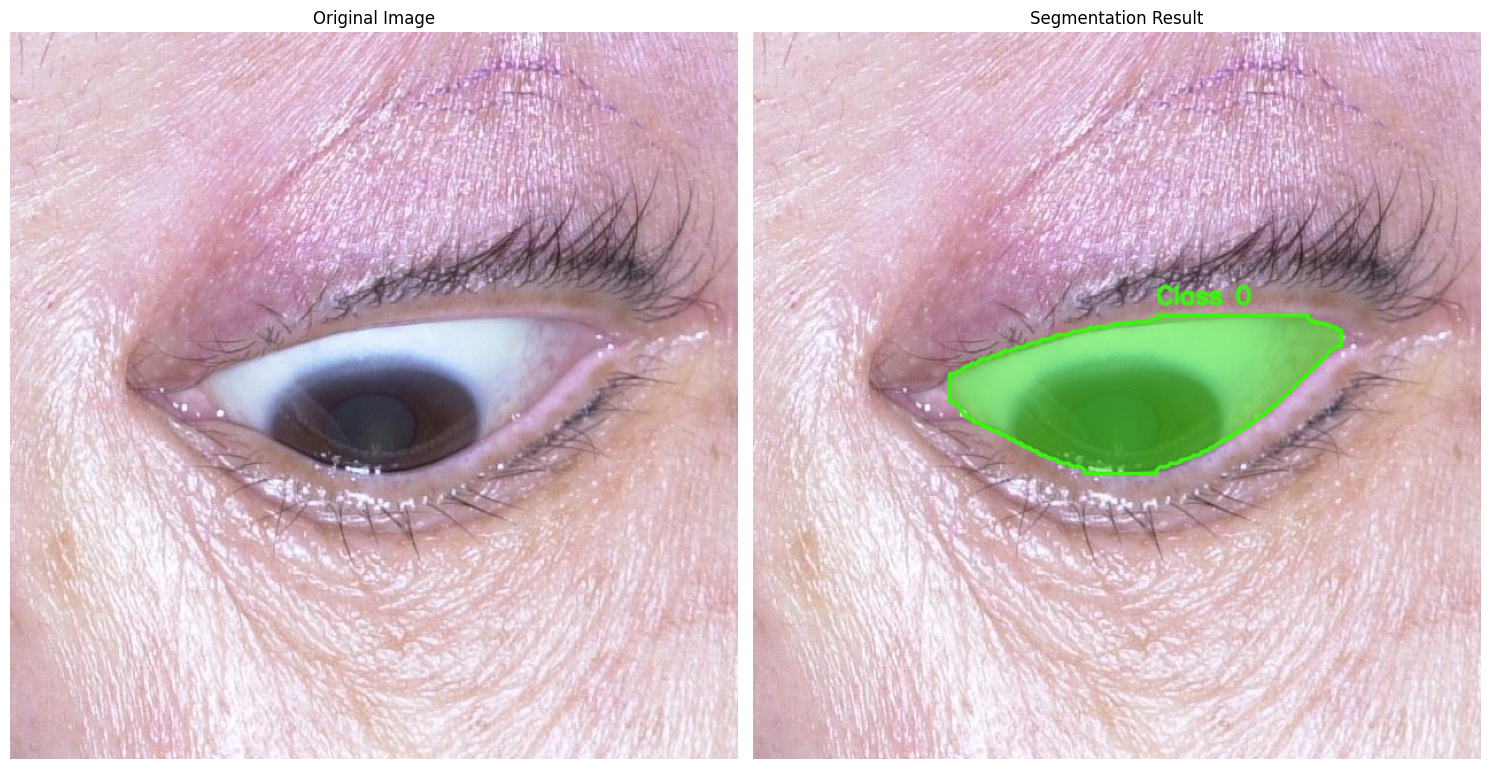

In [39]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_segmentation(image_path, label_path):
    """
    特定の画像とそれに対応するYOLOセグメンテーションラベルを読み込み、可視化する
    
    Args:
        image_path: 画像ファイルのパス
        label_path: 対応するラベルファイルのパス
    """
    # 画像を読み込む
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # ラベルファイルを読み込む
    with open(label_path, 'r') as f:
        label_lines = f.readlines()
    
    # 結果画像（元画像のコピー）
    result_image = image_rgb.copy()
    
    # 各ポリゴンに対してランダムな色を生成
    colors = []
    for _ in range(len(label_lines)):
        color = [random.randint(0, 255) for _ in range(3)]
        colors.append(color)
    
    # 各セグメンテーションのラベル行を処理
    for i, line in enumerate(label_lines):
        parts = line.strip().split()
        class_id = int(parts[0])
        
        # ポリゴン点を抽出（class_idの後の全ての値）
        polygon_points = list(map(float, parts[1:]))
        
        # x,y座標ペアに変換
        points = []
        for j in range(0, len(polygon_points), 2):
            # 座標を画像サイズに戻す（非正規化）
            x = int(polygon_points[j] * w)
            y = int(polygon_points[j+1] * h)
            points.append([x, y])
        
        # OpenCVで使用するためにnumpy配列に変換
        points = np.array(points, dtype=np.int32)
        
        # マスク画像を作成（セグメンテーション用）
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(mask, [points], 1)
        
        # 滑らかなエッジのためにぼかす
        mask = cv2.GaussianBlur(mask, (5, 5), 1.5)
        
        # マスクを[0,1]範囲の浮動小数点に変換
        mask_float = mask.astype(np.float32)
        
        # 色付きオーバーレイを作成
        colored_mask = np.zeros_like(image_rgb)
        colored_mask[:] = colors[i]
        
        # マスクを適用（浮動小数点版）
        alpha = 0.5  # 透明度
        
        # 各チャンネルに対してブレンディングを適用
        for c in range(3):
            result_image[:,:,c] = result_image[:,:,c] * (1 - alpha * mask_float) + colored_mask[:,:,c] * alpha * mask_float
        
        # アンチエイリアスを使用して輪郭線を描画
        cv2.polylines(result_image, [points], True, colors[i], 2, lineType=cv2.LINE_AA)
        
        # クラス名の表示位置（ポリゴンの一番上の点）
        top_point = points[np.argmin(points[:, 1])]
        cv2.putText(result_image, f"Class {class_id}", 
                   (top_point[0], top_point[1] - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[i], 2, lineType=cv2.LINE_AA)
    
    # 元画像とセグメンテーション結果を表示
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image_rgb)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Segmentation Result")
    plt.imshow(result_image)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_random_samples(image_dir, label_dir, num_samples=3):
    """
    指定されたディレクトリからランダムにサンプル画像を選び、セグメンテーション結果を可視化する
    
    Args:
        image_dir: 画像ディレクトリのパス
        label_dir: ラベルディレクトリのパス
        num_samples: 表示するサンプル数
    """
    # 画像ファイルのリストを取得
    image_files = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(image_dir, ext)))
    
    # サンプル数が画像数より多い場合は調整
    num_samples = min(num_samples, len(image_files))
    
    # ランダムにサンプルを選択
    samples = random.sample(image_files, num_samples)
    
    for image_path in samples:
        # 対応するラベルファイルのパスを取得
        basename = os.path.splitext(os.path.basename(image_path))[0]
        label_path = os.path.join(label_dir, f"{basename}.txt")
        
        # ラベルファイルが存在するか確認
        if os.path.exists(label_path):
            print(f"Processing: {basename}")
            visualize_segmentation(image_path, label_path)
        else:
            print(f"Label not found for {basename}")

def visualize_specific_image(image_dir, label_dir, image_name):
    """
    指定した特定の画像のセグメンテーション結果を可視化する
    
    Args:
        image_dir: 画像ディレクトリのパス
        label_dir: ラベルディレクトリのパス
        image_name: 画像ファイル名（拡張子付き）
    """
    # 画像パス
    image_path = os.path.join(image_dir, image_name)
    
    # 拡張子を除いたベース名を取得
    basename = os.path.splitext(os.path.basename(image_path))[0]
    
    # 対応するラベルファイルのパス
    label_path = os.path.join(label_dir, f"{basename}.txt")
    
    # ファイルの存在確認
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    if not os.path.exists(label_path):
        print(f"Label not found: {label_path}")
        return
    
    print(f"Processing: {basename}")
    visualize_segmentation(image_path, label_path)

# 使用例
if __name__ == "__main__":
    image_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\segmentation_dataset\images\train"
    label_dir = r"C:\Users\CorneAI\YOLOv11_Mobius\inferences\1-295_eyelid\segmentation_dataset\labels\train"
    
    # 方法1: ランダムに数枚の画像を表示
    # visualize_random_samples(image_dir, label_dir, num_samples=3)
    
    # 方法2: 特定の画像を表示（ファイル名を指定）
    visualize_specific_image(image_dir, label_dir, "2-20010410-53-161556_93634f164df86552cb116d429d014e3c8afeded721554adca1db2cefac5e920a_L.jpg")